# **Lab 4.2 NN MLP and CNN**

In [1]:
import torch
import torch.nn as nn
import torch.nn.functional as F
from torch.cuda.amp import autocast, GradScaler
import torchvision.transforms as transforms
from torchvision.datasets import ImageFolder
from torch.utils.data import DataLoader,Subset
from torch.utils.tensorboard import SummaryWriter
import numpy as np
import matplotlib.pyplot as plt
from tqdm import tqdm

import os
import seaborn as sns
from sklearn.metrics import confusion_matrix, classification_report

Complete the `load_data()` function that loads the image using `ImageFolder()` with the specific `transforms.compose()` provided below.
`load_data()` will return `DataLoader()` and print the information about the Dataset.
This function must load only a pair of classes from the entire dataset.
Please ensure that the final image is in grayscale and has a size of 28x28.

`transforms.Compose()` :
- `transforms.Resize(32)`
- `transforms.ToTensor()`
- `transforms.Pad()`
- `transforms.RandomRotation(45),`
- `transforms.CenterCrop(28)`

Resource : [`transforms.Compose()`](https://pytorch.org/vision/main/generated/torchvision.transforms.Compose.html#compose), [`torchvision.transforms v1`](<https://pytorch.org/vision/stable/transforms.html#v1-api-reference:~:text=custom)%20tv_tensor%20type.-,V1%20API%20Reference,-Geometry>)

In [2]:
def load_data(path, class_names):
    ### START CODE HERE ###
    transform = transforms.Compose([
        transforms.Resize(32),
        transforms.Grayscale(num_output_channels=1),
        transforms.ToTensor(),
        transforms.Pad(padding=2, fill=0, padding_mode='constant'),
        transforms.RandomRotation(45),
        transforms.CenterCrop(28)
    ])

    full_dataset = ImageFolder(path, transform=transform)

    if class_names is not None:
        class_to_idx = full_dataset.class_to_idx
        target_classes = [class_to_idx[class_name] for class_name in class_names]
        
        filtered_data = []
        for i, (image, label) in enumerate(full_dataset):
            if label in target_classes:
                binary_label = target_classes.index(label)
                filtered_data.append((image, binary_label))
        
        class BinaryDataset(torch.utils.data.Dataset):
            def __init__(self, data):
                self.data = data
            
            def __len__(self):
                return len(self.data)
            
            def __getitem__(self, idx):
                return self.data[idx]
        
        filtered_dataset = BinaryDataset(filtered_data)

        dataset_size = len(filtered_dataset)
        train_size = int(0.8 * dataset_size)
        test_size = dataset_size - train_size

        torch.manual_seed(42)
        train_dataset, test_dataset = torch.utils.data.random_split(
            filtered_dataset, [train_size, test_size]
        )
    else:
        dataset_size = len(full_dataset)
        train_size = int(0.8 * dataset_size)
        test_size = dataset_size - train_size
        
        torch.manual_seed(42)
        train_dataset, test_dataset = torch.utils.data.random_split(
            full_dataset, [train_size, test_size]
        )
        
    print("📃Train Dataset:")
    if class_names is not None:
        train_labels = [train_dataset[i][1] for i in range(len(train_dataset))]
        for i in range(2):
            count = train_labels.count(i)
            print(f"\tNumber of images in class {i}: {count}")
    print(f"\tNumber of training samples: {len(train_dataset)}")
    
    print("\n📃Test Dataset:")
    if class_names is not None:
        test_labels = [test_dataset[i][1] for i in range(len(test_dataset))]
        for i in range(2):
            count = test_labels.count(i)
            print(f"\tNumber of images in class {i}: {count}")
    print(f"\tNumber of testing samples: {len(test_dataset)}")

    train_loader = DataLoader(train_dataset, batch_size=32, shuffle=True, num_workers=0, pin_memory=True)
    test_loader = DataLoader(test_dataset, batch_size=32, shuffle=False, num_workers=0, pin_memory=True)

    ### END CODE HERE ###
    
    return train_loader, test_loader

Use your `load_data()` function to load the dataset in the cell below. Then, display the image from the first batch.

<details>
<summary>
<font size="3" color="orange">
<b>Expected output</b>
</font>
</summary>

- The output should resemble this, but not be identical

```
📃Train Dataset:
	Number of images in class 0: 313
	Number of images in class 1: 308
	Number of training samples: 621

📃Test Dataset:
	Number of images in class 0: 75
	Number of images in class 1: 81
	Number of testing samples: 156
```


![image.png](https://github.com/Digital-Image-Processing-Laboratory/Image-Processing-Course-2025/blob/main/Lab4_NN-and-CNN/assets/03.png?raw=true)

</details>

📃Train Dataset:
	Number of images in class 0: 308
	Number of images in class 1: 313
	Number of training samples: 621

📃Test Dataset:
	Number of images in class 0: 80
	Number of images in class 1: 76
	Number of testing samples: 156


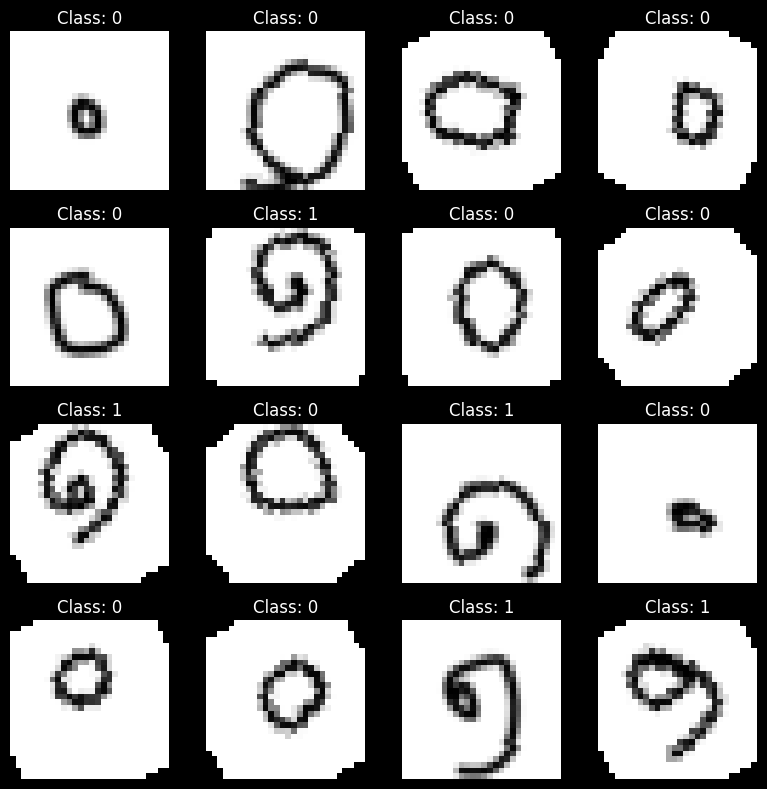

In [3]:
### START CODE HERE ###
class_names = ['0', '1']
train_loader, test_loader = load_data("thai-handwriting-number.appspot.com", class_names)

data_iter = iter(train_loader)
images, labels = next(data_iter)

rows = 4
cols = 4

fig, axes = plt.subplots(rows, cols, figsize=(cols*2, rows*2))
axes = axes.ravel()

binary_class_names = ['0', '1']

for i in range(rows*cols):
    if i < len(images):
        img = images[i].squeeze().numpy()
        
        axes[i].imshow(img, cmap='gray')
        label_idx = labels[i].item()
        class_name = binary_class_names[label_idx]
        axes[i].set_title(f'Class: {class_name}', color='white', fontsize=12)
        axes[i].axis('off')
    else:
        axes[i].axis('off')

fig.patch.set_facecolor('black')
plt.tight_layout()
plt.show()

### END CODE HERE ###

**Create Models**
1. **NN (Neural Network)**:
- **Input**: 28x28 grayscale images (1 channel)
- **Architecture**: Single fully connected layer with sigmoid activation
- **Output**: Single neuron output with sigmoid activation
- **Description**: This is a simple feedforward neural network with a single fully connected layer. It takes input images, flattens them, passes through a fully connected layer, and applies sigmoid activation to produce the output.

2. **MLP (Multi-Layer Perceptron)**:
- **Input**: 28x28 grayscale images (1 channel)
- **Architecture**: Two fully connected layers with sigmoid activations
- **Output**: Single neuron output with sigmoid activation
- **Description**: This is a multi-layer perceptron with two fully connected layers. After flattening the input images, it passes through the first fully connected layer with sigmoid activation, followed by the second fully connected layer with sigmoid activation, producing the output.

3. **CNN (Convolutional Neural Network)**:
- **Input**: 28x28 grayscale images (1 channel)
- **Architecture**: Two convolutional layers with ReLU activations, followed by two fully connected layers with ReLU activations
- **Output**: Single neuron output with sigmoid activation
- **Description**: This is a convolutional neural network with two convolutional layers followed by two fully connected layers. It applies convolutional operations with ReLU activations, followed by flattening the output and passing through fully connected layers with ReLU activations. Finally, it produces a single neuron output with sigmoid activation.


Every model should have a `get_features()` method that returns the result from all layers.

In [22]:
### START CODE HERE ###
class NN(nn.Module):
    def __init__(self):
        super(NN, self).__init__()
        self.fc1 = nn.Linear(28 * 28, 1)
        
    def get_features(self, x):
        x = x.view(x.size(0), -1)
        fc1_out = self.fc1(x)
        
        return [fc1_out]
    
    def forward(self, x):
        x = x.view(x.size(0), -1)
        x = torch.sigmoid(self.fc1(x))
        
        return x

class MLP(nn.Module):
    def __init__(self):
        super(MLP, self).__init__()
        self.fc1 = nn.Linear(28 * 28, 128)
        self.fc2 = nn.Linear(128, 1)
    
    def get_features(self, x):
        x = x.view(x.size(0), -1)
        
        fc1_out = torch.sigmoid(self.fc1(x))
        fc2_out = self.fc2(fc1_out)
        
        return [fc1_out, fc2_out]
    
    def forward(self, x):
        x = x.view(x.size(0), -1)
        x = torch.sigmoid(self.fc1(x))
        x = torch.sigmoid(self.fc2(x))
        
        return x

class CNN(nn.Module):
    def __init__(self):
        super(CNN, self).__init__()
        self.conv1 = nn.Conv2d(1, 16, kernel_size=3, padding=1)
        self.conv2 = nn.Conv2d(16, 32, kernel_size=3, padding=1)
        
        self.pool = nn.MaxPool2d(2, 2)
        
        self.fc1 = nn.Linear(32 * 7 * 7, 128)
        self.fc2 = nn.Linear(128, 1)
    
    def get_features(self, x):
        conv1_out = F.relu(self.conv1(x))
        pool1_out = self.pool(conv1_out)
        
        conv2_out = F.relu(self.conv2(pool1_out))
        pool2_out = self.pool(conv2_out)

        flattened = pool2_out.view(pool2_out.size(0), -1)
        
        fc1_out = F.relu(self.fc1(flattened))
        fc2_out = self.fc2(fc1_out)
        
        return [conv1_out, conv2_out, fc1_out, fc2_out]
    
    def forward(self, x):
        x = self.pool(F.relu(self.conv1(x)))
        x = self.pool(F.relu(self.conv2(x)))

        x = x.view(x.size(0), -1)
        
        x = F.relu(self.fc1(x))
        x = torch.sigmoid(self.fc2(x))
        
        return x

### END CODE HERE ###

Complete the function below. This function will be used to display the feature map from the models at every epoch on TensorBoard.

<details>
<summary>
<font size="3" color="orange">
<b>Expected output that will be display on TensorBoard</b>
</font>
</summary>

- The output should resemble this, but not be identical
- `NN()`<br>
![image.png](https://github.com/Digital-Image-Processing-Laboratory/Image-Processing-Course-2025/blob/main/Lab4_NN-and-CNN/assets/04.png?raw=true)
- `MLP()`<br>
![image-2.png](https://github.com/Digital-Image-Processing-Laboratory/Image-Processing-Course-2025/blob/main/Lab4_NN-and-CNN/assets/05.png?raw=true)
- `CNN()`<br>
![image-3.png](https://github.com/Digital-Image-Processing-Laboratory/Image-Processing-Course-2025/blob/main/Lab4_NN-and-CNN/assets/06.png?raw=true)
</details>

In [23]:
def show_featuremaps(feats):
    ### START CODE HERE ###
    if not feats:
        return None
    
    num_layers = len(feats)
    
    # Create smaller subplots to save memory
    fig, axes = plt.subplots(1, num_layers, figsize=(3 * num_layers, 3))
    
    if num_layers == 1:
        axes = [axes]  # Make it iterable for single layer
    
    for i, feat in enumerate(feats):
        if len(feat.shape) == 4:  # Convolutional feature maps (batch, channels, height, width)
            # Take first sample from batch and create grid of feature maps
            feat_sample = feat[0].detach().cpu()  # Remove batch dimension
            
            # Show only the first feature map to save memory
            im = axes[i].imshow(feat_sample[0], cmap='viridis')
            axes[i].set_title(f'Layer {i+1} - Conv Feature Map')
            axes[i].axis('off')
            # Skip colorbar to save memory
                    
        elif len(feat.shape) == 2:  # Fully connected layer (batch, features)
            # Visualize as 1D bar plot
            feat_sample = feat[0].detach().cpu().numpy()  # First sample
            
            # For large feature vectors, show only first 20 values to save memory
            if len(feat_sample) > 20:
                feat_sample = feat_sample[:20]
            
            axes[i].bar(range(len(feat_sample)), feat_sample)
            axes[i].set_title(f'Layer {i+1} - FC Features')
            axes[i].set_xlabel('Neuron Index')
            axes[i].set_ylabel('Activation Value')
    
    plt.tight_layout()
    ### END CODE HERE ###
    return fig

TensorBoard 101

Complete the `train()` function in the cell below. This function should evaluate the model at every epoch, log the training loss/accuracy, test loss/accuracy, and display the feature map from all layers of the model at every epoch on TensorBoard. Additionally, it should save the model at the last epoch.

Resource : [PyTorch Training loop](<https://pytorch.org/tutorials/beginner/introyt/trainingyt.html#:~:text=%3D0.9)-,The%20Training%20Loop,-Below%2C%20we%20have>), [TensorBoard](https://pytorch.org/docs/stable/tensorboard.html)

<details>
<summary>
<font size="3" color="orange">
<b>Expected output that will be display on TensorBoard</b>
</font>
</summary>

- The output should resemble this, but not be identical

![image.png](https://github.com/Digital-Image-Processing-Laboratory/Image-Processing-Course-2025/blob/main/Lab4_NN-and-CNN/assets/07.png?raw=true)

![image-2.png](https://github.com/Digital-Image-Processing-Laboratory/Image-Processing-Course-2025/blob/main/Lab4_NN-and-CNN/assets/08.png?raw=true)
</details>

In [24]:
def train(class_names, model, opt, loss_fn, train_loader, test_loader, epochs=10, writer=None, checkpoint_path=None, device='cpu'):
    ### START CODE HERE ###
    model.to(device)
    
    for epoch in range(epochs):
        # Training phase
        model.train()
        train_loss = 0.0
        train_correct = 0
        train_total = 0
        
        with tqdm(train_loader, desc=f'Epoch {epoch+1}/{epochs} [Train]') as pbar:
            for batch_idx, (data, target) in enumerate(pbar):
                data, target = data.to(device), target.to(device).float()
                
                opt.zero_grad()
                output = model(data).squeeze()
                loss = loss_fn(output, target)
                loss.backward()
                opt.step()
                
                train_loss += loss.item()
                
                # Calculate accuracy for binary classification
                predicted = (output > 0.5).float()
                train_total += target.size(0)
                train_correct += (predicted == target).sum().item()
                
                # Update progress bar
                pbar.set_postfix({
                    'Loss': f'{loss.item():.4f}',
                    'Acc': f'{100.*train_correct/train_total:.2f}%'
                })
        
        # Evaluation phase
        model.eval()
        test_loss = 0.0
        test_correct = 0
        test_total = 0
        
        with torch.no_grad():
            for data, target in test_loader:
                data, target = data.to(device), target.to(device).float()
                output = model(data).squeeze()
                
                test_loss += loss_fn(output, target).item()
                
                predicted = (output > 0.5).float()
                test_total += target.size(0)
                test_correct += (predicted == target).sum().item()
        
        # Calculate average losses and accuracies
        avg_train_loss = train_loss / len(train_loader)
        avg_test_loss = test_loss / len(test_loader)
        train_accuracy = 100. * train_correct / train_total
        test_accuracy = 100. * test_correct / test_total
        
        # Log to TensorBoard
        if writer:
            writer.add_scalar('Loss/Train', avg_train_loss, epoch)
            writer.add_scalar('Loss/Test', avg_test_loss, epoch)
            writer.add_scalar('Accuracy/Train', train_accuracy, epoch)
            writer.add_scalar('Accuracy/Test', test_accuracy, epoch)
            
            # Log feature maps only every 5 epochs to save memory
            if epoch % 5 == 0:
                try:
                    with torch.no_grad():
                        sample_data, _ = next(iter(test_loader))
                        sample_data = sample_data[:1].to(device)  # Take first sample
                        features = model.get_features(sample_data)
                        
                        # Create feature map visualization with smaller figure size
                        fig = show_featuremaps(features)
                        if fig:
                            # Reduce DPI to save memory
                            fig.set_dpi(50)
                            writer.add_figure(f'FeatureMaps/Epoch_{epoch}', fig, epoch)
                            plt.close(fig)
                            # Force garbage collection
                            import gc
                            gc.collect()
                except Exception as e:
                    print(f"Warning: Could not log feature maps at epoch {epoch}: {e}")
                    # Continue training even if feature map logging fails
        
        print(f'Epoch {epoch+1}/{epochs}:')
        print(f'  Train Loss: {avg_train_loss:.4f}, Train Acc: {train_accuracy:.2f}%')
        print(f'  Test Loss: {avg_test_loss:.4f}, Test Acc: {test_accuracy:.2f}%')
        print('-' * 50)
    
    # Save model at the last epoch
    if checkpoint_path:
        torch.save({
            'epoch': epochs,
            'model_state_dict': model.state_dict(),
            'optimizer_state_dict': opt.state_dict(),
            'train_accuracy': train_accuracy,
            'test_accuracy': test_accuracy,
        }, checkpoint_path)
        print(f'Model saved to {checkpoint_path}')

    ### END CODE HERE ###

Use your `train()` function to train all types of models with all combinations of numbers that you've obtained.

In [25]:
def visualize_model_pipeline(model, sample_data, model_name, class_pair, epoch, writer):
    """
    Visualize the complete pipeline for each model type
    """
    model.eval()
    with torch.no_grad():
        # Take a random sample from the batch
        sample_idx = torch.randint(0, sample_data.size(0), (1,)).item()
        single_sample = sample_data[sample_idx:sample_idx+1]
        
        if model_name == 'NN':
            # NN Pipeline: Input -> Flatten -> FC1 -> Sigmoid -> Output
            flattened = single_sample.view(single_sample.size(0), -1)
            fc1_out = model.fc1(flattened)
            sigmoid_out = torch.sigmoid(fc1_out)
            
            # Create visualization
            fig, axes = plt.subplots(1, 4, figsize=(16, 4))
            
            # Input Image
            axes[0].imshow(single_sample[0, 0].cpu(), cmap='gray')
            axes[0].set_title('Input Image\n(28×28)')
            axes[0].axis('off')
            
            # Flattened Input (show as heatmap)
            flattened_img = flattened[0].cpu().reshape(28, 28)
            axes[1].imshow(flattened_img, cmap='viridis')
            axes[1].set_title('Flattened Input\n(784 values)')
            axes[1].axis('off')
            
            # FC1 Output (before sigmoid)
            fc1_val = fc1_out[0, 0].cpu().item()
            axes[2].bar([0], [fc1_val], color='blue')
            axes[2].set_title(f'FC1 Output\n{fc1_val:.4f}')
            axes[2].set_ylabel('Activation')
            axes[2].set_xticks([])
            
            # Final Output (after sigmoid)
            final_val = sigmoid_out[0, 0].cpu().item()
            axes[3].bar([0], [final_val], color='red')
            axes[3].set_title(f'Sigmoid Output\n{final_val:.4f}')
            axes[3].set_ylabel('Probability')
            axes[3].set_xticks([])
            axes[3].set_ylim([0, 1])
            
            fig.suptitle(f'NN Pipeline - Classes {class_pair[0]} vs {class_pair[1]} - Epoch {epoch}')
            
        elif model_name == 'MLP':
            # MLP Pipeline: Input -> Flatten -> FC1 -> Sigmoid -> FC2 -> Sigmoid -> Output
            flattened = single_sample.view(single_sample.size(0), -1)
            fc1_out = model.fc1(flattened)
            fc1_sigmoid = torch.sigmoid(fc1_out)
            fc2_out = model.fc2(fc1_sigmoid)
            final_sigmoid = torch.sigmoid(fc2_out)
            
            # Create visualization
            fig, axes = plt.subplots(1, 6, figsize=(24, 4))
            
            # Input Image
            axes[0].imshow(single_sample[0, 0].cpu(), cmap='gray')
            axes[0].set_title('Input Image\n(28×28)')
            axes[0].axis('off')
            
            # Flattened Input
            flattened_img = flattened[0].cpu().reshape(28, 28)
            axes[1].imshow(flattened_img, cmap='viridis')
            axes[1].set_title('Flattened Input\n(784 values)')
            axes[1].axis('off')
            
            # FC1 Output (before sigmoid) - show first 20 neurons
            fc1_vals = fc1_out[0][:20].cpu()
            axes[2].bar(range(len(fc1_vals)), fc1_vals)
            axes[2].set_title('FC1 Output\n(128 neurons, showing 20)')
            axes[2].set_ylabel('Activation')
            
            # Hidden Layer (FC1 after sigmoid)
            fc1_sigmoid_vals = fc1_sigmoid[0][:20].cpu()
            axes[3].bar(range(len(fc1_sigmoid_vals)), fc1_sigmoid_vals, color='green')
            axes[3].set_title('Hidden Layer\n(after sigmoid)')
            axes[3].set_ylabel('Activation')
            
            # FC2 Output (before sigmoid)
            fc2_val = fc2_out[0, 0].cpu().item()
            axes[4].bar([0], [fc2_val], color='blue')
            axes[4].set_title(f'FC2 Output\n{fc2_val:.4f}')
            axes[4].set_ylabel('Activation')
            axes[4].set_xticks([])
            
            # Final Output
            final_val = final_sigmoid[0, 0].cpu().item()
            axes[5].bar([0], [final_val], color='red')
            axes[5].set_title(f'Final Output\n{final_val:.4f}')
            axes[5].set_ylabel('Probability')
            axes[5].set_xticks([])
            axes[5].set_ylim([0, 1])
            
            fig.suptitle(f'MLP Pipeline - Classes {class_pair[0]} vs {class_pair[1]} - Epoch {epoch}')
            
        elif model_name == 'CNN':
            # CNN Pipeline: Input -> Conv1 -> ReLU -> Pool -> Conv2 -> ReLU -> Pool -> Flatten -> FC1 -> ReLU -> FC2 -> Sigmoid
            conv1_out = F.relu(model.conv1(single_sample))
            pool1_out = model.pool(conv1_out)
            conv2_out = F.relu(model.conv2(pool1_out))
            pool2_out = model.pool(conv2_out)
            flattened = pool2_out.view(pool2_out.size(0), -1)
            fc1_out = F.relu(model.fc1(flattened))
            fc2_out = model.fc2(fc1_out)
            final_sigmoid = torch.sigmoid(fc2_out)
            
            # Create visualization
            fig, axes = plt.subplots(2, 4, figsize=(20, 10))
            axes = axes.flatten()
            
            # Input Image
            axes[0].imshow(single_sample[0, 0].cpu(), cmap='gray')
            axes[0].set_title('Input Image\n(1×28×28)')
            axes[0].axis('off')
            
            # Conv1 Feature Map (show first channel)
            conv1_feature = conv1_out[0, 0].cpu()
            axes[1].imshow(conv1_feature, cmap='viridis')
            axes[1].set_title('Conv1 + ReLU\n(16×28×28, showing ch.0)')
            axes[1].axis('off')
            
            # Pool1 Feature Map
            pool1_feature = pool1_out[0, 0].cpu()
            axes[2].imshow(pool1_feature, cmap='viridis')
            axes[2].set_title('MaxPool1\n(16×14×14, showing ch.0)')
            axes[2].axis('off')
            
            # Conv2 Feature Map (show first channel)
            conv2_feature = conv2_out[0, 0].cpu()
            axes[3].imshow(conv2_feature, cmap='viridis')
            axes[3].set_title('Conv2 + ReLU\n(32×14×14, showing ch.0)')
            axes[3].axis('off')
            
            # Pool2 Feature Map
            pool2_feature = pool2_out[0, 0].cpu()
            axes[4].imshow(pool2_feature, cmap='viridis')
            axes[4].set_title('MaxPool2\n(32×7×7, showing ch.0)')
            axes[4].axis('off')
            
            # Flattened representation
            flattened_vis = flattened[0][:49].cpu().reshape(7, 7)  # Show subset as 7x7
            axes[5].imshow(flattened_vis, cmap='plasma')
            axes[5].set_title('Flattened\n(1568 values, showing 49)')
            axes[5].axis('off')
            
            # FC1 Output (show first 20 neurons)
            fc1_vals = fc1_out[0][:20].cpu()
            axes[6].bar(range(len(fc1_vals)), fc1_vals, color='green')
            axes[6].set_title('FC1 + ReLU\n(128 neurons, showing 20)')
            axes[6].set_ylabel('Activation')
            
            # Final Output
            final_val = final_sigmoid[0, 0].cpu().item()
            axes[7].bar([0], [final_val], color='red')
            axes[7].set_title(f'FC2 + Sigmoid\n{final_val:.4f}')
            axes[7].set_ylabel('Probability')
            axes[7].set_xticks([])
            axes[7].set_ylim([0, 1])
            
            fig.suptitle(f'CNN Pipeline - Classes {class_pair[0]} vs {class_pair[1]} - Epoch {epoch}')
        
        plt.tight_layout()
        return fig

In [27]:
def train_with_enhanced_visualization(class_names, model, opt, loss_fn, train_loader, test_loader, epochs=10, writer=None, checkpoint_path=None, device='cpu'):
    """
    Enhanced training function with detailed pipeline visualization
    """
    model.to(device)
    model_name = model.__class__.__name__
    
    for epoch in range(epochs):
        # Training phase
        model.train()
        train_loss = 0.0
        train_correct = 0
        train_total = 0
        
        with tqdm(train_loader, desc=f'Epoch {epoch+1}/{epochs} [Train]') as pbar:
            for batch_idx, (data, target) in enumerate(pbar):
                data, target = data.to(device), target.to(device).float()
                
                opt.zero_grad()
                output = model(data).squeeze()
                loss = loss_fn(output, target)
                loss.backward()
                opt.step()
                
                train_loss += loss.item()
                
                # Calculate accuracy for binary classification
                predicted = (output > 0.5).float()
                train_total += target.size(0)
                train_correct += (predicted == target).sum().item()
                
                # Update progress bar
                pbar.set_postfix({
                    'Loss': f'{loss.item():.4f}',
                    'Acc': f'{100.*train_correct/train_total:.2f}%'
                })
        
        # Evaluation phase
        model.eval()
        test_loss = 0.0
        test_correct = 0
        test_total = 0
        
        with torch.no_grad():
            for data, target in test_loader:
                data, target = data.to(device), target.to(device).float()
                output = model(data).squeeze()
                
                test_loss += loss_fn(output, target).item()
                
                predicted = (output > 0.5).float()
                test_total += target.size(0)
                test_correct += (predicted == target).sum().item()
        
        # Calculate average losses and accuracies
        avg_train_loss = train_loss / len(train_loader)
        avg_test_loss = test_loss / len(test_loader)
        train_accuracy = 100. * train_correct / train_total
        test_accuracy = 100. * test_correct / test_total
        
        # Log to TensorBoard
        if writer:
            writer.add_scalar('Loss/Train', avg_train_loss, epoch)
            writer.add_scalar('Loss/Test', avg_test_loss, epoch)
            writer.add_scalar('Accuracy/Train', train_accuracy, epoch)
            writer.add_scalar('Accuracy/Test', test_accuracy, epoch)
            
            # Enhanced pipeline visualization every 2 epochs
            if epoch % 2 == 0:
                try:
                    with torch.no_grad():
                        # Get random samples from test set
                        sample_data, sample_labels = next(iter(test_loader))
                        sample_data = sample_data.to(device)
                        
                        # Create pipeline visualization
                        fig = visualize_model_pipeline(
                            model, sample_data, model_name, class_names, epoch, writer
                        )
                        
                        if fig:
                            writer.add_figure(f'Pipeline/{model_name}_Classes_{class_names[0]}_{class_names[1]}', fig, epoch)
                            plt.close(fig)
                            
                        # Also log traditional feature maps
                        features = model.get_features(sample_data[:1])
                        fig_features = show_featuremaps(features)
                        if fig_features:
                            writer.add_figure(f'FeatureMaps/{model_name}_Classes_{class_names[0]}_{class_names[1]}', fig_features, epoch)
                            plt.close(fig_features)
                            
                        # Force garbage collection
                        import gc
                        gc.collect()
                        
                except Exception as e:
                    print(f"Warning: Could not log visualizations at epoch {epoch}: {e}")
        
        print(f'Epoch {epoch+1}/{epochs}:')
        print(f'  Train Loss: {avg_train_loss:.4f}, Train Acc: {train_accuracy:.2f}%')
        print(f'  Test Loss: {avg_test_loss:.4f}, Test Acc: {test_accuracy:.2f}%')
        print('-' * 50)
    
    # Save model at the last epoch
    if checkpoint_path:
        torch.save({
            'epoch': epochs,
            'model_state_dict': model.state_dict(),
            'optimizer_state_dict': opt.state_dict(),
            'train_accuracy': train_accuracy,
            'test_accuracy': test_accuracy,
        }, checkpoint_path)
        print(f'Model saved to {checkpoint_path}')

In [ ]:
### START CODE HERE ###
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
print(f'Using device: {device}')

# Define class combinations to train on
class_combinations = [
    ['0', '1'], ['0', '2'], ['0', '3'], ['0', '4'], ['0', '5'],
    ['0', '6'], ['0', '7'], ['0', '8'], ['0', '9'],
    ['1', '2'], ['1', '3'], ['1', '4'], ['1', '5'],
    ['1', '6'], ['1', '7'], ['1', '8'], ['1', '9'],
    ['2', '3'], ['2', '4'], ['2', '5'],
    ['2', '6'], ['2', '7'], ['2', '8'], ['2', '9'],
    ['3', '4'], ['3', '5'], ['3', '6'], ['3', '7'], ['3', '8'], ['3', '9'],
    ['4', '5'], ['4', '6'], ['4', '7'], ['4', '8'], ['4', '9'],
    ['5', '6'], ['5', '7'], ['5', '8'], ['5', '9'],
    ['6', '7'], ['6', '8'], ['6', '9'],
    ['7', '8'], ['7', '9'],
    ['8', '9']
]

# Define model types
model_types = ['NN', 'MLP', 'CNN']

# Training parameters
epochs = 10
learning_rate = 0.001

# Create directories for saving models
os.makedirs('models', exist_ok=True)
os.makedirs('runs', exist_ok=True)

# Train all combinations with enhanced visualization
for class_pair in class_combinations:
    print(f"\n{'='*60}")
    print(f"Training on classes: {class_pair}")
    print(f"{'='*60}")
    
    # Load data for this class pair
    train_loader, test_loader = load_data("thai-handwriting-number.appspot.com", class_pair)
    
    for model_name in model_types:
        print(f"\nTraining {model_name} model...")
        
        # Initialize model
        if model_name == 'NN':
            model = NN()
        elif model_name == 'MLP':
            model = MLP()
        elif model_name == 'CNN':
            model = CNN()
        
        # Initialize optimizer and loss function
        optimizer = torch.optim.Adam(model.parameters(), lr=learning_rate)
        criterion = nn.BCELoss()  # Binary Cross Entropy for binary classification
        
        # Setup TensorBoard writer
        writer = SummaryWriter(f'runs/{model_name}_classes_{"_".join(class_pair)}')
        
        # Define checkpoint path
        checkpoint_path = f'models/{model_name}_classes_{"_".join(class_pair)}.pth'
        
        # Train the model with enhanced visualization
        train_with_enhanced_visualization(
            class_names=class_pair,
            model=model,
            opt=optimizer,
            loss_fn=criterion,
            train_loader=train_loader,
            test_loader=test_loader,
            epochs=epochs,
            writer=writer,
            checkpoint_path=checkpoint_path,
            device=device
        )
        
        writer.close()
        print(f"Completed training {model_name} on classes {class_pair}")
        
        # Force garbage collection between models to free memory
        import gc
        del model, optimizer, criterion
        torch.cuda.empty_cache() if torch.cuda.is_available() else None
        gc.collect()

print("\n🎉 All training completed!")
print("To view TensorBoard logs, run: tensorboard --logdir=runs")
### END CODE HERE ###

Using device: cuda

Training on classes: ['0', '1']
📃Train Dataset:
	Number of images in class 0: 308
	Number of images in class 1: 313
	Number of training samples: 621

📃Test Dataset:
	Number of images in class 0: 80
	Number of images in class 1: 76
	Number of testing samples: 156

Training NN model...
📃Train Dataset:
	Number of images in class 0: 308
	Number of images in class 1: 313
	Number of training samples: 621

📃Test Dataset:
	Number of images in class 0: 80
	Number of images in class 1: 76
	Number of testing samples: 156

Training NN model...


Epoch 1/10 [Train]: 100%|██████████| 20/20 [00:00<00:00, 166.95it/s, Loss=0.6642, Acc=50.89%]



Epoch 1/10:
  Train Loss: 0.7073, Train Acc: 50.89%
  Test Loss: 0.6838, Test Acc: 60.26%
--------------------------------------------------


Epoch 2/10 [Train]: 100%|██████████| 20/20 [00:00<00:00, 177.96it/s, Loss=0.6345, Acc=62.64%]



Epoch 2/10:
  Train Loss: 0.6693, Train Acc: 62.64%
  Test Loss: 0.6668, Test Acc: 63.46%
--------------------------------------------------


Epoch 3/10 [Train]: 100%|██████████| 20/20 [00:00<00:00, 75.62it/s, Loss=0.6714, Acc=58.29%]



Epoch 3/10:
  Train Loss: 0.6607, Train Acc: 58.29%
  Test Loss: 0.6610, Test Acc: 62.18%
--------------------------------------------------


Epoch 4/10 [Train]: 100%|██████████| 20/20 [00:00<00:00, 78.62it/s, Loss=0.6370, Acc=62.64%]



Epoch 4/10:
  Train Loss: 0.6425, Train Acc: 62.64%
  Test Loss: 0.6473, Test Acc: 60.26%
--------------------------------------------------


Epoch 5/10 [Train]: 100%|██████████| 20/20 [00:00<00:00, 89.66it/s, Loss=0.5734, Acc=65.06%]


Epoch 5/10:
  Train Loss: 0.6172, Train Acc: 65.06%
  Test Loss: 0.6393, Test Acc: 62.18%
--------------------------------------------------


Epoch 6/10 [Train]: 100%|██████████| 20/20 [00:00<00:00, 43.01it/s, Loss=0.6019, Acc=68.92%]


Epoch 6/10:
  Train Loss: 0.6089, Train Acc: 68.92%
  Test Loss: 0.6502, Test Acc: 55.77%
--------------------------------------------------


Epoch 7/10 [Train]: 100%|██████████| 20/20 [00:00<00:00, 46.38it/s, Loss=0.5531, Acc=72.79%]



Epoch 7/10:
  Train Loss: 0.5888, Train Acc: 72.79%
  Test Loss: 0.6183, Test Acc: 69.87%
--------------------------------------------------


Epoch 8/10 [Train]: 100%|██████████| 20/20 [00:00<00:00, 183.49it/s, Loss=0.5911, Acc=76.01%]



Epoch 8/10:
  Train Loss: 0.5735, Train Acc: 76.01%
  Test Loss: 0.6081, Test Acc: 67.31%
--------------------------------------------------


Epoch 9/10 [Train]: 100%|██████████| 20/20 [00:00<00:00, 170.42it/s, Loss=0.4641, Acc=76.33%]



Epoch 9/10:
  Train Loss: 0.5569, Train Acc: 76.33%
  Test Loss: 0.6041, Test Acc: 67.95%
--------------------------------------------------


Epoch 10/10 [Train]: 100%|██████████| 20/20 [00:00<00:00, 220.78it/s, Loss=0.4907, Acc=76.49%]

Epoch 10/10:
  Train Loss: 0.5493, Train Acc: 76.49%
  Test Loss: 0.6399, Test Acc: 62.18%
--------------------------------------------------
Model saved to models/NN_classes_0_1.pth
Completed training NN on classes ['0', '1']



Training MLP model...


Epoch 1/10 [Train]: 100%|██████████| 20/20 [00:00<00:00, 174.80it/s, Loss=0.6970, Acc=54.43%]



Epoch 1/10:
  Train Loss: 0.7042, Train Acc: 54.43%
  Test Loss: 0.6805, Test Acc: 55.13%
--------------------------------------------------


Epoch 2/10 [Train]: 100%|██████████| 20/20 [00:00<00:00, 219.32it/s, Loss=0.6958, Acc=65.38%]



Epoch 2/10:
  Train Loss: 0.6631, Train Acc: 65.38%
  Test Loss: 0.6665, Test Acc: 57.05%
--------------------------------------------------


Epoch 3/10 [Train]: 100%|██████████| 20/20 [00:00<00:00, 210.93it/s, Loss=0.7002, Acc=68.92%]


Epoch 3/10:
  Train Loss: 0.6336, Train Acc: 68.92%
  Test Loss: 0.6715, Test Acc: 54.49%
--------------------------------------------------


Epoch 4/10 [Train]: 100%|██████████| 20/20 [00:01<00:00, 13.06it/s, Loss=0.5722, Acc=69.08%]


Epoch 4/10:
  Train Loss: 0.6065, Train Acc: 69.08%
  Test Loss: 0.7426, Test Acc: 49.36%
--------------------------------------------------


Epoch 5/10 [Train]: 100%|██████████| 20/20 [00:00<00:00, 48.73it/s, Loss=0.7237, Acc=68.60%]



Epoch 5/10:
  Train Loss: 0.6041, Train Acc: 68.60%
  Test Loss: 0.6166, Test Acc: 66.03%
--------------------------------------------------


Epoch 6/10 [Train]: 100%|██████████| 20/20 [00:00<00:00, 47.06it/s, Loss=0.7296, Acc=70.53%]


Epoch 6/10:
  Train Loss: 0.5906, Train Acc: 70.53%
  Test Loss: 0.6391, Test Acc: 62.18%
--------------------------------------------------


Epoch 7/10 [Train]: 100%|██████████| 20/20 [00:00<00:00, 75.04it/s, Loss=0.5447, Acc=70.69%]



Epoch 7/10:
  Train Loss: 0.5755, Train Acc: 70.69%
  Test Loss: 0.6113, Test Acc: 68.59%
--------------------------------------------------


Epoch 8/10 [Train]: 100%|██████████| 20/20 [00:00<00:00, 61.04it/s, Loss=0.4131, Acc=76.49%]


Epoch 8/10:
  Train Loss: 0.5297, Train Acc: 76.49%
  Test Loss: 0.6043, Test Acc: 67.95%
--------------------------------------------------


Epoch 9/10 [Train]: 100%|██████████| 20/20 [00:00<00:00, 81.59it/s, Loss=0.7425, Acc=78.74%]



Epoch 9/10:
  Train Loss: 0.5249, Train Acc: 78.74%
  Test Loss: 0.6087, Test Acc: 69.87%
--------------------------------------------------


Epoch 10/10 [Train]: 100%|██████████| 20/20 [00:00<00:00, 63.51it/s, Loss=0.5550, Acc=79.23%]


Epoch 10/10:
  Train Loss: 0.4865, Train Acc: 79.23%
  Test Loss: 0.5897, Test Acc: 66.67%
--------------------------------------------------
Model saved to models/MLP_classes_0_1.pth
Completed training MLP on classes ['0', '1']

Training CNN model...

Training CNN model...


Epoch 1/10 [Train]: 100%|██████████| 20/20 [00:00<00:00, 44.81it/s, Loss=0.6431, Acc=54.59%]



Epoch 1/10:
  Train Loss: 0.6891, Train Acc: 54.59%
  Test Loss: 0.6764, Test Acc: 67.31%
--------------------------------------------------


Epoch 2/10 [Train]: 100%|██████████| 20/20 [00:00<00:00, 75.97it/s, Loss=0.4906, Acc=70.85%]


Epoch 2/10:
  Train Loss: 0.6284, Train Acc: 70.85%
  Test Loss: 0.6165, Test Acc: 67.95%
--------------------------------------------------


Epoch 3/10 [Train]: 100%|██████████| 20/20 [00:00<00:00, 72.31it/s, Loss=0.5916, Acc=74.24%]


Epoch 3/10:
  Train Loss: 0.5324, Train Acc: 74.24%
  Test Loss: 0.5993, Test Acc: 70.51%
--------------------------------------------------


Epoch 4/10 [Train]: 100%|██████████| 20/20 [00:00<00:00, 54.38it/s, Loss=0.5059, Acc=79.23%]



Epoch 4/10:
  Train Loss: 0.4927, Train Acc: 79.23%
  Test Loss: 0.5483, Test Acc: 71.15%
--------------------------------------------------


Epoch 5/10 [Train]: 100%|██████████| 20/20 [00:00<00:00, 93.72it/s, Loss=0.4180, Acc=81.48%] 


Epoch 5/10:
  Train Loss: 0.4449, Train Acc: 81.48%
  Test Loss: 0.5286, Test Acc: 76.28%
--------------------------------------------------


Epoch 6/10 [Train]: 100%|██████████| 20/20 [00:00<00:00, 90.84it/s, Loss=0.3183, Acc=83.74%] 


Epoch 6/10:
  Train Loss: 0.3917, Train Acc: 83.74%
  Test Loss: 0.5192, Test Acc: 77.56%
--------------------------------------------------


Epoch 7/10 [Train]: 100%|██████████| 20/20 [00:00<00:00, 67.38it/s, Loss=0.5142, Acc=83.74%]


Epoch 7/10:
  Train Loss: 0.3830, Train Acc: 83.74%
  Test Loss: 0.4938, Test Acc: 78.85%
--------------------------------------------------


Epoch 8/10 [Train]: 100%|██████████| 20/20 [00:00<00:00, 65.99it/s, Loss=0.5229, Acc=85.67%]


Epoch 8/10:
  Train Loss: 0.3550, Train Acc: 85.67%
  Test Loss: 0.5087, Test Acc: 79.49%
--------------------------------------------------


Epoch 9/10 [Train]: 100%|██████████| 20/20 [00:00<00:00, 76.05it/s, Loss=0.4392, Acc=86.31%]


Epoch 9/10:
  Train Loss: 0.3324, Train Acc: 86.31%
  Test Loss: 0.4755, Test Acc: 80.13%
--------------------------------------------------


Epoch 10/10 [Train]: 100%|██████████| 20/20 [00:00<00:00, 87.98it/s, Loss=0.1995, Acc=87.92%] 


Epoch 10/10:
  Train Loss: 0.3002, Train Acc: 87.92%
  Test Loss: 0.5499, Test Acc: 78.21%
--------------------------------------------------
Model saved to models/CNN_classes_0_1.pth
Completed training CNN on classes ['0', '1']

Training on classes: ['0', '2']

Training on classes: ['0', '2']
📃Train Dataset:
	Number of images in class 0: 308
	Number of images in class 1: 313
	Number of training samples: 621

📃Test Dataset:
	Number of images in class 0: 80
	Number of images in class 1: 76
	Number of testing samples: 156

Training NN model...
📃Train Dataset:
	Number of images in class 0: 308
	Number of images in class 1: 313
	Number of training samples: 621

📃Test Dataset:
	Number of images in class 0: 80
	Number of images in class 1: 76
	Number of testing samples: 156

Training NN model...


Epoch 1/10 [Train]: 100%|██████████| 20/20 [00:00<00:00, 117.68it/s, Loss=0.6510, Acc=52.33%]



Epoch 1/10:
  Train Loss: 0.6985, Train Acc: 52.33%
  Test Loss: 0.6715, Test Acc: 64.74%
--------------------------------------------------


Epoch 2/10 [Train]: 100%|██████████| 20/20 [00:00<00:00, 68.12it/s, Loss=0.6812, Acc=64.57%]


Epoch 2/10:
  Train Loss: 0.6555, Train Acc: 64.57%
  Test Loss: 0.6469, Test Acc: 66.67%
--------------------------------------------------


Epoch 3/10 [Train]: 100%|██████████| 20/20 [00:00<00:00, 69.81it/s, Loss=0.5199, Acc=66.83%]


Epoch 3/10:
  Train Loss: 0.6316, Train Acc: 66.83%
  Test Loss: 0.6297, Test Acc: 71.15%
--------------------------------------------------


Epoch 4/10 [Train]: 100%|██████████| 20/20 [00:00<00:00, 51.36it/s, Loss=0.6031, Acc=70.37%]



Epoch 4/10:
  Train Loss: 0.6071, Train Acc: 70.37%
  Test Loss: 0.6169, Test Acc: 64.10%
--------------------------------------------------


Epoch 5/10 [Train]: 100%|██████████| 20/20 [00:00<00:00, 51.94it/s, Loss=0.5662, Acc=71.82%]


Epoch 5/10:
  Train Loss: 0.5836, Train Acc: 71.82%
  Test Loss: 0.6044, Test Acc: 64.74%
--------------------------------------------------


Epoch 6/10 [Train]: 100%|██████████| 20/20 [00:00<00:00, 153.46it/s, Loss=0.5821, Acc=73.75%]


Epoch 6/10:
  Train Loss: 0.5696, Train Acc: 73.75%
  Test Loss: 0.6111, Test Acc: 58.97%
--------------------------------------------------


Epoch 7/10 [Train]: 100%|██████████| 20/20 [00:00<00:00, 176.46it/s, Loss=0.5764, Acc=77.94%]



Epoch 7/10:
  Train Loss: 0.5490, Train Acc: 77.94%
  Test Loss: 0.5776, Test Acc: 78.85%
--------------------------------------------------


Epoch 8/10 [Train]: 100%|██████████| 20/20 [00:00<00:00, 258.41it/s, Loss=0.5413, Acc=81.96%]



Epoch 8/10:
  Train Loss: 0.5298, Train Acc: 81.96%
  Test Loss: 0.5694, Test Acc: 77.56%
--------------------------------------------------


Epoch 9/10 [Train]: 100%|██████████| 20/20 [00:00<00:00, 245.91it/s, Loss=0.4369, Acc=82.77%]



Epoch 9/10:
  Train Loss: 0.5126, Train Acc: 82.77%
  Test Loss: 0.5637, Test Acc: 74.36%
--------------------------------------------------


Epoch 10/10 [Train]: 100%|██████████| 20/20 [00:00<00:00, 201.98it/s, Loss=0.5220, Acc=83.41%]

Epoch 10/10:
  Train Loss: 0.5062, Train Acc: 83.41%
  Test Loss: 0.5953, Test Acc: 58.33%
--------------------------------------------------
Model saved to models/NN_classes_0_2.pth
Completed training NN on classes ['0', '2']



Training MLP model...


Epoch 1/10 [Train]: 100%|██████████| 20/20 [00:00<00:00, 72.28it/s, Loss=0.6743, Acc=56.84%]


Epoch 1/10:
  Train Loss: 0.6935, Train Acc: 56.84%
  Test Loss: 0.6694, Test Acc: 62.18%
--------------------------------------------------


Epoch 2/10 [Train]: 100%|██████████| 20/20 [00:00<00:00, 28.16it/s, Loss=0.6229, Acc=72.30%]


Epoch 2/10:
  Train Loss: 0.6393, Train Acc: 72.30%
  Test Loss: 0.6433, Test Acc: 64.10%
--------------------------------------------------


Epoch 3/10 [Train]: 100%|██████████| 20/20 [00:00<00:00, 45.48it/s, Loss=0.6522, Acc=76.17%]



Epoch 3/10:
  Train Loss: 0.5989, Train Acc: 76.17%
  Test Loss: 0.6390, Test Acc: 65.38%
--------------------------------------------------


Epoch 4/10 [Train]: 100%|██████████| 20/20 [00:00<00:00, 73.58it/s, Loss=0.5047, Acc=74.72%]


Epoch 4/10:
  Train Loss: 0.5597, Train Acc: 74.72%
  Test Loss: 0.6875, Test Acc: 49.36%
--------------------------------------------------


Epoch 5/10 [Train]: 100%|██████████| 20/20 [00:00<00:00, 68.37it/s, Loss=0.6258, Acc=76.17%]



Epoch 5/10:
  Train Loss: 0.5361, Train Acc: 76.17%
  Test Loss: 0.5658, Test Acc: 66.03%
--------------------------------------------------


Epoch 6/10 [Train]: 100%|██████████| 20/20 [00:00<00:00, 50.98it/s, Loss=0.6465, Acc=73.75%]


Epoch 6/10:
  Train Loss: 0.5215, Train Acc: 73.75%
  Test Loss: 0.6198, Test Acc: 67.31%
--------------------------------------------------


Epoch 7/10 [Train]: 100%|██████████| 20/20 [00:00<00:00, 66.66it/s, Loss=0.3596, Acc=75.68%]


Epoch 7/10:
  Train Loss: 0.5097, Train Acc: 75.68%
  Test Loss: 0.5783, Test Acc: 64.10%
--------------------------------------------------


Epoch 8/10 [Train]: 100%|██████████| 20/20 [00:00<00:00, 101.32it/s, Loss=0.3382, Acc=79.87%]


Epoch 8/10:
  Train Loss: 0.4651, Train Acc: 79.87%
  Test Loss: 0.5174, Test Acc: 80.77%
--------------------------------------------------


Epoch 9/10 [Train]: 100%|██████████| 20/20 [00:00<00:00, 85.11it/s, Loss=0.6443, Acc=83.74%]



Epoch 9/10:
  Train Loss: 0.4379, Train Acc: 83.74%
  Test Loss: 0.5068, Test Acc: 81.41%
--------------------------------------------------


Epoch 10/10 [Train]: 100%|██████████| 20/20 [00:00<00:00, 94.91it/s, Loss=0.4984, Acc=83.25%] 


Epoch 10/10:
  Train Loss: 0.4238, Train Acc: 83.25%
  Test Loss: 0.4961, Test Acc: 81.41%
--------------------------------------------------
Model saved to models/MLP_classes_0_2.pth
Completed training MLP on classes ['0', '2']

Training CNN model...

Training CNN model...


Epoch 1/10 [Train]: 100%|██████████| 20/20 [00:00<00:00, 52.50it/s, Loss=0.6242, Acc=54.75%]



Epoch 1/10:
  Train Loss: 0.6783, Train Acc: 54.75%
  Test Loss: 0.6574, Test Acc: 65.38%
--------------------------------------------------


Epoch 2/10 [Train]: 100%|██████████| 20/20 [00:00<00:00, 54.01it/s, Loss=0.4962, Acc=76.97%]



Epoch 2/10:
  Train Loss: 0.5624, Train Acc: 76.97%
  Test Loss: 0.5173, Test Acc: 75.00%
--------------------------------------------------


Epoch 3/10 [Train]: 100%|██████████| 20/20 [00:00<00:00, 73.12it/s, Loss=0.5597, Acc=84.22%]



Epoch 3/10:
  Train Loss: 0.3971, Train Acc: 84.22%
  Test Loss: 0.4866, Test Acc: 78.85%
--------------------------------------------------


Epoch 4/10 [Train]: 100%|██████████| 20/20 [00:00<00:00, 61.83it/s, Loss=0.2401, Acc=85.99%]


Epoch 4/10:
  Train Loss: 0.3382, Train Acc: 85.99%
  Test Loss: 0.4370, Test Acc: 80.77%
--------------------------------------------------


Epoch 5/10 [Train]: 100%|██████████| 20/20 [00:00<00:00, 94.89it/s, Loss=0.3148, Acc=88.41%]



Epoch 5/10:
  Train Loss: 0.3001, Train Acc: 88.41%
  Test Loss: 0.4594, Test Acc: 81.41%
--------------------------------------------------


Epoch 6/10 [Train]: 100%|██████████| 20/20 [00:00<00:00, 60.51it/s, Loss=0.3130, Acc=91.14%]


Epoch 6/10:
  Train Loss: 0.2513, Train Acc: 91.14%
  Test Loss: 0.4176, Test Acc: 84.62%
--------------------------------------------------


Epoch 7/10 [Train]: 100%|██████████| 20/20 [00:00<00:00, 73.30it/s, Loss=0.2622, Acc=92.43%]


Epoch 7/10:
  Train Loss: 0.2277, Train Acc: 92.43%
  Test Loss: 0.3966, Test Acc: 86.54%
--------------------------------------------------


Epoch 8/10 [Train]: 100%|██████████| 20/20 [00:00<00:00, 70.83it/s, Loss=0.3474, Acc=92.75%]



Epoch 8/10:
  Train Loss: 0.2204, Train Acc: 92.75%
  Test Loss: 0.4394, Test Acc: 85.26%
--------------------------------------------------


Epoch 9/10 [Train]: 100%|██████████| 20/20 [00:00<00:00, 57.82it/s, Loss=0.2859, Acc=92.91%]



Epoch 9/10:
  Train Loss: 0.2185, Train Acc: 92.91%
  Test Loss: 0.3826, Test Acc: 85.26%
--------------------------------------------------


Epoch 10/10 [Train]: 100%|██████████| 20/20 [00:00<00:00, 57.08it/s, Loss=0.0821, Acc=94.20%]



Epoch 10/10:
  Train Loss: 0.1807, Train Acc: 94.20%
  Test Loss: 0.3951, Test Acc: 85.90%
--------------------------------------------------
Model saved to models/CNN_classes_0_2.pth
Completed training CNN on classes ['0', '2']

Training on classes: ['0', '3']

Training on classes: ['0', '3']
📃Train Dataset:
	Number of images in class 0: 314
	Number of images in class 1: 306
	Number of training samples: 620

📃Test Dataset:
	Number of images in class 0: 74
	Number of images in class 1: 82
	Number of testing samples: 156

Training NN model...
📃Train Dataset:
	Number of images in class 0: 314
	Number of images in class 1: 306
	Number of training samples: 620

📃Test Dataset:
	Number of images in class 0: 74
	Number of images in class 1: 82
	Number of testing samples: 156

Training NN model...


Epoch 1/10 [Train]: 100%|██████████| 20/20 [00:00<00:00, 130.73it/s, Loss=0.6797, Acc=51.94%]



Epoch 1/10:
  Train Loss: 0.6994, Train Acc: 51.94%
  Test Loss: 0.6849, Test Acc: 55.13%
--------------------------------------------------


Epoch 2/10 [Train]: 100%|██████████| 20/20 [00:00<00:00, 124.65it/s, Loss=0.6441, Acc=63.39%]


Epoch 2/10:
  Train Loss: 0.6593, Train Acc: 63.39%
  Test Loss: 0.6632, Test Acc: 61.54%
--------------------------------------------------


Epoch 3/10 [Train]: 100%|██████████| 20/20 [00:00<00:00, 135.81it/s, Loss=0.6474, Acc=67.10%]


Epoch 3/10:
  Train Loss: 0.6311, Train Acc: 67.10%
  Test Loss: 0.6512, Test Acc: 61.54%
--------------------------------------------------


Epoch 4/10 [Train]: 100%|██████████| 20/20 [00:00<00:00, 188.30it/s, Loss=0.7787, Acc=69.52%]


Epoch 4/10:
  Train Loss: 0.6161, Train Acc: 69.52%
  Test Loss: 0.6712, Test Acc: 55.13%
--------------------------------------------------


Epoch 5/10 [Train]: 100%|██████████| 20/20 [00:00<00:00, 236.94it/s, Loss=0.6381, Acc=67.42%]


Epoch 5/10:
  Train Loss: 0.6043, Train Acc: 67.42%
  Test Loss: 0.6275, Test Acc: 65.38%
--------------------------------------------------


Epoch 6/10 [Train]: 100%|██████████| 20/20 [00:00<00:00, 243.86it/s, Loss=0.5879, Acc=77.42%]


Epoch 6/10:
  Train Loss: 0.5764, Train Acc: 77.42%
  Test Loss: 0.6077, Test Acc: 69.23%
--------------------------------------------------


Epoch 7/10 [Train]: 100%|██████████| 20/20 [00:00<00:00, 226.95it/s, Loss=0.6929, Acc=79.68%]



Epoch 7/10:
  Train Loss: 0.5602, Train Acc: 79.68%
  Test Loss: 0.5976, Test Acc: 69.23%
--------------------------------------------------


Epoch 8/10 [Train]: 100%|██████████| 20/20 [00:00<00:00, 272.88it/s, Loss=0.5438, Acc=78.23%]


Epoch 8/10:
  Train Loss: 0.5438, Train Acc: 78.23%
  Test Loss: 0.5872, Test Acc: 72.44%
--------------------------------------------------


Epoch 9/10 [Train]: 100%|██████████| 20/20 [00:00<00:00, 299.76it/s, Loss=0.5060, Acc=80.32%]



Epoch 9/10:
  Train Loss: 0.5335, Train Acc: 80.32%
  Test Loss: 0.5667, Test Acc: 73.72%
--------------------------------------------------


Epoch 10/10 [Train]: 100%|██████████| 20/20 [00:00<00:00, 136.13it/s, Loss=0.5504, Acc=75.65%]

Epoch 10/10:
  Train Loss: 0.5369, Train Acc: 75.65%
  Test Loss: 0.5758, Test Acc: 73.72%
--------------------------------------------------
Model saved to models/NN_classes_0_3.pth
Completed training NN on classes ['0', '3']



Training MLP model...


Epoch 1/10 [Train]: 100%|██████████| 20/20 [00:02<00:00,  8.96it/s, Loss=0.7147, Acc=47.90%]


Epoch 1/10:
  Train Loss: 0.7200, Train Acc: 47.90%
  Test Loss: 0.6809, Test Acc: 52.56%
--------------------------------------------------


Epoch 2/10 [Train]: 100%|██████████| 20/20 [00:00<00:00, 70.87it/s, Loss=0.6291, Acc=57.90%]


Epoch 2/10:
  Train Loss: 0.6710, Train Acc: 57.90%
  Test Loss: 0.6661, Test Acc: 52.56%
--------------------------------------------------


Epoch 3/10 [Train]: 100%|██████████| 20/20 [00:00<00:00, 85.06it/s, Loss=0.6223, Acc=61.13%]


Epoch 3/10:
  Train Loss: 0.6477, Train Acc: 61.13%
  Test Loss: 0.6343, Test Acc: 68.59%
--------------------------------------------------


Epoch 4/10 [Train]: 100%|██████████| 20/20 [00:00<00:00, 108.62it/s, Loss=0.7627, Acc=71.45%]


Epoch 4/10:
  Train Loss: 0.6152, Train Acc: 71.45%
  Test Loss: 0.6100, Test Acc: 74.36%
--------------------------------------------------


Epoch 5/10 [Train]: 100%|██████████| 20/20 [00:00<00:00, 92.49it/s, Loss=0.5855, Acc=61.77%]


Epoch 5/10:
  Train Loss: 0.6198, Train Acc: 61.77%
  Test Loss: 0.6163, Test Acc: 69.23%
--------------------------------------------------


Epoch 6/10 [Train]: 100%|██████████| 20/20 [00:00<00:00, 97.70it/s, Loss=0.5566, Acc=62.58%] 


Epoch 6/10:
  Train Loss: 0.6171, Train Acc: 62.58%
  Test Loss: 0.6758, Test Acc: 55.13%
--------------------------------------------------


Epoch 7/10 [Train]: 100%|██████████| 20/20 [00:00<00:00, 61.17it/s, Loss=0.5080, Acc=78.71%]


Epoch 7/10:
  Train Loss: 0.5441, Train Acc: 78.71%
  Test Loss: 0.5679, Test Acc: 71.79%
--------------------------------------------------


Epoch 8/10 [Train]: 100%|██████████| 20/20 [00:00<00:00, 79.31it/s, Loss=0.4421, Acc=76.13%]


Epoch 8/10:
  Train Loss: 0.5214, Train Acc: 76.13%
  Test Loss: 0.5458, Test Acc: 75.64%
--------------------------------------------------


Epoch 9/10 [Train]: 100%|██████████| 20/20 [00:00<00:00, 80.95it/s, Loss=0.5600, Acc=80.81%]


Epoch 9/10:
  Train Loss: 0.5033, Train Acc: 80.81%
  Test Loss: 0.6264, Test Acc: 66.03%
--------------------------------------------------


Epoch 10/10 [Train]: 100%|██████████| 20/20 [00:00<00:00, 81.44it/s, Loss=0.4180, Acc=79.19%]


Epoch 10/10:
  Train Loss: 0.4894, Train Acc: 79.19%
  Test Loss: 0.6852, Test Acc: 60.90%
--------------------------------------------------
Model saved to models/MLP_classes_0_3.pth
Completed training MLP on classes ['0', '3']

Training CNN model...

Training CNN model...


Epoch 1/10 [Train]: 100%|██████████| 20/20 [00:00<00:00, 37.78it/s, Loss=0.6634, Acc=51.77%]


Epoch 1/10:
  Train Loss: 0.6854, Train Acc: 51.77%
  Test Loss: 0.6628, Test Acc: 73.72%
--------------------------------------------------


Epoch 2/10 [Train]: 100%|██████████| 20/20 [00:00<00:00, 70.12it/s, Loss=0.5382, Acc=77.26%]


Epoch 2/10:
  Train Loss: 0.5976, Train Acc: 77.26%
  Test Loss: 0.5332, Test Acc: 76.92%
--------------------------------------------------


Epoch 3/10 [Train]: 100%|██████████| 20/20 [00:00<00:00, 94.82it/s, Loss=0.5732, Acc=79.52%] 


Epoch 3/10:
  Train Loss: 0.4782, Train Acc: 79.52%
  Test Loss: 0.4755, Test Acc: 79.49%
--------------------------------------------------


Epoch 4/10 [Train]: 100%|██████████| 20/20 [00:00<00:00, 69.78it/s, Loss=0.3596, Acc=85.48%]


Epoch 4/10:
  Train Loss: 0.3991, Train Acc: 85.48%
  Test Loss: 0.4489, Test Acc: 82.69%
--------------------------------------------------


Epoch 5/10 [Train]: 100%|██████████| 20/20 [00:00<00:00, 73.62it/s, Loss=0.2910, Acc=86.45%]



Epoch 5/10:
  Train Loss: 0.3505, Train Acc: 86.45%
  Test Loss: 0.4290, Test Acc: 82.69%
--------------------------------------------------


Epoch 6/10 [Train]: 100%|██████████| 20/20 [00:00<00:00, 76.57it/s, Loss=0.4705, Acc=88.06%]



Epoch 6/10:
  Train Loss: 0.3245, Train Acc: 88.06%
  Test Loss: 0.4126, Test Acc: 85.26%
--------------------------------------------------


Epoch 7/10 [Train]: 100%|██████████| 20/20 [00:00<00:00, 83.41it/s, Loss=0.1979, Acc=88.71%]


Epoch 7/10:
  Train Loss: 0.2878, Train Acc: 88.71%
  Test Loss: 0.4152, Test Acc: 82.69%
--------------------------------------------------


Epoch 8/10 [Train]: 100%|██████████| 20/20 [00:00<00:00, 104.32it/s, Loss=0.3536, Acc=89.52%]


Epoch 8/10:
  Train Loss: 0.2637, Train Acc: 89.52%
  Test Loss: 0.4074, Test Acc: 83.97%
--------------------------------------------------


Epoch 9/10 [Train]: 100%|██████████| 20/20 [00:00<00:00, 76.21it/s, Loss=0.2590, Acc=90.97%]


Epoch 9/10:
  Train Loss: 0.2319, Train Acc: 90.97%
  Test Loss: 0.4293, Test Acc: 82.69%
--------------------------------------------------


Epoch 10/10 [Train]: 100%|██████████| 20/20 [00:00<00:00, 57.66it/s, Loss=0.1755, Acc=92.10%]


Epoch 10/10:
  Train Loss: 0.2097, Train Acc: 92.10%
  Test Loss: 0.4275, Test Acc: 83.33%
--------------------------------------------------
Model saved to models/CNN_classes_0_3.pth
Completed training CNN on classes ['0', '3']

Training on classes: ['0', '4']

Training on classes: ['0', '4']
📃Train Dataset:
	Number of images in class 0: 314
	Number of images in class 1: 306
	Number of training samples: 620

📃Test Dataset:
	Number of images in class 0: 74
	Number of images in class 1: 82
	Number of testing samples: 156

Training NN model...
📃Train Dataset:
	Number of images in class 0: 314
	Number of images in class 1: 306
	Number of training samples: 620

📃Test Dataset:
	Number of images in class 0: 74
	Number of images in class 1: 82
	Number of testing samples: 156

Training NN model...


Epoch 1/10 [Train]: 100%|██████████| 20/20 [00:00<00:00, 194.03it/s, Loss=0.6804, Acc=50.81%]



Epoch 1/10:
  Train Loss: 0.7084, Train Acc: 50.81%
  Test Loss: 0.6573, Test Acc: 67.95%
--------------------------------------------------


Epoch 2/10 [Train]: 100%|██████████| 20/20 [00:00<00:00, 108.34it/s, Loss=0.6534, Acc=63.71%]

Epoch 2/10:


  Train Loss: 0.6594, Train Acc: 63.71%
  Test Loss: 0.6342, Test Acc: 73.08%
--------------------------------------------------


Epoch 3/10 [Train]: 100%|██████████| 20/20 [00:00<00:00, 136.49it/s, Loss=0.6279, Acc=67.42%]


Epoch 3/10:
  Train Loss: 0.6277, Train Acc: 67.42%
  Test Loss: 0.6170, Test Acc: 71.79%
--------------------------------------------------


Epoch 4/10 [Train]: 100%|██████████| 20/20 [00:00<00:00, 60.65it/s, Loss=0.5705, Acc=71.29%]


Epoch 4/10:
  Train Loss: 0.6020, Train Acc: 71.29%
  Test Loss: 0.6259, Test Acc: 60.90%
--------------------------------------------------


Epoch 5/10 [Train]: 100%|██████████| 20/20 [00:00<00:00, 43.54it/s, Loss=0.5227, Acc=69.68%]


Epoch 5/10:
  Train Loss: 0.5907, Train Acc: 69.68%
  Test Loss: 0.5855, Test Acc: 74.36%
--------------------------------------------------


Epoch 6/10 [Train]: 100%|██████████| 20/20 [00:00<00:00, 69.63it/s, Loss=0.5500, Acc=77.26%]


Epoch 6/10:
  Train Loss: 0.5621, Train Acc: 77.26%
  Test Loss: 0.5598, Test Acc: 77.56%
--------------------------------------------------


Epoch 7/10 [Train]: 100%|██████████| 20/20 [00:00<00:00, 64.56it/s, Loss=0.6504, Acc=76.94%]


Epoch 7/10:
  Train Loss: 0.5452, Train Acc: 76.94%
  Test Loss: 0.5521, Test Acc: 78.85%
--------------------------------------------------


Epoch 8/10 [Train]: 100%|██████████| 20/20 [00:00<00:00, 64.16it/s, Loss=0.4610, Acc=77.10%]


Epoch 8/10:
  Train Loss: 0.5241, Train Acc: 77.10%
  Test Loss: 0.5558, Test Acc: 76.28%
--------------------------------------------------


Epoch 9/10 [Train]: 100%|██████████| 20/20 [00:00<00:00, 103.59it/s, Loss=0.4237, Acc=77.58%]


Epoch 9/10:
  Train Loss: 0.5162, Train Acc: 77.58%
  Test Loss: 0.5257, Test Acc: 78.85%
--------------------------------------------------


Epoch 10/10 [Train]: 100%|██████████| 20/20 [00:00<00:00, 46.34it/s, Loss=0.4769, Acc=78.06%]



Epoch 10/10:
  Train Loss: 0.5085, Train Acc: 78.06%
  Test Loss: 0.5229, Test Acc: 78.85%
--------------------------------------------------
Model saved to models/NN_classes_0_4.pth
Completed training NN on classes ['0', '4']

Training MLP model...


Epoch 1/10 [Train]: 100%|██████████| 20/20 [00:00<00:00, 60.03it/s, Loss=0.7144, Acc=48.23%]


Epoch 1/10:
  Train Loss: 0.7176, Train Acc: 48.23%
  Test Loss: 0.6723, Test Acc: 52.56%
--------------------------------------------------


Epoch 2/10 [Train]: 100%|██████████| 20/20 [00:00<00:00, 77.09it/s, Loss=0.6026, Acc=58.55%]


Epoch 2/10:
  Train Loss: 0.6634, Train Acc: 58.55%
  Test Loss: 0.6493, Test Acc: 52.56%
--------------------------------------------------


Epoch 3/10 [Train]: 100%|██████████| 20/20 [00:00<00:00, 87.67it/s, Loss=0.5918, Acc=64.52%]


Epoch 3/10:
  Train Loss: 0.6330, Train Acc: 64.52%
  Test Loss: 0.6049, Test Acc: 74.36%
--------------------------------------------------


Epoch 4/10 [Train]: 100%|██████████| 20/20 [00:00<00:00, 143.45it/s, Loss=0.6306, Acc=76.94%]



Epoch 4/10:
  Train Loss: 0.5895, Train Acc: 76.94%
  Test Loss: 0.5708, Test Acc: 79.49%
--------------------------------------------------


Epoch 5/10 [Train]: 100%|██████████| 20/20 [00:00<00:00, 74.35it/s, Loss=0.5998, Acc=65.97%]


Epoch 5/10:
  Train Loss: 0.5938, Train Acc: 65.97%
  Test Loss: 0.5920, Test Acc: 69.87%
--------------------------------------------------


Epoch 6/10 [Train]: 100%|██████████| 20/20 [00:00<00:00, 121.77it/s, Loss=0.5514, Acc=64.68%]



Epoch 6/10:
  Train Loss: 0.5916, Train Acc: 64.68%
  Test Loss: 0.5914, Test Acc: 67.95%
--------------------------------------------------


Epoch 7/10 [Train]: 100%|██████████| 20/20 [00:00<00:00, 92.95it/s, Loss=0.5179, Acc=79.35%] 


Epoch 7/10:
  Train Loss: 0.5076, Train Acc: 79.35%
  Test Loss: 0.5281, Test Acc: 73.08%
--------------------------------------------------


Epoch 8/10 [Train]: 100%|██████████| 20/20 [00:00<00:00, 140.40it/s, Loss=0.4539, Acc=79.19%]


Epoch 8/10:
  Train Loss: 0.4798, Train Acc: 79.19%
  Test Loss: 0.5071, Test Acc: 76.28%
--------------------------------------------------


Epoch 9/10 [Train]: 100%|██████████| 20/20 [00:00<00:00, 94.52it/s, Loss=0.5595, Acc=79.68%]


Epoch 9/10:
  Train Loss: 0.4754, Train Acc: 79.68%
  Test Loss: 0.5511, Test Acc: 73.08%
--------------------------------------------------


Epoch 10/10 [Train]: 100%|██████████| 20/20 [00:00<00:00, 91.15it/s, Loss=0.3521, Acc=77.42%]


Epoch 10/10:
  Train Loss: 0.4730, Train Acc: 77.42%
  Test Loss: 0.6605, Test Acc: 62.82%
--------------------------------------------------
Model saved to models/MLP_classes_0_4.pth
Completed training MLP on classes ['0', '4']

Training CNN model...

Training CNN model...


Epoch 1/10 [Train]: 100%|██████████| 20/20 [00:00<00:00, 71.63it/s, Loss=0.6792, Acc=51.61%]


Epoch 1/10:
  Train Loss: 0.6879, Train Acc: 51.61%
  Test Loss: 0.6659, Test Acc: 84.62%
--------------------------------------------------


Epoch 2/10 [Train]: 100%|██████████| 20/20 [00:00<00:00, 60.44it/s, Loss=0.5090, Acc=78.87%]


Epoch 2/10:
  Train Loss: 0.6140, Train Acc: 78.87%
  Test Loss: 0.5259, Test Acc: 83.33%
--------------------------------------------------


Epoch 3/10 [Train]: 100%|██████████| 20/20 [00:00<00:00, 81.24it/s, Loss=0.7855, Acc=83.71%]


Epoch 3/10:
  Train Loss: 0.4798, Train Acc: 83.71%
  Test Loss: 0.4460, Test Acc: 80.13%
--------------------------------------------------


Epoch 4/10 [Train]: 100%|██████████| 20/20 [00:00<00:00, 60.93it/s, Loss=0.4695, Acc=87.26%]


Epoch 4/10:
  Train Loss: 0.3665, Train Acc: 87.26%
  Test Loss: 0.3999, Test Acc: 83.97%
--------------------------------------------------


Epoch 5/10 [Train]: 100%|██████████| 20/20 [00:00<00:00, 77.02it/s, Loss=0.1542, Acc=89.19%]


Epoch 5/10:
  Train Loss: 0.3020, Train Acc: 89.19%
  Test Loss: 0.3801, Test Acc: 85.90%
--------------------------------------------------


Epoch 6/10 [Train]: 100%|██████████| 20/20 [00:00<00:00, 73.94it/s, Loss=0.3668, Acc=92.26%]


Epoch 6/10:
  Train Loss: 0.2606, Train Acc: 92.26%
  Test Loss: 0.3694, Test Acc: 85.26%
--------------------------------------------------


Epoch 7/10 [Train]: 100%|██████████| 20/20 [00:00<00:00, 65.42it/s, Loss=0.2929, Acc=91.61%]



Epoch 7/10:
  Train Loss: 0.2494, Train Acc: 91.61%
  Test Loss: 0.3464, Test Acc: 85.90%
--------------------------------------------------


Epoch 8/10 [Train]: 100%|██████████| 20/20 [00:00<00:00, 66.05it/s, Loss=0.3104, Acc=93.55%]


Epoch 8/10:
  Train Loss: 0.2111, Train Acc: 93.55%
  Test Loss: 0.3382, Test Acc: 86.54%
--------------------------------------------------


Epoch 9/10 [Train]: 100%|██████████| 20/20 [00:00<00:00, 91.04it/s, Loss=0.0841, Acc=93.39%]


Epoch 9/10:
  Train Loss: 0.1815, Train Acc: 93.39%
  Test Loss: 0.3505, Test Acc: 85.26%
--------------------------------------------------


Epoch 10/10 [Train]: 100%|██████████| 20/20 [00:00<00:00, 87.43it/s, Loss=0.2177, Acc=92.74%]


Epoch 10/10:
  Train Loss: 0.1971, Train Acc: 92.74%
  Test Loss: 0.3036, Test Acc: 89.74%
--------------------------------------------------
Model saved to models/CNN_classes_0_4.pth
Completed training CNN on classes ['0', '4']

Training on classes: ['0', '5']

Training on classes: ['0', '5']
📃Train Dataset:
	Number of images in class 0: 314
	Number of images in class 1: 306
	Number of training samples: 620

📃Test Dataset:
	Number of images in class 0: 74
	Number of images in class 1: 82
	Number of testing samples: 156

Training NN model...
📃Train Dataset:
	Number of images in class 0: 314
	Number of images in class 1: 306
	Number of training samples: 620

📃Test Dataset:
	Number of images in class 0: 74
	Number of images in class 1: 82
	Number of testing samples: 156

Training NN model...


Epoch 1/10 [Train]: 100%|██████████| 20/20 [00:00<00:00, 200.88it/s, Loss=0.6677, Acc=51.77%]



Epoch 1/10:
  Train Loss: 0.6999, Train Acc: 51.77%
  Test Loss: 0.6730, Test Acc: 62.18%
--------------------------------------------------


Epoch 2/10 [Train]: 100%|██████████| 20/20 [00:00<00:00, 148.25it/s, Loss=0.6409, Acc=68.06%]


Epoch 2/10:
  Train Loss: 0.6462, Train Acc: 68.06%
  Test Loss: 0.6422, Test Acc: 70.51%
--------------------------------------------------


Epoch 3/10 [Train]: 100%|██████████| 20/20 [00:00<00:00, 128.25it/s, Loss=0.6325, Acc=70.81%]


Epoch 3/10:
  Train Loss: 0.6093, Train Acc: 70.81%
  Test Loss: 0.6265, Test Acc: 70.51%
--------------------------------------------------


Epoch 4/10 [Train]: 100%|██████████| 20/20 [00:00<00:00, 57.29it/s, Loss=0.4902, Acc=74.84%]


Epoch 4/10:
  Train Loss: 0.5765, Train Acc: 74.84%
  Test Loss: 0.6416, Test Acc: 66.03%
--------------------------------------------------


Epoch 5/10 [Train]: 100%|██████████| 20/20 [00:00<00:00, 73.03it/s, Loss=0.4716, Acc=74.52%]


Epoch 5/10:
  Train Loss: 0.5604, Train Acc: 74.52%
  Test Loss: 0.6035, Test Acc: 71.79%
--------------------------------------------------


Epoch 6/10 [Train]: 100%|██████████| 20/20 [00:00<00:00, 67.77it/s, Loss=0.4573, Acc=79.84%]


Epoch 6/10:
  Train Loss: 0.5286, Train Acc: 79.84%
  Test Loss: 0.5709, Test Acc: 72.44%
--------------------------------------------------


Epoch 7/10 [Train]: 100%|██████████| 20/20 [00:00<00:00, 89.65it/s, Loss=0.5292, Acc=82.90%]


Epoch 7/10:
  Train Loss: 0.5097, Train Acc: 82.90%
  Test Loss: 0.5600, Test Acc: 73.08%
--------------------------------------------------


Epoch 8/10 [Train]: 100%|██████████| 20/20 [00:00<00:00, 58.34it/s, Loss=0.5333, Acc=83.06%]


Epoch 8/10:
  Train Loss: 0.4954, Train Acc: 83.06%
  Test Loss: 0.5616, Test Acc: 72.44%
--------------------------------------------------


Epoch 9/10 [Train]: 100%|██████████| 20/20 [00:00<00:00, 114.82it/s, Loss=0.4173, Acc=84.19%]


Epoch 9/10:
  Train Loss: 0.4832, Train Acc: 84.19%
  Test Loss: 0.5412, Test Acc: 75.00%
--------------------------------------------------


Epoch 10/10 [Train]: 100%|██████████| 20/20 [00:00<00:00, 60.93it/s, Loss=0.4838, Acc=82.90%]


Epoch 10/10:
  Train Loss: 0.4757, Train Acc: 82.90%
  Test Loss: 0.5320, Test Acc: 74.36%
--------------------------------------------------
Model saved to models/NN_classes_0_5.pth
Completed training NN on classes ['0', '5']

Training MLP model...

Training MLP model...


Epoch 1/10 [Train]: 100%|██████████| 20/20 [00:00<00:00, 117.32it/s, Loss=0.6918, Acc=49.03%]


Epoch 1/10:
  Train Loss: 0.7126, Train Acc: 49.03%
  Test Loss: 0.6675, Test Acc: 52.56%
--------------------------------------------------


Epoch 2/10 [Train]: 100%|██████████| 20/20 [00:00<00:00, 66.30it/s, Loss=0.5906, Acc=59.35%]


Epoch 2/10:
  Train Loss: 0.6488, Train Acc: 59.35%
  Test Loss: 0.6346, Test Acc: 57.69%
--------------------------------------------------


Epoch 3/10 [Train]: 100%|██████████| 20/20 [00:00<00:00, 86.80it/s, Loss=0.5708, Acc=74.03%]


Epoch 3/10:
  Train Loss: 0.6018, Train Acc: 74.03%
  Test Loss: 0.5942, Test Acc: 78.85%
--------------------------------------------------


Epoch 4/10 [Train]: 100%|██████████| 20/20 [00:00<00:00, 143.80it/s, Loss=0.6677, Acc=84.03%]


Epoch 4/10:
  Train Loss: 0.5513, Train Acc: 84.03%
  Test Loss: 0.5508, Test Acc: 77.56%
--------------------------------------------------


Epoch 5/10 [Train]: 100%|██████████| 20/20 [00:00<00:00, 119.84it/s, Loss=0.4726, Acc=69.84%]


Epoch 5/10:
  Train Loss: 0.5486, Train Acc: 69.84%
  Test Loss: 0.5800, Test Acc: 69.87%
--------------------------------------------------


Epoch 6/10 [Train]: 100%|██████████| 20/20 [00:00<00:00, 130.58it/s, Loss=0.4620, Acc=71.77%]


Epoch 6/10:
  Train Loss: 0.5401, Train Acc: 71.77%
  Test Loss: 0.5686, Test Acc: 72.44%
--------------------------------------------------


Epoch 7/10 [Train]: 100%|██████████| 20/20 [00:00<00:00, 160.54it/s, Loss=0.5658, Acc=85.32%]


Epoch 7/10:
  Train Loss: 0.4557, Train Acc: 85.32%
  Test Loss: 0.5064, Test Acc: 73.72%
--------------------------------------------------


Epoch 8/10 [Train]: 100%|██████████| 20/20 [00:00<00:00, 122.31it/s, Loss=0.3366, Acc=83.39%]


Epoch 8/10:
  Train Loss: 0.4253, Train Acc: 83.39%
  Test Loss: 0.4926, Test Acc: 79.49%
--------------------------------------------------


Epoch 9/10 [Train]: 100%|██████████| 20/20 [00:00<00:00, 110.74it/s, Loss=0.4698, Acc=84.52%]


Epoch 9/10:
  Train Loss: 0.4150, Train Acc: 84.52%
  Test Loss: 0.5461, Test Acc: 74.36%
--------------------------------------------------


Epoch 10/10 [Train]: 100%|██████████| 20/20 [00:00<00:00, 135.73it/s, Loss=0.4663, Acc=84.03%]

Epoch 10/10:
  Train Loss: 0.4087, Train Acc: 84.03%
  Test Loss: 0.6306, Test Acc: 67.95%
--------------------------------------------------
Model saved to models/MLP_classes_0_5.pth
Completed training MLP on classes ['0', '5']



Training CNN model...


Epoch 1/10 [Train]: 100%|██████████| 20/20 [00:00<00:00, 60.96it/s, Loss=0.6381, Acc=59.03%]


Epoch 1/10:
  Train Loss: 0.6746, Train Acc: 59.03%
  Test Loss: 0.6394, Test Acc: 78.85%
--------------------------------------------------


Epoch 2/10 [Train]: 100%|██████████| 20/20 [00:00<00:00, 93.19it/s, Loss=0.4403, Acc=80.00%]


Epoch 2/10:
  Train Loss: 0.5333, Train Acc: 80.00%
  Test Loss: 0.5115, Test Acc: 78.21%
--------------------------------------------------


Epoch 3/10 [Train]: 100%|██████████| 20/20 [00:00<00:00, 92.44it/s, Loss=0.3346, Acc=87.90%] 


Epoch 3/10:
  Train Loss: 0.3570, Train Acc: 87.90%
  Test Loss: 0.3945, Test Acc: 84.62%
--------------------------------------------------


Epoch 4/10 [Train]: 100%|██████████| 20/20 [00:00<00:00, 100.36it/s, Loss=0.4890, Acc=91.29%]


Epoch 4/10:
  Train Loss: 0.2727, Train Acc: 91.29%
  Test Loss: 0.3686, Test Acc: 84.62%
--------------------------------------------------


Epoch 5/10 [Train]: 100%|██████████| 20/20 [00:00<00:00, 91.66it/s, Loss=0.1458, Acc=91.45%] 


Epoch 5/10:
  Train Loss: 0.2422, Train Acc: 91.45%
  Test Loss: 0.3527, Test Acc: 86.54%
--------------------------------------------------


Epoch 6/10 [Train]: 100%|██████████| 20/20 [00:00<00:00, 80.65it/s, Loss=0.2603, Acc=94.03%]


Epoch 6/10:
  Train Loss: 0.2013, Train Acc: 94.03%
  Test Loss: 0.3261, Test Acc: 87.82%
--------------------------------------------------


Epoch 7/10 [Train]: 100%|██████████| 20/20 [00:00<00:00, 80.64it/s, Loss=0.2254, Acc=93.87%]


Epoch 7/10:
  Train Loss: 0.1820, Train Acc: 93.87%
  Test Loss: 0.3051, Test Acc: 89.10%
--------------------------------------------------


Epoch 8/10 [Train]: 100%|██████████| 20/20 [00:00<00:00, 76.16it/s, Loss=0.2127, Acc=94.68%]


Epoch 8/10:
  Train Loss: 0.1502, Train Acc: 94.68%
  Test Loss: 0.2953, Test Acc: 89.10%
--------------------------------------------------


Epoch 9/10 [Train]: 100%|██████████| 20/20 [00:00<00:00, 89.03it/s, Loss=0.3299, Acc=94.84%] 


Epoch 9/10:
  Train Loss: 0.1378, Train Acc: 94.84%
  Test Loss: 0.2740, Test Acc: 88.46%
--------------------------------------------------


Epoch 10/10 [Train]: 100%|██████████| 20/20 [00:00<00:00, 93.76it/s, Loss=0.1674, Acc=94.52%]


Epoch 10/10:
  Train Loss: 0.1328, Train Acc: 94.52%
  Test Loss: 0.2742, Test Acc: 89.10%
--------------------------------------------------
Model saved to models/CNN_classes_0_5.pth
Completed training CNN on classes ['0', '5']

Training on classes: ['0', '6']

Training on classes: ['0', '6']
📃Train Dataset:
	Number of images in class 0: 314
	Number of images in class 1: 306
	Number of training samples: 620

📃Test Dataset:
	Number of images in class 0: 74
	Number of images in class 1: 82
	Number of testing samples: 156

Training NN model...
📃Train Dataset:
	Number of images in class 0: 314
	Number of images in class 1: 306
	Number of training samples: 620

📃Test Dataset:
	Number of images in class 0: 74
	Number of images in class 1: 82
	Number of testing samples: 156

Training NN model...


Epoch 1/10 [Train]: 100%|██████████| 20/20 [00:00<00:00, 160.14it/s, Loss=0.6936, Acc=50.65%]


Epoch 1/10:
  Train Loss: 0.7084, Train Acc: 50.65%
  Test Loss: 0.6912, Test Acc: 49.36%
--------------------------------------------------


Epoch 2/10 [Train]: 100%|██████████| 20/20 [00:00<00:00, 73.21it/s, Loss=0.6730, Acc=56.77%]


Epoch 2/10:
  Train Loss: 0.6830, Train Acc: 56.77%
  Test Loss: 0.6865, Test Acc: 54.49%
--------------------------------------------------


Epoch 3/10 [Train]: 100%|██████████| 20/20 [00:00<00:00, 57.52it/s, Loss=0.6849, Acc=56.45%]


Epoch 3/10:
  Train Loss: 0.6708, Train Acc: 56.45%
  Test Loss: 0.6938, Test Acc: 51.92%
--------------------------------------------------


Epoch 4/10 [Train]: 100%|██████████| 20/20 [00:00<00:00, 79.82it/s, Loss=0.7200, Acc=58.06%]


Epoch 4/10:
  Train Loss: 0.6646, Train Acc: 58.06%
  Test Loss: 0.7067, Test Acc: 48.72%
--------------------------------------------------


Epoch 5/10 [Train]: 100%|██████████| 20/20 [00:00<00:00, 103.38it/s, Loss=0.6434, Acc=57.90%]


Epoch 5/10:
  Train Loss: 0.6596, Train Acc: 57.90%
  Test Loss: 0.6811, Test Acc: 57.69%
--------------------------------------------------


Epoch 6/10 [Train]: 100%|██████████| 20/20 [00:00<00:00, 68.69it/s, Loss=0.6497, Acc=67.58%]


Epoch 6/10:
  Train Loss: 0.6405, Train Acc: 67.58%
  Test Loss: 0.6618, Test Acc: 64.10%
--------------------------------------------------


Epoch 7/10 [Train]: 100%|██████████| 20/20 [00:00<00:00, 61.60it/s, Loss=0.6048, Acc=70.97%]


Epoch 7/10:
  Train Loss: 0.6266, Train Acc: 70.97%
  Test Loss: 0.6663, Test Acc: 62.82%
--------------------------------------------------


Epoch 8/10 [Train]: 100%|██████████| 20/20 [00:00<00:00, 75.29it/s, Loss=0.6523, Acc=71.45%]


Epoch 8/10:
  Train Loss: 0.6196, Train Acc: 71.45%
  Test Loss: 0.6614, Test Acc: 64.10%
--------------------------------------------------


Epoch 9/10 [Train]: 100%|██████████| 20/20 [00:00<00:00, 92.90it/s, Loss=0.5931, Acc=74.52%]


Epoch 9/10:
  Train Loss: 0.6142, Train Acc: 74.52%
  Test Loss: 0.6398, Test Acc: 62.82%
--------------------------------------------------


Epoch 10/10 [Train]: 100%|██████████| 20/20 [00:00<00:00, 72.55it/s, Loss=0.6125, Acc=69.19%]


Epoch 10/10:
  Train Loss: 0.6136, Train Acc: 69.19%
  Test Loss: 0.6534, Test Acc: 67.31%
--------------------------------------------------
Model saved to models/NN_classes_0_6.pth
Completed training NN on classes ['0', '6']

Training MLP model...

Training MLP model...


Epoch 1/10 [Train]: 100%|██████████| 20/20 [00:00<00:00, 67.31it/s, Loss=0.7380, Acc=47.26%]


Epoch 1/10:
  Train Loss: 0.7270, Train Acc: 47.26%
  Test Loss: 0.6916, Test Acc: 52.56%
--------------------------------------------------


Epoch 2/10 [Train]: 100%|██████████| 20/20 [00:00<00:00, 115.06it/s, Loss=0.6833, Acc=52.42%]


Epoch 2/10:
  Train Loss: 0.6902, Train Acc: 52.42%
  Test Loss: 0.6860, Test Acc: 52.56%
--------------------------------------------------


Epoch 3/10 [Train]: 100%|██████████| 20/20 [00:00<00:00, 164.69it/s, Loss=0.6822, Acc=51.13%]


Epoch 3/10:
  Train Loss: 0.6876, Train Acc: 51.13%
  Test Loss: 0.6802, Test Acc: 53.21%
--------------------------------------------------


Epoch 4/10 [Train]: 100%|██████████| 20/20 [00:00<00:00, 118.80it/s, Loss=0.7060, Acc=58.71%]


Epoch 4/10:
  Train Loss: 0.6743, Train Acc: 58.71%
  Test Loss: 0.6758, Test Acc: 62.18%
--------------------------------------------------


Epoch 5/10 [Train]: 100%|██████████| 20/20 [00:00<00:00, 154.56it/s, Loss=0.6718, Acc=56.13%]


Epoch 5/10:
  Train Loss: 0.6806, Train Acc: 56.13%
  Test Loss: 0.6722, Test Acc: 62.82%
--------------------------------------------------


Epoch 6/10 [Train]: 100%|██████████| 20/20 [00:00<00:00, 109.30it/s, Loss=0.6394, Acc=59.19%]


Epoch 6/10:
  Train Loss: 0.6664, Train Acc: 59.19%
  Test Loss: 0.6959, Test Acc: 50.64%
--------------------------------------------------


Epoch 7/10 [Train]: 100%|██████████| 20/20 [00:00<00:00, 124.88it/s, Loss=0.6531, Acc=63.71%]


Epoch 7/10:
  Train Loss: 0.6490, Train Acc: 63.71%
  Test Loss: 0.6565, Test Acc: 58.97%
--------------------------------------------------


Epoch 8/10 [Train]: 100%|██████████| 20/20 [00:00<00:00, 90.02it/s, Loss=0.6105, Acc=63.39%]


Epoch 8/10:
  Train Loss: 0.6423, Train Acc: 63.39%
  Test Loss: 0.6733, Test Acc: 53.21%
--------------------------------------------------


Epoch 9/10 [Train]: 100%|██████████| 20/20 [00:00<00:00, 141.75it/s, Loss=0.6192, Acc=64.35%]


Epoch 9/10:
  Train Loss: 0.6215, Train Acc: 64.35%
  Test Loss: 0.6892, Test Acc: 57.05%
--------------------------------------------------


Epoch 10/10 [Train]: 100%|██████████| 20/20 [00:00<00:00, 87.23it/s, Loss=0.5718, Acc=69.35%]


Epoch 10/10:
  Train Loss: 0.6043, Train Acc: 69.35%
  Test Loss: 0.7094, Test Acc: 52.56%
--------------------------------------------------
Model saved to models/MLP_classes_0_6.pth
Completed training MLP on classes ['0', '6']

Training CNN model...

Training CNN model...


Epoch 1/10 [Train]: 100%|██████████| 20/20 [00:00<00:00, 77.26it/s, Loss=0.6892, Acc=46.61%]


Epoch 1/10:
  Train Loss: 0.6927, Train Acc: 46.61%
  Test Loss: 0.6815, Test Acc: 71.15%
--------------------------------------------------


Epoch 2/10 [Train]: 100%|██████████| 20/20 [00:00<00:00, 74.12it/s, Loss=0.5877, Acc=75.48%]


Epoch 2/10:
  Train Loss: 0.6419, Train Acc: 75.48%
  Test Loss: 0.5993, Test Acc: 73.08%
--------------------------------------------------


Epoch 3/10 [Train]: 100%|██████████| 20/20 [00:00<00:00, 134.98it/s, Loss=0.4169, Acc=76.77%]


Epoch 3/10:
  Train Loss: 0.5266, Train Acc: 76.77%
  Test Loss: 0.5160, Test Acc: 71.79%
--------------------------------------------------


Epoch 4/10 [Train]: 100%|██████████| 20/20 [00:00<00:00, 81.55it/s, Loss=0.4227, Acc=83.71%]


Epoch 4/10:
  Train Loss: 0.4333, Train Acc: 83.71%
  Test Loss: 0.5021, Test Acc: 72.44%
--------------------------------------------------


Epoch 5/10 [Train]: 100%|██████████| 20/20 [00:00<00:00, 217.75it/s, Loss=0.3512, Acc=85.16%]


Epoch 5/10:
  Train Loss: 0.3845, Train Acc: 85.16%
  Test Loss: 0.4758, Test Acc: 76.28%
--------------------------------------------------


Epoch 6/10 [Train]: 100%|██████████| 20/20 [00:00<00:00, 77.46it/s, Loss=0.4590, Acc=85.97%]


Epoch 6/10:
  Train Loss: 0.3620, Train Acc: 85.97%
  Test Loss: 0.4487, Test Acc: 78.85%
--------------------------------------------------


Epoch 7/10 [Train]: 100%|██████████| 20/20 [00:00<00:00, 192.59it/s, Loss=0.3687, Acc=87.58%]


Epoch 7/10:
  Train Loss: 0.3254, Train Acc: 87.58%
  Test Loss: 0.4695, Test Acc: 75.64%
--------------------------------------------------


Epoch 8/10 [Train]: 100%|██████████| 20/20 [00:00<00:00, 67.01it/s, Loss=0.2319, Acc=89.35%]


Epoch 8/10:
  Train Loss: 0.2935, Train Acc: 89.35%
  Test Loss: 0.4160, Test Acc: 83.33%
--------------------------------------------------


Epoch 9/10 [Train]: 100%|██████████| 20/20 [00:00<00:00, 216.35it/s, Loss=0.3629, Acc=90.32%]



Epoch 9/10:
  Train Loss: 0.2665, Train Acc: 90.32%
  Test Loss: 0.4169, Test Acc: 78.85%
--------------------------------------------------


Epoch 10/10 [Train]: 100%|██████████| 20/20 [00:00<00:00, 53.93it/s, Loss=0.1635, Acc=90.97%]


Epoch 10/10:
  Train Loss: 0.2423, Train Acc: 90.97%
  Test Loss: 0.3824, Test Acc: 81.41%
--------------------------------------------------
Model saved to models/CNN_classes_0_6.pth
Completed training CNN on classes ['0', '6']

Training on classes: ['0', '7']

Training on classes: ['0', '7']
📃Train Dataset:
	Number of images in class 0: 314
	Number of images in class 1: 306
	Number of training samples: 620

📃Test Dataset:
	Number of images in class 0: 74
	Number of images in class 1: 82
	Number of testing samples: 156

Training NN model...
📃Train Dataset:
	Number of images in class 0: 314
	Number of images in class 1: 306
	Number of training samples: 620

📃Test Dataset:
	Number of images in class 0: 74
	Number of images in class 1: 82
	Number of testing samples: 156

Training NN model...


Epoch 1/10 [Train]: 100%|██████████| 20/20 [00:00<00:00, 189.96it/s, Loss=0.6816, Acc=49.19%]


Epoch 1/10:
  Train Loss: 0.7090, Train Acc: 49.19%
  Test Loss: 0.6772, Test Acc: 57.69%
--------------------------------------------------


Epoch 2/10 [Train]: 100%|██████████| 20/20 [00:00<00:00, 67.49it/s, Loss=0.6548, Acc=61.61%]


Epoch 2/10:
  Train Loss: 0.6701, Train Acc: 61.61%
  Test Loss: 0.6601, Test Acc: 67.95%
--------------------------------------------------


Epoch 3/10 [Train]: 100%|██████████| 20/20 [00:00<00:00, 88.01it/s, Loss=0.6235, Acc=62.90%]


Epoch 3/10:
  Train Loss: 0.6439, Train Acc: 62.90%
  Test Loss: 0.6540, Test Acc: 67.31%
--------------------------------------------------


Epoch 4/10 [Train]: 100%|██████████| 20/20 [00:00<00:00, 72.52it/s, Loss=0.6894, Acc=68.39%]



Epoch 4/10:
  Train Loss: 0.6283, Train Acc: 68.39%
  Test Loss: 0.6665, Test Acc: 57.69%
--------------------------------------------------


Epoch 5/10 [Train]: 100%|██████████| 20/20 [00:00<00:00, 69.60it/s, Loss=0.6149, Acc=66.29%]


Epoch 5/10:
  Train Loss: 0.6162, Train Acc: 66.29%
  Test Loss: 0.6338, Test Acc: 69.23%
--------------------------------------------------


Epoch 6/10 [Train]: 100%|██████████| 20/20 [00:00<00:00, 33.16it/s, Loss=0.5640, Acc=74.03%]


Epoch 6/10:
  Train Loss: 0.5919, Train Acc: 74.03%
  Test Loss: 0.6088, Test Acc: 73.08%
--------------------------------------------------


Epoch 7/10 [Train]: 100%|██████████| 20/20 [00:00<00:00, 47.62it/s, Loss=0.6196, Acc=76.77%]


Epoch 7/10:
  Train Loss: 0.5741, Train Acc: 76.77%
  Test Loss: 0.6034, Test Acc: 71.79%
--------------------------------------------------


Epoch 8/10 [Train]: 100%|██████████| 20/20 [00:00<00:00, 90.08it/s, Loss=0.4951, Acc=76.77%] 


Epoch 8/10:
  Train Loss: 0.5584, Train Acc: 76.77%
  Test Loss: 0.6062, Test Acc: 73.08%
--------------------------------------------------


Epoch 9/10 [Train]: 100%|██████████| 20/20 [00:00<00:00, 106.39it/s, Loss=0.5809, Acc=78.23%]


Epoch 9/10:
  Train Loss: 0.5585, Train Acc: 78.23%
  Test Loss: 0.5804, Test Acc: 76.28%
--------------------------------------------------


Epoch 10/10 [Train]: 100%|██████████| 20/20 [00:00<00:00, 58.20it/s, Loss=0.5297, Acc=74.35%]


Epoch 10/10:
  Train Loss: 0.5531, Train Acc: 74.35%
  Test Loss: 0.5785, Test Acc: 76.92%
--------------------------------------------------
Model saved to models/NN_classes_0_7.pth
Completed training NN on classes ['0', '7']

Training MLP model...

Training MLP model...


Epoch 1/10 [Train]: 100%|██████████| 20/20 [00:00<00:00, 84.25it/s, Loss=0.7258, Acc=48.71%]


Epoch 1/10:
  Train Loss: 0.7210, Train Acc: 48.71%
  Test Loss: 0.6791, Test Acc: 52.56%
--------------------------------------------------


Epoch 2/10 [Train]: 100%|██████████| 20/20 [00:00<00:00, 24.43it/s, Loss=0.6615, Acc=57.26%]


Epoch 2/10:
  Train Loss: 0.6723, Train Acc: 57.26%
  Test Loss: 0.6650, Test Acc: 52.56%
--------------------------------------------------


Epoch 3/10 [Train]: 100%|██████████| 20/20 [00:00<00:00, 43.37it/s, Loss=0.6665, Acc=59.68%]


Epoch 3/10:
  Train Loss: 0.6546, Train Acc: 59.68%
  Test Loss: 0.6429, Test Acc: 57.69%
--------------------------------------------------


Epoch 4/10 [Train]: 100%|██████████| 20/20 [00:00<00:00, 46.59it/s, Loss=0.6896, Acc=71.13%]


Epoch 4/10:
  Train Loss: 0.6243, Train Acc: 71.13%
  Test Loss: 0.6267, Test Acc: 73.08%
--------------------------------------------------


Epoch 5/10 [Train]: 100%|██████████| 20/20 [00:00<00:00, 65.54it/s, Loss=0.5763, Acc=64.68%]


Epoch 5/10:
  Train Loss: 0.6223, Train Acc: 64.68%
  Test Loss: 0.6157, Test Acc: 73.08%
--------------------------------------------------


Epoch 6/10 [Train]: 100%|██████████| 20/20 [00:00<00:00, 74.86it/s, Loss=0.5301, Acc=61.94%]


Epoch 6/10:
  Train Loss: 0.6240, Train Acc: 61.94%
  Test Loss: 0.6800, Test Acc: 54.49%
--------------------------------------------------


Epoch 7/10 [Train]: 100%|██████████| 20/20 [00:00<00:00, 111.75it/s, Loss=0.5464, Acc=74.03%]


Epoch 7/10:
  Train Loss: 0.5613, Train Acc: 74.03%
  Test Loss: 0.5791, Test Acc: 63.46%
--------------------------------------------------


Epoch 8/10 [Train]: 100%|██████████| 20/20 [00:00<00:00, 44.38it/s, Loss=0.5166, Acc=72.90%]


Epoch 8/10:
  Train Loss: 0.5451, Train Acc: 72.90%
  Test Loss: 0.5603, Test Acc: 68.59%
--------------------------------------------------


Epoch 9/10 [Train]: 100%|██████████| 20/20 [00:00<00:00, 69.38it/s, Loss=0.3847, Acc=78.71%]


Epoch 9/10:
  Train Loss: 0.5117, Train Acc: 78.71%
  Test Loss: 0.5967, Test Acc: 69.87%
--------------------------------------------------


Epoch 10/10 [Train]: 100%|██████████| 20/20 [00:00<00:00, 67.28it/s, Loss=0.5491, Acc=77.42%]


Epoch 10/10:
  Train Loss: 0.5070, Train Acc: 77.42%
  Test Loss: 0.6622, Test Acc: 62.82%
--------------------------------------------------
Model saved to models/MLP_classes_0_7.pth
Completed training MLP on classes ['0', '7']

Training CNN model...

Training CNN model...


Epoch 1/10 [Train]: 100%|██████████| 20/20 [00:00<00:00, 28.66it/s, Loss=0.6636, Acc=52.90%]


Epoch 1/10:
  Train Loss: 0.6859, Train Acc: 52.90%
  Test Loss: 0.6672, Test Acc: 73.72%
--------------------------------------------------


Epoch 2/10 [Train]: 100%|██████████| 20/20 [00:01<00:00, 11.48it/s, Loss=0.5356, Acc=77.74%]


Epoch 2/10:
  Train Loss: 0.6079, Train Acc: 77.74%
  Test Loss: 0.5269, Test Acc: 80.77%
--------------------------------------------------


Epoch 3/10 [Train]: 100%|██████████| 20/20 [00:00<00:00, 32.09it/s, Loss=0.4424, Acc=80.65%]


Epoch 3/10:
  Train Loss: 0.4579, Train Acc: 80.65%
  Test Loss: 0.4532, Test Acc: 82.05%
--------------------------------------------------


Epoch 4/10 [Train]: 100%|██████████| 20/20 [00:00<00:00, 89.17it/s, Loss=0.6394, Acc=82.74%]


Epoch 4/10:
  Train Loss: 0.4172, Train Acc: 82.74%
  Test Loss: 0.4510, Test Acc: 79.49%
--------------------------------------------------


Epoch 5/10 [Train]: 100%|██████████| 20/20 [00:00<00:00, 210.33it/s, Loss=0.4522, Acc=85.16%]


Epoch 5/10:
  Train Loss: 0.3793, Train Acc: 85.16%
  Test Loss: 0.4393, Test Acc: 81.41%
--------------------------------------------------


Epoch 6/10 [Train]: 100%|██████████| 20/20 [00:00<00:00, 71.51it/s, Loss=0.6272, Acc=86.45%]


Epoch 6/10:
  Train Loss: 0.3462, Train Acc: 86.45%
  Test Loss: 0.4191, Test Acc: 79.49%
--------------------------------------------------


Epoch 7/10 [Train]: 100%|██████████| 20/20 [00:00<00:00, 141.41it/s, Loss=0.2876, Acc=88.55%]


Epoch 7/10:
  Train Loss: 0.3052, Train Acc: 88.55%
  Test Loss: 0.4143, Test Acc: 82.05%
--------------------------------------------------


Epoch 8/10 [Train]: 100%|██████████| 20/20 [00:00<00:00, 77.38it/s, Loss=0.2899, Acc=90.97%]


Epoch 8/10:
  Train Loss: 0.2650, Train Acc: 90.97%
  Test Loss: 0.3831, Test Acc: 81.41%
--------------------------------------------------


Epoch 9/10 [Train]: 100%|██████████| 20/20 [00:00<00:00, 190.91it/s, Loss=0.2968, Acc=90.81%]


Epoch 9/10:
  Train Loss: 0.2326, Train Acc: 90.81%
  Test Loss: 0.3663, Test Acc: 84.62%
--------------------------------------------------


Epoch 10/10 [Train]: 100%|██████████| 20/20 [00:00<00:00, 139.19it/s, Loss=0.2577, Acc=92.42%]

Epoch 10/10:
  Train Loss: 0.2134, Train Acc: 92.42%
  Test Loss: 0.3588, Test Acc: 82.69%
--------------------------------------------------
Model saved to models/CNN_classes_0_7.pth
Completed training CNN on classes ['0', '7']



Training on classes: ['0', '8']
📃Train Dataset:
	Number of images in class 0: 314
	Number of images in class 1: 306
	Number of training samples: 620

📃Test Dataset:
	Number of images in class 0: 74
	Number of images in class 1: 82
	Number of testing samples: 156

Training NN model...
📃Train Dataset:
	Number of images in class 0: 314
	Number of images in class 1: 306
	Number of training samples: 620

📃Test Dataset:
	Number of images in class 0: 74
	Number of images in class 1: 82
	Number of testing samples: 156

Training NN model...


Epoch 1/10 [Train]: 100%|██████████| 20/20 [00:00<00:00, 138.57it/s, Loss=0.6752, Acc=48.71%]



Epoch 1/10:
  Train Loss: 0.7154, Train Acc: 48.71%
  Test Loss: 0.6905, Test Acc: 53.85%
--------------------------------------------------


Epoch 2/10 [Train]: 100%|██████████| 20/20 [00:00<00:00, 71.92it/s, Loss=0.6855, Acc=53.06%]



Epoch 2/10:
  Train Loss: 0.6905, Train Acc: 53.06%
  Test Loss: 0.6867, Test Acc: 56.41%
--------------------------------------------------


Epoch 3/10 [Train]: 100%|██████████| 20/20 [00:00<00:00, 97.23it/s, Loss=0.6552, Acc=53.23%] 


Epoch 3/10:
  Train Loss: 0.6763, Train Acc: 53.23%
  Test Loss: 0.6910, Test Acc: 52.56%
--------------------------------------------------


Epoch 4/10 [Train]: 100%|██████████| 20/20 [00:00<00:00, 98.51it/s, Loss=0.6796, Acc=56.94%]


Epoch 4/10:
  Train Loss: 0.6678, Train Acc: 56.94%
  Test Loss: 0.7142, Test Acc: 47.44%
--------------------------------------------------


Epoch 5/10 [Train]: 100%|██████████| 20/20 [00:00<00:00, 73.60it/s, Loss=0.6706, Acc=56.61%]


Epoch 5/10:
  Train Loss: 0.6654, Train Acc: 56.61%
  Test Loss: 0.6851, Test Acc: 56.41%
--------------------------------------------------


Epoch 6/10 [Train]: 100%|██████████| 20/20 [00:00<00:00, 133.88it/s, Loss=0.6309, Acc=67.26%]


Epoch 6/10:
  Train Loss: 0.6440, Train Acc: 67.26%
  Test Loss: 0.6695, Test Acc: 66.03%
--------------------------------------------------


Epoch 7/10 [Train]: 100%|██████████| 20/20 [00:00<00:00, 119.62it/s, Loss=0.6791, Acc=72.42%]


Epoch 7/10:
  Train Loss: 0.6322, Train Acc: 72.42%
  Test Loss: 0.6706, Test Acc: 62.82%
--------------------------------------------------


Epoch 8/10 [Train]: 100%|██████████| 20/20 [00:00<00:00, 72.86it/s, Loss=0.5639, Acc=75.81%]


Epoch 8/10:
  Train Loss: 0.6182, Train Acc: 75.81%
  Test Loss: 0.6825, Test Acc: 58.33%
--------------------------------------------------


Epoch 9/10 [Train]: 100%|██████████| 20/20 [00:00<00:00, 184.16it/s, Loss=0.5976, Acc=73.06%]


Epoch 9/10:
  Train Loss: 0.6207, Train Acc: 73.06%
  Test Loss: 0.6528, Test Acc: 69.87%
--------------------------------------------------


Epoch 10/10 [Train]: 100%|██████████| 20/20 [00:00<00:00, 164.01it/s, Loss=0.5652, Acc=69.35%]

Epoch 10/10:
  Train Loss: 0.6164, Train Acc: 69.35%
  Test Loss: 0.6574, Test Acc: 69.87%
--------------------------------------------------
Model saved to models/NN_classes_0_8.pth
Completed training NN on classes ['0', '8']



Training MLP model...


Epoch 1/10 [Train]: 100%|██████████| 20/20 [00:00<00:00, 27.67it/s, Loss=0.7267, Acc=47.74%]


Epoch 1/10:
  Train Loss: 0.7248, Train Acc: 47.74%
  Test Loss: 0.6908, Test Acc: 52.56%
--------------------------------------------------


Epoch 2/10 [Train]: 100%|██████████| 20/20 [00:00<00:00, 113.36it/s, Loss=0.6639, Acc=55.00%]


Epoch 2/10:
  Train Loss: 0.6863, Train Acc: 55.00%
  Test Loss: 0.6857, Test Acc: 52.56%
--------------------------------------------------


Epoch 3/10 [Train]: 100%|██████████| 20/20 [00:00<00:00, 125.08it/s, Loss=0.6785, Acc=53.23%]


Epoch 3/10:
  Train Loss: 0.6813, Train Acc: 53.23%
  Test Loss: 0.6798, Test Acc: 52.56%
--------------------------------------------------


Epoch 4/10 [Train]: 100%|██████████| 20/20 [00:00<00:00, 70.96it/s, Loss=0.7002, Acc=63.06%]


Epoch 4/10:
  Train Loss: 0.6678, Train Acc: 63.06%
  Test Loss: 0.6695, Test Acc: 55.13%
--------------------------------------------------


Epoch 5/10 [Train]: 100%|██████████| 20/20 [00:00<00:00, 31.68it/s, Loss=0.6525, Acc=58.23%]


In [19]:
### START CODE HERE ###
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
print(f'Using device: {device}')

# Define class combinations to train on
# Reduced set for memory efficiency - you can uncomment the full list if you have enough memory
class_combinations = [
    ['0', '1'], ['0', '2'], ['0', '3'],  # Starting with fewer combinations
    ['1', '2'], ['2', '3'], ['3', '4']
]

# Uncomment below for full training (requires more memory)
class_combinations = [
    ['0', '1'], ['0', '2'], ['0', '3'], ['0', '4'], ['0', '5'],
    ['0', '6'], ['0', '7'], ['0', '8'], ['0', '9'],
    ['1', '2'], ['1', '3'], ['1', '4'], ['1', '5'],
    ['1', '6'], ['1', '7'], ['1', '8'], ['1', '9'],
    ['2', '3'], ['2', '4'], ['2', '5'],
    ['2', '6'], ['2', '7'], ['2', '8'], ['2', '9'],
    ['3', '4'], ['3', '5'], ['3', '6'], ['3', '7'], ['3', '8'], ['3', '9'],
    ['4', '5'], ['4', '6'], ['4', '7'], ['4', '8'], ['4', '9'],
    ['5', '6'], ['5', '7'], ['5', '8'], ['5', '9'],
    ['6', '7'], ['6', '8'], ['6', '9'],
    ['7', '8'], ['7', '9'],
    ['8', '9']
]

# Define model types
model_types = ['NN', 'MLP', 'CNN']

# Training parameters
epochs = 10
learning_rate = 0.001

# Create directories for saving models
os.makedirs('models', exist_ok=True)
os.makedirs('runs', exist_ok=True)

# Train all combinations
for class_pair in class_combinations:
    print(f"\n{'='*60}")
    print(f"Training on classes: {class_pair}")
    print(f"{'='*60}")
    
    # Load data for this class pair
    train_loader, test_loader = load_data("thai-handwriting-number.appspot.com", class_pair)
    
    for model_name in model_types:
        print(f"\nTraining {model_name} model...")
        
        # Initialize model
        if model_name == 'NN':
            model = NN()
        elif model_name == 'MLP':
            model = MLP()
        elif model_name == 'CNN':
            model = CNN()
        
        # Initialize optimizer and loss function
        optimizer = torch.optim.Adam(model.parameters(), lr=learning_rate)
        criterion = nn.BCELoss()  # Binary Cross Entropy for binary classification
        
        # Setup TensorBoard writer
        writer = SummaryWriter(f'runs/{model_name}_classes_{"_".join(class_pair)}')
        
        # Define checkpoint path
        checkpoint_path = f'models/{model_name}_classes_{"_".join(class_pair)}.pth'
        
        # Train the model
        train(
            class_names=class_pair,
            model=model,
            opt=optimizer,
            loss_fn=criterion,
            train_loader=train_loader,
            test_loader=test_loader,
            epochs=epochs,
            writer=writer,
            checkpoint_path=checkpoint_path,
            device=device
        )
        
        writer.close()
        print(f"Completed training {model_name} on classes {class_pair}")
        
        # Force garbage collection between models to free memory
        import gc
        del model, optimizer, criterion
        torch.cuda.empty_cache() if torch.cuda.is_available() else None
        gc.collect()

print("\n🎉 All training completed!")
print("To view TensorBoard logs, run: tensorboard --logdir=runs")

### END CODE HERE ###

Using device: cuda

Training on classes: ['0', '1']
📃Train Dataset:
	Number of images in class 0: 308
	Number of images in class 1: 313
	Number of training samples: 621

📃Test Dataset:
	Number of images in class 0: 80
	Number of images in class 1: 76
	Number of testing samples: 156

Training NN model...


Epoch 1/10 [Train]: 100%|██████████| 20/20 [00:00<00:00, 43.69it/s, Loss=0.6994, Acc=48.79%]


Epoch 1/10:
  Train Loss: 0.7071, Train Acc: 48.79%
  Test Loss: 0.6776, Test Acc: 57.05%
--------------------------------------------------


Epoch 2/10 [Train]: 100%|██████████| 20/20 [00:00<00:00, 90.36it/s, Loss=0.6686, Acc=53.46%] 


Epoch 2/10:
  Train Loss: 0.6823, Train Acc: 53.46%
  Test Loss: 0.6651, Test Acc: 58.33%
--------------------------------------------------


Epoch 3/10 [Train]: 100%|██████████| 20/20 [00:00<00:00, 51.21it/s, Loss=0.7637, Acc=62.64%]


Epoch 3/10:
  Train Loss: 0.6676, Train Acc: 62.64%
  Test Loss: 0.7101, Test Acc: 51.28%
--------------------------------------------------


Epoch 4/10 [Train]: 100%|██████████| 20/20 [00:00<00:00, 46.25it/s, Loss=0.6431, Acc=54.59%]


Epoch 4/10:
  Train Loss: 0.6694, Train Acc: 54.59%
  Test Loss: 0.6421, Test Acc: 58.97%
--------------------------------------------------


Epoch 5/10 [Train]: 100%|██████████| 20/20 [00:00<00:00, 39.41it/s, Loss=0.5813, Acc=68.76%]


Epoch 5/10:
  Train Loss: 0.6250, Train Acc: 68.76%
  Test Loss: 0.6204, Test Acc: 67.95%
--------------------------------------------------


Epoch 6/10 [Train]: 100%|██████████| 20/20 [00:00<00:00, 38.14it/s, Loss=0.6256, Acc=76.49%]


Epoch 6/10:
  Train Loss: 0.6051, Train Acc: 76.49%
  Test Loss: 0.6064, Test Acc: 67.95%
--------------------------------------------------


Epoch 7/10 [Train]: 100%|██████████| 20/20 [00:00<00:00, 26.10it/s, Loss=0.5744, Acc=76.33%]


Epoch 7/10:
  Train Loss: 0.5946, Train Acc: 76.33%
  Test Loss: 0.5977, Test Acc: 73.08%
--------------------------------------------------


Epoch 8/10 [Train]: 100%|██████████| 20/20 [00:00<00:00, 33.17it/s, Loss=0.5320, Acc=68.12%]


Epoch 8/10:
  Train Loss: 0.6016, Train Acc: 68.12%
  Test Loss: 0.6346, Test Acc: 59.62%
--------------------------------------------------


Epoch 9/10 [Train]: 100%|██████████| 20/20 [00:00<00:00, 43.74it/s, Loss=0.5099, Acc=70.69%]


Epoch 9/10:
  Train Loss: 0.5860, Train Acc: 70.69%
  Test Loss: 0.5815, Test Acc: 69.23%
--------------------------------------------------


Epoch 10/10 [Train]: 100%|██████████| 20/20 [00:00<00:00, 34.28it/s, Loss=0.5689, Acc=77.46%]


Epoch 10/10:
  Train Loss: 0.5603, Train Acc: 77.46%
  Test Loss: 0.5767, Test Acc: 69.87%
--------------------------------------------------
Model saved to models/NN_classes_0_1.pth
Completed training NN on classes ['0', '1']

Training MLP model...


Epoch 1/10 [Train]: 100%|██████████| 20/20 [00:01<00:00, 17.64it/s, Loss=0.6732, Acc=59.10%]


Epoch 1/10:
  Train Loss: 0.6797, Train Acc: 59.10%
  Test Loss: 0.6724, Test Acc: 52.56%
--------------------------------------------------


Epoch 2/10 [Train]: 100%|██████████| 20/20 [00:00<00:00, 37.96it/s, Loss=0.6457, Acc=56.04%]


Epoch 2/10:
  Train Loss: 0.6664, Train Acc: 56.04%
  Test Loss: 0.6383, Test Acc: 73.08%
--------------------------------------------------


Epoch 3/10 [Train]: 100%|██████████| 20/20 [00:00<00:00, 38.99it/s, Loss=0.5777, Acc=65.86%]


Epoch 3/10:
  Train Loss: 0.6247, Train Acc: 65.86%
  Test Loss: 0.6182, Test Acc: 71.79%
--------------------------------------------------


Epoch 4/10 [Train]: 100%|██████████| 20/20 [00:00<00:00, 23.38it/s, Loss=0.7078, Acc=76.81%]


Epoch 4/10:
  Train Loss: 0.5948, Train Acc: 76.81%
  Test Loss: 0.5959, Test Acc: 69.23%
--------------------------------------------------


Epoch 5/10 [Train]: 100%|██████████| 20/20 [00:00<00:00, 32.67it/s, Loss=0.6643, Acc=75.20%]


Epoch 5/10:
  Train Loss: 0.5679, Train Acc: 75.20%
  Test Loss: 0.6160, Test Acc: 65.38%
--------------------------------------------------


Epoch 6/10 [Train]: 100%|██████████| 20/20 [00:01<00:00, 19.85it/s, Loss=0.6420, Acc=72.46%]


Epoch 6/10:
  Train Loss: 0.5530, Train Acc: 72.46%
  Test Loss: 0.5908, Test Acc: 73.72%
--------------------------------------------------


Epoch 7/10 [Train]: 100%|██████████| 20/20 [00:00<00:00, 37.80it/s, Loss=0.4157, Acc=71.98%]


Epoch 7/10:
  Train Loss: 0.5527, Train Acc: 71.98%
  Test Loss: 0.6580, Test Acc: 60.26%
--------------------------------------------------


Epoch 8/10 [Train]: 100%|██████████| 20/20 [00:00<00:00, 57.21it/s, Loss=0.6028, Acc=70.69%]


Epoch 8/10:
  Train Loss: 0.5556, Train Acc: 70.69%
  Test Loss: 0.6517, Test Acc: 61.54%
--------------------------------------------------


Epoch 9/10 [Train]: 100%|██████████| 20/20 [00:00<00:00, 32.72it/s, Loss=0.3973, Acc=75.85%]


Epoch 9/10:
  Train Loss: 0.5201, Train Acc: 75.85%
  Test Loss: 0.5426, Test Acc: 71.15%
--------------------------------------------------


Epoch 10/10 [Train]: 100%|██████████| 20/20 [00:00<00:00, 31.65it/s, Loss=0.3820, Acc=79.87%]


Epoch 10/10:
  Train Loss: 0.4894, Train Acc: 79.87%
  Test Loss: 0.7656, Test Acc: 54.49%
--------------------------------------------------
Model saved to models/MLP_classes_0_1.pth
Completed training MLP on classes ['0', '1']

Training CNN model...


Epoch 1/10 [Train]: 100%|██████████| 20/20 [00:00<00:00, 22.45it/s, Loss=0.6766, Acc=52.01%]


Epoch 1/10:
  Train Loss: 0.6931, Train Acc: 52.01%
  Test Loss: 0.6822, Test Acc: 53.21%
--------------------------------------------------


Epoch 2/10 [Train]: 100%|██████████| 20/20 [00:00<00:00, 29.50it/s, Loss=0.6006, Acc=70.85%]


Epoch 2/10:
  Train Loss: 0.6499, Train Acc: 70.85%
  Test Loss: 0.6151, Test Acc: 72.44%
--------------------------------------------------


Epoch 3/10 [Train]: 100%|██████████| 20/20 [00:00<00:00, 24.68it/s, Loss=0.4002, Acc=77.13%]


Epoch 3/10:
  Train Loss: 0.5416, Train Acc: 77.13%
  Test Loss: 0.5549, Test Acc: 72.44%
--------------------------------------------------


Epoch 4/10 [Train]: 100%|██████████| 20/20 [00:01<00:00, 18.74it/s, Loss=0.3401, Acc=81.16%]


Epoch 4/10:
  Train Loss: 0.4435, Train Acc: 81.16%
  Test Loss: 0.5066, Test Acc: 76.28%
--------------------------------------------------


Epoch 5/10 [Train]: 100%|██████████| 20/20 [00:00<00:00, 30.86it/s, Loss=0.5564, Acc=81.96%]


Epoch 5/10:
  Train Loss: 0.4183, Train Acc: 81.96%
  Test Loss: 0.4915, Test Acc: 79.49%
--------------------------------------------------


Epoch 6/10 [Train]: 100%|██████████| 20/20 [00:00<00:00, 34.91it/s, Loss=0.3556, Acc=85.19%]


Epoch 6/10:
  Train Loss: 0.3635, Train Acc: 85.19%
  Test Loss: 0.4463, Test Acc: 80.13%
--------------------------------------------------


Epoch 7/10 [Train]: 100%|██████████| 20/20 [00:00<00:00, 36.27it/s, Loss=0.2165, Acc=85.51%]


Epoch 7/10:
  Train Loss: 0.3351, Train Acc: 85.51%
  Test Loss: 0.4269, Test Acc: 81.41%
--------------------------------------------------


Epoch 8/10 [Train]: 100%|██████████| 20/20 [00:00<00:00, 48.78it/s, Loss=0.3151, Acc=86.15%]


Epoch 8/10:
  Train Loss: 0.3311, Train Acc: 86.15%
  Test Loss: 0.4078, Test Acc: 80.77%
--------------------------------------------------


Epoch 9/10 [Train]: 100%|██████████| 20/20 [00:00<00:00, 33.45it/s, Loss=0.3797, Acc=89.21%]


Epoch 9/10:
  Train Loss: 0.2848, Train Acc: 89.21%
  Test Loss: 0.3930, Test Acc: 83.97%
--------------------------------------------------


Epoch 10/10 [Train]: 100%|██████████| 20/20 [00:00<00:00, 29.17it/s, Loss=0.3496, Acc=90.82%]


Epoch 10/10:
  Train Loss: 0.2577, Train Acc: 90.82%
  Test Loss: 0.3647, Test Acc: 83.33%
--------------------------------------------------
Model saved to models/CNN_classes_0_1.pth
Completed training CNN on classes ['0', '1']

Training on classes: ['0', '2']
📃Train Dataset:
	Number of images in class 0: 308
	Number of images in class 1: 313
	Number of training samples: 621

📃Test Dataset:
	Number of images in class 0: 80
	Number of images in class 1: 76
	Number of testing samples: 156

Training NN model...


Epoch 1/10 [Train]: 100%|██████████| 20/20 [00:00<00:00, 130.03it/s, Loss=0.6501, Acc=53.46%]


Epoch 1/10:
  Train Loss: 0.6911, Train Acc: 53.46%
  Test Loss: 0.6616, Test Acc: 62.18%
--------------------------------------------------


Epoch 2/10 [Train]: 100%|██████████| 20/20 [00:00<00:00, 46.23it/s, Loss=0.6003, Acc=59.26%]


Epoch 2/10:
  Train Loss: 0.6584, Train Acc: 59.26%
  Test Loss: 0.6441, Test Acc: 60.26%
--------------------------------------------------


Epoch 3/10 [Train]: 100%|██████████| 20/20 [00:00<00:00, 59.19it/s, Loss=0.7188, Acc=67.95%]


Epoch 3/10:
  Train Loss: 0.6392, Train Acc: 67.95%
  Test Loss: 0.6652, Test Acc: 54.49%
--------------------------------------------------


Epoch 4/10 [Train]: 100%|██████████| 20/20 [00:00<00:00, 56.55it/s, Loss=0.6268, Acc=59.74%]


Epoch 4/10:
  Train Loss: 0.6354, Train Acc: 59.74%
  Test Loss: 0.6107, Test Acc: 68.59%
--------------------------------------------------


Epoch 5/10 [Train]: 100%|██████████| 20/20 [00:00<00:00, 52.05it/s, Loss=0.4996, Acc=74.72%]


Epoch 5/10:
  Train Loss: 0.5885, Train Acc: 74.72%
  Test Loss: 0.5901, Test Acc: 78.21%
--------------------------------------------------


Epoch 6/10 [Train]: 100%|██████████| 20/20 [00:00<00:00, 43.62it/s, Loss=0.5606, Acc=79.07%]


Epoch 6/10:
  Train Loss: 0.5693, Train Acc: 79.07%
  Test Loss: 0.5756, Test Acc: 80.77%
--------------------------------------------------


Epoch 7/10 [Train]: 100%|██████████| 20/20 [00:00<00:00, 38.95it/s, Loss=0.5997, Acc=80.03%]


Epoch 7/10:
  Train Loss: 0.5598, Train Acc: 80.03%
  Test Loss: 0.5675, Test Acc: 75.00%
--------------------------------------------------


Epoch 8/10 [Train]: 100%|██████████| 20/20 [00:00<00:00, 55.14it/s, Loss=0.4763, Acc=73.27%]


Epoch 8/10:
  Train Loss: 0.5603, Train Acc: 73.27%
  Test Loss: 0.5795, Test Acc: 74.36%
--------------------------------------------------


Epoch 9/10 [Train]: 100%|██████████| 20/20 [00:00<00:00, 32.06it/s, Loss=0.5597, Acc=79.71%]


Epoch 9/10:
  Train Loss: 0.5394, Train Acc: 79.71%
  Test Loss: 0.5491, Test Acc: 80.13%
--------------------------------------------------


Epoch 10/10 [Train]: 100%|██████████| 20/20 [00:00<00:00, 20.86it/s, Loss=0.4972, Acc=82.93%]


Epoch 10/10:
  Train Loss: 0.5199, Train Acc: 82.93%
  Test Loss: 0.5422, Test Acc: 80.13%
--------------------------------------------------
Model saved to models/NN_classes_0_2.pth
Completed training NN on classes ['0', '2']

Training MLP model...


Epoch 1/10 [Train]: 100%|██████████| 20/20 [00:00<00:00, 30.02it/s, Loss=0.6765, Acc=59.74%]


Epoch 1/10:
  Train Loss: 0.6698, Train Acc: 59.74%
  Test Loss: 0.6574, Test Acc: 57.69%
--------------------------------------------------


Epoch 2/10 [Train]: 100%|██████████| 20/20 [00:00<00:00, 22.65it/s, Loss=0.6448, Acc=62.00%]


Epoch 2/10:
  Train Loss: 0.6415, Train Acc: 62.00%
  Test Loss: 0.6119, Test Acc: 75.00%
--------------------------------------------------


Epoch 3/10 [Train]: 100%|██████████| 20/20 [00:00<00:00, 34.82it/s, Loss=0.5075, Acc=73.75%]


Epoch 3/10:
  Train Loss: 0.5873, Train Acc: 73.75%
  Test Loss: 0.5859, Test Acc: 76.28%
--------------------------------------------------


Epoch 4/10 [Train]: 100%|██████████| 20/20 [00:00<00:00, 29.32it/s, Loss=0.4945, Acc=79.71%]


Epoch 4/10:
  Train Loss: 0.5466, Train Acc: 79.71%
  Test Loss: 0.5554, Test Acc: 77.56%
--------------------------------------------------


Epoch 5/10 [Train]: 100%|██████████| 20/20 [00:00<00:00, 29.27it/s, Loss=0.6567, Acc=80.52%]


Epoch 5/10:
  Train Loss: 0.5176, Train Acc: 80.52%
  Test Loss: 0.5697, Test Acc: 73.72%
--------------------------------------------------


Epoch 6/10 [Train]: 100%|██████████| 20/20 [00:00<00:00, 30.66it/s, Loss=0.6622, Acc=79.23%]


Epoch 6/10:
  Train Loss: 0.5029, Train Acc: 79.23%
  Test Loss: 0.5524, Test Acc: 66.67%
--------------------------------------------------


Epoch 7/10 [Train]: 100%|██████████| 20/20 [00:00<00:00, 33.63it/s, Loss=0.4280, Acc=79.39%]


Epoch 7/10:
  Train Loss: 0.4808, Train Acc: 79.39%
  Test Loss: 0.5716, Test Acc: 73.08%
--------------------------------------------------


Epoch 8/10 [Train]: 100%|██████████| 20/20 [00:00<00:00, 31.56it/s, Loss=0.6663, Acc=80.35%]


Epoch 8/10:
  Train Loss: 0.4778, Train Acc: 80.35%
  Test Loss: 0.6067, Test Acc: 59.62%
--------------------------------------------------


Epoch 9/10 [Train]: 100%|██████████| 20/20 [00:00<00:00, 26.43it/s, Loss=0.3854, Acc=81.48%]


Epoch 9/10:
  Train Loss: 0.4592, Train Acc: 81.48%
  Test Loss: 0.4851, Test Acc: 82.69%
--------------------------------------------------


Epoch 10/10 [Train]: 100%|██████████| 20/20 [00:00<00:00, 25.92it/s, Loss=0.3902, Acc=84.22%]


Epoch 10/10:
  Train Loss: 0.4239, Train Acc: 84.22%
  Test Loss: 0.6777, Test Acc: 55.77%
--------------------------------------------------
Model saved to models/MLP_classes_0_2.pth
Completed training MLP on classes ['0', '2']

Training CNN model...


Epoch 1/10 [Train]: 100%|██████████| 20/20 [00:00<00:00, 21.01it/s, Loss=0.6696, Acc=56.36%]


Epoch 1/10:
  Train Loss: 0.6879, Train Acc: 56.36%
  Test Loss: 0.6690, Test Acc: 55.13%
--------------------------------------------------


Epoch 2/10 [Train]: 100%|██████████| 20/20 [00:00<00:00, 48.89it/s, Loss=0.5392, Acc=75.52%]


Epoch 2/10:
  Train Loss: 0.5978, Train Acc: 75.52%
  Test Loss: 0.5446, Test Acc: 81.41%
--------------------------------------------------


Epoch 3/10 [Train]: 100%|██████████| 20/20 [00:00<00:00, 53.58it/s, Loss=0.2827, Acc=82.93%]


Epoch 3/10:
  Train Loss: 0.4298, Train Acc: 82.93%
  Test Loss: 0.5261, Test Acc: 80.13%
--------------------------------------------------


Epoch 4/10 [Train]: 100%|██████████| 20/20 [00:00<00:00, 43.54it/s, Loss=0.4077, Acc=86.15%]


Epoch 4/10:
  Train Loss: 0.3682, Train Acc: 86.15%
  Test Loss: 0.4747, Test Acc: 82.69%
--------------------------------------------------


Epoch 5/10 [Train]: 100%|██████████| 20/20 [00:00<00:00, 27.83it/s, Loss=0.5111, Acc=88.89%]


Epoch 5/10:
  Train Loss: 0.3260, Train Acc: 88.89%
  Test Loss: 0.4046, Test Acc: 88.46%
--------------------------------------------------


Epoch 6/10 [Train]: 100%|██████████| 20/20 [00:00<00:00, 32.58it/s, Loss=0.2029, Acc=90.34%]


Epoch 6/10:
  Train Loss: 0.2709, Train Acc: 90.34%
  Test Loss: 0.3876, Test Acc: 89.10%
--------------------------------------------------


Epoch 7/10 [Train]: 100%|██████████| 20/20 [00:00<00:00, 28.72it/s, Loss=0.1625, Acc=91.79%]


Epoch 7/10:
  Train Loss: 0.2398, Train Acc: 91.79%
  Test Loss: 0.4194, Test Acc: 85.90%
--------------------------------------------------


Epoch 8/10 [Train]: 100%|██████████| 20/20 [00:00<00:00, 54.87it/s, Loss=0.1867, Acc=91.63%]


Epoch 8/10:
  Train Loss: 0.2452, Train Acc: 91.63%
  Test Loss: 0.3885, Test Acc: 86.54%
--------------------------------------------------


Epoch 9/10 [Train]: 100%|██████████| 20/20 [00:00<00:00, 47.76it/s, Loss=0.3040, Acc=92.75%]


Epoch 9/10:
  Train Loss: 0.2174, Train Acc: 92.75%
  Test Loss: 0.3523, Test Acc: 87.82%
--------------------------------------------------


Epoch 10/10 [Train]: 100%|██████████| 20/20 [00:00<00:00, 34.87it/s, Loss=0.2341, Acc=94.36%]


Epoch 10/10:
  Train Loss: 0.1892, Train Acc: 94.36%
  Test Loss: 0.3593, Test Acc: 88.46%
--------------------------------------------------
Model saved to models/CNN_classes_0_2.pth
Completed training CNN on classes ['0', '2']

Training on classes: ['0', '3']
📃Train Dataset:
	Number of images in class 0: 314
	Number of images in class 1: 306
	Number of training samples: 620

📃Test Dataset:
	Number of images in class 0: 74
	Number of images in class 1: 82
	Number of testing samples: 156

Training NN model...


Epoch 1/10 [Train]: 100%|██████████| 20/20 [00:00<00:00, 182.07it/s, Loss=0.6582, Acc=50.81%]


Epoch 1/10:
  Train Loss: 0.6997, Train Acc: 50.81%
  Test Loss: 0.6742, Test Acc: 59.62%
--------------------------------------------------


Epoch 2/10 [Train]: 100%|██████████| 20/20 [00:00<00:00, 53.42it/s, Loss=0.6299, Acc=57.58%]


Epoch 2/10:
  Train Loss: 0.6697, Train Acc: 57.58%
  Test Loss: 0.6452, Test Acc: 66.67%
--------------------------------------------------


Epoch 3/10 [Train]: 100%|██████████| 20/20 [00:00<00:00, 42.34it/s, Loss=0.5845, Acc=74.35%]


Epoch 3/10:
  Train Loss: 0.6252, Train Acc: 74.35%
  Test Loss: 0.6400, Test Acc: 65.38%
--------------------------------------------------


Epoch 4/10 [Train]: 100%|██████████| 20/20 [00:00<00:00, 42.31it/s, Loss=0.5081, Acc=64.84%]


Epoch 4/10:
  Train Loss: 0.6174, Train Acc: 64.84%
  Test Loss: 0.6486, Test Acc: 55.77%
--------------------------------------------------


Epoch 5/10 [Train]: 100%|██████████| 20/20 [00:00<00:00, 41.54it/s, Loss=0.5590, Acc=72.10%]


Epoch 5/10:
  Train Loss: 0.5887, Train Acc: 72.10%
  Test Loss: 0.5979, Test Acc: 74.36%
--------------------------------------------------


Epoch 6/10 [Train]: 100%|██████████| 20/20 [00:00<00:00, 41.87it/s, Loss=0.6062, Acc=79.52%]


Epoch 6/10:
  Train Loss: 0.5682, Train Acc: 79.52%
  Test Loss: 0.5784, Test Acc: 75.64%
--------------------------------------------------


Epoch 7/10 [Train]: 100%|██████████| 20/20 [00:00<00:00, 36.81it/s, Loss=0.5434, Acc=79.68%]


Epoch 7/10:
  Train Loss: 0.5550, Train Acc: 79.68%
  Test Loss: 0.5680, Test Acc: 76.28%
--------------------------------------------------


Epoch 8/10 [Train]: 100%|██████████| 20/20 [00:00<00:00, 45.55it/s, Loss=0.4716, Acc=81.61%]


Epoch 8/10:
  Train Loss: 0.5344, Train Acc: 81.61%
  Test Loss: 0.6001, Test Acc: 67.95%
--------------------------------------------------


Epoch 9/10 [Train]: 100%|██████████| 20/20 [00:00<00:00, 43.62it/s, Loss=0.5227, Acc=75.48%]


Epoch 9/10:
  Train Loss: 0.5469, Train Acc: 75.48%
  Test Loss: 0.6090, Test Acc: 67.95%
--------------------------------------------------


Epoch 10/10 [Train]: 100%|██████████| 20/20 [00:00<00:00, 33.50it/s, Loss=0.5326, Acc=78.71%]


Epoch 10/10:
  Train Loss: 0.5302, Train Acc: 78.71%
  Test Loss: 0.5524, Test Acc: 76.28%
--------------------------------------------------
Model saved to models/NN_classes_0_3.pth
Completed training NN on classes ['0', '3']

Training MLP model...


Epoch 1/10 [Train]: 100%|██████████| 20/20 [00:00<00:00, 30.87it/s, Loss=0.6892, Acc=53.23%]


Epoch 1/10:
  Train Loss: 0.7096, Train Acc: 53.23%
  Test Loss: 0.6742, Test Acc: 52.56%
--------------------------------------------------


Epoch 2/10 [Train]: 100%|██████████| 20/20 [00:01<00:00, 15.15it/s, Loss=0.6381, Acc=54.19%]


Epoch 2/10:
  Train Loss: 0.6738, Train Acc: 54.19%
  Test Loss: 0.6552, Test Acc: 57.05%
--------------------------------------------------


Epoch 3/10 [Train]: 100%|██████████| 20/20 [00:00<00:00, 30.43it/s, Loss=0.5541, Acc=69.35%]


Epoch 3/10:
  Train Loss: 0.6309, Train Acc: 69.35%
  Test Loss: 0.6299, Test Acc: 70.51%
--------------------------------------------------


Epoch 4/10 [Train]: 100%|██████████| 20/20 [00:01<00:00, 16.79it/s, Loss=0.5128, Acc=77.26%]


Epoch 4/10:
  Train Loss: 0.5919, Train Acc: 77.26%
  Test Loss: 0.5866, Test Acc: 78.21%
--------------------------------------------------


Epoch 5/10 [Train]: 100%|██████████| 20/20 [00:00<00:00, 25.42it/s, Loss=0.5397, Acc=75.32%]


Epoch 5/10:
  Train Loss: 0.5593, Train Acc: 75.32%
  Test Loss: 0.6101, Test Acc: 66.03%
--------------------------------------------------


Epoch 6/10 [Train]: 100%|██████████| 20/20 [00:00<00:00, 28.65it/s, Loss=0.4978, Acc=81.13%]


Epoch 6/10:
  Train Loss: 0.5186, Train Acc: 81.13%
  Test Loss: 0.5571, Test Acc: 75.00%
--------------------------------------------------


Epoch 7/10 [Train]: 100%|██████████| 20/20 [00:00<00:00, 38.75it/s, Loss=0.5699, Acc=79.68%]


Epoch 7/10:
  Train Loss: 0.5018, Train Acc: 79.68%
  Test Loss: 0.5338, Test Acc: 78.21%
--------------------------------------------------


Epoch 8/10 [Train]: 100%|██████████| 20/20 [00:00<00:00, 29.83it/s, Loss=0.6233, Acc=82.26%]


Epoch 8/10:
  Train Loss: 0.4835, Train Acc: 82.26%
  Test Loss: 0.5128, Test Acc: 78.85%
--------------------------------------------------


Epoch 9/10 [Train]: 100%|██████████| 20/20 [00:00<00:00, 35.79it/s, Loss=0.6639, Acc=80.00%]


Epoch 9/10:
  Train Loss: 0.4747, Train Acc: 80.00%
  Test Loss: 0.5516, Test Acc: 74.36%
--------------------------------------------------


Epoch 10/10 [Train]: 100%|██████████| 20/20 [00:00<00:00, 38.07it/s, Loss=0.5125, Acc=80.97%]


Epoch 10/10:
  Train Loss: 0.4714, Train Acc: 80.97%
  Test Loss: 0.5476, Test Acc: 75.00%
--------------------------------------------------
Model saved to models/MLP_classes_0_3.pth
Completed training MLP on classes ['0', '3']

Training CNN model...


Epoch 1/10 [Train]: 100%|██████████| 20/20 [00:00<00:00, 21.30it/s, Loss=0.6136, Acc=62.90%]


Epoch 1/10:
  Train Loss: 0.6715, Train Acc: 62.90%
  Test Loss: 0.6638, Test Acc: 52.56%
--------------------------------------------------


Epoch 2/10 [Train]: 100%|██████████| 20/20 [00:00<00:00, 34.24it/s, Loss=0.4059, Acc=76.94%]


Epoch 2/10:
  Train Loss: 0.5475, Train Acc: 76.94%
  Test Loss: 0.5367, Test Acc: 74.36%
--------------------------------------------------


Epoch 3/10 [Train]: 100%|██████████| 20/20 [00:00<00:00, 40.50it/s, Loss=0.6653, Acc=78.55%]


Epoch 3/10:
  Train Loss: 0.4902, Train Acc: 78.55%
  Test Loss: 0.5969, Test Acc: 70.51%
--------------------------------------------------


Epoch 4/10 [Train]: 100%|██████████| 20/20 [00:00<00:00, 28.46it/s, Loss=0.5396, Acc=82.58%]


Epoch 4/10:
  Train Loss: 0.4330, Train Acc: 82.58%
  Test Loss: 0.4815, Test Acc: 79.49%
--------------------------------------------------


Epoch 5/10 [Train]: 100%|██████████| 20/20 [00:00<00:00, 53.03it/s, Loss=0.4932, Acc=86.61%]


Epoch 5/10:
  Train Loss: 0.3841, Train Acc: 86.61%
  Test Loss: 0.4415, Test Acc: 82.69%
--------------------------------------------------


Epoch 6/10 [Train]: 100%|██████████| 20/20 [00:00<00:00, 63.34it/s, Loss=0.3058, Acc=87.74%]


Epoch 6/10:
  Train Loss: 0.3334, Train Acc: 87.74%
  Test Loss: 0.4402, Test Acc: 84.62%
--------------------------------------------------


Epoch 7/10 [Train]: 100%|██████████| 20/20 [00:01<00:00, 13.45it/s, Loss=0.2725, Acc=88.55%]


Epoch 7/10:
  Train Loss: 0.3070, Train Acc: 88.55%
  Test Loss: 0.4196, Test Acc: 85.26%
--------------------------------------------------


Epoch 8/10 [Train]: 100%|██████████| 20/20 [00:00<00:00, 21.80it/s, Loss=0.4510, Acc=89.35%]


Epoch 8/10:
  Train Loss: 0.2911, Train Acc: 89.35%
  Test Loss: 0.4251, Test Acc: 82.69%
--------------------------------------------------


Epoch 9/10 [Train]: 100%|██████████| 20/20 [00:01<00:00, 15.65it/s, Loss=0.2451, Acc=89.68%]


Epoch 9/10:
  Train Loss: 0.2595, Train Acc: 89.68%
  Test Loss: 0.4235, Test Acc: 83.97%
--------------------------------------------------


Epoch 10/10 [Train]: 100%|██████████| 20/20 [00:01<00:00, 10.77it/s, Loss=0.3664, Acc=90.97%]


Epoch 10/10:
  Train Loss: 0.2551, Train Acc: 90.97%
  Test Loss: 0.4170, Test Acc: 81.41%
--------------------------------------------------
Model saved to models/CNN_classes_0_3.pth
Completed training CNN on classes ['0', '3']

Training on classes: ['0', '4']
📃Train Dataset:
	Number of images in class 0: 314
	Number of images in class 1: 306
	Number of training samples: 620

📃Test Dataset:
	Number of images in class 0: 74
	Number of images in class 1: 82
	Number of testing samples: 156

Training NN model...


Epoch 1/10 [Train]: 100%|██████████| 20/20 [00:00<00:00, 105.17it/s, Loss=0.6903, Acc=49.68%]


Epoch 1/10:
  Train Loss: 0.7042, Train Acc: 49.68%
  Test Loss: 0.6717, Test Acc: 64.74%
--------------------------------------------------


Epoch 2/10 [Train]: 100%|██████████| 20/20 [00:00<00:00, 78.97it/s, Loss=0.6103, Acc=55.16%]


Epoch 2/10:
  Train Loss: 0.6675, Train Acc: 55.16%
  Test Loss: 0.6419, Test Acc: 69.23%
--------------------------------------------------


Epoch 3/10 [Train]: 100%|██████████| 20/20 [00:00<00:00, 67.06it/s, Loss=0.6134, Acc=70.97%]


Epoch 3/10:
  Train Loss: 0.6252, Train Acc: 70.97%
  Test Loss: 0.6170, Test Acc: 71.79%
--------------------------------------------------


Epoch 4/10 [Train]: 100%|██████████| 20/20 [00:00<00:00, 41.50it/s, Loss=0.5273, Acc=71.45%]


Epoch 4/10:
  Train Loss: 0.6069, Train Acc: 71.45%
  Test Loss: 0.6408, Test Acc: 57.69%
--------------------------------------------------


Epoch 5/10 [Train]: 100%|██████████| 20/20 [00:00<00:00, 39.57it/s, Loss=0.5539, Acc=69.84%]


Epoch 5/10:
  Train Loss: 0.5902, Train Acc: 69.84%
  Test Loss: 0.5823, Test Acc: 76.92%
--------------------------------------------------


Epoch 6/10 [Train]: 100%|██████████| 20/20 [00:00<00:00, 42.68it/s, Loss=0.5365, Acc=77.10%]


Epoch 6/10:
  Train Loss: 0.5603, Train Acc: 77.10%
  Test Loss: 0.5574, Test Acc: 76.28%
--------------------------------------------------


Epoch 7/10 [Train]: 100%|██████████| 20/20 [00:00<00:00, 41.04it/s, Loss=0.4002, Acc=77.26%]


Epoch 7/10:
  Train Loss: 0.5416, Train Acc: 77.26%
  Test Loss: 0.5450, Test Acc: 75.64%
--------------------------------------------------


Epoch 8/10 [Train]: 100%|██████████| 20/20 [00:00<00:00, 53.48it/s, Loss=0.4673, Acc=77.26%]


Epoch 8/10:
  Train Loss: 0.5289, Train Acc: 77.26%
  Test Loss: 0.5913, Test Acc: 71.15%
--------------------------------------------------


Epoch 9/10 [Train]: 100%|██████████| 20/20 [00:00<00:00, 33.74it/s, Loss=0.4147, Acc=71.77%]


Epoch 9/10:
  Train Loss: 0.5528, Train Acc: 71.77%
  Test Loss: 0.6128, Test Acc: 67.31%
--------------------------------------------------


Epoch 10/10 [Train]: 100%|██████████| 20/20 [00:00<00:00, 39.82it/s, Loss=0.4346, Acc=73.87%]


Epoch 10/10:
  Train Loss: 0.5396, Train Acc: 73.87%
  Test Loss: 0.5323, Test Acc: 78.21%
--------------------------------------------------
Model saved to models/NN_classes_0_4.pth
Completed training NN on classes ['0', '4']

Training MLP model...


Epoch 1/10 [Train]: 100%|██████████| 20/20 [00:01<00:00, 17.16it/s, Loss=0.6749, Acc=52.90%]


Epoch 1/10:
  Train Loss: 0.7030, Train Acc: 52.90%
  Test Loss: 0.6639, Test Acc: 55.77%
--------------------------------------------------


Epoch 2/10 [Train]: 100%|██████████| 20/20 [00:00<00:00, 54.75it/s, Loss=0.6467, Acc=57.58%]


Epoch 2/10:
  Train Loss: 0.6654, Train Acc: 57.58%
  Test Loss: 0.6338, Test Acc: 75.00%
--------------------------------------------------


Epoch 3/10 [Train]: 100%|██████████| 20/20 [00:00<00:00, 37.12it/s, Loss=0.5012, Acc=71.94%]


Epoch 3/10:
  Train Loss: 0.6121, Train Acc: 71.94%
  Test Loss: 0.5924, Test Acc: 78.21%
--------------------------------------------------


Epoch 4/10 [Train]: 100%|██████████| 20/20 [00:00<00:00, 40.11it/s, Loss=0.4475, Acc=77.42%]


Epoch 4/10:
  Train Loss: 0.5712, Train Acc: 77.42%
  Test Loss: 0.5542, Test Acc: 78.21%
--------------------------------------------------


Epoch 5/10 [Train]: 100%|██████████| 20/20 [00:00<00:00, 27.77it/s, Loss=0.4599, Acc=76.61%]


Epoch 5/10:
  Train Loss: 0.5417, Train Acc: 76.61%
  Test Loss: 0.5614, Test Acc: 74.36%
--------------------------------------------------


Epoch 6/10 [Train]: 100%|██████████| 20/20 [00:00<00:00, 28.01it/s, Loss=0.4856, Acc=79.52%]


Epoch 6/10:
  Train Loss: 0.5005, Train Acc: 79.52%
  Test Loss: 0.4955, Test Acc: 78.85%
--------------------------------------------------


Epoch 7/10 [Train]: 100%|██████████| 20/20 [00:00<00:00, 60.29it/s, Loss=0.5817, Acc=78.06%]


Epoch 7/10:
  Train Loss: 0.4802, Train Acc: 78.06%
  Test Loss: 0.5017, Test Acc: 77.56%
--------------------------------------------------


Epoch 8/10 [Train]: 100%|██████████| 20/20 [00:00<00:00, 65.02it/s, Loss=0.6884, Acc=79.84%]


Epoch 8/10:
  Train Loss: 0.4628, Train Acc: 79.84%
  Test Loss: 0.4681, Test Acc: 79.49%
--------------------------------------------------


Epoch 9/10 [Train]: 100%|██████████| 20/20 [00:00<00:00, 40.44it/s, Loss=0.4194, Acc=81.94%]


Epoch 9/10:
  Train Loss: 0.4343, Train Acc: 81.94%
  Test Loss: 0.4799, Test Acc: 78.85%
--------------------------------------------------


Epoch 10/10 [Train]: 100%|██████████| 20/20 [00:00<00:00, 38.95it/s, Loss=0.3987, Acc=81.77%]


Epoch 10/10:
  Train Loss: 0.4348, Train Acc: 81.77%
  Test Loss: 0.4653, Test Acc: 79.49%
--------------------------------------------------
Model saved to models/MLP_classes_0_4.pth
Completed training MLP on classes ['0', '4']

Training CNN model...


Epoch 1/10 [Train]: 100%|██████████| 20/20 [00:00<00:00, 20.81it/s, Loss=0.6155, Acc=65.81%]


Epoch 1/10:
  Train Loss: 0.6724, Train Acc: 65.81%
  Test Loss: 0.6399, Test Acc: 58.33%
--------------------------------------------------


Epoch 2/10 [Train]: 100%|██████████| 20/20 [00:00<00:00, 41.47it/s, Loss=0.3965, Acc=77.58%]


Epoch 2/10:
  Train Loss: 0.5484, Train Acc: 77.58%
  Test Loss: 0.5028, Test Acc: 79.49%
--------------------------------------------------


Epoch 3/10 [Train]: 100%|██████████| 20/20 [00:00<00:00, 50.32it/s, Loss=0.7571, Acc=81.61%]


Epoch 3/10:
  Train Loss: 0.4449, Train Acc: 81.61%
  Test Loss: 0.4107, Test Acc: 81.41%
--------------------------------------------------


Epoch 4/10 [Train]: 100%|██████████| 20/20 [00:00<00:00, 37.08it/s, Loss=0.5758, Acc=88.39%]


Epoch 4/10:
  Train Loss: 0.3529, Train Acc: 88.39%
  Test Loss: 0.3661, Test Acc: 86.54%
--------------------------------------------------


Epoch 5/10 [Train]: 100%|██████████| 20/20 [00:00<00:00, 35.26it/s, Loss=0.5479, Acc=89.84%]


Epoch 5/10:
  Train Loss: 0.3057, Train Acc: 89.84%
  Test Loss: 0.3558, Test Acc: 87.18%
--------------------------------------------------


Epoch 6/10 [Train]: 100%|██████████| 20/20 [00:00<00:00, 34.09it/s, Loss=0.1544, Acc=92.10%]


Epoch 6/10:
  Train Loss: 0.2585, Train Acc: 92.10%
  Test Loss: 0.3273, Test Acc: 86.54%
--------------------------------------------------


Epoch 7/10 [Train]: 100%|██████████| 20/20 [00:00<00:00, 70.03it/s, Loss=0.3416, Acc=92.58%]


Epoch 7/10:
  Train Loss: 0.2293, Train Acc: 92.58%
  Test Loss: 0.3060, Test Acc: 88.46%
--------------------------------------------------


Epoch 8/10 [Train]: 100%|██████████| 20/20 [00:00<00:00, 50.00it/s, Loss=0.3433, Acc=93.06%]


Epoch 8/10:
  Train Loss: 0.2091, Train Acc: 93.06%
  Test Loss: 0.2863, Test Acc: 89.10%
--------------------------------------------------


Epoch 9/10 [Train]: 100%|██████████| 20/20 [00:00<00:00, 50.94it/s, Loss=0.0582, Acc=92.90%]


Epoch 9/10:
  Train Loss: 0.1964, Train Acc: 92.90%
  Test Loss: 0.2884, Test Acc: 89.10%
--------------------------------------------------


Epoch 10/10 [Train]: 100%|██████████| 20/20 [00:00<00:00, 33.85it/s, Loss=0.0451, Acc=93.39%]


Epoch 10/10:
  Train Loss: 0.1684, Train Acc: 93.39%
  Test Loss: 0.2671, Test Acc: 89.10%
--------------------------------------------------
Model saved to models/CNN_classes_0_4.pth
Completed training CNN on classes ['0', '4']

Training on classes: ['0', '5']
📃Train Dataset:
	Number of images in class 0: 314
	Number of images in class 1: 306
	Number of training samples: 620

📃Test Dataset:
	Number of images in class 0: 74
	Number of images in class 1: 82
	Number of testing samples: 156

Training NN model...


Epoch 1/10 [Train]: 100%|██████████| 20/20 [00:00<00:00, 110.61it/s, Loss=0.6953, Acc=50.81%]


Epoch 1/10:
  Train Loss: 0.6979, Train Acc: 50.81%
  Test Loss: 0.6659, Test Acc: 65.38%
--------------------------------------------------


Epoch 2/10 [Train]: 100%|██████████| 20/20 [00:00<00:00, 65.62it/s, Loss=0.5956, Acc=59.84%]


Epoch 2/10:
  Train Loss: 0.6532, Train Acc: 59.84%
  Test Loss: 0.6317, Test Acc: 71.79%
--------------------------------------------------


Epoch 3/10 [Train]: 100%|██████████| 20/20 [00:00<00:00, 50.89it/s, Loss=0.6007, Acc=76.13%]


Epoch 3/10:
  Train Loss: 0.6063, Train Acc: 76.13%
  Test Loss: 0.6079, Test Acc: 75.00%
--------------------------------------------------


Epoch 4/10 [Train]: 100%|██████████| 20/20 [00:00<00:00, 40.77it/s, Loss=0.4620, Acc=73.06%]


Epoch 4/10:
  Train Loss: 0.5850, Train Acc: 73.06%
  Test Loss: 0.6275, Test Acc: 66.03%
--------------------------------------------------


Epoch 5/10 [Train]: 100%|██████████| 20/20 [00:00<00:00, 38.05it/s, Loss=0.6238, Acc=75.16%]


Epoch 5/10:
  Train Loss: 0.5661, Train Acc: 75.16%
  Test Loss: 0.5656, Test Acc: 80.77%
--------------------------------------------------


Epoch 6/10 [Train]: 100%|██████████| 20/20 [00:00<00:00, 43.76it/s, Loss=0.5274, Acc=80.65%]


Epoch 6/10:
  Train Loss: 0.5344, Train Acc: 80.65%
  Test Loss: 0.5439, Test Acc: 75.64%
--------------------------------------------------


Epoch 7/10 [Train]: 100%|██████████| 20/20 [00:00<00:00, 32.40it/s, Loss=0.4267, Acc=83.39%]


Epoch 7/10:
  Train Loss: 0.5148, Train Acc: 83.39%
  Test Loss: 0.5345, Test Acc: 79.49%
--------------------------------------------------


Epoch 8/10 [Train]: 100%|██████████| 20/20 [00:00<00:00, 22.68it/s, Loss=0.4915, Acc=82.42%]


Epoch 8/10:
  Train Loss: 0.5007, Train Acc: 82.42%
  Test Loss: 0.5606, Test Acc: 73.72%
--------------------------------------------------


Epoch 9/10 [Train]: 100%|██████████| 20/20 [00:00<00:00, 22.83it/s, Loss=0.2935, Acc=77.26%]


Epoch 9/10:
  Train Loss: 0.5086, Train Acc: 77.26%
  Test Loss: 0.6188, Test Acc: 69.23%
--------------------------------------------------


Epoch 10/10 [Train]: 100%|██████████| 20/20 [00:00<00:00, 34.66it/s, Loss=0.3853, Acc=79.35%]


Epoch 10/10:
  Train Loss: 0.5084, Train Acc: 79.35%
  Test Loss: 0.5391, Test Acc: 78.21%
--------------------------------------------------
Model saved to models/NN_classes_0_5.pth
Completed training NN on classes ['0', '5']

Training MLP model...


Epoch 1/10 [Train]: 100%|██████████| 20/20 [00:00<00:00, 29.95it/s, Loss=0.6495, Acc=52.10%]


Epoch 1/10:
  Train Loss: 0.7006, Train Acc: 52.10%
  Test Loss: 0.6592, Test Acc: 57.05%
--------------------------------------------------


Epoch 2/10 [Train]: 100%|██████████| 20/20 [00:00<00:00, 42.35it/s, Loss=0.6228, Acc=58.87%]


Epoch 2/10:
  Train Loss: 0.6520, Train Acc: 58.87%
  Test Loss: 0.6246, Test Acc: 80.13%
--------------------------------------------------


Epoch 3/10 [Train]: 100%|██████████| 20/20 [00:00<00:00, 37.18it/s, Loss=0.5158, Acc=78.23%]


Epoch 3/10:
  Train Loss: 0.5934, Train Acc: 78.23%
  Test Loss: 0.5809, Test Acc: 78.85%
--------------------------------------------------


Epoch 4/10 [Train]: 100%|██████████| 20/20 [00:00<00:00, 33.18it/s, Loss=0.4359, Acc=82.10%]


Epoch 4/10:
  Train Loss: 0.5443, Train Acc: 82.10%
  Test Loss: 0.5418, Test Acc: 79.49%
--------------------------------------------------


Epoch 5/10 [Train]: 100%|██████████| 20/20 [00:00<00:00, 43.00it/s, Loss=0.4300, Acc=78.23%]


Epoch 5/10:
  Train Loss: 0.5046, Train Acc: 78.23%
  Test Loss: 0.5245, Test Acc: 80.13%
--------------------------------------------------


Epoch 6/10 [Train]: 100%|██████████| 20/20 [00:00<00:00, 26.31it/s, Loss=0.4287, Acc=84.35%]


Epoch 6/10:
  Train Loss: 0.4614, Train Acc: 84.35%
  Test Loss: 0.4740, Test Acc: 80.13%
--------------------------------------------------


Epoch 7/10 [Train]: 100%|██████████| 20/20 [00:00<00:00, 46.25it/s, Loss=0.5676, Acc=83.87%]


Epoch 7/10:
  Train Loss: 0.4391, Train Acc: 83.87%
  Test Loss: 0.5006, Test Acc: 79.49%
--------------------------------------------------


Epoch 8/10 [Train]: 100%|██████████| 20/20 [00:00<00:00, 42.87it/s, Loss=0.5320, Acc=84.68%]


Epoch 8/10:
  Train Loss: 0.4227, Train Acc: 84.68%
  Test Loss: 0.4472, Test Acc: 82.05%
--------------------------------------------------


Epoch 9/10 [Train]: 100%|██████████| 20/20 [00:00<00:00, 30.14it/s, Loss=0.2929, Acc=86.94%]


Epoch 9/10:
  Train Loss: 0.3906, Train Acc: 86.94%
  Test Loss: 0.4657, Test Acc: 80.13%
--------------------------------------------------


Epoch 10/10 [Train]: 100%|██████████| 20/20 [00:00<00:00, 37.88it/s, Loss=0.4288, Acc=86.61%]


Epoch 10/10:
  Train Loss: 0.3871, Train Acc: 86.61%
  Test Loss: 0.4580, Test Acc: 80.77%
--------------------------------------------------
Model saved to models/MLP_classes_0_5.pth
Completed training MLP on classes ['0', '5']

Training CNN model...


Epoch 1/10 [Train]: 100%|██████████| 20/20 [00:00<00:00, 41.64it/s, Loss=0.5377, Acc=66.77%]


Epoch 1/10:
  Train Loss: 0.6490, Train Acc: 66.77%
  Test Loss: 0.6102, Test Acc: 70.51%
--------------------------------------------------


Epoch 2/10 [Train]: 100%|██████████| 20/20 [00:00<00:00, 36.01it/s, Loss=0.3321, Acc=84.35%]


Epoch 2/10:
  Train Loss: 0.4666, Train Acc: 84.35%
  Test Loss: 0.4648, Test Acc: 79.49%
--------------------------------------------------


Epoch 3/10 [Train]: 100%|██████████| 20/20 [00:00<00:00, 44.17it/s, Loss=0.5121, Acc=85.65%]


Epoch 3/10:
  Train Loss: 0.3723, Train Acc: 85.65%
  Test Loss: 0.3679, Test Acc: 86.54%
--------------------------------------------------


Epoch 4/10 [Train]: 100%|██████████| 20/20 [00:00<00:00, 35.03it/s, Loss=0.6664, Acc=92.26%]


Epoch 4/10:
  Train Loss: 0.2892, Train Acc: 92.26%
  Test Loss: 0.3748, Test Acc: 85.26%
--------------------------------------------------


Epoch 5/10 [Train]: 100%|██████████| 20/20 [00:00<00:00, 35.00it/s, Loss=0.5159, Acc=91.77%]


Epoch 5/10:
  Train Loss: 0.2400, Train Acc: 91.77%
  Test Loss: 0.3125, Test Acc: 86.54%
--------------------------------------------------


Epoch 6/10 [Train]: 100%|██████████| 20/20 [00:00<00:00, 31.35it/s, Loss=0.1002, Acc=92.74%]


Epoch 6/10:
  Train Loss: 0.1999, Train Acc: 92.74%
  Test Loss: 0.2987, Test Acc: 89.10%
--------------------------------------------------


Epoch 7/10 [Train]: 100%|██████████| 20/20 [00:00<00:00, 46.30it/s, Loss=0.2252, Acc=94.68%]


Epoch 7/10:
  Train Loss: 0.1705, Train Acc: 94.68%
  Test Loss: 0.2759, Test Acc: 90.38%
--------------------------------------------------


Epoch 8/10 [Train]: 100%|██████████| 20/20 [00:00<00:00, 48.29it/s, Loss=0.4094, Acc=93.55%]


Epoch 8/10:
  Train Loss: 0.1588, Train Acc: 93.55%
  Test Loss: 0.2783, Test Acc: 90.38%
--------------------------------------------------


Epoch 9/10 [Train]: 100%|██████████| 20/20 [00:00<00:00, 45.25it/s, Loss=0.0257, Acc=94.19%]


Epoch 9/10:
  Train Loss: 0.1398, Train Acc: 94.19%
  Test Loss: 0.2791, Test Acc: 91.03%
--------------------------------------------------


Epoch 10/10 [Train]: 100%|██████████| 20/20 [00:00<00:00, 40.46it/s, Loss=0.0459, Acc=94.52%]


Epoch 10/10:
  Train Loss: 0.1147, Train Acc: 94.52%
  Test Loss: 0.2755, Test Acc: 91.67%
--------------------------------------------------
Model saved to models/CNN_classes_0_5.pth
Completed training CNN on classes ['0', '5']

Training on classes: ['0', '6']
📃Train Dataset:
	Number of images in class 0: 314
	Number of images in class 1: 306
	Number of training samples: 620

📃Test Dataset:
	Number of images in class 0: 74
	Number of images in class 1: 82
	Number of testing samples: 156

Training NN model...


Epoch 1/10 [Train]: 100%|██████████| 20/20 [00:00<00:00, 109.13it/s, Loss=0.6941, Acc=51.45%]


Epoch 1/10:
  Train Loss: 0.7054, Train Acc: 51.45%
  Test Loss: 0.6875, Test Acc: 55.13%
--------------------------------------------------


Epoch 2/10 [Train]: 100%|██████████| 20/20 [00:00<00:00, 43.08it/s, Loss=0.6335, Acc=49.19%]


Epoch 2/10:
  Train Loss: 0.6946, Train Acc: 49.19%
  Test Loss: 0.6786, Test Acc: 56.41%
--------------------------------------------------


Epoch 3/10 [Train]: 100%|██████████| 20/20 [00:00<00:00, 61.39it/s, Loss=0.6784, Acc=60.48%]


Epoch 3/10:
  Train Loss: 0.6691, Train Acc: 60.48%
  Test Loss: 0.6716, Test Acc: 62.82%
--------------------------------------------------


Epoch 4/10 [Train]: 100%|██████████| 20/20 [00:00<00:00, 49.07it/s, Loss=0.6454, Acc=57.26%]


Epoch 4/10:
  Train Loss: 0.6674, Train Acc: 57.26%
  Test Loss: 0.6895, Test Acc: 52.56%
--------------------------------------------------


Epoch 5/10 [Train]: 100%|██████████| 20/20 [00:00<00:00, 39.57it/s, Loss=0.6677, Acc=61.45%]


Epoch 5/10:
  Train Loss: 0.6562, Train Acc: 61.45%
  Test Loss: 0.6546, Test Acc: 69.23%
--------------------------------------------------


Epoch 6/10 [Train]: 100%|██████████| 20/20 [00:00<00:00, 32.06it/s, Loss=0.7340, Acc=69.84%]


Epoch 6/10:
  Train Loss: 0.6445, Train Acc: 69.84%
  Test Loss: 0.6436, Test Acc: 63.46%
--------------------------------------------------


Epoch 7/10 [Train]: 100%|██████████| 20/20 [00:00<00:00, 56.30it/s, Loss=0.6475, Acc=68.55%]


Epoch 7/10:
  Train Loss: 0.6375, Train Acc: 68.55%
  Test Loss: 0.6382, Test Acc: 62.82%
--------------------------------------------------


Epoch 8/10 [Train]: 100%|██████████| 20/20 [00:00<00:00, 41.24it/s, Loss=0.5051, Acc=69.52%]


Epoch 8/10:
  Train Loss: 0.6216, Train Acc: 69.52%
  Test Loss: 0.6718, Test Acc: 57.69%
--------------------------------------------------


Epoch 9/10 [Train]: 100%|██████████| 20/20 [00:00<00:00, 53.57it/s, Loss=0.5477, Acc=58.71%]


Epoch 9/10:
  Train Loss: 0.6445, Train Acc: 58.71%
  Test Loss: 0.6791, Test Acc: 54.49%
--------------------------------------------------


Epoch 10/10 [Train]: 100%|██████████| 20/20 [00:00<00:00, 35.36it/s, Loss=0.5858, Acc=64.19%]


Epoch 10/10:
  Train Loss: 0.6307, Train Acc: 64.19%
  Test Loss: 0.6272, Test Acc: 69.23%
--------------------------------------------------
Model saved to models/NN_classes_0_6.pth
Completed training NN on classes ['0', '6']

Training MLP model...


Epoch 1/10 [Train]: 100%|██████████| 20/20 [00:01<00:00, 15.30it/s, Loss=0.7016, Acc=51.29%]


Epoch 1/10:
  Train Loss: 0.7132, Train Acc: 51.29%
  Test Loss: 0.6869, Test Acc: 52.56%
--------------------------------------------------


Epoch 2/10 [Train]: 100%|██████████| 20/20 [00:00<00:00, 55.72it/s, Loss=0.6540, Acc=51.94%]


Epoch 2/10:
  Train Loss: 0.6921, Train Acc: 51.94%
  Test Loss: 0.6824, Test Acc: 52.56%
--------------------------------------------------


Epoch 3/10 [Train]: 100%|██████████| 20/20 [00:00<00:00, 46.67it/s, Loss=0.6675, Acc=53.23%]


Epoch 3/10:
  Train Loss: 0.6801, Train Acc: 53.23%
  Test Loss: 0.6827, Test Acc: 57.05%
--------------------------------------------------


Epoch 4/10 [Train]: 100%|██████████| 20/20 [00:00<00:00, 32.83it/s, Loss=0.6691, Acc=65.65%]


Epoch 4/10:
  Train Loss: 0.6681, Train Acc: 65.65%
  Test Loss: 0.6622, Test Acc: 58.33%
--------------------------------------------------


Epoch 5/10 [Train]: 100%|██████████| 20/20 [00:00<00:00, 36.96it/s, Loss=0.6514, Acc=60.16%]


Epoch 5/10:
  Train Loss: 0.6607, Train Acc: 60.16%
  Test Loss: 0.6515, Test Acc: 67.95%
--------------------------------------------------


Epoch 6/10 [Train]: 100%|██████████| 20/20 [00:00<00:00, 48.82it/s, Loss=0.6249, Acc=63.06%]


Epoch 6/10:
  Train Loss: 0.6449, Train Acc: 63.06%
  Test Loss: 0.6416, Test Acc: 66.67%
--------------------------------------------------


Epoch 7/10 [Train]: 100%|██████████| 20/20 [00:00<00:00, 62.67it/s, Loss=0.6558, Acc=64.84%]


Epoch 7/10:
  Train Loss: 0.6325, Train Acc: 64.84%
  Test Loss: 0.6370, Test Acc: 66.67%
--------------------------------------------------


Epoch 8/10 [Train]: 100%|██████████| 20/20 [00:00<00:00, 43.59it/s, Loss=0.6743, Acc=68.55%]


Epoch 8/10:
  Train Loss: 0.6185, Train Acc: 68.55%
  Test Loss: 0.6142, Test Acc: 66.67%
--------------------------------------------------


Epoch 9/10 [Train]: 100%|██████████| 20/20 [00:00<00:00, 55.53it/s, Loss=0.5707, Acc=70.32%]


Epoch 9/10:
  Train Loss: 0.5932, Train Acc: 70.32%
  Test Loss: 0.6395, Test Acc: 67.31%
--------------------------------------------------


Epoch 10/10 [Train]: 100%|██████████| 20/20 [00:00<00:00, 35.80it/s, Loss=0.7005, Acc=70.97%]


Epoch 10/10:
  Train Loss: 0.6041, Train Acc: 70.97%
  Test Loss: 0.6198, Test Acc: 71.15%
--------------------------------------------------
Model saved to models/MLP_classes_0_6.pth
Completed training MLP on classes ['0', '6']

Training CNN model...


Epoch 1/10 [Train]: 100%|██████████| 20/20 [00:01<00:00, 15.55it/s, Loss=0.6764, Acc=51.45%]


Epoch 1/10:
  Train Loss: 0.6889, Train Acc: 51.45%
  Test Loss: 0.6737, Test Acc: 55.13%
--------------------------------------------------


Epoch 2/10 [Train]: 100%|██████████| 20/20 [00:00<00:00, 56.01it/s, Loss=0.5925, Acc=60.48%]


Epoch 2/10:
  Train Loss: 0.6446, Train Acc: 60.48%
  Test Loss: 0.6053, Test Acc: 75.00%
--------------------------------------------------


Epoch 3/10 [Train]: 100%|██████████| 20/20 [00:00<00:00, 53.19it/s, Loss=0.5385, Acc=77.74%]


Epoch 3/10:
  Train Loss: 0.5356, Train Acc: 77.74%
  Test Loss: 0.5104, Test Acc: 75.00%
--------------------------------------------------


Epoch 4/10 [Train]: 100%|██████████| 20/20 [00:00<00:00, 45.32it/s, Loss=0.5877, Acc=82.10%]


Epoch 4/10:
  Train Loss: 0.4484, Train Acc: 82.10%
  Test Loss: 0.5052, Test Acc: 74.36%
--------------------------------------------------


Epoch 5/10 [Train]: 100%|██████████| 20/20 [00:00<00:00, 122.23it/s, Loss=0.4444, Acc=83.06%]


Epoch 5/10:
  Train Loss: 0.3982, Train Acc: 83.06%
  Test Loss: 0.4644, Test Acc: 76.28%
--------------------------------------------------


Epoch 6/10 [Train]: 100%|██████████| 20/20 [00:00<00:00, 75.73it/s, Loss=0.4643, Acc=87.58%]


Epoch 6/10:
  Train Loss: 0.3290, Train Acc: 87.58%
  Test Loss: 0.4707, Test Acc: 76.28%
--------------------------------------------------


Epoch 7/10 [Train]: 100%|██████████| 20/20 [00:00<00:00, 24.72it/s, Loss=0.2244, Acc=89.03%]


Epoch 7/10:
  Train Loss: 0.2807, Train Acc: 89.03%
  Test Loss: 0.4488, Test Acc: 82.69%
--------------------------------------------------


Epoch 8/10 [Train]: 100%|██████████| 20/20 [00:00<00:00, 23.02it/s, Loss=0.6578, Acc=90.32%]


Epoch 8/10:
  Train Loss: 0.2709, Train Acc: 90.32%
  Test Loss: 0.4686, Test Acc: 77.56%
--------------------------------------------------


Epoch 9/10 [Train]: 100%|██████████| 20/20 [00:00<00:00, 34.32it/s, Loss=0.1227, Acc=89.35%]


Epoch 9/10:
  Train Loss: 0.2662, Train Acc: 89.35%
  Test Loss: 0.3940, Test Acc: 80.13%
--------------------------------------------------


Epoch 10/10 [Train]: 100%|██████████| 20/20 [00:00<00:00, 29.18it/s, Loss=0.1174, Acc=91.13%]


Epoch 10/10:
  Train Loss: 0.2334, Train Acc: 91.13%
  Test Loss: 0.4577, Test Acc: 81.41%
--------------------------------------------------
Model saved to models/CNN_classes_0_6.pth
Completed training CNN on classes ['0', '6']

Training on classes: ['0', '7']
📃Train Dataset:
	Number of images in class 0: 314
	Number of images in class 1: 306
	Number of training samples: 620

📃Test Dataset:
	Number of images in class 0: 74
	Number of images in class 1: 82
	Number of testing samples: 156

Training NN model...


Epoch 1/10 [Train]: 100%|██████████| 20/20 [00:00<00:00, 73.97it/s, Loss=0.7015, Acc=49.84%] 


Epoch 1/10:
  Train Loss: 0.7079, Train Acc: 49.84%
  Test Loss: 0.6774, Test Acc: 59.62%
--------------------------------------------------


Epoch 2/10 [Train]: 100%|██████████| 20/20 [00:00<00:00, 88.43it/s, Loss=0.5908, Acc=56.77%]


Epoch 2/10:
  Train Loss: 0.6737, Train Acc: 56.77%
  Test Loss: 0.6554, Test Acc: 67.95%
--------------------------------------------------


Epoch 3/10 [Train]: 100%|██████████| 20/20 [00:00<00:00, 89.45it/s, Loss=0.6542, Acc=70.65%]


Epoch 3/10:
  Train Loss: 0.6406, Train Acc: 70.65%
  Test Loss: 0.6417, Test Acc: 66.67%
--------------------------------------------------


Epoch 4/10 [Train]: 100%|██████████| 20/20 [00:00<00:00, 53.39it/s, Loss=0.5569, Acc=65.00%]


Epoch 4/10:
  Train Loss: 0.6290, Train Acc: 65.00%
  Test Loss: 0.6533, Test Acc: 58.97%
--------------------------------------------------


Epoch 5/10 [Train]: 100%|██████████| 20/20 [00:00<00:00, 53.45it/s, Loss=0.5810, Acc=67.90%]


Epoch 5/10:
  Train Loss: 0.6057, Train Acc: 67.90%
  Test Loss: 0.6109, Test Acc: 71.79%
--------------------------------------------------


Epoch 6/10 [Train]: 100%|██████████| 20/20 [00:00<00:00, 35.22it/s, Loss=0.6533, Acc=74.84%]


Epoch 6/10:
  Train Loss: 0.5865, Train Acc: 74.84%
  Test Loss: 0.5896, Test Acc: 75.00%
--------------------------------------------------


Epoch 7/10 [Train]: 100%|██████████| 20/20 [00:00<00:00, 20.95it/s, Loss=0.5448, Acc=76.61%]


Epoch 7/10:
  Train Loss: 0.5719, Train Acc: 76.61%
  Test Loss: 0.5794, Test Acc: 75.64%
--------------------------------------------------


Epoch 8/10 [Train]: 100%|██████████| 20/20 [00:00<00:00, 34.02it/s, Loss=0.4871, Acc=77.42%]


Epoch 8/10:
  Train Loss: 0.5532, Train Acc: 77.42%
  Test Loss: 0.6097, Test Acc: 68.59%
--------------------------------------------------


Epoch 9/10 [Train]: 100%|██████████| 20/20 [00:00<00:00, 39.93it/s, Loss=0.5011, Acc=70.65%]


Epoch 9/10:
  Train Loss: 0.5673, Train Acc: 70.65%
  Test Loss: 0.6321, Test Acc: 66.03%
--------------------------------------------------


Epoch 10/10 [Train]: 100%|██████████| 20/20 [00:00<00:00, 43.40it/s, Loss=0.4897, Acc=72.90%]


Epoch 10/10:
  Train Loss: 0.5576, Train Acc: 72.90%
  Test Loss: 0.5628, Test Acc: 76.28%
--------------------------------------------------
Model saved to models/NN_classes_0_7.pth
Completed training NN on classes ['0', '7']

Training MLP model...


Epoch 1/10 [Train]: 100%|██████████| 20/20 [00:00<00:00, 23.89it/s, Loss=0.6977, Acc=52.58%]


Epoch 1/10:
  Train Loss: 0.7074, Train Acc: 52.58%
  Test Loss: 0.6729, Test Acc: 52.56%
--------------------------------------------------


Epoch 2/10 [Train]: 100%|██████████| 20/20 [00:00<00:00, 24.02it/s, Loss=0.6469, Acc=54.19%]


Epoch 2/10:
  Train Loss: 0.6732, Train Acc: 54.19%
  Test Loss: 0.6525, Test Acc: 58.97%
--------------------------------------------------


Epoch 3/10 [Train]: 100%|██████████| 20/20 [00:00<00:00, 23.73it/s, Loss=0.5825, Acc=69.03%]


Epoch 3/10:
  Train Loss: 0.6338, Train Acc: 69.03%
  Test Loss: 0.6256, Test Acc: 78.85%
--------------------------------------------------


Epoch 4/10 [Train]: 100%|██████████| 20/20 [00:00<00:00, 36.76it/s, Loss=0.6425, Acc=76.13%]


Epoch 4/10:
  Train Loss: 0.6040, Train Acc: 76.13%
  Test Loss: 0.5929, Test Acc: 80.13%
--------------------------------------------------


Epoch 5/10 [Train]: 100%|██████████| 20/20 [00:00<00:00, 32.03it/s, Loss=0.5397, Acc=70.00%]


Epoch 5/10:
  Train Loss: 0.5794, Train Acc: 70.00%
  Test Loss: 0.6173, Test Acc: 65.38%
--------------------------------------------------


Epoch 6/10 [Train]: 100%|██████████| 20/20 [00:00<00:00, 40.12it/s, Loss=0.4635, Acc=76.13%]


Epoch 6/10:
  Train Loss: 0.5432, Train Acc: 76.13%
  Test Loss: 0.5460, Test Acc: 78.85%
--------------------------------------------------


Epoch 7/10 [Train]: 100%|██████████| 20/20 [00:00<00:00, 41.18it/s, Loss=0.6158, Acc=78.55%]


Epoch 7/10:
  Train Loss: 0.5172, Train Acc: 78.55%
  Test Loss: 0.5306, Test Acc: 79.49%
--------------------------------------------------


Epoch 8/10 [Train]: 100%|██████████| 20/20 [00:00<00:00, 61.48it/s, Loss=0.5141, Acc=78.87%]


Epoch 8/10:
  Train Loss: 0.5018, Train Acc: 78.87%
  Test Loss: 0.5297, Test Acc: 80.13%
--------------------------------------------------


Epoch 9/10 [Train]: 100%|██████████| 20/20 [00:00<00:00, 57.37it/s, Loss=0.5816, Acc=80.81%]


Epoch 9/10:
  Train Loss: 0.4729, Train Acc: 80.81%
  Test Loss: 0.5219, Test Acc: 78.85%
--------------------------------------------------


Epoch 10/10 [Train]: 100%|██████████| 20/20 [00:00<00:00, 38.55it/s, Loss=0.4626, Acc=80.81%]


Epoch 10/10:
  Train Loss: 0.4709, Train Acc: 80.81%
  Test Loss: 0.5111, Test Acc: 79.49%
--------------------------------------------------
Model saved to models/MLP_classes_0_7.pth
Completed training MLP on classes ['0', '7']

Training CNN model...


Epoch 1/10 [Train]: 100%|██████████| 20/20 [00:01<00:00, 14.50it/s, Loss=0.5328, Acc=60.81%]


Epoch 1/10:
  Train Loss: 0.6616, Train Acc: 60.81%
  Test Loss: 0.6503, Test Acc: 58.97%
--------------------------------------------------


Epoch 2/10 [Train]: 100%|██████████| 20/20 [00:01<00:00, 18.64it/s, Loss=0.3926, Acc=78.23%]


Epoch 2/10:
  Train Loss: 0.5229, Train Acc: 78.23%
  Test Loss: 0.5284, Test Acc: 78.21%
--------------------------------------------------


Epoch 3/10 [Train]: 100%|██████████| 20/20 [00:01<00:00, 18.93it/s, Loss=0.5139, Acc=81.94%]


Epoch 3/10:
  Train Loss: 0.4433, Train Acc: 81.94%
  Test Loss: 0.4529, Test Acc: 82.69%
--------------------------------------------------


Epoch 4/10 [Train]: 100%|██████████| 20/20 [00:00<00:00, 22.09it/s, Loss=0.6873, Acc=87.74%]


Epoch 4/10:
  Train Loss: 0.3606, Train Acc: 87.74%
  Test Loss: 0.4305, Test Acc: 82.05%
--------------------------------------------------


Epoch 5/10 [Train]: 100%|██████████| 20/20 [00:01<00:00, 15.70it/s, Loss=0.5950, Acc=89.84%]


Epoch 5/10:
  Train Loss: 0.3225, Train Acc: 89.84%
  Test Loss: 0.3924, Test Acc: 84.62%
--------------------------------------------------


Epoch 6/10 [Train]: 100%|██████████| 20/20 [00:01<00:00, 15.10it/s, Loss=0.1078, Acc=90.00%]


Epoch 6/10:
  Train Loss: 0.2733, Train Acc: 90.00%
  Test Loss: 0.3780, Test Acc: 84.62%
--------------------------------------------------


Epoch 7/10 [Train]: 100%|██████████| 20/20 [00:00<00:00, 25.53it/s, Loss=0.2338, Acc=91.29%]


Epoch 7/10:
  Train Loss: 0.2358, Train Acc: 91.29%
  Test Loss: 0.4007, Test Acc: 83.33%
--------------------------------------------------


Epoch 8/10 [Train]: 100%|██████████| 20/20 [00:00<00:00, 36.01it/s, Loss=0.2911, Acc=92.58%]


Epoch 8/10:
  Train Loss: 0.2214, Train Acc: 92.58%
  Test Loss: 0.3678, Test Acc: 82.69%
--------------------------------------------------


Epoch 9/10 [Train]: 100%|██████████| 20/20 [00:00<00:00, 50.91it/s, Loss=0.1827, Acc=92.26%]


Epoch 9/10:
  Train Loss: 0.2055, Train Acc: 92.26%
  Test Loss: 0.3333, Test Acc: 84.62%
--------------------------------------------------


Epoch 10/10 [Train]: 100%|██████████| 20/20 [00:00<00:00, 51.50it/s, Loss=0.0739, Acc=93.06%]


Epoch 10/10:
  Train Loss: 0.1851, Train Acc: 93.06%
  Test Loss: 0.3367, Test Acc: 84.62%
--------------------------------------------------
Model saved to models/CNN_classes_0_7.pth
Completed training CNN on classes ['0', '7']

Training on classes: ['0', '8']
📃Train Dataset:
	Number of images in class 0: 314
	Number of images in class 1: 306
	Number of training samples: 620

📃Test Dataset:
	Number of images in class 0: 74
	Number of images in class 1: 82
	Number of testing samples: 156

Training NN model...


Epoch 1/10 [Train]: 100%|██████████| 20/20 [00:00<00:00, 91.92it/s, Loss=0.7234, Acc=49.52%] 


Epoch 1/10:
  Train Loss: 0.7149, Train Acc: 49.52%
  Test Loss: 0.7049, Test Acc: 46.79%
--------------------------------------------------


Epoch 2/10 [Train]: 100%|██████████| 20/20 [00:00<00:00, 52.49it/s, Loss=0.6489, Acc=49.52%]


Epoch 2/10:
  Train Loss: 0.6991, Train Acc: 49.52%
  Test Loss: 0.6974, Test Acc: 53.21%
--------------------------------------------------


Epoch 3/10 [Train]: 100%|██████████| 20/20 [00:00<00:00, 56.16it/s, Loss=0.6524, Acc=60.16%]


Epoch 3/10:
  Train Loss: 0.6742, Train Acc: 60.16%
  Test Loss: 0.6959, Test Acc: 57.05%
--------------------------------------------------


Epoch 4/10 [Train]: 100%|██████████| 20/20 [00:00<00:00, 44.65it/s, Loss=0.6128, Acc=56.77%]


Epoch 4/10:
  Train Loss: 0.6715, Train Acc: 56.77%
  Test Loss: 0.7181, Test Acc: 48.72%
--------------------------------------------------


Epoch 5/10 [Train]: 100%|██████████| 20/20 [00:00<00:00, 63.09it/s, Loss=0.6883, Acc=59.68%]


Epoch 5/10:
  Train Loss: 0.6628, Train Acc: 59.68%
  Test Loss: 0.6838, Test Acc: 62.18%
--------------------------------------------------


Epoch 6/10 [Train]: 100%|██████████| 20/20 [00:00<00:00, 26.15it/s, Loss=0.7097, Acc=69.52%]


Epoch 6/10:
  Train Loss: 0.6472, Train Acc: 69.52%
  Test Loss: 0.6680, Test Acc: 57.69%
--------------------------------------------------


Epoch 7/10 [Train]: 100%|██████████| 20/20 [00:00<00:00, 26.15it/s, Loss=0.6627, Acc=68.06%]


Epoch 7/10:
  Train Loss: 0.6386, Train Acc: 68.06%
  Test Loss: 0.6667, Test Acc: 55.13%
--------------------------------------------------


Epoch 8/10 [Train]: 100%|██████████| 20/20 [00:00<00:00, 34.74it/s, Loss=0.4893, Acc=72.26%]


Epoch 8/10:
  Train Loss: 0.6226, Train Acc: 72.26%
  Test Loss: 0.7156, Test Acc: 52.56%
--------------------------------------------------


Epoch 9/10 [Train]: 100%|██████████| 20/20 [00:00<00:00, 25.81it/s, Loss=0.6144, Acc=59.52%]


Epoch 9/10:
  Train Loss: 0.6473, Train Acc: 59.52%
  Test Loss: 0.7254, Test Acc: 51.92%
--------------------------------------------------


Epoch 10/10 [Train]: 100%|██████████| 20/20 [00:01<00:00, 18.99it/s, Loss=0.5489, Acc=63.55%]


Epoch 10/10:
  Train Loss: 0.6324, Train Acc: 63.55%
  Test Loss: 0.6599, Test Acc: 69.23%
--------------------------------------------------
Model saved to models/NN_classes_0_8.pth
Completed training NN on classes ['0', '8']

Training MLP model...


Epoch 1/10 [Train]: 100%|██████████| 20/20 [00:01<00:00, 12.61it/s, Loss=0.6890, Acc=50.97%]


Epoch 1/10:
  Train Loss: 0.7128, Train Acc: 50.97%
  Test Loss: 0.6902, Test Acc: 52.56%
--------------------------------------------------


Epoch 2/10 [Train]: 100%|██████████| 20/20 [00:01<00:00, 17.61it/s, Loss=0.6605, Acc=53.23%]


Epoch 2/10:
  Train Loss: 0.6880, Train Acc: 53.23%
  Test Loss: 0.6852, Test Acc: 49.36%
--------------------------------------------------


Epoch 3/10 [Train]: 100%|██████████| 20/20 [00:00<00:00, 23.49it/s, Loss=0.6605, Acc=53.71%]


Epoch 3/10:
  Train Loss: 0.6730, Train Acc: 53.71%
  Test Loss: 0.6814, Test Acc: 58.97%
--------------------------------------------------


Epoch 4/10 [Train]: 100%|██████████| 20/20 [00:01<00:00, 17.26it/s, Loss=0.6416, Acc=67.26%]


Epoch 4/10:
  Train Loss: 0.6593, Train Acc: 67.26%
  Test Loss: 0.6716, Test Acc: 54.49%
--------------------------------------------------


Epoch 5/10 [Train]: 100%|██████████| 20/20 [00:00<00:00, 20.63it/s, Loss=0.6760, Acc=64.68%]


Epoch 5/10:
  Train Loss: 0.6512, Train Acc: 64.68%
  Test Loss: 0.6640, Test Acc: 65.38%
--------------------------------------------------


Epoch 6/10 [Train]: 100%|██████████| 20/20 [00:00<00:00, 21.95it/s, Loss=0.6447, Acc=66.77%]


Epoch 6/10:
  Train Loss: 0.6341, Train Acc: 66.77%
  Test Loss: 0.6546, Test Acc: 69.87%
--------------------------------------------------


Epoch 7/10 [Train]: 100%|██████████| 20/20 [00:01<00:00, 19.06it/s, Loss=0.6257, Acc=66.94%]


Epoch 7/10:
  Train Loss: 0.6204, Train Acc: 66.94%
  Test Loss: 0.6536, Test Acc: 66.67%
--------------------------------------------------


Epoch 8/10 [Train]: 100%|██████████| 20/20 [00:01<00:00, 18.92it/s, Loss=0.6163, Acc=75.00%]


Epoch 8/10:
  Train Loss: 0.6031, Train Acc: 75.00%
  Test Loss: 0.6325, Test Acc: 68.59%
--------------------------------------------------


Epoch 9/10 [Train]: 100%|██████████| 20/20 [00:00<00:00, 27.57it/s, Loss=0.5996, Acc=73.23%]


Epoch 9/10:
  Train Loss: 0.5840, Train Acc: 73.23%
  Test Loss: 0.6808, Test Acc: 59.62%
--------------------------------------------------


Epoch 10/10 [Train]: 100%|██████████| 20/20 [00:01<00:00, 15.00it/s, Loss=0.5479, Acc=72.74%]


Epoch 10/10:
  Train Loss: 0.5849, Train Acc: 72.74%
  Test Loss: 0.6345, Test Acc: 71.79%
--------------------------------------------------
Model saved to models/MLP_classes_0_8.pth
Completed training MLP on classes ['0', '8']

Training CNN model...


Epoch 1/10 [Train]: 100%|██████████| 20/20 [00:01<00:00, 10.53it/s, Loss=0.5988, Acc=55.97%]


Epoch 1/10:
  Train Loss: 0.6770, Train Acc: 55.97%
  Test Loss: 0.6868, Test Acc: 48.08%
--------------------------------------------------


Epoch 2/10 [Train]: 100%|██████████| 20/20 [00:01<00:00, 18.01it/s, Loss=0.5560, Acc=71.45%]


Epoch 2/10:
  Train Loss: 0.6019, Train Acc: 71.45%
  Test Loss: 0.6128, Test Acc: 66.03%
--------------------------------------------------


Epoch 3/10 [Train]: 100%|██████████| 20/20 [00:00<00:00, 29.04it/s, Loss=0.5895, Acc=79.03%]


Epoch 3/10:
  Train Loss: 0.5115, Train Acc: 79.03%
  Test Loss: 0.5511, Test Acc: 75.00%
--------------------------------------------------


Epoch 4/10 [Train]: 100%|██████████| 20/20 [00:00<00:00, 33.61it/s, Loss=0.5855, Acc=86.13%]


Epoch 4/10:
  Train Loss: 0.4262, Train Acc: 86.13%
  Test Loss: 0.5056, Test Acc: 77.56%
--------------------------------------------------


Epoch 5/10 [Train]: 100%|██████████| 20/20 [00:00<00:00, 21.74it/s, Loss=0.5225, Acc=86.45%]


Epoch 5/10:
  Train Loss: 0.3747, Train Acc: 86.45%
  Test Loss: 0.4719, Test Acc: 80.13%
--------------------------------------------------


Epoch 6/10 [Train]: 100%|██████████| 20/20 [00:00<00:00, 32.69it/s, Loss=0.2033, Acc=88.55%]


Epoch 6/10:
  Train Loss: 0.3034, Train Acc: 88.55%
  Test Loss: 0.4335, Test Acc: 80.77%
--------------------------------------------------


Epoch 7/10 [Train]: 100%|██████████| 20/20 [00:01<00:00, 19.13it/s, Loss=0.2474, Acc=90.97%]


Epoch 7/10:
  Train Loss: 0.2473, Train Acc: 90.97%
  Test Loss: 0.3856, Test Acc: 84.62%
--------------------------------------------------


Epoch 8/10 [Train]: 100%|██████████| 20/20 [00:00<00:00, 32.52it/s, Loss=0.5123, Acc=92.74%]


Epoch 8/10:
  Train Loss: 0.2215, Train Acc: 92.74%
  Test Loss: 0.3699, Test Acc: 84.62%
--------------------------------------------------


Epoch 9/10 [Train]: 100%|██████████| 20/20 [00:00<00:00, 42.51it/s, Loss=0.0910, Acc=93.06%]


Epoch 9/10:
  Train Loss: 0.1945, Train Acc: 93.06%
  Test Loss: 0.3425, Test Acc: 83.97%
--------------------------------------------------


Epoch 10/10 [Train]: 100%|██████████| 20/20 [00:00<00:00, 29.47it/s, Loss=0.0364, Acc=93.39%]


Epoch 10/10:
  Train Loss: 0.1747, Train Acc: 93.39%
  Test Loss: 0.3468, Test Acc: 82.69%
--------------------------------------------------
Model saved to models/CNN_classes_0_8.pth
Completed training CNN on classes ['0', '8']

Training on classes: ['0', '9']
📃Train Dataset:
	Number of images in class 0: 314
	Number of images in class 1: 306
	Number of training samples: 620

📃Test Dataset:
	Number of images in class 0: 74
	Number of images in class 1: 82
	Number of testing samples: 156

Training NN model...


Epoch 1/10 [Train]: 100%|██████████| 20/20 [00:00<00:00, 73.55it/s, Loss=0.6958, Acc=48.06%] 


Epoch 1/10:
  Train Loss: 0.7069, Train Acc: 48.06%
  Test Loss: 0.6697, Test Acc: 64.10%
--------------------------------------------------


Epoch 2/10 [Train]: 100%|██████████| 20/20 [00:00<00:00, 74.10it/s, Loss=0.5844, Acc=54.84%]


Epoch 2/10:
  Train Loss: 0.6722, Train Acc: 54.84%
  Test Loss: 0.6452, Test Acc: 69.23%
--------------------------------------------------


Epoch 3/10 [Train]: 100%|██████████| 20/20 [00:00<00:00, 75.19it/s, Loss=0.6095, Acc=70.81%]


Epoch 3/10:
  Train Loss: 0.6333, Train Acc: 70.81%
  Test Loss: 0.6284, Test Acc: 69.23%
--------------------------------------------------


Epoch 4/10 [Train]: 100%|██████████| 20/20 [00:00<00:00, 40.99it/s, Loss=0.5903, Acc=66.29%]


Epoch 4/10:
  Train Loss: 0.6222, Train Acc: 66.29%
  Test Loss: 0.6483, Test Acc: 61.54%
--------------------------------------------------


Epoch 5/10 [Train]: 100%|██████████| 20/20 [00:00<00:00, 45.83it/s, Loss=0.5813, Acc=69.52%]


Epoch 5/10:
  Train Loss: 0.5989, Train Acc: 69.52%
  Test Loss: 0.5945, Test Acc: 69.87%
--------------------------------------------------


Epoch 6/10 [Train]: 100%|██████████| 20/20 [00:00<00:00, 27.45it/s, Loss=0.6019, Acc=77.42%]


Epoch 6/10:
  Train Loss: 0.5733, Train Acc: 77.42%
  Test Loss: 0.5697, Test Acc: 76.28%
--------------------------------------------------


Epoch 7/10 [Train]: 100%|██████████| 20/20 [00:00<00:00, 35.48it/s, Loss=0.5076, Acc=77.58%]


Epoch 7/10:
  Train Loss: 0.5577, Train Acc: 77.58%
  Test Loss: 0.5571, Test Acc: 76.28%
--------------------------------------------------


Epoch 8/10 [Train]: 100%|██████████| 20/20 [00:00<00:00, 54.27it/s, Loss=0.5248, Acc=78.39%]


Epoch 8/10:
  Train Loss: 0.5414, Train Acc: 78.39%
  Test Loss: 0.5861, Test Acc: 71.15%
--------------------------------------------------


Epoch 9/10 [Train]: 100%|██████████| 20/20 [00:00<00:00, 66.75it/s, Loss=0.4369, Acc=74.68%]


Epoch 9/10:
  Train Loss: 0.5507, Train Acc: 74.68%
  Test Loss: 0.6199, Test Acc: 67.95%
--------------------------------------------------


Epoch 10/10 [Train]: 100%|██████████| 20/20 [00:00<00:00, 44.32it/s, Loss=0.4560, Acc=76.13%]


Epoch 10/10:
  Train Loss: 0.5396, Train Acc: 76.13%
  Test Loss: 0.5486, Test Acc: 75.00%
--------------------------------------------------
Model saved to models/NN_classes_0_9.pth
Completed training NN on classes ['0', '9']

Training MLP model...


Epoch 1/10 [Train]: 100%|██████████| 20/20 [00:00<00:00, 37.95it/s, Loss=0.6918, Acc=52.74%]


Epoch 1/10:
  Train Loss: 0.7065, Train Acc: 52.74%
  Test Loss: 0.6719, Test Acc: 52.56%
--------------------------------------------------


Epoch 2/10 [Train]: 100%|██████████| 20/20 [00:00<00:00, 46.41it/s, Loss=0.6636, Acc=55.16%]


Epoch 2/10:
  Train Loss: 0.6743, Train Acc: 55.16%
  Test Loss: 0.6474, Test Acc: 65.38%
--------------------------------------------------


Epoch 3/10 [Train]: 100%|██████████| 20/20 [00:00<00:00, 56.78it/s, Loss=0.5682, Acc=72.10%]


Epoch 3/10:
  Train Loss: 0.6279, Train Acc: 72.10%
  Test Loss: 0.6144, Test Acc: 75.00%
--------------------------------------------------


Epoch 4/10 [Train]: 100%|██████████| 20/20 [00:00<00:00, 43.54it/s, Loss=0.5462, Acc=76.94%]


Epoch 4/10:
  Train Loss: 0.5899, Train Acc: 76.94%
  Test Loss: 0.5735, Test Acc: 78.21%
--------------------------------------------------


Epoch 5/10 [Train]: 100%|██████████| 20/20 [00:00<00:00, 37.42it/s, Loss=0.4981, Acc=74.35%]


Epoch 5/10:
  Train Loss: 0.5604, Train Acc: 74.35%
  Test Loss: 0.6081, Test Acc: 67.95%
--------------------------------------------------


Epoch 6/10 [Train]: 100%|██████████| 20/20 [00:00<00:00, 33.47it/s, Loss=0.4383, Acc=77.10%]


Epoch 6/10:
  Train Loss: 0.5203, Train Acc: 77.10%
  Test Loss: 0.5369, Test Acc: 75.64%
--------------------------------------------------


Epoch 7/10 [Train]: 100%|██████████| 20/20 [00:01<00:00, 19.73it/s, Loss=0.4365, Acc=79.03%]


Epoch 7/10:
  Train Loss: 0.4982, Train Acc: 79.03%
  Test Loss: 0.5203, Test Acc: 76.92%
--------------------------------------------------


Epoch 8/10 [Train]: 100%|██████████| 20/20 [00:00<00:00, 23.84it/s, Loss=0.6749, Acc=80.81%]


Epoch 8/10:
  Train Loss: 0.4799, Train Acc: 80.81%
  Test Loss: 0.4910, Test Acc: 79.49%
--------------------------------------------------


Epoch 9/10 [Train]: 100%|██████████| 20/20 [00:00<00:00, 27.02it/s, Loss=0.5124, Acc=82.26%]


Epoch 9/10:
  Train Loss: 0.4526, Train Acc: 82.26%
  Test Loss: 0.5020, Test Acc: 76.92%
--------------------------------------------------


Epoch 10/10 [Train]: 100%|██████████| 20/20 [00:00<00:00, 45.19it/s, Loss=0.4473, Acc=81.45%]


Epoch 10/10:
  Train Loss: 0.4497, Train Acc: 81.45%
  Test Loss: 0.4825, Test Acc: 78.85%
--------------------------------------------------
Model saved to models/MLP_classes_0_9.pth
Completed training MLP on classes ['0', '9']

Training CNN model...


Epoch 1/10 [Train]: 100%|██████████| 20/20 [00:01<00:00, 14.63it/s, Loss=0.5915, Acc=65.32%]


Epoch 1/10:
  Train Loss: 0.6658, Train Acc: 65.32%
  Test Loss: 0.6307, Test Acc: 61.54%
--------------------------------------------------


Epoch 2/10 [Train]: 100%|██████████| 20/20 [00:00<00:00, 68.09it/s, Loss=0.3012, Acc=80.65%]


Epoch 2/10:
  Train Loss: 0.5087, Train Acc: 80.65%
  Test Loss: 0.4567, Test Acc: 80.13%
--------------------------------------------------


Epoch 3/10 [Train]: 100%|██████████| 20/20 [00:00<00:00, 125.92it/s, Loss=0.4169, Acc=82.10%]


Epoch 3/10:
  Train Loss: 0.4027, Train Acc: 82.10%
  Test Loss: 0.3855, Test Acc: 83.33%
--------------------------------------------------


Epoch 4/10 [Train]: 100%|██████████| 20/20 [00:00<00:00, 154.22it/s, Loss=0.5543, Acc=87.42%]


Epoch 4/10:
  Train Loss: 0.3188, Train Acc: 87.42%
  Test Loss: 0.3461, Test Acc: 82.69%
--------------------------------------------------


Epoch 5/10 [Train]: 100%|██████████| 20/20 [00:00<00:00, 128.61it/s, Loss=0.2742, Acc=89.35%]


Epoch 5/10:
  Train Loss: 0.2803, Train Acc: 89.35%
  Test Loss: 0.3239, Test Acc: 83.97%
--------------------------------------------------


Epoch 6/10 [Train]: 100%|██████████| 20/20 [00:00<00:00, 144.09it/s, Loss=0.0990, Acc=90.65%]


Epoch 6/10:
  Train Loss: 0.2315, Train Acc: 90.65%
  Test Loss: 0.3302, Test Acc: 83.97%
--------------------------------------------------


Epoch 7/10 [Train]: 100%|██████████| 20/20 [00:00<00:00, 160.87it/s, Loss=0.0896, Acc=91.77%]


Epoch 7/10:
  Train Loss: 0.2081, Train Acc: 91.77%
  Test Loss: 0.3336, Test Acc: 82.69%
--------------------------------------------------


Epoch 8/10 [Train]: 100%|██████████| 20/20 [00:00<00:00, 149.81it/s, Loss=0.8052, Acc=91.29%]


Epoch 8/10:
  Train Loss: 0.2272, Train Acc: 91.29%
  Test Loss: 0.3277, Test Acc: 83.97%
--------------------------------------------------


Epoch 9/10 [Train]: 100%|██████████| 20/20 [00:00<00:00, 136.56it/s, Loss=0.1271, Acc=92.42%]


Epoch 9/10:
  Train Loss: 0.1827, Train Acc: 92.42%
  Test Loss: 0.3243, Test Acc: 83.33%
--------------------------------------------------


Epoch 10/10 [Train]: 100%|██████████| 20/20 [00:00<00:00, 127.85it/s, Loss=0.1669, Acc=93.39%]


Epoch 10/10:
  Train Loss: 0.1694, Train Acc: 93.39%
  Test Loss: 0.3319, Test Acc: 83.97%
--------------------------------------------------
Model saved to models/CNN_classes_0_9.pth
Completed training CNN on classes ['0', '9']

Training on classes: ['1', '2']
📃Train Dataset:
	Number of images in class 0: 319
	Number of images in class 1: 303
	Number of training samples: 622

📃Test Dataset:
	Number of images in class 0: 70
	Number of images in class 1: 86
	Number of testing samples: 156

Training NN model...


Epoch 1/10 [Train]: 100%|██████████| 20/20 [00:00<00:00, 98.99it/s, Loss=0.6496, Acc=53.38%] 


Epoch 1/10:
  Train Loss: 0.6984, Train Acc: 53.38%
  Test Loss: 0.6793, Test Acc: 58.97%
--------------------------------------------------


Epoch 2/10 [Train]: 100%|██████████| 20/20 [00:00<00:00, 67.87it/s, Loss=0.5709, Acc=53.86%]


Epoch 2/10:
  Train Loss: 0.6818, Train Acc: 53.86%
  Test Loss: 0.8061, Test Acc: 44.87%
--------------------------------------------------


Epoch 3/10 [Train]: 100%|██████████| 20/20 [00:00<00:00, 74.71it/s, Loss=0.4764, Acc=58.36%]


Epoch 3/10:
  Train Loss: 0.6657, Train Acc: 58.36%
  Test Loss: 0.6941, Test Acc: 51.28%
--------------------------------------------------


Epoch 4/10 [Train]: 100%|██████████| 20/20 [00:00<00:00, 76.27it/s, Loss=0.6732, Acc=62.38%]


Epoch 4/10:
  Train Loss: 0.6472, Train Acc: 62.38%
  Test Loss: 0.6539, Test Acc: 66.03%
--------------------------------------------------


Epoch 5/10 [Train]: 100%|██████████| 20/20 [00:00<00:00, 58.42it/s, Loss=0.6488, Acc=67.85%]


Epoch 5/10:
  Train Loss: 0.6329, Train Acc: 67.85%
  Test Loss: 0.6364, Test Acc: 64.10%
--------------------------------------------------


Epoch 6/10 [Train]: 100%|██████████| 20/20 [00:00<00:00, 57.06it/s, Loss=0.6923, Acc=65.43%]


Epoch 6/10:
  Train Loss: 0.6324, Train Acc: 65.43%
  Test Loss: 0.6289, Test Acc: 66.03%
--------------------------------------------------


Epoch 7/10 [Train]: 100%|██████████| 20/20 [00:00<00:00, 26.96it/s, Loss=0.6259, Acc=69.45%]


Epoch 7/10:
  Train Loss: 0.6151, Train Acc: 69.45%
  Test Loss: 0.6525, Test Acc: 64.74%
--------------------------------------------------


Epoch 8/10 [Train]: 100%|██████████| 20/20 [00:00<00:00, 39.17it/s, Loss=0.6683, Acc=68.49%]


Epoch 8/10:
  Train Loss: 0.6080, Train Acc: 68.49%
  Test Loss: 0.6251, Test Acc: 66.67%
--------------------------------------------------


Epoch 9/10 [Train]: 100%|██████████| 20/20 [00:00<00:00, 40.42it/s, Loss=0.6979, Acc=67.20%]


Epoch 9/10:
  Train Loss: 0.6085, Train Acc: 67.20%
  Test Loss: 0.6455, Test Acc: 64.74%
--------------------------------------------------


Epoch 10/10 [Train]: 100%|██████████| 20/20 [00:00<00:00, 35.51it/s, Loss=0.5928, Acc=72.19%]


Epoch 10/10:
  Train Loss: 0.5897, Train Acc: 72.19%
  Test Loss: 0.6127, Test Acc: 64.10%
--------------------------------------------------
Model saved to models/NN_classes_1_2.pth
Completed training NN on classes ['1', '2']

Training MLP model...


Epoch 1/10 [Train]: 100%|██████████| 20/20 [00:00<00:00, 40.96it/s, Loss=0.6557, Acc=50.32%]


Epoch 1/10:
  Train Loss: 0.7019, Train Acc: 50.32%
  Test Loss: 0.6922, Test Acc: 48.72%
--------------------------------------------------


Epoch 2/10 [Train]: 100%|██████████| 20/20 [00:00<00:00, 54.86it/s, Loss=0.6531, Acc=65.59%]


Epoch 2/10:
  Train Loss: 0.6675, Train Acc: 65.59%
  Test Loss: 0.6805, Test Acc: 53.85%
--------------------------------------------------


Epoch 3/10 [Train]: 100%|██████████| 20/20 [00:00<00:00, 69.41it/s, Loss=0.7304, Acc=58.04%]


Epoch 3/10:
  Train Loss: 0.6663, Train Acc: 58.04%
  Test Loss: 0.6647, Test Acc: 59.62%
--------------------------------------------------


Epoch 4/10 [Train]: 100%|██████████| 20/20 [00:00<00:00, 60.84it/s, Loss=0.6065, Acc=60.45%]


Epoch 4/10:
  Train Loss: 0.6536, Train Acc: 60.45%
  Test Loss: 0.6418, Test Acc: 66.67%
--------------------------------------------------


Epoch 5/10 [Train]: 100%|██████████| 20/20 [00:00<00:00, 59.38it/s, Loss=0.6299, Acc=68.97%]


Epoch 5/10:
  Train Loss: 0.6253, Train Acc: 68.97%
  Test Loss: 0.6267, Test Acc: 66.03%
--------------------------------------------------


Epoch 6/10 [Train]: 100%|██████████| 20/20 [00:00<00:00, 81.21it/s, Loss=0.4636, Acc=72.19%]


Epoch 6/10:
  Train Loss: 0.5994, Train Acc: 72.19%
  Test Loss: 0.6273, Test Acc: 66.67%
--------------------------------------------------


Epoch 7/10 [Train]: 100%|██████████| 20/20 [00:00<00:00, 41.01it/s, Loss=0.5019, Acc=72.03%]


Epoch 7/10:
  Train Loss: 0.5817, Train Acc: 72.03%
  Test Loss: 0.6308, Test Acc: 63.46%
--------------------------------------------------


Epoch 8/10 [Train]: 100%|██████████| 20/20 [00:00<00:00, 55.79it/s, Loss=0.6651, Acc=72.35%]


Epoch 8/10:
  Train Loss: 0.5690, Train Acc: 72.35%
  Test Loss: 0.5971, Test Acc: 67.95%
--------------------------------------------------


Epoch 9/10 [Train]: 100%|██████████| 20/20 [00:00<00:00, 45.41it/s, Loss=0.6359, Acc=69.77%]


Epoch 9/10:
  Train Loss: 0.5757, Train Acc: 69.77%
  Test Loss: 0.6187, Test Acc: 64.10%
--------------------------------------------------


Epoch 10/10 [Train]: 100%|██████████| 20/20 [00:00<00:00, 72.56it/s, Loss=0.6808, Acc=72.99%]


Epoch 10/10:
  Train Loss: 0.5563, Train Acc: 72.99%
  Test Loss: 0.5891, Test Acc: 64.74%
--------------------------------------------------
Model saved to models/MLP_classes_1_2.pth
Completed training MLP on classes ['1', '2']

Training CNN model...


Epoch 1/10 [Train]: 100%|██████████| 20/20 [00:00<00:00, 26.02it/s, Loss=0.6708, Acc=57.23%]


Epoch 1/10:
  Train Loss: 0.6851, Train Acc: 57.23%
  Test Loss: 0.6631, Test Acc: 71.15%
--------------------------------------------------


Epoch 2/10 [Train]: 100%|██████████| 20/20 [00:00<00:00, 43.03it/s, Loss=0.5111, Acc=69.77%]


Epoch 2/10:
  Train Loss: 0.6065, Train Acc: 69.77%
  Test Loss: 0.6141, Test Acc: 67.31%
--------------------------------------------------


Epoch 3/10 [Train]: 100%|██████████| 20/20 [00:00<00:00, 57.76it/s, Loss=0.6070, Acc=74.92%]


Epoch 3/10:
  Train Loss: 0.5261, Train Acc: 74.92%
  Test Loss: 0.5142, Test Acc: 76.92%
--------------------------------------------------


Epoch 4/10 [Train]: 100%|██████████| 20/20 [00:00<00:00, 53.07it/s, Loss=0.4598, Acc=80.23%]


Epoch 4/10:
  Train Loss: 0.4504, Train Acc: 80.23%
  Test Loss: 0.4377, Test Acc: 79.49%
--------------------------------------------------


Epoch 5/10 [Train]: 100%|██████████| 20/20 [00:00<00:00, 52.23it/s, Loss=0.1575, Acc=83.92%]


Epoch 5/10:
  Train Loss: 0.3769, Train Acc: 83.92%
  Test Loss: 0.3625, Test Acc: 84.62%
--------------------------------------------------


Epoch 6/10 [Train]: 100%|██████████| 20/20 [00:00<00:00, 45.55it/s, Loss=0.4077, Acc=87.62%]


Epoch 6/10:
  Train Loss: 0.3202, Train Acc: 87.62%
  Test Loss: 0.3323, Test Acc: 83.33%
--------------------------------------------------


Epoch 7/10 [Train]: 100%|██████████| 20/20 [00:00<00:00, 40.99it/s, Loss=0.1775, Acc=88.59%]


Epoch 7/10:
  Train Loss: 0.2696, Train Acc: 88.59%
  Test Loss: 0.3205, Test Acc: 85.26%
--------------------------------------------------


Epoch 8/10 [Train]: 100%|██████████| 20/20 [00:00<00:00, 45.19it/s, Loss=0.2849, Acc=90.19%]


Epoch 8/10:
  Train Loss: 0.2339, Train Acc: 90.19%
  Test Loss: 0.2591, Test Acc: 88.46%
--------------------------------------------------


Epoch 9/10 [Train]: 100%|██████████| 20/20 [00:00<00:00, 47.35it/s, Loss=0.1526, Acc=90.84%]


Epoch 9/10:
  Train Loss: 0.2226, Train Acc: 90.84%
  Test Loss: 0.2451, Test Acc: 89.10%
--------------------------------------------------


Epoch 10/10 [Train]: 100%|██████████| 20/20 [00:00<00:00, 25.33it/s, Loss=0.1334, Acc=92.44%]


Epoch 10/10:
  Train Loss: 0.1911, Train Acc: 92.44%
  Test Loss: 0.2463, Test Acc: 91.03%
--------------------------------------------------
Model saved to models/CNN_classes_1_2.pth
Completed training CNN on classes ['1', '2']

Training on classes: ['1', '3']
📃Train Dataset:
	Number of images in class 0: 309
	Number of images in class 1: 312
	Number of training samples: 621

📃Test Dataset:
	Number of images in class 0: 80
	Number of images in class 1: 76
	Number of testing samples: 156

Training NN model...


Epoch 1/10 [Train]: 100%|██████████| 20/20 [00:00<00:00, 110.95it/s, Loss=0.6699, Acc=51.21%]


Epoch 1/10:
  Train Loss: 0.6990, Train Acc: 51.21%
  Test Loss: 0.6845, Test Acc: 58.97%
--------------------------------------------------


Epoch 2/10 [Train]: 100%|██████████| 20/20 [00:00<00:00, 83.27it/s, Loss=0.6101, Acc=59.90%]


Epoch 2/10:
  Train Loss: 0.6675, Train Acc: 59.90%
  Test Loss: 0.6733, Test Acc: 51.92%
--------------------------------------------------


Epoch 3/10 [Train]: 100%|██████████| 20/20 [00:00<00:00, 58.36it/s, Loss=0.7649, Acc=61.19%]


Epoch 3/10:
  Train Loss: 0.6579, Train Acc: 61.19%
  Test Loss: 0.7247, Test Acc: 52.56%
--------------------------------------------------


Epoch 4/10 [Train]: 100%|██████████| 20/20 [00:00<00:00, 59.27it/s, Loss=0.6973, Acc=56.84%]


Epoch 4/10:
  Train Loss: 0.6636, Train Acc: 56.84%
  Test Loss: 0.6494, Test Acc: 63.46%
--------------------------------------------------


Epoch 5/10 [Train]: 100%|██████████| 20/20 [00:00<00:00, 43.37it/s, Loss=0.4976, Acc=68.60%]


Epoch 5/10:
  Train Loss: 0.6138, Train Acc: 68.60%
  Test Loss: 0.6276, Test Acc: 66.67%
--------------------------------------------------


Epoch 6/10 [Train]: 100%|██████████| 20/20 [00:00<00:00, 66.96it/s, Loss=0.7062, Acc=75.68%]


Epoch 6/10:
  Train Loss: 0.5958, Train Acc: 75.68%
  Test Loss: 0.6173, Test Acc: 67.95%
--------------------------------------------------


Epoch 7/10 [Train]: 100%|██████████| 20/20 [00:00<00:00, 36.23it/s, Loss=0.7467, Acc=75.52%]


Epoch 7/10:
  Train Loss: 0.5911, Train Acc: 75.52%
  Test Loss: 0.6129, Test Acc: 69.23%
--------------------------------------------------


Epoch 8/10 [Train]: 100%|██████████| 20/20 [00:00<00:00, 50.78it/s, Loss=0.5727, Acc=71.18%]


Epoch 8/10:
  Train Loss: 0.5916, Train Acc: 71.18%
  Test Loss: 0.6256, Test Acc: 63.46%
--------------------------------------------------


Epoch 9/10 [Train]: 100%|██████████| 20/20 [00:00<00:00, 27.20it/s, Loss=0.5642, Acc=71.66%]


Epoch 9/10:
  Train Loss: 0.5741, Train Acc: 71.66%
  Test Loss: 0.5956, Test Acc: 71.15%
--------------------------------------------------


Epoch 10/10 [Train]: 100%|██████████| 20/20 [00:00<00:00, 30.02it/s, Loss=0.4935, Acc=80.68%]


Epoch 10/10:
  Train Loss: 0.5485, Train Acc: 80.68%
  Test Loss: 0.5905, Test Acc: 71.79%
--------------------------------------------------
Model saved to models/NN_classes_1_3.pth
Completed training NN on classes ['1', '3']

Training MLP model...


Epoch 1/10 [Train]: 100%|██████████| 20/20 [00:00<00:00, 43.41it/s, Loss=0.6312, Acc=56.52%]


Epoch 1/10:
  Train Loss: 0.6829, Train Acc: 56.52%
  Test Loss: 0.6816, Test Acc: 53.21%
--------------------------------------------------


Epoch 2/10 [Train]: 100%|██████████| 20/20 [00:00<00:00, 52.19it/s, Loss=0.6462, Acc=54.75%]


Epoch 2/10:
  Train Loss: 0.6687, Train Acc: 54.75%
  Test Loss: 0.6497, Test Acc: 63.46%
--------------------------------------------------


Epoch 3/10 [Train]: 100%|██████████| 20/20 [00:00<00:00, 46.38it/s, Loss=0.6106, Acc=68.92%]


Epoch 3/10:
  Train Loss: 0.6240, Train Acc: 68.92%
  Test Loss: 0.6232, Test Acc: 66.67%
--------------------------------------------------


Epoch 4/10 [Train]: 100%|██████████| 20/20 [00:00<00:00, 60.65it/s, Loss=0.5637, Acc=74.56%]


Epoch 4/10:
  Train Loss: 0.5905, Train Acc: 74.56%
  Test Loss: 0.6067, Test Acc: 69.87%
--------------------------------------------------


Epoch 5/10 [Train]: 100%|██████████| 20/20 [00:00<00:00, 35.49it/s, Loss=0.4511, Acc=73.91%]


Epoch 5/10:
  Train Loss: 0.5621, Train Acc: 73.91%
  Test Loss: 0.5975, Test Acc: 69.23%
--------------------------------------------------


Epoch 6/10 [Train]: 100%|██████████| 20/20 [00:00<00:00, 49.17it/s, Loss=0.4559, Acc=75.36%]


Epoch 6/10:
  Train Loss: 0.5380, Train Acc: 75.36%
  Test Loss: 0.6413, Test Acc: 64.74%
--------------------------------------------------


Epoch 7/10 [Train]: 100%|██████████| 20/20 [00:00<00:00, 39.98it/s, Loss=0.3862, Acc=74.07%]


Epoch 7/10:
  Train Loss: 0.5217, Train Acc: 74.07%
  Test Loss: 0.6305, Test Acc: 62.18%
--------------------------------------------------


Epoch 8/10 [Train]: 100%|██████████| 20/20 [00:00<00:00, 46.69it/s, Loss=0.6470, Acc=72.46%]


Epoch 8/10:
  Train Loss: 0.5288, Train Acc: 72.46%
  Test Loss: 0.5807, Test Acc: 66.67%
--------------------------------------------------


Epoch 9/10 [Train]: 100%|██████████| 20/20 [00:00<00:00, 42.16it/s, Loss=0.5922, Acc=72.79%]


Epoch 9/10:
  Train Loss: 0.5292, Train Acc: 72.79%
  Test Loss: 0.5965, Test Acc: 67.95%
--------------------------------------------------


Epoch 10/10 [Train]: 100%|██████████| 20/20 [00:00<00:00, 37.50it/s, Loss=0.5640, Acc=79.39%]


Epoch 10/10:
  Train Loss: 0.4858, Train Acc: 79.39%
  Test Loss: 0.7813, Test Acc: 57.69%
--------------------------------------------------
Model saved to models/MLP_classes_1_3.pth
Completed training MLP on classes ['1', '3']

Training CNN model...


Epoch 1/10 [Train]: 100%|██████████| 20/20 [00:00<00:00, 29.06it/s, Loss=0.6877, Acc=54.75%]


Epoch 1/10:
  Train Loss: 0.6936, Train Acc: 54.75%
  Test Loss: 0.6811, Test Acc: 73.08%
--------------------------------------------------


Epoch 2/10 [Train]: 100%|██████████| 20/20 [00:00<00:00, 49.74it/s, Loss=0.5974, Acc=74.56%]


Epoch 2/10:
  Train Loss: 0.6537, Train Acc: 74.56%
  Test Loss: 0.6215, Test Acc: 69.87%
--------------------------------------------------


Epoch 3/10 [Train]: 100%|██████████| 20/20 [00:00<00:00, 53.98it/s, Loss=0.4620, Acc=74.72%]


Epoch 3/10:
  Train Loss: 0.5606, Train Acc: 74.72%
  Test Loss: 0.5850, Test Acc: 70.51%
--------------------------------------------------


Epoch 4/10 [Train]: 100%|██████████| 20/20 [00:00<00:00, 31.00it/s, Loss=0.4217, Acc=79.71%]


Epoch 4/10:
  Train Loss: 0.4731, Train Acc: 79.71%
  Test Loss: 0.5097, Test Acc: 75.00%
--------------------------------------------------


Epoch 5/10 [Train]: 100%|██████████| 20/20 [00:00<00:00, 25.00it/s, Loss=0.6257, Acc=80.35%]


Epoch 5/10:
  Train Loss: 0.4433, Train Acc: 80.35%
  Test Loss: 0.4841, Test Acc: 75.64%
--------------------------------------------------


Epoch 6/10 [Train]: 100%|██████████| 20/20 [00:00<00:00, 22.63it/s, Loss=0.4139, Acc=84.22%]


Epoch 6/10:
  Train Loss: 0.3892, Train Acc: 84.22%
  Test Loss: 0.4654, Test Acc: 76.28%
--------------------------------------------------


Epoch 7/10 [Train]: 100%|██████████| 20/20 [00:00<00:00, 35.37it/s, Loss=0.3947, Acc=85.67%]


Epoch 7/10:
  Train Loss: 0.3575, Train Acc: 85.67%
  Test Loss: 0.4370, Test Acc: 76.28%
--------------------------------------------------


Epoch 8/10 [Train]: 100%|██████████| 20/20 [00:00<00:00, 37.28it/s, Loss=0.5561, Acc=85.99%]


Epoch 8/10:
  Train Loss: 0.3472, Train Acc: 85.99%
  Test Loss: 0.4262, Test Acc: 76.28%
--------------------------------------------------


Epoch 9/10 [Train]: 100%|██████████| 20/20 [00:00<00:00, 43.47it/s, Loss=0.1633, Acc=87.92%]


Epoch 9/10:
  Train Loss: 0.3036, Train Acc: 87.92%
  Test Loss: 0.4224, Test Acc: 80.13%
--------------------------------------------------


Epoch 10/10 [Train]: 100%|██████████| 20/20 [00:00<00:00, 56.12it/s, Loss=0.1970, Acc=87.92%]


Epoch 10/10:
  Train Loss: 0.3023, Train Acc: 87.92%
  Test Loss: 0.4013, Test Acc: 80.13%
--------------------------------------------------
Model saved to models/CNN_classes_1_3.pth
Completed training CNN on classes ['1', '3']

Training on classes: ['1', '4']
📃Train Dataset:
	Number of images in class 0: 309
	Number of images in class 1: 312
	Number of training samples: 621

📃Test Dataset:
	Number of images in class 0: 80
	Number of images in class 1: 76
	Number of testing samples: 156

Training NN model...


Epoch 1/10 [Train]: 100%|██████████| 20/20 [00:00<00:00, 119.39it/s, Loss=0.6676, Acc=49.44%]


Epoch 1/10:
  Train Loss: 0.7017, Train Acc: 49.44%
  Test Loss: 0.6871, Test Acc: 57.05%
--------------------------------------------------


Epoch 2/10 [Train]: 100%|██████████| 20/20 [00:00<00:00, 88.71it/s, Loss=0.6127, Acc=57.17%]


Epoch 2/10:
  Train Loss: 0.6685, Train Acc: 57.17%
  Test Loss: 0.6774, Test Acc: 53.85%
--------------------------------------------------


Epoch 3/10 [Train]: 100%|██████████| 20/20 [00:00<00:00, 72.88it/s, Loss=0.7865, Acc=60.06%]


Epoch 3/10:
  Train Loss: 0.6595, Train Acc: 60.06%
  Test Loss: 0.7260, Test Acc: 51.28%
--------------------------------------------------


Epoch 4/10 [Train]: 100%|██████████| 20/20 [00:00<00:00, 47.12it/s, Loss=0.7009, Acc=58.13%]


Epoch 4/10:
  Train Loss: 0.6640, Train Acc: 58.13%
  Test Loss: 0.6572, Test Acc: 62.82%
--------------------------------------------------


Epoch 5/10 [Train]: 100%|██████████| 20/20 [00:00<00:00, 39.46it/s, Loss=0.5175, Acc=66.34%]


Epoch 5/10:
  Train Loss: 0.6163, Train Acc: 66.34%
  Test Loss: 0.6353, Test Acc: 67.95%
--------------------------------------------------


Epoch 6/10 [Train]: 100%|██████████| 20/20 [00:00<00:00, 40.57it/s, Loss=0.6798, Acc=68.12%]


Epoch 6/10:
  Train Loss: 0.6053, Train Acc: 68.12%
  Test Loss: 0.6241, Test Acc: 68.59%
--------------------------------------------------


Epoch 7/10 [Train]: 100%|██████████| 20/20 [00:00<00:00, 46.81it/s, Loss=0.6127, Acc=70.21%]


Epoch 7/10:
  Train Loss: 0.5975, Train Acc: 70.21%
  Test Loss: 0.6149, Test Acc: 70.51%
--------------------------------------------------


Epoch 8/10 [Train]: 100%|██████████| 20/20 [00:00<00:00, 38.93it/s, Loss=0.6431, Acc=68.92%]


Epoch 8/10:
  Train Loss: 0.6050, Train Acc: 68.92%
  Test Loss: 0.6308, Test Acc: 65.38%
--------------------------------------------------


Epoch 9/10 [Train]: 100%|██████████| 20/20 [00:00<00:00, 37.12it/s, Loss=0.5620, Acc=68.60%]


Epoch 9/10:
  Train Loss: 0.5858, Train Acc: 68.60%
  Test Loss: 0.6024, Test Acc: 71.15%
--------------------------------------------------


Epoch 10/10 [Train]: 100%|██████████| 20/20 [00:00<00:00, 40.65it/s, Loss=0.5614, Acc=72.14%]


Epoch 10/10:
  Train Loss: 0.5682, Train Acc: 72.14%
  Test Loss: 0.5944, Test Acc: 74.36%
--------------------------------------------------
Model saved to models/NN_classes_1_4.pth
Completed training NN on classes ['1', '4']

Training MLP model...


Epoch 1/10 [Train]: 100%|██████████| 20/20 [00:00<00:00, 25.68it/s, Loss=0.6484, Acc=55.88%]


Epoch 1/10:
  Train Loss: 0.6814, Train Acc: 55.88%
  Test Loss: 0.6899, Test Acc: 54.49%
--------------------------------------------------


Epoch 2/10 [Train]: 100%|██████████| 20/20 [00:00<00:00, 43.12it/s, Loss=0.6509, Acc=58.13%]


Epoch 2/10:
  Train Loss: 0.6667, Train Acc: 58.13%
  Test Loss: 0.6513, Test Acc: 58.33%
--------------------------------------------------


Epoch 3/10 [Train]: 100%|██████████| 20/20 [00:00<00:00, 47.11it/s, Loss=0.5739, Acc=66.18%]


Epoch 3/10:
  Train Loss: 0.6243, Train Acc: 66.18%
  Test Loss: 0.6294, Test Acc: 64.74%
--------------------------------------------------


Epoch 4/10 [Train]: 100%|██████████| 20/20 [00:00<00:00, 34.94it/s, Loss=0.5467, Acc=70.53%]


Epoch 4/10:
  Train Loss: 0.5964, Train Acc: 70.53%
  Test Loss: 0.6105, Test Acc: 68.59%
--------------------------------------------------


Epoch 5/10 [Train]: 100%|██████████| 20/20 [00:00<00:00, 34.35it/s, Loss=0.5081, Acc=73.91%]


Epoch 5/10:
  Train Loss: 0.5739, Train Acc: 73.91%
  Test Loss: 0.5992, Test Acc: 69.23%
--------------------------------------------------


Epoch 6/10 [Train]: 100%|██████████| 20/20 [00:00<00:00, 47.60it/s, Loss=0.5270, Acc=72.30%]


Epoch 6/10:
  Train Loss: 0.5548, Train Acc: 72.30%
  Test Loss: 0.6159, Test Acc: 64.10%
--------------------------------------------------


Epoch 7/10 [Train]: 100%|██████████| 20/20 [00:00<00:00, 53.57it/s, Loss=0.6097, Acc=70.85%]


Epoch 7/10:
  Train Loss: 0.5604, Train Acc: 70.85%
  Test Loss: 0.6665, Test Acc: 60.26%
--------------------------------------------------


Epoch 8/10 [Train]: 100%|██████████| 20/20 [00:00<00:00, 45.30it/s, Loss=0.7276, Acc=70.05%]


Epoch 8/10:
  Train Loss: 0.5662, Train Acc: 70.05%
  Test Loss: 0.6625, Test Acc: 58.33%
--------------------------------------------------


Epoch 9/10 [Train]: 100%|██████████| 20/20 [00:00<00:00, 38.69it/s, Loss=0.4201, Acc=70.85%]


Epoch 9/10:
  Train Loss: 0.5772, Train Acc: 70.85%
  Test Loss: 0.5481, Test Acc: 78.21%
--------------------------------------------------


Epoch 10/10 [Train]: 100%|██████████| 20/20 [00:00<00:00, 41.25it/s, Loss=0.3858, Acc=72.14%]


Epoch 10/10:
  Train Loss: 0.5259, Train Acc: 72.14%
  Test Loss: 0.7344, Test Acc: 54.49%
--------------------------------------------------
Model saved to models/MLP_classes_1_4.pth
Completed training MLP on classes ['1', '4']

Training CNN model...


Epoch 1/10 [Train]: 100%|██████████| 20/20 [00:01<00:00, 19.39it/s, Loss=0.6751, Acc=52.98%]


Epoch 1/10:
  Train Loss: 0.6936, Train Acc: 52.98%
  Test Loss: 0.6797, Test Acc: 56.41%
--------------------------------------------------


Epoch 2/10 [Train]: 100%|██████████| 20/20 [00:00<00:00, 72.23it/s, Loss=0.5680, Acc=65.22%]


Epoch 2/10:
  Train Loss: 0.6503, Train Acc: 65.22%
  Test Loss: 0.5857, Test Acc: 85.26%
--------------------------------------------------


Epoch 3/10 [Train]: 100%|██████████| 20/20 [00:00<00:00, 100.73it/s, Loss=0.4810, Acc=78.74%]


Epoch 3/10:
  Train Loss: 0.5202, Train Acc: 78.74%
  Test Loss: 0.4011, Test Acc: 88.46%
--------------------------------------------------


Epoch 4/10 [Train]: 100%|██████████| 20/20 [00:00<00:00, 157.45it/s, Loss=0.4178, Acc=83.74%]


Epoch 4/10:
  Train Loss: 0.3661, Train Acc: 83.74%
  Test Loss: 0.3055, Test Acc: 87.82%
--------------------------------------------------


Epoch 5/10 [Train]: 100%|██████████| 20/20 [00:00<00:00, 183.12it/s, Loss=0.1767, Acc=88.73%]


Epoch 5/10:
  Train Loss: 0.2596, Train Acc: 88.73%
  Test Loss: 0.2039, Test Acc: 91.03%
--------------------------------------------------


Epoch 6/10 [Train]: 100%|██████████| 20/20 [00:00<00:00, 186.26it/s, Loss=0.1122, Acc=89.21%]


Epoch 6/10:
  Train Loss: 0.2195, Train Acc: 89.21%
  Test Loss: 0.1968, Test Acc: 91.03%
--------------------------------------------------


Epoch 7/10 [Train]: 100%|██████████| 20/20 [00:00<00:00, 26.85it/s, Loss=0.2343, Acc=90.82%]


Epoch 7/10:
  Train Loss: 0.2011, Train Acc: 90.82%
  Test Loss: 0.1573, Test Acc: 92.95%
--------------------------------------------------


Epoch 8/10 [Train]: 100%|██████████| 20/20 [00:00<00:00, 25.67it/s, Loss=0.1614, Acc=90.82%]


Epoch 8/10:
  Train Loss: 0.2064, Train Acc: 90.82%
  Test Loss: 0.2178, Test Acc: 92.31%
--------------------------------------------------


Epoch 9/10 [Train]: 100%|██████████| 20/20 [00:01<00:00, 14.87it/s, Loss=0.1012, Acc=92.91%]


Epoch 9/10:
  Train Loss: 0.1774, Train Acc: 92.91%
  Test Loss: 0.1479, Test Acc: 94.87%
--------------------------------------------------


Epoch 10/10 [Train]: 100%|██████████| 20/20 [00:02<00:00,  8.08it/s, Loss=0.0216, Acc=93.72%]


Epoch 10/10:
  Train Loss: 0.1414, Train Acc: 93.72%
  Test Loss: 0.1396, Test Acc: 91.67%
--------------------------------------------------
Model saved to models/CNN_classes_1_4.pth
Completed training CNN on classes ['1', '4']

Training on classes: ['1', '5']
📃Train Dataset:
	Number of images in class 0: 309
	Number of images in class 1: 312
	Number of training samples: 621

📃Test Dataset:
	Number of images in class 0: 80
	Number of images in class 1: 76
	Number of testing samples: 156

Training NN model...


Epoch 1/10 [Train]: 100%|██████████| 20/20 [00:00<00:00, 155.87it/s, Loss=0.6419, Acc=47.83%]


Epoch 1/10:
  Train Loss: 0.7034, Train Acc: 47.83%
  Test Loss: 0.6865, Test Acc: 60.26%
--------------------------------------------------


Epoch 2/10 [Train]: 100%|██████████| 20/20 [00:00<00:00, 68.45it/s, Loss=0.5949, Acc=56.20%]


Epoch 2/10:
  Train Loss: 0.6715, Train Acc: 56.20%
  Test Loss: 0.6764, Test Acc: 52.56%
--------------------------------------------------


Epoch 3/10 [Train]: 100%|██████████| 20/20 [00:00<00:00, 49.56it/s, Loss=0.8630, Acc=61.51%]


Epoch 3/10:
  Train Loss: 0.6664, Train Acc: 61.51%
  Test Loss: 0.7219, Test Acc: 51.28%
--------------------------------------------------


Epoch 4/10 [Train]: 100%|██████████| 20/20 [00:00<00:00, 66.27it/s, Loss=0.7259, Acc=58.29%]


Epoch 4/10:
  Train Loss: 0.6694, Train Acc: 58.29%
  Test Loss: 0.6513, Test Acc: 64.74%
--------------------------------------------------


Epoch 5/10 [Train]: 100%|██████████| 20/20 [00:00<00:00, 52.42it/s, Loss=0.5288, Acc=67.79%]


Epoch 5/10:
  Train Loss: 0.6192, Train Acc: 67.79%
  Test Loss: 0.6344, Test Acc: 67.95%
--------------------------------------------------


Epoch 6/10 [Train]: 100%|██████████| 20/20 [00:00<00:00, 53.61it/s, Loss=0.6273, Acc=70.21%]


Epoch 6/10:
  Train Loss: 0.6064, Train Acc: 70.21%
  Test Loss: 0.6218, Test Acc: 71.15%
--------------------------------------------------


Epoch 7/10 [Train]: 100%|██████████| 20/20 [00:00<00:00, 33.97it/s, Loss=0.5598, Acc=70.69%]


Epoch 7/10:
  Train Loss: 0.5968, Train Acc: 70.69%
  Test Loss: 0.6138, Test Acc: 70.51%
--------------------------------------------------


Epoch 8/10 [Train]: 100%|██████████| 20/20 [00:00<00:00, 31.85it/s, Loss=0.6748, Acc=67.15%]


Epoch 8/10:
  Train Loss: 0.6053, Train Acc: 67.15%
  Test Loss: 0.6285, Test Acc: 67.95%
--------------------------------------------------


Epoch 9/10 [Train]: 100%|██████████| 20/20 [00:00<00:00, 39.12it/s, Loss=0.6880, Acc=70.21%]


Epoch 9/10:
  Train Loss: 0.5871, Train Acc: 70.21%
  Test Loss: 0.6006, Test Acc: 71.79%
--------------------------------------------------


Epoch 10/10 [Train]: 100%|██████████| 20/20 [00:00<00:00, 54.62it/s, Loss=0.4990, Acc=72.46%]


Epoch 10/10:
  Train Loss: 0.5668, Train Acc: 72.46%
  Test Loss: 0.6016, Test Acc: 73.08%
--------------------------------------------------
Model saved to models/NN_classes_1_5.pth
Completed training NN on classes ['1', '5']

Training MLP model...


Epoch 1/10 [Train]: 100%|██████████| 20/20 [00:01<00:00, 17.44it/s, Loss=0.6537, Acc=54.43%]


Epoch 1/10:
  Train Loss: 0.6794, Train Acc: 54.43%
  Test Loss: 0.6790, Test Acc: 53.21%
--------------------------------------------------


Epoch 2/10 [Train]: 100%|██████████| 20/20 [00:00<00:00, 54.41it/s, Loss=0.7078, Acc=58.94%]


Epoch 2/10:
  Train Loss: 0.6660, Train Acc: 58.94%
  Test Loss: 0.6375, Test Acc: 67.31%
--------------------------------------------------


Epoch 3/10 [Train]: 100%|██████████| 20/20 [00:00<00:00, 68.82it/s, Loss=0.6470, Acc=67.95%]


Epoch 3/10:
  Train Loss: 0.6191, Train Acc: 67.95%
  Test Loss: 0.6150, Test Acc: 73.08%
--------------------------------------------------


Epoch 4/10 [Train]: 100%|██████████| 20/20 [00:00<00:00, 43.47it/s, Loss=0.4935, Acc=73.43%]


Epoch 4/10:
  Train Loss: 0.5877, Train Acc: 73.43%
  Test Loss: 0.5965, Test Acc: 73.72%
--------------------------------------------------


Epoch 5/10 [Train]: 100%|██████████| 20/20 [00:00<00:00, 51.46it/s, Loss=0.5453, Acc=73.11%]


Epoch 5/10:
  Train Loss: 0.5651, Train Acc: 73.11%
  Test Loss: 0.5887, Test Acc: 74.36%
--------------------------------------------------


Epoch 6/10 [Train]: 100%|██████████| 20/20 [00:00<00:00, 28.47it/s, Loss=0.5222, Acc=72.79%]


Epoch 6/10:
  Train Loss: 0.5488, Train Acc: 72.79%
  Test Loss: 0.6043, Test Acc: 62.82%
--------------------------------------------------


Epoch 7/10 [Train]: 100%|██████████| 20/20 [00:00<00:00, 32.78it/s, Loss=0.7243, Acc=70.85%]


Epoch 7/10:
  Train Loss: 0.5478, Train Acc: 70.85%
  Test Loss: 0.6716, Test Acc: 62.18%
--------------------------------------------------


Epoch 8/10 [Train]: 100%|██████████| 20/20 [00:00<00:00, 48.83it/s, Loss=0.6166, Acc=72.30%]


Epoch 8/10:
  Train Loss: 0.5563, Train Acc: 72.30%
  Test Loss: 0.6412, Test Acc: 57.69%
--------------------------------------------------


Epoch 9/10 [Train]: 100%|██████████| 20/20 [00:00<00:00, 46.40it/s, Loss=0.4932, Acc=70.37%]


Epoch 9/10:
  Train Loss: 0.5620, Train Acc: 70.37%
  Test Loss: 0.5410, Test Acc: 75.00%
--------------------------------------------------


Epoch 10/10 [Train]: 100%|██████████| 20/20 [00:00<00:00, 46.40it/s, Loss=0.3786, Acc=76.17%]


Epoch 10/10:
  Train Loss: 0.5079, Train Acc: 76.17%
  Test Loss: 0.7588, Test Acc: 53.85%
--------------------------------------------------
Model saved to models/MLP_classes_1_5.pth
Completed training MLP on classes ['1', '5']

Training CNN model...


Epoch 1/10 [Train]: 100%|██████████| 20/20 [00:00<00:00, 26.28it/s, Loss=0.6804, Acc=54.43%]


Epoch 1/10:
  Train Loss: 0.6913, Train Acc: 54.43%
  Test Loss: 0.6684, Test Acc: 73.08%
--------------------------------------------------


Epoch 2/10 [Train]: 100%|██████████| 20/20 [00:00<00:00, 34.73it/s, Loss=0.5679, Acc=74.40%]


Epoch 2/10:
  Train Loss: 0.6382, Train Acc: 74.40%
  Test Loss: 0.5645, Test Acc: 84.62%
--------------------------------------------------


Epoch 3/10 [Train]: 100%|██████████| 20/20 [00:00<00:00, 37.10it/s, Loss=0.5149, Acc=82.77%]


Epoch 3/10:
  Train Loss: 0.5168, Train Acc: 82.77%
  Test Loss: 0.3960, Test Acc: 86.54%
--------------------------------------------------


Epoch 4/10 [Train]: 100%|██████████| 20/20 [00:00<00:00, 33.83it/s, Loss=0.3846, Acc=86.63%]


Epoch 4/10:
  Train Loss: 0.3686, Train Acc: 86.63%
  Test Loss: 0.2760, Test Acc: 90.38%
--------------------------------------------------


Epoch 5/10 [Train]: 100%|██████████| 20/20 [00:00<00:00, 32.25it/s, Loss=0.1137, Acc=88.89%]


Epoch 5/10:
  Train Loss: 0.2694, Train Acc: 88.89%
  Test Loss: 0.2299, Test Acc: 92.31%
--------------------------------------------------


Epoch 6/10 [Train]: 100%|██████████| 20/20 [00:00<00:00, 34.88it/s, Loss=0.1049, Acc=90.18%]


Epoch 6/10:
  Train Loss: 0.2347, Train Acc: 90.18%
  Test Loss: 0.2071, Test Acc: 92.31%
--------------------------------------------------


Epoch 7/10 [Train]: 100%|██████████| 20/20 [00:00<00:00, 31.96it/s, Loss=0.0770, Acc=90.66%]


Epoch 7/10:
  Train Loss: 0.1991, Train Acc: 90.66%
  Test Loss: 0.2116, Test Acc: 91.67%
--------------------------------------------------


Epoch 8/10 [Train]: 100%|██████████| 20/20 [00:00<00:00, 34.39it/s, Loss=0.3612, Acc=90.50%]


Epoch 8/10:
  Train Loss: 0.2108, Train Acc: 90.50%
  Test Loss: 0.1833, Test Acc: 92.95%
--------------------------------------------------


Epoch 9/10 [Train]: 100%|██████████| 20/20 [00:00<00:00, 42.32it/s, Loss=0.0450, Acc=91.79%]


Epoch 9/10:
  Train Loss: 0.1663, Train Acc: 91.79%
  Test Loss: 0.1807, Test Acc: 94.87%
--------------------------------------------------


Epoch 10/10 [Train]: 100%|██████████| 20/20 [00:00<00:00, 36.77it/s, Loss=0.0471, Acc=92.11%]


Epoch 10/10:
  Train Loss: 0.1543, Train Acc: 92.11%
  Test Loss: 0.1834, Test Acc: 94.23%
--------------------------------------------------
Model saved to models/CNN_classes_1_5.pth
Completed training CNN on classes ['1', '5']

Training on classes: ['1', '6']
📃Train Dataset:
	Number of images in class 0: 309
	Number of images in class 1: 312
	Number of training samples: 621

📃Test Dataset:
	Number of images in class 0: 80
	Number of images in class 1: 76
	Number of testing samples: 156

Training NN model...


Epoch 1/10 [Train]: 100%|██████████| 20/20 [00:00<00:00, 100.66it/s, Loss=0.6600, Acc=51.53%]


Epoch 1/10:
  Train Loss: 0.6950, Train Acc: 51.53%
  Test Loss: 0.6738, Test Acc: 60.90%
--------------------------------------------------


Epoch 2/10 [Train]: 100%|██████████| 20/20 [00:00<00:00, 75.09it/s, Loss=0.6322, Acc=57.49%]


Epoch 2/10:
  Train Loss: 0.6694, Train Acc: 57.49%
  Test Loss: 0.6569, Test Acc: 59.62%
--------------------------------------------------


Epoch 3/10 [Train]: 100%|██████████| 20/20 [00:00<00:00, 92.88it/s, Loss=0.7989, Acc=62.32%] 


Epoch 3/10:
  Train Loss: 0.6611, Train Acc: 62.32%
  Test Loss: 0.7039, Test Acc: 51.28%
--------------------------------------------------


Epoch 4/10 [Train]: 100%|██████████| 20/20 [00:00<00:00, 60.96it/s, Loss=0.6672, Acc=55.56%]


Epoch 4/10:
  Train Loss: 0.6696, Train Acc: 55.56%
  Test Loss: 0.6378, Test Acc: 60.90%
--------------------------------------------------


Epoch 5/10 [Train]: 100%|██████████| 20/20 [00:00<00:00, 69.77it/s, Loss=0.6075, Acc=65.54%]


Epoch 5/10:
  Train Loss: 0.6253, Train Acc: 65.54%
  Test Loss: 0.6098, Test Acc: 71.15%
--------------------------------------------------


Epoch 6/10 [Train]: 100%|██████████| 20/20 [00:00<00:00, 44.41it/s, Loss=0.5894, Acc=72.30%]


Epoch 6/10:
  Train Loss: 0.6032, Train Acc: 72.30%
  Test Loss: 0.5956, Test Acc: 71.15%
--------------------------------------------------


Epoch 7/10 [Train]: 100%|██████████| 20/20 [00:00<00:00, 37.06it/s, Loss=0.6202, Acc=71.82%]


Epoch 7/10:
  Train Loss: 0.5983, Train Acc: 71.82%
  Test Loss: 0.5833, Test Acc: 76.92%
--------------------------------------------------


Epoch 8/10 [Train]: 100%|██████████| 20/20 [00:00<00:00, 35.90it/s, Loss=0.6289, Acc=69.24%]


Epoch 8/10:
  Train Loss: 0.6018, Train Acc: 69.24%
  Test Loss: 0.6026, Test Acc: 69.23%
--------------------------------------------------


Epoch 9/10 [Train]: 100%|██████████| 20/20 [00:00<00:00, 55.64it/s, Loss=0.5697, Acc=72.79%]


Epoch 9/10:
  Train Loss: 0.5858, Train Acc: 72.79%
  Test Loss: 0.5676, Test Acc: 75.64%
--------------------------------------------------


Epoch 10/10 [Train]: 100%|██████████| 20/20 [00:00<00:00, 58.17it/s, Loss=0.5381, Acc=75.36%]


Epoch 10/10:
  Train Loss: 0.5687, Train Acc: 75.36%
  Test Loss: 0.5637, Test Acc: 73.08%
--------------------------------------------------
Model saved to models/NN_classes_1_6.pth
Completed training NN on classes ['1', '6']

Training MLP model...


Epoch 1/10 [Train]: 100%|██████████| 20/20 [00:00<00:00, 40.15it/s, Loss=0.6669, Acc=54.27%]


Epoch 1/10:
  Train Loss: 0.6869, Train Acc: 54.27%
  Test Loss: 0.6669, Test Acc: 53.21%
--------------------------------------------------


Epoch 2/10 [Train]: 100%|██████████| 20/20 [00:00<00:00, 37.20it/s, Loss=0.7148, Acc=57.33%]


Epoch 2/10:
  Train Loss: 0.6729, Train Acc: 57.33%
  Test Loss: 0.6310, Test Acc: 75.64%
--------------------------------------------------


Epoch 3/10 [Train]: 100%|██████████| 20/20 [00:00<00:00, 36.70it/s, Loss=0.5875, Acc=68.28%]


Epoch 3/10:
  Train Loss: 0.6320, Train Acc: 68.28%
  Test Loss: 0.6066, Test Acc: 75.64%
--------------------------------------------------


Epoch 4/10 [Train]: 100%|██████████| 20/20 [00:00<00:00, 57.44it/s, Loss=0.6111, Acc=72.14%]


Epoch 4/10:
  Train Loss: 0.6055, Train Acc: 72.14%
  Test Loss: 0.5852, Test Acc: 72.44%
--------------------------------------------------


Epoch 5/10 [Train]: 100%|██████████| 20/20 [00:00<00:00, 39.78it/s, Loss=0.5467, Acc=74.88%]


Epoch 5/10:
  Train Loss: 0.5767, Train Acc: 74.88%
  Test Loss: 0.5785, Test Acc: 70.51%
--------------------------------------------------


Epoch 6/10 [Train]: 100%|██████████| 20/20 [00:00<00:00, 41.81it/s, Loss=0.4196, Acc=72.46%]


Epoch 6/10:
  Train Loss: 0.5527, Train Acc: 72.46%
  Test Loss: 0.5947, Test Acc: 65.38%
--------------------------------------------------


Epoch 7/10 [Train]: 100%|██████████| 20/20 [00:00<00:00, 34.98it/s, Loss=0.4918, Acc=71.34%]


Epoch 7/10:
  Train Loss: 0.5531, Train Acc: 71.34%
  Test Loss: 0.6538, Test Acc: 60.90%
--------------------------------------------------


Epoch 8/10 [Train]: 100%|██████████| 20/20 [00:00<00:00, 56.04it/s, Loss=0.5329, Acc=72.95%]


Epoch 8/10:
  Train Loss: 0.5464, Train Acc: 72.95%
  Test Loss: 0.5580, Test Acc: 71.79%
--------------------------------------------------


Epoch 9/10 [Train]: 100%|██████████| 20/20 [00:00<00:00, 48.28it/s, Loss=0.6418, Acc=71.82%]


Epoch 9/10:
  Train Loss: 0.5685, Train Acc: 71.82%
  Test Loss: 0.4998, Test Acc: 77.56%
--------------------------------------------------


Epoch 10/10 [Train]: 100%|██████████| 20/20 [00:00<00:00, 40.06it/s, Loss=0.4945, Acc=75.52%]


Epoch 10/10:
  Train Loss: 0.5114, Train Acc: 75.52%
  Test Loss: 0.6354, Test Acc: 60.90%
--------------------------------------------------
Model saved to models/MLP_classes_1_6.pth
Completed training MLP on classes ['1', '6']

Training CNN model...


Epoch 1/10 [Train]: 100%|██████████| 20/20 [00:00<00:00, 23.19it/s, Loss=0.6866, Acc=53.30%]


Epoch 1/10:
  Train Loss: 0.6940, Train Acc: 53.30%
  Test Loss: 0.6795, Test Acc: 66.67%
--------------------------------------------------


Epoch 2/10 [Train]: 100%|██████████| 20/20 [00:00<00:00, 34.67it/s, Loss=0.5681, Acc=69.40%]


Epoch 2/10:
  Train Loss: 0.6570, Train Acc: 69.40%
  Test Loss: 0.6017, Test Acc: 79.49%
--------------------------------------------------


Epoch 3/10 [Train]: 100%|██████████| 20/20 [00:00<00:00, 42.33it/s, Loss=0.4457, Acc=75.85%]


Epoch 3/10:
  Train Loss: 0.5605, Train Acc: 75.85%
  Test Loss: 0.4775, Test Acc: 76.92%
--------------------------------------------------


Epoch 4/10 [Train]: 100%|██████████| 20/20 [00:00<00:00, 50.38it/s, Loss=0.6076, Acc=79.87%]


Epoch 4/10:
  Train Loss: 0.4802, Train Acc: 79.87%
  Test Loss: 0.4006, Test Acc: 83.97%
--------------------------------------------------


Epoch 5/10 [Train]: 100%|██████████| 20/20 [00:00<00:00, 35.11it/s, Loss=0.2756, Acc=82.93%]


Epoch 5/10:
  Train Loss: 0.4194, Train Acc: 82.93%
  Test Loss: 0.3485, Test Acc: 87.18%
--------------------------------------------------


Epoch 6/10 [Train]: 100%|██████████| 20/20 [00:00<00:00, 36.67it/s, Loss=0.4962, Acc=84.86%]


Epoch 6/10:
  Train Loss: 0.3795, Train Acc: 84.86%
  Test Loss: 0.3139, Test Acc: 86.54%
--------------------------------------------------


Epoch 7/10 [Train]: 100%|██████████| 20/20 [00:00<00:00, 41.85it/s, Loss=0.2680, Acc=85.67%]


Epoch 7/10:
  Train Loss: 0.3330, Train Acc: 85.67%
  Test Loss: 0.2948, Test Acc: 88.46%
--------------------------------------------------


Epoch 8/10 [Train]: 100%|██████████| 20/20 [00:00<00:00, 58.27it/s, Loss=0.2097, Acc=85.35%]


Epoch 8/10:
  Train Loss: 0.3238, Train Acc: 85.35%
  Test Loss: 0.2963, Test Acc: 86.54%
--------------------------------------------------


Epoch 9/10 [Train]: 100%|██████████| 20/20 [00:00<00:00, 82.80it/s, Loss=0.1146, Acc=87.76%] 


Epoch 9/10:
  Train Loss: 0.2808, Train Acc: 87.76%
  Test Loss: 0.2519, Test Acc: 90.38%
--------------------------------------------------


Epoch 10/10 [Train]: 100%|██████████| 20/20 [00:00<00:00, 51.14it/s, Loss=0.1479, Acc=90.02%]


Epoch 10/10:
  Train Loss: 0.2450, Train Acc: 90.02%
  Test Loss: 0.2589, Test Acc: 92.31%
--------------------------------------------------
Model saved to models/CNN_classes_1_6.pth
Completed training CNN on classes ['1', '6']

Training on classes: ['1', '7']
📃Train Dataset:
	Number of images in class 0: 309
	Number of images in class 1: 312
	Number of training samples: 621

📃Test Dataset:
	Number of images in class 0: 80
	Number of images in class 1: 76
	Number of testing samples: 156

Training NN model...


Epoch 1/10 [Train]: 100%|██████████| 20/20 [00:00<00:00, 174.06it/s, Loss=0.6780, Acc=52.98%]


Epoch 1/10:
  Train Loss: 0.6945, Train Acc: 52.98%
  Test Loss: 0.6729, Test Acc: 62.18%
--------------------------------------------------


Epoch 2/10 [Train]: 100%|██████████| 20/20 [00:00<00:00, 111.89it/s, Loss=0.6270, Acc=62.00%]

Epoch 2/10:


  Train Loss: 0.6576, Train Acc: 62.00%
  Test Loss: 0.6447, Test Acc: 58.97%
--------------------------------------------------


Epoch 3/10 [Train]: 100%|██████████| 20/20 [00:00<00:00, 68.22it/s, Loss=0.7904, Acc=65.86%]


Epoch 3/10:
  Train Loss: 0.6402, Train Acc: 65.86%
  Test Loss: 0.6753, Test Acc: 53.21%
--------------------------------------------------


Epoch 4/10 [Train]: 100%|██████████| 20/20 [00:00<00:00, 70.68it/s, Loss=0.6832, Acc=61.03%]


Epoch 4/10:
  Train Loss: 0.6406, Train Acc: 61.03%
  Test Loss: 0.6074, Test Acc: 64.74%
--------------------------------------------------


Epoch 5/10 [Train]: 100%|██████████| 20/20 [00:00<00:00, 60.11it/s, Loss=0.5541, Acc=72.14%]


Epoch 5/10:
  Train Loss: 0.5918, Train Acc: 72.14%
  Test Loss: 0.5727, Test Acc: 77.56%
--------------------------------------------------


Epoch 6/10 [Train]: 100%|██████████| 20/20 [00:00<00:00, 43.68it/s, Loss=0.6376, Acc=75.36%]


Epoch 6/10:
  Train Loss: 0.5701, Train Acc: 75.36%
  Test Loss: 0.5551, Test Acc: 78.85%
--------------------------------------------------


Epoch 7/10 [Train]: 100%|██████████| 20/20 [00:00<00:00, 53.72it/s, Loss=0.5964, Acc=77.13%]


Epoch 7/10:
  Train Loss: 0.5592, Train Acc: 77.13%
  Test Loss: 0.5438, Test Acc: 75.00%
--------------------------------------------------


Epoch 8/10 [Train]: 100%|██████████| 20/20 [00:00<00:00, 41.86it/s, Loss=0.5591, Acc=76.01%]


Epoch 8/10:
  Train Loss: 0.5589, Train Acc: 76.01%
  Test Loss: 0.5436, Test Acc: 78.21%
--------------------------------------------------


Epoch 9/10 [Train]: 100%|██████████| 20/20 [00:00<00:00, 63.28it/s, Loss=0.5528, Acc=75.20%]


Epoch 9/10:
  Train Loss: 0.5445, Train Acc: 75.20%
  Test Loss: 0.5172, Test Acc: 79.49%
--------------------------------------------------


Epoch 10/10 [Train]: 100%|██████████| 20/20 [00:00<00:00, 53.90it/s, Loss=0.3808, Acc=79.71%]


Epoch 10/10:
  Train Loss: 0.5171, Train Acc: 79.71%
  Test Loss: 0.5084, Test Acc: 80.77%
--------------------------------------------------
Model saved to models/NN_classes_1_7.pth
Completed training NN on classes ['1', '7']

Training MLP model...


Epoch 1/10 [Train]: 100%|██████████| 20/20 [00:00<00:00, 40.00it/s, Loss=0.6692, Acc=54.43%]


Epoch 1/10:
  Train Loss: 0.6784, Train Acc: 54.43%
  Test Loss: 0.6517, Test Acc: 56.41%
--------------------------------------------------


Epoch 2/10 [Train]: 100%|██████████| 20/20 [00:00<00:00, 31.54it/s, Loss=0.6824, Acc=59.58%]


Epoch 2/10:
  Train Loss: 0.6545, Train Acc: 59.58%
  Test Loss: 0.5979, Test Acc: 78.21%
--------------------------------------------------


Epoch 3/10 [Train]: 100%|██████████| 20/20 [00:00<00:00, 35.11it/s, Loss=0.5815, Acc=71.18%]


Epoch 3/10:
  Train Loss: 0.6020, Train Acc: 71.18%
  Test Loss: 0.5610, Test Acc: 78.21%
--------------------------------------------------


Epoch 4/10 [Train]: 100%|██████████| 20/20 [00:00<00:00, 34.02it/s, Loss=0.6304, Acc=75.36%]


Epoch 4/10:
  Train Loss: 0.5659, Train Acc: 75.36%
  Test Loss: 0.5268, Test Acc: 82.05%
--------------------------------------------------


Epoch 5/10 [Train]: 100%|██████████| 20/20 [00:00<00:00, 24.85it/s, Loss=0.4643, Acc=76.97%]


Epoch 5/10:
  Train Loss: 0.5259, Train Acc: 76.97%
  Test Loss: 0.4997, Test Acc: 81.41%
--------------------------------------------------


Epoch 6/10 [Train]: 100%|██████████| 20/20 [00:00<00:00, 33.96it/s, Loss=0.4736, Acc=78.90%]


Epoch 6/10:
  Train Loss: 0.4942, Train Acc: 78.90%
  Test Loss: 0.5623, Test Acc: 66.67%
--------------------------------------------------


Epoch 7/10 [Train]: 100%|██████████| 20/20 [00:00<00:00, 26.11it/s, Loss=0.5090, Acc=77.78%]


Epoch 7/10:
  Train Loss: 0.4885, Train Acc: 77.78%
  Test Loss: 0.5630, Test Acc: 67.95%
--------------------------------------------------


Epoch 8/10 [Train]: 100%|██████████| 20/20 [00:00<00:00, 30.05it/s, Loss=0.5980, Acc=76.81%]


Epoch 8/10:
  Train Loss: 0.4868, Train Acc: 76.81%
  Test Loss: 0.5317, Test Acc: 70.51%
--------------------------------------------------


Epoch 9/10 [Train]: 100%|██████████| 20/20 [00:00<00:00, 22.39it/s, Loss=0.3949, Acc=76.81%]


Epoch 9/10:
  Train Loss: 0.5000, Train Acc: 76.81%
  Test Loss: 0.4204, Test Acc: 80.77%
--------------------------------------------------


Epoch 10/10 [Train]: 100%|██████████| 20/20 [00:00<00:00, 25.03it/s, Loss=0.4832, Acc=80.68%]


Epoch 10/10:
  Train Loss: 0.4444, Train Acc: 80.68%
  Test Loss: 0.5619, Test Acc: 68.59%
--------------------------------------------------
Model saved to models/MLP_classes_1_7.pth
Completed training MLP on classes ['1', '7']

Training CNN model...


Epoch 1/10 [Train]: 100%|██████████| 20/20 [00:00<00:00, 23.73it/s, Loss=0.6842, Acc=62.16%]


Epoch 1/10:
  Train Loss: 0.6913, Train Acc: 62.16%
  Test Loss: 0.6627, Test Acc: 83.97%
--------------------------------------------------


Epoch 2/10 [Train]: 100%|██████████| 20/20 [00:00<00:00, 33.80it/s, Loss=0.5020, Acc=73.27%]


Epoch 2/10:
  Train Loss: 0.6250, Train Acc: 73.27%
  Test Loss: 0.5138, Test Acc: 82.05%
--------------------------------------------------


Epoch 3/10 [Train]: 100%|██████████| 20/20 [00:00<00:00, 51.73it/s, Loss=0.4316, Acc=78.74%]


Epoch 3/10:
  Train Loss: 0.4874, Train Acc: 78.74%
  Test Loss: 0.3841, Test Acc: 83.33%
--------------------------------------------------


Epoch 4/10 [Train]: 100%|██████████| 20/20 [00:00<00:00, 52.63it/s, Loss=0.5506, Acc=83.09%]


Epoch 4/10:
  Train Loss: 0.4116, Train Acc: 83.09%
  Test Loss: 0.3160, Test Acc: 86.54%
--------------------------------------------------


Epoch 5/10 [Train]: 100%|██████████| 20/20 [00:00<00:00, 51.89it/s, Loss=0.3829, Acc=85.99%]


Epoch 5/10:
  Train Loss: 0.3605, Train Acc: 85.99%
  Test Loss: 0.2866, Test Acc: 89.10%
--------------------------------------------------


Epoch 6/10 [Train]: 100%|██████████| 20/20 [00:00<00:00, 75.77it/s, Loss=0.2083, Acc=87.12%]


Epoch 6/10:
  Train Loss: 0.3276, Train Acc: 87.12%
  Test Loss: 0.2478, Test Acc: 91.03%
--------------------------------------------------


Epoch 7/10 [Train]: 100%|██████████| 20/20 [00:00<00:00, 27.54it/s, Loss=0.2645, Acc=88.57%]


Epoch 7/10:
  Train Loss: 0.3021, Train Acc: 88.57%
  Test Loss: 0.2562, Test Acc: 90.38%
--------------------------------------------------


Epoch 8/10 [Train]: 100%|██████████| 20/20 [00:00<00:00, 58.51it/s, Loss=0.3884, Acc=87.92%]


Epoch 8/10:
  Train Loss: 0.3027, Train Acc: 87.92%
  Test Loss: 0.2706, Test Acc: 87.18%
--------------------------------------------------


Epoch 9/10 [Train]: 100%|██████████| 20/20 [00:00<00:00, 50.09it/s, Loss=0.0862, Acc=90.50%]


Epoch 9/10:
  Train Loss: 0.2714, Train Acc: 90.50%
  Test Loss: 0.2135, Test Acc: 91.03%
--------------------------------------------------


Epoch 10/10 [Train]: 100%|██████████| 20/20 [00:00<00:00, 45.48it/s, Loss=0.1442, Acc=91.30%]


Epoch 10/10:
  Train Loss: 0.2371, Train Acc: 91.30%
  Test Loss: 0.2154, Test Acc: 91.67%
--------------------------------------------------
Model saved to models/CNN_classes_1_7.pth
Completed training CNN on classes ['1', '7']

Training on classes: ['1', '8']
📃Train Dataset:
	Number of images in class 0: 309
	Number of images in class 1: 312
	Number of training samples: 621

📃Test Dataset:
	Number of images in class 0: 80
	Number of images in class 1: 76
	Number of testing samples: 156

Training NN model...


Epoch 1/10 [Train]: 100%|██████████| 20/20 [00:00<00:00, 174.55it/s, Loss=0.6540, Acc=53.78%]


Epoch 1/10:
  Train Loss: 0.6943, Train Acc: 53.78%
  Test Loss: 0.6559, Test Acc: 68.59%
--------------------------------------------------


Epoch 2/10 [Train]: 100%|██████████| 20/20 [00:00<00:00, 82.47it/s, Loss=0.6607, Acc=65.38%]


Epoch 2/10:
  Train Loss: 0.6572, Train Acc: 65.38%
  Test Loss: 0.6255, Test Acc: 67.31%
--------------------------------------------------


Epoch 3/10 [Train]: 100%|██████████| 20/20 [00:00<00:00, 65.01it/s, Loss=0.7019, Acc=67.79%]


Epoch 3/10:
  Train Loss: 0.6346, Train Acc: 67.79%
  Test Loss: 0.6514, Test Acc: 53.85%
--------------------------------------------------


Epoch 4/10 [Train]: 100%|██████████| 20/20 [00:00<00:00, 55.74it/s, Loss=0.6615, Acc=60.23%]


Epoch 4/10:
  Train Loss: 0.6392, Train Acc: 60.23%
  Test Loss: 0.5839, Test Acc: 71.79%
--------------------------------------------------


Epoch 5/10 [Train]: 100%|██████████| 20/20 [00:00<00:00, 56.03it/s, Loss=0.5788, Acc=72.62%]


Epoch 5/10:
  Train Loss: 0.5905, Train Acc: 72.62%
  Test Loss: 0.5543, Test Acc: 78.21%
--------------------------------------------------


Epoch 6/10 [Train]: 100%|██████████| 20/20 [00:00<00:00, 51.45it/s, Loss=0.5863, Acc=77.13%]


Epoch 6/10:
  Train Loss: 0.5664, Train Acc: 77.13%
  Test Loss: 0.5385, Test Acc: 78.85%
--------------------------------------------------


Epoch 7/10 [Train]: 100%|██████████| 20/20 [00:00<00:00, 38.63it/s, Loss=0.4929, Acc=76.65%]


Epoch 7/10:
  Train Loss: 0.5556, Train Acc: 76.65%
  Test Loss: 0.5237, Test Acc: 78.85%
--------------------------------------------------


Epoch 8/10 [Train]: 100%|██████████| 20/20 [00:00<00:00, 52.31it/s, Loss=0.4576, Acc=71.98%]


Epoch 8/10:
  Train Loss: 0.5604, Train Acc: 71.98%
  Test Loss: 0.5467, Test Acc: 73.08%
--------------------------------------------------


Epoch 9/10 [Train]: 100%|██████████| 20/20 [00:00<00:00, 110.63it/s, Loss=0.4467, Acc=75.04%]

Epoch 9/10:


  Train Loss: 0.5450, Train Acc: 75.04%
  Test Loss: 0.5045, Test Acc: 82.05%
--------------------------------------------------


Epoch 10/10 [Train]: 100%|██████████| 20/20 [00:00<00:00, 42.44it/s, Loss=0.5426, Acc=79.55%]


Epoch 10/10:
  Train Loss: 0.5228, Train Acc: 79.55%
  Test Loss: 0.4975, Test Acc: 82.69%
--------------------------------------------------
Model saved to models/NN_classes_1_8.pth
Completed training NN on classes ['1', '8']

Training MLP model...


Epoch 1/10 [Train]: 100%|██████████| 20/20 [00:00<00:00, 31.93it/s, Loss=0.6724, Acc=56.52%]


Epoch 1/10:
  Train Loss: 0.6806, Train Acc: 56.52%
  Test Loss: 0.6539, Test Acc: 51.92%
--------------------------------------------------


Epoch 2/10 [Train]: 100%|██████████| 20/20 [00:00<00:00, 30.36it/s, Loss=0.6652, Acc=58.78%]


Epoch 2/10:
  Train Loss: 0.6554, Train Acc: 58.78%
  Test Loss: 0.5973, Test Acc: 81.41%
--------------------------------------------------


Epoch 3/10 [Train]: 100%|██████████| 20/20 [00:00<00:00, 50.79it/s, Loss=0.6377, Acc=72.14%]


Epoch 3/10:
  Train Loss: 0.6043, Train Acc: 72.14%
  Test Loss: 0.5597, Test Acc: 80.77%
--------------------------------------------------


Epoch 4/10 [Train]: 100%|██████████| 20/20 [00:00<00:00, 63.83it/s, Loss=0.6149, Acc=77.29%]


Epoch 4/10:
  Train Loss: 0.5677, Train Acc: 77.29%
  Test Loss: 0.5363, Test Acc: 78.85%
--------------------------------------------------


Epoch 5/10 [Train]: 100%|██████████| 20/20 [00:00<00:00, 48.37it/s, Loss=0.3703, Acc=77.13%]


Epoch 5/10:
  Train Loss: 0.5307, Train Acc: 77.13%
  Test Loss: 0.5011, Test Acc: 78.85%
--------------------------------------------------


Epoch 6/10 [Train]: 100%|██████████| 20/20 [00:00<00:00, 33.06it/s, Loss=0.4109, Acc=77.62%]


Epoch 6/10:
  Train Loss: 0.5082, Train Acc: 77.62%
  Test Loss: 0.5680, Test Acc: 66.67%
--------------------------------------------------


Epoch 7/10 [Train]: 100%|██████████| 20/20 [00:00<00:00, 68.29it/s, Loss=0.4827, Acc=77.29%]


Epoch 7/10:
  Train Loss: 0.4996, Train Acc: 77.29%
  Test Loss: 0.6087, Test Acc: 66.03%
--------------------------------------------------


Epoch 8/10 [Train]: 100%|██████████| 20/20 [00:00<00:00, 68.60it/s, Loss=0.4468, Acc=76.17%]


Epoch 8/10:
  Train Loss: 0.5066, Train Acc: 76.17%
  Test Loss: 0.5976, Test Acc: 63.46%
--------------------------------------------------


Epoch 9/10 [Train]: 100%|██████████| 20/20 [00:00<00:00, 43.98it/s, Loss=0.2814, Acc=73.91%]


Epoch 9/10:
  Train Loss: 0.5244, Train Acc: 73.91%
  Test Loss: 0.4513, Test Acc: 80.77%
--------------------------------------------------


Epoch 10/10 [Train]: 100%|██████████| 20/20 [00:00<00:00, 47.62it/s, Loss=0.4539, Acc=81.16%]


Epoch 10/10:
  Train Loss: 0.4651, Train Acc: 81.16%
  Test Loss: 0.5469, Test Acc: 67.95%
--------------------------------------------------
Model saved to models/MLP_classes_1_8.pth
Completed training MLP on classes ['1', '8']

Training CNN model...


Epoch 1/10 [Train]: 100%|██████████| 20/20 [00:00<00:00, 30.14it/s, Loss=0.6883, Acc=58.78%]


Epoch 1/10:
  Train Loss: 0.6906, Train Acc: 58.78%
  Test Loss: 0.6582, Test Acc: 83.33%
--------------------------------------------------


Epoch 2/10 [Train]: 100%|██████████| 20/20 [00:00<00:00, 56.23it/s, Loss=0.5391, Acc=74.88%]


Epoch 2/10:
  Train Loss: 0.6168, Train Acc: 74.88%
  Test Loss: 0.4987, Test Acc: 82.69%
--------------------------------------------------


Epoch 3/10 [Train]: 100%|██████████| 20/20 [00:00<00:00, 61.64it/s, Loss=0.4813, Acc=80.03%]


Epoch 3/10:
  Train Loss: 0.4782, Train Acc: 80.03%
  Test Loss: 0.3404, Test Acc: 85.90%
--------------------------------------------------


Epoch 4/10 [Train]: 100%|██████████| 20/20 [00:00<00:00, 59.29it/s, Loss=0.5355, Acc=84.54%]


Epoch 4/10:
  Train Loss: 0.3800, Train Acc: 84.54%
  Test Loss: 0.2967, Test Acc: 91.67%
--------------------------------------------------


Epoch 5/10 [Train]: 100%|██████████| 20/20 [00:00<00:00, 44.06it/s, Loss=0.2058, Acc=87.76%]


Epoch 5/10:
  Train Loss: 0.3073, Train Acc: 87.76%
  Test Loss: 0.2486, Test Acc: 92.31%
--------------------------------------------------


Epoch 6/10 [Train]: 100%|██████████| 20/20 [00:00<00:00, 63.71it/s, Loss=0.0974, Acc=88.73%]


Epoch 6/10:
  Train Loss: 0.2685, Train Acc: 88.73%
  Test Loss: 0.2252, Test Acc: 87.82%
--------------------------------------------------


Epoch 7/10 [Train]: 100%|██████████| 20/20 [00:00<00:00, 42.34it/s, Loss=0.2556, Acc=89.21%]


Epoch 7/10:
  Train Loss: 0.2585, Train Acc: 89.21%
  Test Loss: 0.2647, Test Acc: 90.38%
--------------------------------------------------


Epoch 8/10 [Train]: 100%|██████████| 20/20 [00:00<00:00, 45.50it/s, Loss=0.3047, Acc=90.02%]


Epoch 8/10:
  Train Loss: 0.2521, Train Acc: 90.02%
  Test Loss: 0.1870, Test Acc: 91.67%
--------------------------------------------------


Epoch 9/10 [Train]: 100%|██████████| 20/20 [00:00<00:00, 66.09it/s, Loss=0.1123, Acc=91.14%]


Epoch 9/10:
  Train Loss: 0.2271, Train Acc: 91.14%
  Test Loss: 0.1901, Test Acc: 92.31%
--------------------------------------------------


Epoch 10/10 [Train]: 100%|██████████| 20/20 [00:00<00:00, 48.34it/s, Loss=0.1850, Acc=91.63%]


Epoch 10/10:
  Train Loss: 0.2014, Train Acc: 91.63%
  Test Loss: 0.1962, Test Acc: 92.95%
--------------------------------------------------
Model saved to models/CNN_classes_1_8.pth
Completed training CNN on classes ['1', '8']

Training on classes: ['1', '9']
📃Train Dataset:
	Number of images in class 0: 309
	Number of images in class 1: 312
	Number of training samples: 621

📃Test Dataset:
	Number of images in class 0: 80
	Number of images in class 1: 76
	Number of testing samples: 156

Training NN model...


Epoch 1/10 [Train]: 100%|██████████| 20/20 [00:00<00:00, 146.90it/s, Loss=0.6581, Acc=50.40%]


Epoch 1/10:
  Train Loss: 0.6986, Train Acc: 50.40%
  Test Loss: 0.6762, Test Acc: 61.54%
--------------------------------------------------


Epoch 2/10 [Train]: 100%|██████████| 20/20 [00:00<00:00, 63.65it/s, Loss=0.6194, Acc=59.10%]


Epoch 2/10:
  Train Loss: 0.6633, Train Acc: 59.10%
  Test Loss: 0.6533, Test Acc: 64.10%
--------------------------------------------------


Epoch 3/10 [Train]: 100%|██████████| 20/20 [00:00<00:00, 84.00it/s, Loss=0.6292, Acc=66.51%]


Epoch 3/10:
  Train Loss: 0.6409, Train Acc: 66.51%
  Test Loss: 0.6893, Test Acc: 52.56%
--------------------------------------------------


Epoch 4/10 [Train]: 100%|██████████| 20/20 [00:00<00:00, 68.64it/s, Loss=0.5878, Acc=58.94%]


Epoch 4/10:
  Train Loss: 0.6492, Train Acc: 58.94%
  Test Loss: 0.6225, Test Acc: 65.38%
--------------------------------------------------


Epoch 5/10 [Train]: 100%|██████████| 20/20 [00:00<00:00, 61.56it/s, Loss=0.5508, Acc=68.60%]


Epoch 5/10:
  Train Loss: 0.6015, Train Acc: 68.60%
  Test Loss: 0.5956, Test Acc: 73.72%
--------------------------------------------------


Epoch 6/10 [Train]: 100%|██████████| 20/20 [00:00<00:00, 57.69it/s, Loss=0.6226, Acc=75.52%]


Epoch 6/10:
  Train Loss: 0.5798, Train Acc: 75.52%
  Test Loss: 0.5813, Test Acc: 76.92%
--------------------------------------------------


Epoch 7/10 [Train]: 100%|██████████| 20/20 [00:00<00:00, 42.01it/s, Loss=0.5196, Acc=74.40%]


Epoch 7/10:
  Train Loss: 0.5688, Train Acc: 74.40%
  Test Loss: 0.5699, Test Acc: 75.64%
--------------------------------------------------


Epoch 8/10 [Train]: 100%|██████████| 20/20 [00:00<00:00, 70.21it/s, Loss=0.6047, Acc=70.85%]


Epoch 8/10:
  Train Loss: 0.5820, Train Acc: 70.85%
  Test Loss: 0.5880, Test Acc: 66.67%
--------------------------------------------------


Epoch 9/10 [Train]: 100%|██████████| 20/20 [00:00<00:00, 72.73it/s, Loss=0.4660, Acc=72.30%]


Epoch 9/10:
  Train Loss: 0.5554, Train Acc: 72.30%
  Test Loss: 0.5508, Test Acc: 78.21%
--------------------------------------------------


Epoch 10/10 [Train]: 100%|██████████| 20/20 [00:00<00:00, 48.08it/s, Loss=0.5032, Acc=77.62%]


Epoch 10/10:
  Train Loss: 0.5345, Train Acc: 77.62%
  Test Loss: 0.5436, Test Acc: 77.56%
--------------------------------------------------
Model saved to models/NN_classes_1_9.pth
Completed training NN on classes ['1', '9']

Training MLP model...


Epoch 1/10 [Train]: 100%|██████████| 20/20 [00:00<00:00, 39.78it/s, Loss=0.6347, Acc=55.72%]


Epoch 1/10:
  Train Loss: 0.6822, Train Acc: 55.72%
  Test Loss: 0.6617, Test Acc: 57.05%
--------------------------------------------------


Epoch 2/10 [Train]: 100%|██████████| 20/20 [00:00<00:00, 51.65it/s, Loss=0.6500, Acc=60.39%]


Epoch 2/10:
  Train Loss: 0.6588, Train Acc: 60.39%
  Test Loss: 0.6218, Test Acc: 75.00%
--------------------------------------------------


Epoch 3/10 [Train]: 100%|██████████| 20/20 [00:00<00:00, 75.24it/s, Loss=0.5397, Acc=70.05%]


Epoch 3/10:
  Train Loss: 0.6102, Train Acc: 70.05%
  Test Loss: 0.5920, Test Acc: 73.08%
--------------------------------------------------


Epoch 4/10 [Train]: 100%|██████████| 20/20 [00:00<00:00, 50.61it/s, Loss=0.5877, Acc=75.04%]


Epoch 4/10:
  Train Loss: 0.5774, Train Acc: 75.04%
  Test Loss: 0.5658, Test Acc: 75.64%
--------------------------------------------------


Epoch 5/10 [Train]: 100%|██████████| 20/20 [00:00<00:00, 46.57it/s, Loss=0.4853, Acc=74.72%]


Epoch 5/10:
  Train Loss: 0.5462, Train Acc: 74.72%
  Test Loss: 0.5608, Test Acc: 69.87%
--------------------------------------------------


Epoch 6/10 [Train]: 100%|██████████| 20/20 [00:00<00:00, 44.00it/s, Loss=0.5412, Acc=77.13%]


Epoch 6/10:
  Train Loss: 0.5233, Train Acc: 77.13%
  Test Loss: 0.5850, Test Acc: 63.46%
--------------------------------------------------


Epoch 7/10 [Train]: 100%|██████████| 20/20 [00:00<00:00, 34.20it/s, Loss=0.5676, Acc=75.36%]


Epoch 7/10:
  Train Loss: 0.5143, Train Acc: 75.36%
  Test Loss: 0.5967, Test Acc: 64.74%
--------------------------------------------------


Epoch 8/10 [Train]: 100%|██████████| 20/20 [00:00<00:00, 29.45it/s, Loss=0.6783, Acc=76.01%]


Epoch 8/10:
  Train Loss: 0.5122, Train Acc: 76.01%
  Test Loss: 0.5472, Test Acc: 68.59%
--------------------------------------------------


Epoch 9/10 [Train]: 100%|██████████| 20/20 [00:00<00:00, 43.08it/s, Loss=0.6073, Acc=72.46%]


Epoch 9/10:
  Train Loss: 0.5388, Train Acc: 72.46%
  Test Loss: 0.4937, Test Acc: 81.41%
--------------------------------------------------


Epoch 10/10 [Train]: 100%|██████████| 20/20 [00:00<00:00, 38.79it/s, Loss=0.4485, Acc=79.71%]


Epoch 10/10:
  Train Loss: 0.4715, Train Acc: 79.71%
  Test Loss: 0.6269, Test Acc: 58.33%
--------------------------------------------------
Model saved to models/MLP_classes_1_9.pth
Completed training MLP on classes ['1', '9']

Training CNN model...


Epoch 1/10 [Train]: 100%|██████████| 20/20 [00:00<00:00, 27.25it/s, Loss=0.6831, Acc=57.81%]


Epoch 1/10:
  Train Loss: 0.6917, Train Acc: 57.81%
  Test Loss: 0.6682, Test Acc: 76.28%
--------------------------------------------------


Epoch 2/10 [Train]: 100%|██████████| 20/20 [00:00<00:00, 21.82it/s, Loss=0.5691, Acc=74.07%]


Epoch 2/10:
  Train Loss: 0.6240, Train Acc: 74.07%
  Test Loss: 0.5402, Test Acc: 82.69%
--------------------------------------------------


Epoch 3/10 [Train]: 100%|██████████| 20/20 [00:00<00:00, 48.95it/s, Loss=0.3920, Acc=81.80%]


Epoch 3/10:
  Train Loss: 0.4516, Train Acc: 81.80%
  Test Loss: 0.4284, Test Acc: 82.05%
--------------------------------------------------


Epoch 4/10 [Train]: 100%|██████████| 20/20 [00:00<00:00, 48.74it/s, Loss=0.2340, Acc=84.06%]


Epoch 4/10:
  Train Loss: 0.3659, Train Acc: 84.06%
  Test Loss: 0.3823, Test Acc: 83.33%
--------------------------------------------------


Epoch 5/10 [Train]: 100%|██████████| 20/20 [00:00<00:00, 47.47it/s, Loss=0.4602, Acc=87.76%]


Epoch 5/10:
  Train Loss: 0.3223, Train Acc: 87.76%
  Test Loss: 0.3430, Test Acc: 85.90%
--------------------------------------------------


Epoch 6/10 [Train]: 100%|██████████| 20/20 [00:00<00:00, 45.05it/s, Loss=0.1479, Acc=88.08%]


Epoch 6/10:
  Train Loss: 0.2823, Train Acc: 88.08%
  Test Loss: 0.3129, Test Acc: 89.10%
--------------------------------------------------


Epoch 7/10 [Train]: 100%|██████████| 20/20 [00:00<00:00, 47.49it/s, Loss=0.2678, Acc=90.18%]


Epoch 7/10:
  Train Loss: 0.2642, Train Acc: 90.18%
  Test Loss: 0.3183, Test Acc: 89.74%
--------------------------------------------------


Epoch 8/10 [Train]: 100%|██████████| 20/20 [00:00<00:00, 50.63it/s, Loss=0.3891, Acc=89.86%]


Epoch 8/10:
  Train Loss: 0.2596, Train Acc: 89.86%
  Test Loss: 0.3211, Test Acc: 89.74%
--------------------------------------------------


Epoch 9/10 [Train]: 100%|██████████| 20/20 [00:00<00:00, 53.02it/s, Loss=0.1446, Acc=89.86%]


Epoch 9/10:
  Train Loss: 0.2409, Train Acc: 89.86%
  Test Loss: 0.2802, Test Acc: 89.74%
--------------------------------------------------


Epoch 10/10 [Train]: 100%|██████████| 20/20 [00:00<00:00, 49.35it/s, Loss=0.0380, Acc=92.75%]


Epoch 10/10:
  Train Loss: 0.2018, Train Acc: 92.75%
  Test Loss: 0.2902, Test Acc: 90.38%
--------------------------------------------------
Model saved to models/CNN_classes_1_9.pth
Completed training CNN on classes ['1', '9']

Training on classes: ['2', '3']
📃Train Dataset:
	Number of images in class 0: 309
	Number of images in class 1: 312
	Number of training samples: 621

📃Test Dataset:
	Number of images in class 0: 80
	Number of images in class 1: 76
	Number of testing samples: 156

Training NN model...


Epoch 1/10 [Train]: 100%|██████████| 20/20 [00:00<00:00, 150.35it/s, Loss=0.7051, Acc=46.70%]


Epoch 1/10:
  Train Loss: 0.7173, Train Acc: 46.70%
  Test Loss: 0.6856, Test Acc: 51.92%
--------------------------------------------------


Epoch 2/10 [Train]: 100%|██████████| 20/20 [00:00<00:00, 82.91it/s, Loss=0.6567, Acc=53.46%]


Epoch 2/10:
  Train Loss: 0.6892, Train Acc: 53.46%
  Test Loss: 0.6766, Test Acc: 55.13%
--------------------------------------------------


Epoch 3/10 [Train]: 100%|██████████| 20/20 [00:00<00:00, 60.62it/s, Loss=0.7742, Acc=58.29%]


Epoch 3/10:
  Train Loss: 0.6755, Train Acc: 58.29%
  Test Loss: 0.7159, Test Acc: 51.28%
--------------------------------------------------


Epoch 4/10 [Train]: 100%|██████████| 20/20 [00:00<00:00, 59.06it/s, Loss=0.6879, Acc=53.95%]


Epoch 4/10:
  Train Loss: 0.6816, Train Acc: 53.95%
  Test Loss: 0.6618, Test Acc: 53.21%
--------------------------------------------------


Epoch 5/10 [Train]: 100%|██████████| 20/20 [00:00<00:00, 69.71it/s, Loss=0.6045, Acc=66.51%]


Epoch 5/10:
  Train Loss: 0.6386, Train Acc: 66.51%
  Test Loss: 0.6407, Test Acc: 66.03%
--------------------------------------------------


Epoch 6/10 [Train]: 100%|██████████| 20/20 [00:00<00:00, 48.34it/s, Loss=0.6898, Acc=69.40%]


Epoch 6/10:
  Train Loss: 0.6216, Train Acc: 69.40%
  Test Loss: 0.6301, Test Acc: 66.67%
--------------------------------------------------


Epoch 7/10 [Train]: 100%|██████████| 20/20 [00:00<00:00, 39.97it/s, Loss=0.6690, Acc=69.89%]


Epoch 7/10:
  Train Loss: 0.6139, Train Acc: 69.89%
  Test Loss: 0.6279, Test Acc: 68.59%
--------------------------------------------------


Epoch 8/10 [Train]: 100%|██████████| 20/20 [00:00<00:00, 46.99it/s, Loss=0.6310, Acc=69.24%]


Epoch 8/10:
  Train Loss: 0.6182, Train Acc: 69.24%
  Test Loss: 0.6293, Test Acc: 62.82%
--------------------------------------------------


Epoch 9/10 [Train]: 100%|██████████| 20/20 [00:00<00:00, 52.00it/s, Loss=0.4190, Acc=70.05%]


Epoch 9/10:
  Train Loss: 0.5966, Train Acc: 70.05%
  Test Loss: 0.6123, Test Acc: 71.79%
--------------------------------------------------


Epoch 10/10 [Train]: 100%|██████████| 20/20 [00:00<00:00, 51.49it/s, Loss=0.6245, Acc=71.66%]


Epoch 10/10:
  Train Loss: 0.5847, Train Acc: 71.66%
  Test Loss: 0.6068, Test Acc: 71.79%
--------------------------------------------------
Model saved to models/NN_classes_2_3.pth
Completed training NN on classes ['2', '3']

Training MLP model...


Epoch 1/10 [Train]: 100%|██████████| 20/20 [00:00<00:00, 37.46it/s, Loss=0.6724, Acc=56.04%]


Epoch 1/10:
  Train Loss: 0.6872, Train Acc: 56.04%
  Test Loss: 0.6719, Test Acc: 50.00%
--------------------------------------------------


Epoch 2/10 [Train]: 100%|██████████| 20/20 [00:00<00:00, 27.18it/s, Loss=0.6519, Acc=55.88%]


Epoch 2/10:
  Train Loss: 0.6724, Train Acc: 55.88%
  Test Loss: 0.6561, Test Acc: 67.31%
--------------------------------------------------


Epoch 3/10 [Train]: 100%|██████████| 20/20 [00:00<00:00, 60.96it/s, Loss=0.6683, Acc=65.38%]


Epoch 3/10:
  Train Loss: 0.6394, Train Acc: 65.38%
  Test Loss: 0.6358, Test Acc: 67.95%
--------------------------------------------------


Epoch 4/10 [Train]: 100%|██████████| 20/20 [00:00<00:00, 35.67it/s, Loss=0.6152, Acc=69.24%]


Epoch 4/10:
  Train Loss: 0.6109, Train Acc: 69.24%
  Test Loss: 0.6196, Test Acc: 70.51%
--------------------------------------------------


Epoch 5/10 [Train]: 100%|██████████| 20/20 [00:00<00:00, 36.19it/s, Loss=0.5912, Acc=72.95%]


Epoch 5/10:
  Train Loss: 0.5848, Train Acc: 72.95%
  Test Loss: 0.6208, Test Acc: 60.90%
--------------------------------------------------


Epoch 6/10 [Train]: 100%|██████████| 20/20 [00:00<00:00, 39.48it/s, Loss=0.7663, Acc=68.28%]


Epoch 6/10:
  Train Loss: 0.5897, Train Acc: 68.28%
  Test Loss: 0.6719, Test Acc: 62.18%
--------------------------------------------------


Epoch 7/10 [Train]: 100%|██████████| 20/20 [00:00<00:00, 72.81it/s, Loss=0.5028, Acc=70.37%]


Epoch 7/10:
  Train Loss: 0.5809, Train Acc: 70.37%
  Test Loss: 0.6435, Test Acc: 60.90%
--------------------------------------------------


Epoch 8/10 [Train]: 100%|██████████| 20/20 [00:00<00:00, 86.26it/s, Loss=0.6338, Acc=69.73%]


Epoch 8/10:
  Train Loss: 0.5931, Train Acc: 69.73%
  Test Loss: 0.6886, Test Acc: 60.26%
--------------------------------------------------


Epoch 9/10 [Train]: 100%|██████████| 20/20 [00:00<00:00, 30.30it/s, Loss=0.4968, Acc=71.18%]


Epoch 9/10:
  Train Loss: 0.5712, Train Acc: 71.18%
  Test Loss: 0.5912, Test Acc: 66.03%
--------------------------------------------------


Epoch 10/10 [Train]: 100%|██████████| 20/20 [00:00<00:00, 46.32it/s, Loss=0.4719, Acc=73.91%]


Epoch 10/10:
  Train Loss: 0.5644, Train Acc: 73.91%
  Test Loss: 0.7421, Test Acc: 55.77%
--------------------------------------------------
Model saved to models/MLP_classes_2_3.pth
Completed training MLP on classes ['2', '3']

Training CNN model...


Epoch 1/10 [Train]: 100%|██████████| 20/20 [00:00<00:00, 32.56it/s, Loss=0.7019, Acc=56.52%]


Epoch 1/10:
  Train Loss: 0.6947, Train Acc: 56.52%
  Test Loss: 0.6822, Test Acc: 67.31%
--------------------------------------------------


Epoch 2/10 [Train]: 100%|██████████| 20/20 [00:00<00:00, 29.57it/s, Loss=0.6025, Acc=68.12%]


Epoch 2/10:
  Train Loss: 0.6601, Train Acc: 68.12%
  Test Loss: 0.6339, Test Acc: 67.95%
--------------------------------------------------


Epoch 3/10 [Train]: 100%|██████████| 20/20 [00:00<00:00, 41.78it/s, Loss=0.4708, Acc=68.76%]


Epoch 3/10:
  Train Loss: 0.5937, Train Acc: 68.76%
  Test Loss: 0.6060, Test Acc: 64.10%
--------------------------------------------------


Epoch 4/10 [Train]: 100%|██████████| 20/20 [00:00<00:00, 70.93it/s, Loss=0.3618, Acc=76.49%]


Epoch 4/10:
  Train Loss: 0.5037, Train Acc: 76.49%
  Test Loss: 0.4767, Test Acc: 79.49%
--------------------------------------------------


Epoch 5/10 [Train]: 100%|██████████| 20/20 [00:00<00:00, 60.76it/s, Loss=0.2939, Acc=80.19%]


Epoch 5/10:
  Train Loss: 0.4412, Train Acc: 80.19%
  Test Loss: 0.4208, Test Acc: 82.05%
--------------------------------------------------


Epoch 6/10 [Train]: 100%|██████████| 20/20 [00:00<00:00, 68.52it/s, Loss=0.4606, Acc=85.83%]


Epoch 6/10:
  Train Loss: 0.3692, Train Acc: 85.83%
  Test Loss: 0.3715, Test Acc: 85.26%
--------------------------------------------------


Epoch 7/10 [Train]: 100%|██████████| 20/20 [00:00<00:00, 25.54it/s, Loss=0.2887, Acc=87.28%]


Epoch 7/10:
  Train Loss: 0.3230, Train Acc: 87.28%
  Test Loss: 0.3201, Test Acc: 84.62%
--------------------------------------------------


Epoch 8/10 [Train]: 100%|██████████| 20/20 [00:00<00:00, 97.56it/s, Loss=0.1403, Acc=87.76%] 


Epoch 8/10:
  Train Loss: 0.2740, Train Acc: 87.76%
  Test Loss: 0.3041, Test Acc: 87.18%
--------------------------------------------------


Epoch 9/10 [Train]: 100%|██████████| 20/20 [00:00<00:00, 89.24it/s, Loss=0.4803, Acc=86.96%]


Epoch 9/10:
  Train Loss: 0.2825, Train Acc: 86.96%
  Test Loss: 0.2890, Test Acc: 88.46%
--------------------------------------------------


Epoch 10/10 [Train]: 100%|██████████| 20/20 [00:00<00:00, 103.49it/s, Loss=0.1425, Acc=89.21%]


Epoch 10/10:
  Train Loss: 0.2382, Train Acc: 89.21%
  Test Loss: 0.2619, Test Acc: 88.46%
--------------------------------------------------
Model saved to models/CNN_classes_2_3.pth
Completed training CNN on classes ['2', '3']

Training on classes: ['2', '4']
📃Train Dataset:
	Number of images in class 0: 309
	Number of images in class 1: 312
	Number of training samples: 621

📃Test Dataset:
	Number of images in class 0: 80
	Number of images in class 1: 76
	Number of testing samples: 156

Training NN model...


Epoch 1/10 [Train]: 100%|██████████| 20/20 [00:00<00:00, 106.12it/s, Loss=0.6841, Acc=47.67%]


Epoch 1/10:
  Train Loss: 0.7079, Train Acc: 47.67%
  Test Loss: 0.6776, Test Acc: 62.82%
--------------------------------------------------


Epoch 2/10 [Train]: 100%|██████████| 20/20 [00:00<00:00, 56.94it/s, Loss=0.6353, Acc=58.78%]


Epoch 2/10:
  Train Loss: 0.6664, Train Acc: 58.78%
  Test Loss: 0.6489, Test Acc: 60.90%
--------------------------------------------------


Epoch 3/10 [Train]: 100%|██████████| 20/20 [00:00<00:00, 56.57it/s, Loss=0.6948, Acc=65.70%]


Epoch 3/10:
  Train Loss: 0.6402, Train Acc: 65.70%
  Test Loss: 0.6670, Test Acc: 51.28%
--------------------------------------------------


Epoch 4/10 [Train]: 100%|██████████| 20/20 [00:00<00:00, 62.03it/s, Loss=0.6264, Acc=58.78%]


Epoch 4/10:
  Train Loss: 0.6329, Train Acc: 58.78%
  Test Loss: 0.5977, Test Acc: 73.08%
--------------------------------------------------


Epoch 5/10 [Train]: 100%|██████████| 20/20 [00:00<00:00, 40.13it/s, Loss=0.5367, Acc=73.43%]


Epoch 5/10:
  Train Loss: 0.5854, Train Acc: 73.43%
  Test Loss: 0.5687, Test Acc: 81.41%
--------------------------------------------------


Epoch 6/10 [Train]: 100%|██████████| 20/20 [00:00<00:00, 41.83it/s, Loss=0.5908, Acc=77.78%]


Epoch 6/10:
  Train Loss: 0.5600, Train Acc: 77.78%
  Test Loss: 0.5534, Test Acc: 80.13%
--------------------------------------------------


Epoch 7/10 [Train]: 100%|██████████| 20/20 [00:00<00:00, 60.97it/s, Loss=0.5787, Acc=78.42%]


Epoch 7/10:
  Train Loss: 0.5483, Train Acc: 78.42%
  Test Loss: 0.5413, Test Acc: 79.49%
--------------------------------------------------


Epoch 8/10 [Train]: 100%|██████████| 20/20 [00:00<00:00, 65.77it/s, Loss=0.6399, Acc=76.81%]


Epoch 8/10:
  Train Loss: 0.5475, Train Acc: 76.81%
  Test Loss: 0.5312, Test Acc: 80.77%
--------------------------------------------------


Epoch 9/10 [Train]: 100%|██████████| 20/20 [00:00<00:00, 82.01it/s, Loss=0.4067, Acc=77.13%]


Epoch 9/10:
  Train Loss: 0.5249, Train Acc: 77.13%
  Test Loss: 0.5190, Test Acc: 80.77%
--------------------------------------------------


Epoch 10/10 [Train]: 100%|██████████| 20/20 [00:00<00:00, 64.45it/s, Loss=0.4900, Acc=80.35%]


Epoch 10/10:
  Train Loss: 0.5080, Train Acc: 80.35%
  Test Loss: 0.5017, Test Acc: 81.41%
--------------------------------------------------
Model saved to models/NN_classes_2_4.pth
Completed training NN on classes ['2', '4']

Training MLP model...


Epoch 1/10 [Train]: 100%|██████████| 20/20 [00:00<00:00, 36.46it/s, Loss=0.6400, Acc=61.03%]


Epoch 1/10:
  Train Loss: 0.6771, Train Acc: 61.03%
  Test Loss: 0.6499, Test Acc: 52.56%
--------------------------------------------------


Epoch 2/10 [Train]: 100%|██████████| 20/20 [00:00<00:00, 35.31it/s, Loss=0.5950, Acc=57.65%]


Epoch 2/10:
  Train Loss: 0.6480, Train Acc: 57.65%
  Test Loss: 0.6056, Test Acc: 80.77%
--------------------------------------------------


Epoch 3/10 [Train]: 100%|██████████| 20/20 [00:00<00:00, 45.98it/s, Loss=0.4938, Acc=71.34%]


Epoch 3/10:
  Train Loss: 0.5920, Train Acc: 71.34%
  Test Loss: 0.5647, Test Acc: 82.05%
--------------------------------------------------


Epoch 4/10 [Train]: 100%|██████████| 20/20 [00:00<00:00, 63.79it/s, Loss=0.6001, Acc=80.35%]


Epoch 4/10:
  Train Loss: 0.5489, Train Acc: 80.35%
  Test Loss: 0.5262, Test Acc: 83.33%
--------------------------------------------------


Epoch 5/10 [Train]: 100%|██████████| 20/20 [00:00<00:00, 51.90it/s, Loss=0.5494, Acc=80.35%]


Epoch 5/10:
  Train Loss: 0.5115, Train Acc: 80.35%
  Test Loss: 0.4984, Test Acc: 80.13%
--------------------------------------------------


Epoch 6/10 [Train]: 100%|██████████| 20/20 [00:00<00:00, 39.89it/s, Loss=0.5460, Acc=78.42%]


Epoch 6/10:
  Train Loss: 0.4891, Train Acc: 78.42%
  Test Loss: 0.4788, Test Acc: 84.62%
--------------------------------------------------


Epoch 7/10 [Train]: 100%|██████████| 20/20 [00:00<00:00, 21.69it/s, Loss=0.4622, Acc=79.39%]


Epoch 7/10:
  Train Loss: 0.4774, Train Acc: 79.39%
  Test Loss: 0.5067, Test Acc: 75.00%
--------------------------------------------------


Epoch 8/10 [Train]: 100%|██████████| 20/20 [00:00<00:00, 22.13it/s, Loss=0.7667, Acc=78.10%]


Epoch 8/10:
  Train Loss: 0.4758, Train Acc: 78.10%
  Test Loss: 0.5124, Test Acc: 74.36%
--------------------------------------------------


Epoch 9/10 [Train]: 100%|██████████| 20/20 [00:00<00:00, 33.40it/s, Loss=0.4275, Acc=76.17%]


Epoch 9/10:
  Train Loss: 0.4846, Train Acc: 76.17%
  Test Loss: 0.4523, Test Acc: 85.90%
--------------------------------------------------


Epoch 10/10 [Train]: 100%|██████████| 20/20 [00:00<00:00, 29.08it/s, Loss=0.4676, Acc=81.32%]


Epoch 10/10:
  Train Loss: 0.4395, Train Acc: 81.32%
  Test Loss: 0.6199, Test Acc: 66.03%
--------------------------------------------------
Model saved to models/MLP_classes_2_4.pth
Completed training MLP on classes ['2', '4']

Training CNN model...


Epoch 1/10 [Train]: 100%|██████████| 20/20 [00:00<00:00, 26.75it/s, Loss=0.6767, Acc=57.33%]


Epoch 1/10:
  Train Loss: 0.6934, Train Acc: 57.33%
  Test Loss: 0.6784, Test Acc: 76.28%
--------------------------------------------------


Epoch 2/10 [Train]: 100%|██████████| 20/20 [00:00<00:00, 46.98it/s, Loss=0.5300, Acc=73.11%]


Epoch 2/10:
  Train Loss: 0.6412, Train Acc: 73.11%
  Test Loss: 0.5760, Test Acc: 79.49%
--------------------------------------------------


Epoch 3/10 [Train]: 100%|██████████| 20/20 [00:00<00:00, 53.65it/s, Loss=0.3920, Acc=78.10%]


Epoch 3/10:
  Train Loss: 0.5099, Train Acc: 78.10%
  Test Loss: 0.4557, Test Acc: 78.21%
--------------------------------------------------


Epoch 4/10 [Train]: 100%|██████████| 20/20 [00:00<00:00, 68.42it/s, Loss=0.2482, Acc=83.25%]


Epoch 4/10:
  Train Loss: 0.3865, Train Acc: 83.25%
  Test Loss: 0.3603, Test Acc: 86.54%
--------------------------------------------------


Epoch 5/10 [Train]: 100%|██████████| 20/20 [00:00<00:00, 31.89it/s, Loss=0.1186, Acc=86.80%]


Epoch 5/10:
  Train Loss: 0.3145, Train Acc: 86.80%
  Test Loss: 0.2849, Test Acc: 87.82%
--------------------------------------------------


Epoch 6/10 [Train]: 100%|██████████| 20/20 [00:01<00:00, 19.84it/s, Loss=0.2353, Acc=87.44%]


Epoch 6/10:
  Train Loss: 0.2930, Train Acc: 87.44%
  Test Loss: 0.2601, Test Acc: 89.74%
--------------------------------------------------


Epoch 7/10 [Train]: 100%|██████████| 20/20 [00:00<00:00, 68.43it/s, Loss=0.3221, Acc=88.08%]


Epoch 7/10:
  Train Loss: 0.2657, Train Acc: 88.08%
  Test Loss: 0.2469, Test Acc: 90.38%
--------------------------------------------------


Epoch 8/10 [Train]: 100%|██████████| 20/20 [00:00<00:00, 103.56it/s, Loss=0.1527, Acc=88.24%]


Epoch 8/10:
  Train Loss: 0.2467, Train Acc: 88.24%
  Test Loss: 0.2075, Test Acc: 91.67%
--------------------------------------------------


Epoch 9/10 [Train]: 100%|██████████| 20/20 [00:00<00:00, 134.63it/s, Loss=0.1918, Acc=90.34%]


Epoch 9/10:
  Train Loss: 0.2171, Train Acc: 90.34%
  Test Loss: 0.1901, Test Acc: 90.38%
--------------------------------------------------


Epoch 10/10 [Train]: 100%|██████████| 20/20 [00:00<00:00, 88.76it/s, Loss=0.1278, Acc=92.11%]


Epoch 10/10:
  Train Loss: 0.1865, Train Acc: 92.11%
  Test Loss: 0.1722, Test Acc: 90.38%
--------------------------------------------------
Model saved to models/CNN_classes_2_4.pth
Completed training CNN on classes ['2', '4']

Training on classes: ['2', '5']
📃Train Dataset:
	Number of images in class 0: 309
	Number of images in class 1: 312
	Number of training samples: 621

📃Test Dataset:
	Number of images in class 0: 80
	Number of images in class 1: 76
	Number of testing samples: 156

Training NN model...


Epoch 1/10 [Train]: 100%|██████████| 20/20 [00:00<00:00, 121.20it/s, Loss=0.6711, Acc=49.44%]


Epoch 1/10:
  Train Loss: 0.7095, Train Acc: 49.44%
  Test Loss: 0.6742, Test Acc: 58.97%
--------------------------------------------------


Epoch 2/10 [Train]: 100%|██████████| 20/20 [00:00<00:00, 49.06it/s, Loss=0.5933, Acc=61.03%]


Epoch 2/10:
  Train Loss: 0.6620, Train Acc: 61.03%
  Test Loss: 0.6416, Test Acc: 64.10%
--------------------------------------------------


Epoch 3/10 [Train]: 100%|██████████| 20/20 [00:00<00:00, 56.83it/s, Loss=0.7146, Acc=68.44%]


Epoch 3/10:
  Train Loss: 0.6341, Train Acc: 68.44%
  Test Loss: 0.6664, Test Acc: 52.56%
--------------------------------------------------


Epoch 4/10 [Train]: 100%|██████████| 20/20 [00:00<00:00, 52.63it/s, Loss=0.6586, Acc=60.71%]


Epoch 4/10:
  Train Loss: 0.6253, Train Acc: 60.71%
  Test Loss: 0.5950, Test Acc: 71.79%
--------------------------------------------------


Epoch 5/10 [Train]: 100%|██████████| 20/20 [00:00<00:00, 31.67it/s, Loss=0.5000, Acc=74.72%]


Epoch 5/10:
  Train Loss: 0.5712, Train Acc: 74.72%
  Test Loss: 0.5674, Test Acc: 75.00%
--------------------------------------------------


Epoch 6/10 [Train]: 100%|██████████| 20/20 [00:00<00:00, 48.63it/s, Loss=0.5233, Acc=78.74%]


Epoch 6/10:
  Train Loss: 0.5459, Train Acc: 78.74%
  Test Loss: 0.5482, Test Acc: 76.28%
--------------------------------------------------


Epoch 7/10 [Train]: 100%|██████████| 20/20 [00:00<00:00, 54.86it/s, Loss=0.5417, Acc=79.71%]


Epoch 7/10:
  Train Loss: 0.5349, Train Acc: 79.71%
  Test Loss: 0.5353, Test Acc: 79.49%
--------------------------------------------------


Epoch 8/10 [Train]: 100%|██████████| 20/20 [00:00<00:00, 38.34it/s, Loss=0.6035, Acc=76.33%]


Epoch 8/10:
  Train Loss: 0.5346, Train Acc: 76.33%
  Test Loss: 0.5340, Test Acc: 75.64%
--------------------------------------------------


Epoch 9/10 [Train]: 100%|██████████| 20/20 [00:00<00:00, 42.80it/s, Loss=0.4215, Acc=80.19%]


Epoch 9/10:
  Train Loss: 0.5054, Train Acc: 80.19%
  Test Loss: 0.5132, Test Acc: 80.13%
--------------------------------------------------


Epoch 10/10 [Train]: 100%|██████████| 20/20 [00:00<00:00, 44.43it/s, Loss=0.4123, Acc=81.48%]


Epoch 10/10:
  Train Loss: 0.4894, Train Acc: 81.48%
  Test Loss: 0.5086, Test Acc: 76.28%
--------------------------------------------------
Model saved to models/NN_classes_2_5.pth
Completed training NN on classes ['2', '5']

Training MLP model...


Epoch 1/10 [Train]: 100%|██████████| 20/20 [00:00<00:00, 24.01it/s, Loss=0.6392, Acc=61.67%]


Epoch 1/10:
  Train Loss: 0.6746, Train Acc: 61.67%
  Test Loss: 0.6442, Test Acc: 57.69%
--------------------------------------------------


Epoch 2/10 [Train]: 100%|██████████| 20/20 [00:00<00:00, 73.53it/s, Loss=0.6596, Acc=62.00%]


Epoch 2/10:
  Train Loss: 0.6373, Train Acc: 62.00%
  Test Loss: 0.5900, Test Acc: 80.77%
--------------------------------------------------


Epoch 3/10 [Train]: 100%|██████████| 20/20 [00:00<00:00, 80.58it/s, Loss=0.5418, Acc=76.01%]


Epoch 3/10:
  Train Loss: 0.5716, Train Acc: 76.01%
  Test Loss: 0.5510, Test Acc: 81.41%
--------------------------------------------------


Epoch 4/10 [Train]: 100%|██████████| 20/20 [00:00<00:00, 135.81it/s, Loss=0.4711, Acc=81.32%]


Epoch 4/10:
  Train Loss: 0.5249, Train Acc: 81.32%
  Test Loss: 0.5169, Test Acc: 80.77%
--------------------------------------------------


Epoch 5/10 [Train]: 100%|██████████| 20/20 [00:00<00:00, 63.08it/s, Loss=0.5982, Acc=82.77%]


Epoch 5/10:
  Train Loss: 0.4917, Train Acc: 82.77%
  Test Loss: 0.5237, Test Acc: 73.72%
--------------------------------------------------


Epoch 6/10 [Train]: 100%|██████████| 20/20 [00:00<00:00, 61.20it/s, Loss=0.5336, Acc=76.65%]


Epoch 6/10:
  Train Loss: 0.4818, Train Acc: 76.65%
  Test Loss: 0.4827, Test Acc: 78.85%
--------------------------------------------------


Epoch 7/10 [Train]: 100%|██████████| 20/20 [00:00<00:00, 49.66it/s, Loss=0.4707, Acc=81.00%]


Epoch 7/10:
  Train Loss: 0.4458, Train Acc: 81.00%
  Test Loss: 0.5106, Test Acc: 74.36%
--------------------------------------------------


Epoch 8/10 [Train]: 100%|██████████| 20/20 [00:00<00:00, 36.87it/s, Loss=0.5245, Acc=79.23%]


Epoch 8/10:
  Train Loss: 0.4461, Train Acc: 79.23%
  Test Loss: 0.4790, Test Acc: 76.92%
--------------------------------------------------


Epoch 9/10 [Train]: 100%|██████████| 20/20 [00:00<00:00, 49.28it/s, Loss=0.5418, Acc=78.42%]


Epoch 9/10:
  Train Loss: 0.4566, Train Acc: 78.42%
  Test Loss: 0.4816, Test Acc: 76.28%
--------------------------------------------------


Epoch 10/10 [Train]: 100%|██████████| 20/20 [00:00<00:00, 50.77it/s, Loss=0.4131, Acc=81.32%]


Epoch 10/10:
  Train Loss: 0.4231, Train Acc: 81.32%
  Test Loss: 0.6324, Test Acc: 60.90%
--------------------------------------------------
Model saved to models/MLP_classes_2_5.pth
Completed training MLP on classes ['2', '5']

Training CNN model...


Epoch 1/10 [Train]: 100%|██████████| 20/20 [00:00<00:00, 35.59it/s, Loss=0.6728, Acc=53.14%]


Epoch 1/10:
  Train Loss: 0.6914, Train Acc: 53.14%
  Test Loss: 0.6714, Test Acc: 71.79%
--------------------------------------------------


Epoch 2/10 [Train]: 100%|██████████| 20/20 [00:00<00:00, 23.73it/s, Loss=0.5599, Acc=73.43%]


Epoch 2/10:
  Train Loss: 0.6297, Train Acc: 73.43%
  Test Loss: 0.5590, Test Acc: 78.85%
--------------------------------------------------


Epoch 3/10 [Train]: 100%|██████████| 20/20 [00:00<00:00, 24.65it/s, Loss=0.3651, Acc=78.42%]


Epoch 3/10:
  Train Loss: 0.4857, Train Acc: 78.42%
  Test Loss: 0.4362, Test Acc: 80.13%
--------------------------------------------------


Epoch 4/10 [Train]: 100%|██████████| 20/20 [00:00<00:00, 26.33it/s, Loss=0.2493, Acc=84.06%]


Epoch 4/10:
  Train Loss: 0.3684, Train Acc: 84.06%
  Test Loss: 0.3664, Test Acc: 80.77%
--------------------------------------------------


Epoch 5/10 [Train]: 100%|██████████| 20/20 [00:00<00:00, 37.05it/s, Loss=0.1354, Acc=87.28%]


Epoch 5/10:
  Train Loss: 0.3140, Train Acc: 87.28%
  Test Loss: 0.3178, Test Acc: 83.97%
--------------------------------------------------


Epoch 6/10 [Train]: 100%|██████████| 20/20 [00:00<00:00, 25.23it/s, Loss=0.1729, Acc=86.96%]


Epoch 6/10:
  Train Loss: 0.2810, Train Acc: 86.96%
  Test Loss: 0.3008, Test Acc: 85.90%
--------------------------------------------------


Epoch 7/10 [Train]: 100%|██████████| 20/20 [00:00<00:00, 57.77it/s, Loss=0.2833, Acc=88.24%]


Epoch 7/10:
  Train Loss: 0.2639, Train Acc: 88.24%
  Test Loss: 0.2730, Test Acc: 87.18%
--------------------------------------------------


Epoch 8/10 [Train]: 100%|██████████| 20/20 [00:00<00:00, 70.10it/s, Loss=0.0942, Acc=88.41%]


Epoch 8/10:
  Train Loss: 0.2386, Train Acc: 88.41%
  Test Loss: 0.2587, Test Acc: 87.18%
--------------------------------------------------


Epoch 9/10 [Train]: 100%|██████████| 20/20 [00:00<00:00, 121.08it/s, Loss=0.2758, Acc=90.02%]


Epoch 9/10:
  Train Loss: 0.2133, Train Acc: 90.02%
  Test Loss: 0.2586, Test Acc: 88.46%
--------------------------------------------------


Epoch 10/10 [Train]: 100%|██████████| 20/20 [00:00<00:00, 137.46it/s, Loss=0.1868, Acc=91.14%]


Epoch 10/10:
  Train Loss: 0.1951, Train Acc: 91.14%
  Test Loss: 0.2447, Test Acc: 87.18%
--------------------------------------------------
Model saved to models/CNN_classes_2_5.pth
Completed training CNN on classes ['2', '5']

Training on classes: ['2', '6']
📃Train Dataset:
	Number of images in class 0: 309
	Number of images in class 1: 312
	Number of training samples: 621

📃Test Dataset:
	Number of images in class 0: 80
	Number of images in class 1: 76
	Number of testing samples: 156

Training NN model...


Epoch 1/10 [Train]: 100%|██████████| 20/20 [00:00<00:00, 120.95it/s, Loss=0.6687, Acc=50.89%]


Epoch 1/10:
  Train Loss: 0.7015, Train Acc: 50.89%
  Test Loss: 0.6755, Test Acc: 58.97%
--------------------------------------------------


Epoch 2/10 [Train]: 100%|██████████| 20/20 [00:00<00:00, 80.19it/s, Loss=0.6512, Acc=60.23%]


Epoch 2/10:
  Train Loss: 0.6687, Train Acc: 60.23%
  Test Loss: 0.6550, Test Acc: 57.05%
--------------------------------------------------


Epoch 3/10 [Train]: 100%|██████████| 20/20 [00:00<00:00, 62.98it/s, Loss=0.7284, Acc=64.57%]


Epoch 3/10:
  Train Loss: 0.6442, Train Acc: 64.57%
  Test Loss: 0.6953, Test Acc: 50.64%
--------------------------------------------------


Epoch 4/10 [Train]: 100%|██████████| 20/20 [00:00<00:00, 51.16it/s, Loss=0.6390, Acc=57.97%]


Epoch 4/10:
  Train Loss: 0.6455, Train Acc: 57.97%
  Test Loss: 0.6319, Test Acc: 57.69%
--------------------------------------------------


Epoch 5/10 [Train]: 100%|██████████| 20/20 [00:00<00:00, 60.29it/s, Loss=0.5351, Acc=74.72%]


Epoch 5/10:
  Train Loss: 0.5975, Train Acc: 74.72%
  Test Loss: 0.6016, Test Acc: 70.51%
--------------------------------------------------


Epoch 6/10 [Train]: 100%|██████████| 20/20 [00:00<00:00, 39.57it/s, Loss=0.5360, Acc=78.10%]


Epoch 6/10:
  Train Loss: 0.5734, Train Acc: 78.10%
  Test Loss: 0.5856, Test Acc: 76.92%
--------------------------------------------------


Epoch 7/10 [Train]: 100%|██████████| 20/20 [00:00<00:00, 60.22it/s, Loss=0.6471, Acc=77.62%]


Epoch 7/10:
  Train Loss: 0.5669, Train Acc: 77.62%
  Test Loss: 0.5752, Test Acc: 76.92%
--------------------------------------------------


Epoch 8/10 [Train]: 100%|██████████| 20/20 [00:00<00:00, 48.08it/s, Loss=0.6187, Acc=75.20%]


Epoch 8/10:
  Train Loss: 0.5699, Train Acc: 75.20%
  Test Loss: 0.5884, Test Acc: 63.46%
--------------------------------------------------


Epoch 9/10 [Train]: 100%|██████████| 20/20 [00:00<00:00, 68.19it/s, Loss=0.4528, Acc=77.29%]


Epoch 9/10:
  Train Loss: 0.5473, Train Acc: 77.29%
  Test Loss: 0.5589, Test Acc: 78.85%
--------------------------------------------------


Epoch 10/10 [Train]: 100%|██████████| 20/20 [00:00<00:00, 54.33it/s, Loss=0.5691, Acc=79.39%]


Epoch 10/10:
  Train Loss: 0.5318, Train Acc: 79.39%
  Test Loss: 0.5543, Test Acc: 77.56%
--------------------------------------------------
Model saved to models/NN_classes_2_6.pth
Completed training NN on classes ['2', '6']

Training MLP model...


Epoch 1/10 [Train]: 100%|██████████| 20/20 [00:00<00:00, 69.06it/s, Loss=0.6741, Acc=57.97%]


Epoch 1/10:
  Train Loss: 0.6816, Train Acc: 57.97%
  Test Loss: 0.6603, Test Acc: 56.41%
--------------------------------------------------


Epoch 2/10 [Train]: 100%|██████████| 20/20 [00:00<00:00, 34.42it/s, Loss=0.6052, Acc=60.23%]


Epoch 2/10:
  Train Loss: 0.6522, Train Acc: 60.23%
  Test Loss: 0.6228, Test Acc: 75.00%
--------------------------------------------------


Epoch 3/10 [Train]: 100%|██████████| 20/20 [00:00<00:00, 32.86it/s, Loss=0.5274, Acc=71.18%]


Epoch 3/10:
  Train Loss: 0.6040, Train Acc: 71.18%
  Test Loss: 0.5963, Test Acc: 75.00%
--------------------------------------------------


Epoch 4/10 [Train]: 100%|██████████| 20/20 [00:00<00:00, 45.50it/s, Loss=0.5859, Acc=79.55%]


Epoch 4/10:
  Train Loss: 0.5683, Train Acc: 79.55%
  Test Loss: 0.5682, Test Acc: 75.64%
--------------------------------------------------


Epoch 5/10 [Train]: 100%|██████████| 20/20 [00:00<00:00, 26.20it/s, Loss=0.4509, Acc=79.23%]


Epoch 5/10:
  Train Loss: 0.5259, Train Acc: 79.23%
  Test Loss: 0.5568, Test Acc: 72.44%
--------------------------------------------------


Epoch 6/10 [Train]: 100%|██████████| 20/20 [00:00<00:00, 35.26it/s, Loss=0.6395, Acc=78.74%]


Epoch 6/10:
  Train Loss: 0.5128, Train Acc: 78.74%
  Test Loss: 0.5576, Test Acc: 74.36%
--------------------------------------------------


Epoch 7/10 [Train]: 100%|██████████| 20/20 [00:00<00:00, 45.34it/s, Loss=0.4382, Acc=78.10%]


Epoch 7/10:
  Train Loss: 0.4943, Train Acc: 78.10%
  Test Loss: 0.5896, Test Acc: 64.10%
--------------------------------------------------


Epoch 8/10 [Train]: 100%|██████████| 20/20 [00:00<00:00, 47.94it/s, Loss=0.6004, Acc=77.62%]


Epoch 8/10:
  Train Loss: 0.4975, Train Acc: 77.62%
  Test Loss: 0.5718, Test Acc: 74.36%
--------------------------------------------------


Epoch 9/10 [Train]: 100%|██████████| 20/20 [00:00<00:00, 56.37it/s, Loss=0.3744, Acc=77.13%]


Epoch 9/10:
  Train Loss: 0.5050, Train Acc: 77.13%
  Test Loss: 0.5256, Test Acc: 75.64%
--------------------------------------------------


Epoch 10/10 [Train]: 100%|██████████| 20/20 [00:00<00:00, 49.07it/s, Loss=0.3392, Acc=79.23%]


Epoch 10/10:
  Train Loss: 0.4551, Train Acc: 79.23%
  Test Loss: 0.5923, Test Acc: 74.36%
--------------------------------------------------
Model saved to models/MLP_classes_2_6.pth
Completed training MLP on classes ['2', '6']

Training CNN model...


Epoch 1/10 [Train]: 100%|██████████| 20/20 [00:00<00:00, 23.50it/s, Loss=0.6793, Acc=61.67%]


Epoch 1/10:
  Train Loss: 0.6916, Train Acc: 61.67%
  Test Loss: 0.6725, Test Acc: 75.64%
--------------------------------------------------


Epoch 2/10 [Train]: 100%|██████████| 20/20 [00:00<00:00, 34.78it/s, Loss=0.4950, Acc=76.65%]


Epoch 2/10:
  Train Loss: 0.6236, Train Acc: 76.65%
  Test Loss: 0.5621, Test Acc: 80.77%
--------------------------------------------------


Epoch 3/10 [Train]: 100%|██████████| 20/20 [00:00<00:00, 30.29it/s, Loss=0.3401, Acc=78.74%]


Epoch 3/10:
  Train Loss: 0.4885, Train Acc: 78.74%
  Test Loss: 0.4486, Test Acc: 80.13%
--------------------------------------------------


Epoch 4/10 [Train]: 100%|██████████| 20/20 [00:00<00:00, 40.97it/s, Loss=0.3035, Acc=82.13%]


Epoch 4/10:
  Train Loss: 0.4264, Train Acc: 82.13%
  Test Loss: 0.4197, Test Acc: 85.26%
--------------------------------------------------


Epoch 5/10 [Train]: 100%|██████████| 20/20 [00:00<00:00, 50.95it/s, Loss=0.3214, Acc=83.25%]


Epoch 5/10:
  Train Loss: 0.4252, Train Acc: 83.25%
  Test Loss: 0.4640, Test Acc: 78.21%
--------------------------------------------------


Epoch 6/10 [Train]: 100%|██████████| 20/20 [00:00<00:00, 34.99it/s, Loss=0.2486, Acc=83.90%]


Epoch 6/10:
  Train Loss: 0.3752, Train Acc: 83.90%
  Test Loss: 0.3679, Test Acc: 85.90%
--------------------------------------------------


Epoch 7/10 [Train]: 100%|██████████| 20/20 [00:00<00:00, 51.07it/s, Loss=0.3577, Acc=85.99%]


Epoch 7/10:
  Train Loss: 0.3354, Train Acc: 85.99%
  Test Loss: 0.3481, Test Acc: 86.54%
--------------------------------------------------


Epoch 8/10 [Train]: 100%|██████████| 20/20 [00:00<00:00, 48.76it/s, Loss=0.2067, Acc=88.73%]


Epoch 8/10:
  Train Loss: 0.2989, Train Acc: 88.73%
  Test Loss: 0.3147, Test Acc: 88.46%
--------------------------------------------------


Epoch 9/10 [Train]: 100%|██████████| 20/20 [00:00<00:00, 64.66it/s, Loss=0.3114, Acc=87.76%]


Epoch 9/10:
  Train Loss: 0.2871, Train Acc: 87.76%
  Test Loss: 0.3009, Test Acc: 88.46%
--------------------------------------------------


Epoch 10/10 [Train]: 100%|██████████| 20/20 [00:00<00:00, 54.30it/s, Loss=0.1547, Acc=90.82%]


Epoch 10/10:
  Train Loss: 0.2548, Train Acc: 90.82%
  Test Loss: 0.2868, Test Acc: 88.46%
--------------------------------------------------
Model saved to models/CNN_classes_2_6.pth
Completed training CNN on classes ['2', '6']

Training on classes: ['2', '7']
📃Train Dataset:
	Number of images in class 0: 309
	Number of images in class 1: 312
	Number of training samples: 621

📃Test Dataset:
	Number of images in class 0: 80
	Number of images in class 1: 76
	Number of testing samples: 156

Training NN model...


Epoch 1/10 [Train]: 100%|██████████| 20/20 [00:00<00:00, 206.64it/s, Loss=0.7055, Acc=50.24%]


Epoch 1/10:
  Train Loss: 0.7022, Train Acc: 50.24%
  Test Loss: 0.6731, Test Acc: 61.54%
--------------------------------------------------


Epoch 2/10 [Train]: 100%|██████████| 20/20 [00:00<00:00, 101.39it/s, Loss=0.6099, Acc=61.84%]


Epoch 2/10:
  Train Loss: 0.6563, Train Acc: 61.84%
  Test Loss: 0.6372, Test Acc: 66.67%
--------------------------------------------------


Epoch 3/10 [Train]: 100%|██████████| 20/20 [00:00<00:00, 91.29it/s, Loss=0.7124, Acc=68.76%] 


Epoch 3/10:
  Train Loss: 0.6257, Train Acc: 68.76%
  Test Loss: 0.6558, Test Acc: 53.85%
--------------------------------------------------


Epoch 4/10 [Train]: 100%|██████████| 20/20 [00:00<00:00, 122.54it/s, Loss=0.6259, Acc=62.16%]


Epoch 4/10:
  Train Loss: 0.6197, Train Acc: 62.16%
  Test Loss: 0.5939, Test Acc: 66.67%
--------------------------------------------------


Epoch 5/10 [Train]: 100%|██████████| 20/20 [00:00<00:00, 122.98it/s, Loss=0.5228, Acc=73.91%]


Epoch 5/10:
  Train Loss: 0.5726, Train Acc: 73.91%
  Test Loss: 0.5631, Test Acc: 73.72%
--------------------------------------------------


Epoch 6/10 [Train]: 100%|██████████| 20/20 [00:00<00:00, 108.78it/s, Loss=0.6145, Acc=77.13%]


Epoch 6/10:
  Train Loss: 0.5493, Train Acc: 77.13%
  Test Loss: 0.5452, Test Acc: 73.08%
--------------------------------------------------


Epoch 7/10 [Train]: 100%|██████████| 20/20 [00:00<00:00, 39.72it/s, Loss=0.6293, Acc=77.46%]


Epoch 7/10:
  Train Loss: 0.5386, Train Acc: 77.46%
  Test Loss: 0.5400, Test Acc: 76.28%
--------------------------------------------------


Epoch 8/10 [Train]: 100%|██████████| 20/20 [00:00<00:00, 32.46it/s, Loss=0.6177, Acc=75.04%]


Epoch 8/10:
  Train Loss: 0.5418, Train Acc: 75.04%
  Test Loss: 0.5283, Test Acc: 74.36%
--------------------------------------------------


Epoch 9/10 [Train]: 100%|██████████| 20/20 [00:00<00:00, 44.34it/s, Loss=0.4353, Acc=75.52%]


Epoch 9/10:
  Train Loss: 0.5192, Train Acc: 75.52%
  Test Loss: 0.5121, Test Acc: 75.00%
--------------------------------------------------


Epoch 10/10 [Train]: 100%|██████████| 20/20 [00:00<00:00, 55.11it/s, Loss=0.4007, Acc=78.74%]


Epoch 10/10:
  Train Loss: 0.4976, Train Acc: 78.74%
  Test Loss: 0.5058, Test Acc: 75.00%
--------------------------------------------------
Model saved to models/NN_classes_2_7.pth
Completed training NN on classes ['2', '7']

Training MLP model...


Epoch 1/10 [Train]: 100%|██████████| 20/20 [00:00<00:00, 37.12it/s, Loss=0.6410, Acc=61.03%]


Epoch 1/10:
  Train Loss: 0.6718, Train Acc: 61.03%
  Test Loss: 0.6306, Test Acc: 62.82%
--------------------------------------------------


Epoch 2/10 [Train]: 100%|██████████| 20/20 [00:00<00:00, 37.31it/s, Loss=0.6278, Acc=63.61%]


Epoch 2/10:
  Train Loss: 0.6343, Train Acc: 63.61%
  Test Loss: 0.5852, Test Acc: 73.72%
--------------------------------------------------


Epoch 3/10 [Train]: 100%|██████████| 20/20 [00:00<00:00, 59.45it/s, Loss=0.5046, Acc=72.30%]


Epoch 3/10:
  Train Loss: 0.5775, Train Acc: 72.30%
  Test Loss: 0.5487, Test Acc: 77.56%
--------------------------------------------------


Epoch 4/10 [Train]: 100%|██████████| 20/20 [00:00<00:00, 54.85it/s, Loss=0.5913, Acc=75.52%]


Epoch 4/10:
  Train Loss: 0.5419, Train Acc: 75.52%
  Test Loss: 0.5167, Test Acc: 76.92%
--------------------------------------------------


Epoch 5/10 [Train]: 100%|██████████| 20/20 [00:00<00:00, 87.27it/s, Loss=0.5057, Acc=77.29%]


Epoch 5/10:
  Train Loss: 0.5056, Train Acc: 77.29%
  Test Loss: 0.5056, Test Acc: 75.00%
--------------------------------------------------


Epoch 6/10 [Train]: 100%|██████████| 20/20 [00:00<00:00, 101.59it/s, Loss=0.7071, Acc=77.13%]


Epoch 6/10:
  Train Loss: 0.4945, Train Acc: 77.13%
  Test Loss: 0.5808, Test Acc: 71.15%
--------------------------------------------------


Epoch 7/10 [Train]: 100%|██████████| 20/20 [00:00<00:00, 64.50it/s, Loss=0.3737, Acc=77.46%]


Epoch 7/10:
  Train Loss: 0.4756, Train Acc: 77.46%
  Test Loss: 0.5097, Test Acc: 72.44%
--------------------------------------------------


Epoch 8/10 [Train]: 100%|██████████| 20/20 [00:00<00:00, 43.95it/s, Loss=0.5869, Acc=77.46%]


Epoch 8/10:
  Train Loss: 0.4741, Train Acc: 77.46%
  Test Loss: 0.5779, Test Acc: 73.08%
--------------------------------------------------


Epoch 9/10 [Train]: 100%|██████████| 20/20 [00:00<00:00, 38.40it/s, Loss=0.3918, Acc=76.81%]


Epoch 9/10:
  Train Loss: 0.4810, Train Acc: 76.81%
  Test Loss: 0.4489, Test Acc: 76.92%
--------------------------------------------------


Epoch 10/10 [Train]: 100%|██████████| 20/20 [00:00<00:00, 32.04it/s, Loss=0.3858, Acc=79.55%]


Epoch 10/10:
  Train Loss: 0.4427, Train Acc: 79.55%
  Test Loss: 0.6269, Test Acc: 69.23%
--------------------------------------------------
Model saved to models/MLP_classes_2_7.pth
Completed training MLP on classes ['2', '7']

Training CNN model...


Epoch 1/10 [Train]: 100%|██████████| 20/20 [00:00<00:00, 27.68it/s, Loss=0.6755, Acc=56.84%]


Epoch 1/10:
  Train Loss: 0.6914, Train Acc: 56.84%
  Test Loss: 0.6687, Test Acc: 78.85%
--------------------------------------------------


Epoch 2/10 [Train]: 100%|██████████| 20/20 [00:00<00:00, 65.59it/s, Loss=0.5236, Acc=74.40%]


Epoch 2/10:
  Train Loss: 0.6212, Train Acc: 74.40%
  Test Loss: 0.5247, Test Acc: 76.92%
--------------------------------------------------


Epoch 3/10 [Train]: 100%|██████████| 20/20 [00:00<00:00, 73.08it/s, Loss=0.2881, Acc=78.42%]


Epoch 3/10:
  Train Loss: 0.4725, Train Acc: 78.42%
  Test Loss: 0.4277, Test Acc: 80.13%
--------------------------------------------------


Epoch 4/10 [Train]: 100%|██████████| 20/20 [00:00<00:00, 74.74it/s, Loss=0.1784, Acc=82.93%]


Epoch 4/10:
  Train Loss: 0.3887, Train Acc: 82.93%
  Test Loss: 0.3718, Test Acc: 80.13%
--------------------------------------------------


Epoch 5/10 [Train]: 100%|██████████| 20/20 [00:00<00:00, 64.15it/s, Loss=0.1997, Acc=84.86%]


Epoch 5/10:
  Train Loss: 0.3327, Train Acc: 84.86%
  Test Loss: 0.3232, Test Acc: 84.62%
--------------------------------------------------


Epoch 6/10 [Train]: 100%|██████████| 20/20 [00:00<00:00, 70.92it/s, Loss=0.3668, Acc=88.08%]


Epoch 6/10:
  Train Loss: 0.2982, Train Acc: 88.08%
  Test Loss: 0.2803, Test Acc: 87.82%
--------------------------------------------------


Epoch 7/10 [Train]: 100%|██████████| 20/20 [00:00<00:00, 54.02it/s, Loss=0.1785, Acc=88.57%]


Epoch 7/10:
  Train Loss: 0.2616, Train Acc: 88.57%
  Test Loss: 0.2571, Test Acc: 90.38%
--------------------------------------------------


Epoch 8/10 [Train]: 100%|██████████| 20/20 [00:00<00:00, 55.08it/s, Loss=0.1900, Acc=88.57%]


Epoch 8/10:
  Train Loss: 0.2569, Train Acc: 88.57%
  Test Loss: 0.2441, Test Acc: 90.38%
--------------------------------------------------


Epoch 9/10 [Train]: 100%|██████████| 20/20 [00:00<00:00, 45.16it/s, Loss=0.1848, Acc=90.98%]


Epoch 9/10:
  Train Loss: 0.2156, Train Acc: 90.98%
  Test Loss: 0.2291, Test Acc: 91.67%
--------------------------------------------------


Epoch 10/10 [Train]: 100%|██████████| 20/20 [00:00<00:00, 49.83it/s, Loss=0.3200, Acc=91.79%]


Epoch 10/10:
  Train Loss: 0.2047, Train Acc: 91.79%
  Test Loss: 0.2280, Test Acc: 92.31%
--------------------------------------------------
Model saved to models/CNN_classes_2_7.pth
Completed training CNN on classes ['2', '7']

Training on classes: ['2', '8']
📃Train Dataset:
	Number of images in class 0: 309
	Number of images in class 1: 312
	Number of training samples: 621

📃Test Dataset:
	Number of images in class 0: 80
	Number of images in class 1: 76
	Number of testing samples: 156

Training NN model...


Epoch 1/10 [Train]: 100%|██████████| 20/20 [00:00<00:00, 150.26it/s, Loss=0.6708, Acc=52.66%]


Epoch 1/10:
  Train Loss: 0.6992, Train Acc: 52.66%
  Test Loss: 0.6544, Test Acc: 66.03%
--------------------------------------------------


Epoch 2/10 [Train]: 100%|██████████| 20/20 [00:00<00:00, 58.97it/s, Loss=0.6518, Acc=65.70%]


Epoch 2/10:
  Train Loss: 0.6517, Train Acc: 65.70%
  Test Loss: 0.6187, Test Acc: 71.15%
--------------------------------------------------


Epoch 3/10 [Train]: 100%|██████████| 20/20 [00:00<00:00, 86.24it/s, Loss=0.6539, Acc=71.18%]


Epoch 3/10:
  Train Loss: 0.6156, Train Acc: 71.18%
  Test Loss: 0.6416, Test Acc: 53.85%
--------------------------------------------------


Epoch 4/10 [Train]: 100%|██████████| 20/20 [00:00<00:00, 89.45it/s, Loss=0.6252, Acc=62.00%]


Epoch 4/10:
  Train Loss: 0.6089, Train Acc: 62.00%
  Test Loss: 0.5757, Test Acc: 69.87%
--------------------------------------------------


Epoch 5/10 [Train]: 100%|██████████| 20/20 [00:00<00:00, 52.27it/s, Loss=0.4870, Acc=77.78%]


Epoch 5/10:
  Train Loss: 0.5587, Train Acc: 77.78%
  Test Loss: 0.5443, Test Acc: 78.85%
--------------------------------------------------


Epoch 6/10 [Train]: 100%|██████████| 20/20 [00:00<00:00, 58.15it/s, Loss=0.5346, Acc=82.29%]


Epoch 6/10:
  Train Loss: 0.5310, Train Acc: 82.29%
  Test Loss: 0.5271, Test Acc: 82.05%
--------------------------------------------------


Epoch 7/10 [Train]: 100%|██████████| 20/20 [00:00<00:00, 59.32it/s, Loss=0.5718, Acc=81.00%]


Epoch 7/10:
  Train Loss: 0.5190, Train Acc: 81.00%
  Test Loss: 0.5131, Test Acc: 83.33%
--------------------------------------------------


Epoch 8/10 [Train]: 100%|██████████| 20/20 [00:00<00:00, 66.58it/s, Loss=0.4844, Acc=78.90%]


Epoch 8/10:
  Train Loss: 0.5190, Train Acc: 78.90%
  Test Loss: 0.5220, Test Acc: 75.64%
--------------------------------------------------


Epoch 9/10 [Train]: 100%|██████████| 20/20 [00:00<00:00, 72.66it/s, Loss=0.3418, Acc=79.55%]


Epoch 9/10:
  Train Loss: 0.4989, Train Acc: 79.55%
  Test Loss: 0.4916, Test Acc: 81.41%
--------------------------------------------------


Epoch 10/10 [Train]: 100%|██████████| 20/20 [00:00<00:00, 68.47it/s, Loss=0.5269, Acc=82.61%]


Epoch 10/10:
  Train Loss: 0.4802, Train Acc: 82.61%
  Test Loss: 0.4855, Test Acc: 82.05%
--------------------------------------------------
Model saved to models/NN_classes_2_8.pth
Completed training NN on classes ['2', '8']

Training MLP model...


Epoch 1/10 [Train]: 100%|██████████| 20/20 [00:00<00:00, 42.41it/s, Loss=0.6555, Acc=62.16%]


Epoch 1/10:
  Train Loss: 0.6706, Train Acc: 62.16%
  Test Loss: 0.6354, Test Acc: 63.46%
--------------------------------------------------


Epoch 2/10 [Train]: 100%|██████████| 20/20 [00:00<00:00, 50.24it/s, Loss=0.6476, Acc=64.90%]


Epoch 2/10:
  Train Loss: 0.6274, Train Acc: 64.90%
  Test Loss: 0.5824, Test Acc: 79.49%
--------------------------------------------------


Epoch 3/10 [Train]: 100%|██████████| 20/20 [00:00<00:00, 50.55it/s, Loss=0.5834, Acc=75.04%]


Epoch 3/10:
  Train Loss: 0.5673, Train Acc: 75.04%
  Test Loss: 0.5469, Test Acc: 79.49%
--------------------------------------------------


Epoch 4/10 [Train]: 100%|██████████| 20/20 [00:00<00:00, 54.69it/s, Loss=0.5508, Acc=79.71%]


Epoch 4/10:
  Train Loss: 0.5255, Train Acc: 79.71%
  Test Loss: 0.5147, Test Acc: 80.13%
--------------------------------------------------


Epoch 5/10 [Train]: 100%|██████████| 20/20 [00:00<00:00, 70.17it/s, Loss=0.3224, Acc=81.16%]


Epoch 5/10:
  Train Loss: 0.4800, Train Acc: 81.16%
  Test Loss: 0.4941, Test Acc: 80.13%
--------------------------------------------------


Epoch 6/10 [Train]: 100%|██████████| 20/20 [00:00<00:00, 54.64it/s, Loss=0.6039, Acc=82.45%]


Epoch 6/10:
  Train Loss: 0.4630, Train Acc: 82.45%
  Test Loss: 0.5382, Test Acc: 71.15%
--------------------------------------------------


Epoch 7/10 [Train]: 100%|██████████| 20/20 [00:00<00:00, 36.31it/s, Loss=0.3484, Acc=81.80%]


Epoch 7/10:
  Train Loss: 0.4411, Train Acc: 81.80%
  Test Loss: 0.5121, Test Acc: 74.36%
--------------------------------------------------


Epoch 8/10 [Train]: 100%|██████████| 20/20 [00:00<00:00, 21.51it/s, Loss=0.5241, Acc=81.96%]


Epoch 8/10:
  Train Loss: 0.4316, Train Acc: 81.96%
  Test Loss: 0.5095, Test Acc: 73.72%
--------------------------------------------------


Epoch 9/10 [Train]: 100%|██████████| 20/20 [00:00<00:00, 35.86it/s, Loss=0.4154, Acc=78.90%]


Epoch 9/10:
  Train Loss: 0.4629, Train Acc: 78.90%
  Test Loss: 0.4399, Test Acc: 79.49%
--------------------------------------------------


Epoch 10/10 [Train]: 100%|██████████| 20/20 [00:00<00:00, 41.22it/s, Loss=0.4556, Acc=84.54%]


Epoch 10/10:
  Train Loss: 0.4032, Train Acc: 84.54%
  Test Loss: 0.4781, Test Acc: 75.64%
--------------------------------------------------
Model saved to models/MLP_classes_2_8.pth
Completed training MLP on classes ['2', '8']

Training CNN model...


Epoch 1/10 [Train]: 100%|██████████| 20/20 [00:00<00:00, 32.40it/s, Loss=0.6677, Acc=61.67%]


Epoch 1/10:
  Train Loss: 0.6901, Train Acc: 61.67%
  Test Loss: 0.6643, Test Acc: 77.56%
--------------------------------------------------


Epoch 2/10 [Train]: 100%|██████████| 20/20 [00:00<00:00, 58.46it/s, Loss=0.5610, Acc=79.07%]


Epoch 2/10:
  Train Loss: 0.6082, Train Acc: 79.07%
  Test Loss: 0.5123, Test Acc: 79.49%
--------------------------------------------------


Epoch 3/10 [Train]: 100%|██████████| 20/20 [00:00<00:00, 80.80it/s, Loss=0.2785, Acc=82.13%]


Epoch 3/10:
  Train Loss: 0.4428, Train Acc: 82.13%
  Test Loss: 0.4183, Test Acc: 81.41%
--------------------------------------------------


Epoch 4/10 [Train]: 100%|██████████| 20/20 [00:00<00:00, 48.40it/s, Loss=0.2246, Acc=85.51%]


Epoch 4/10:
  Train Loss: 0.3600, Train Acc: 85.51%
  Test Loss: 0.3772, Test Acc: 84.62%
--------------------------------------------------


Epoch 5/10 [Train]: 100%|██████████| 20/20 [00:00<00:00, 48.43it/s, Loss=0.1339, Acc=87.44%]


Epoch 5/10:
  Train Loss: 0.3059, Train Acc: 87.44%
  Test Loss: 0.3016, Test Acc: 87.82%
--------------------------------------------------


Epoch 6/10 [Train]: 100%|██████████| 20/20 [00:00<00:00, 36.54it/s, Loss=0.1445, Acc=89.53%]


Epoch 6/10:
  Train Loss: 0.2694, Train Acc: 89.53%
  Test Loss: 0.2792, Test Acc: 86.54%
--------------------------------------------------


Epoch 7/10 [Train]: 100%|██████████| 20/20 [00:00<00:00, 59.15it/s, Loss=0.3896, Acc=90.50%]


Epoch 7/10:
  Train Loss: 0.2714, Train Acc: 90.50%
  Test Loss: 0.2869, Test Acc: 89.10%
--------------------------------------------------


Epoch 8/10 [Train]: 100%|██████████| 20/20 [00:00<00:00, 66.05it/s, Loss=0.0686, Acc=89.69%]


Epoch 8/10:
  Train Loss: 0.2378, Train Acc: 89.69%
  Test Loss: 0.2782, Test Acc: 86.54%
--------------------------------------------------


Epoch 9/10 [Train]: 100%|██████████| 20/20 [00:00<00:00, 76.91it/s, Loss=0.1855, Acc=90.82%]


Epoch 9/10:
  Train Loss: 0.2270, Train Acc: 90.82%
  Test Loss: 0.2589, Test Acc: 89.10%
--------------------------------------------------


Epoch 10/10 [Train]: 100%|██████████| 20/20 [00:00<00:00, 59.36it/s, Loss=0.1057, Acc=92.43%]


Epoch 10/10:
  Train Loss: 0.1945, Train Acc: 92.43%
  Test Loss: 0.2101, Test Acc: 91.67%
--------------------------------------------------
Model saved to models/CNN_classes_2_8.pth
Completed training CNN on classes ['2', '8']

Training on classes: ['2', '9']
📃Train Dataset:
	Number of images in class 0: 309
	Number of images in class 1: 312
	Number of training samples: 621

📃Test Dataset:
	Number of images in class 0: 80
	Number of images in class 1: 76
	Number of testing samples: 156

Training NN model...


Epoch 1/10 [Train]: 100%|██████████| 20/20 [00:00<00:00, 124.55it/s, Loss=0.6929, Acc=48.31%]


Epoch 1/10:
  Train Loss: 0.7048, Train Acc: 48.31%
  Test Loss: 0.6727, Test Acc: 58.97%
--------------------------------------------------


Epoch 2/10 [Train]: 100%|██████████| 20/20 [00:00<00:00, 79.26it/s, Loss=0.6056, Acc=61.67%]


Epoch 2/10:
  Train Loss: 0.6598, Train Acc: 61.67%
  Test Loss: 0.6380, Test Acc: 69.87%
--------------------------------------------------


Epoch 3/10 [Train]: 100%|██████████| 20/20 [00:00<00:00, 48.56it/s, Loss=0.6280, Acc=68.60%]


Epoch 3/10:
  Train Loss: 0.6265, Train Acc: 68.60%
  Test Loss: 0.6612, Test Acc: 51.28%
--------------------------------------------------


Epoch 4/10 [Train]: 100%|██████████| 20/20 [00:00<00:00, 67.72it/s, Loss=0.5590, Acc=59.74%]


Epoch 4/10:
  Train Loss: 0.6238, Train Acc: 59.74%
  Test Loss: 0.5992, Test Acc: 68.59%
--------------------------------------------------


Epoch 5/10 [Train]: 100%|██████████| 20/20 [00:00<00:00, 125.88it/s, Loss=0.5167, Acc=74.88%]


Epoch 5/10:
  Train Loss: 0.5757, Train Acc: 74.88%
  Test Loss: 0.5681, Test Acc: 71.79%
--------------------------------------------------


Epoch 6/10 [Train]: 100%|██████████| 20/20 [00:00<00:00, 108.72it/s, Loss=0.5697, Acc=77.62%]


Epoch 6/10:
  Train Loss: 0.5476, Train Acc: 77.62%
  Test Loss: 0.5507, Test Acc: 74.36%
--------------------------------------------------


Epoch 7/10 [Train]: 100%|██████████| 20/20 [00:00<00:00, 29.02it/s, Loss=0.5671, Acc=78.74%]


Epoch 7/10:
  Train Loss: 0.5369, Train Acc: 78.74%
  Test Loss: 0.5430, Test Acc: 78.85%
--------------------------------------------------


Epoch 8/10 [Train]: 100%|██████████| 20/20 [00:00<00:00, 35.98it/s, Loss=0.6175, Acc=75.20%]


Epoch 8/10:
  Train Loss: 0.5445, Train Acc: 75.20%
  Test Loss: 0.5438, Test Acc: 71.15%
--------------------------------------------------


Epoch 9/10 [Train]: 100%|██████████| 20/20 [00:00<00:00, 37.05it/s, Loss=0.3496, Acc=74.72%]


Epoch 9/10:
  Train Loss: 0.5167, Train Acc: 74.72%
  Test Loss: 0.5207, Test Acc: 76.92%
--------------------------------------------------


Epoch 10/10 [Train]: 100%|██████████| 20/20 [00:00<00:00, 48.09it/s, Loss=0.4779, Acc=80.35%]


Epoch 10/10:
  Train Loss: 0.4957, Train Acc: 80.35%
  Test Loss: 0.5134, Test Acc: 76.28%
--------------------------------------------------
Model saved to models/NN_classes_2_9.pth
Completed training NN on classes ['2', '9']

Training MLP model...


Epoch 1/10 [Train]: 100%|██████████| 20/20 [00:00<00:00, 35.60it/s, Loss=0.6380, Acc=61.51%]


Epoch 1/10:
  Train Loss: 0.6735, Train Acc: 61.51%
  Test Loss: 0.6409, Test Acc: 64.74%
--------------------------------------------------


Epoch 2/10 [Train]: 100%|██████████| 20/20 [00:00<00:00, 27.20it/s, Loss=0.5945, Acc=63.29%]


Epoch 2/10:
  Train Loss: 0.6363, Train Acc: 63.29%
  Test Loss: 0.5950, Test Acc: 76.92%
--------------------------------------------------


Epoch 3/10 [Train]: 100%|██████████| 20/20 [00:00<00:00, 48.20it/s, Loss=0.5074, Acc=72.95%]


Epoch 3/10:
  Train Loss: 0.5783, Train Acc: 72.95%
  Test Loss: 0.5591, Test Acc: 76.28%
--------------------------------------------------


Epoch 4/10 [Train]: 100%|██████████| 20/20 [00:00<00:00, 41.22it/s, Loss=0.5751, Acc=77.78%]


Epoch 4/10:
  Train Loss: 0.5371, Train Acc: 77.78%
  Test Loss: 0.5279, Test Acc: 74.36%
--------------------------------------------------


Epoch 5/10 [Train]: 100%|██████████| 20/20 [00:00<00:00, 32.26it/s, Loss=0.5110, Acc=78.74%]


Epoch 5/10:
  Train Loss: 0.5021, Train Acc: 78.74%
  Test Loss: 0.5365, Test Acc: 72.44%
--------------------------------------------------


Epoch 6/10 [Train]: 100%|██████████| 20/20 [00:00<00:00, 43.84it/s, Loss=0.6936, Acc=78.10%]


Epoch 6/10:
  Train Loss: 0.4901, Train Acc: 78.10%
  Test Loss: 0.5138, Test Acc: 78.85%
--------------------------------------------------


Epoch 7/10 [Train]: 100%|██████████| 20/20 [00:00<00:00, 96.04it/s, Loss=0.3607, Acc=79.23%]


Epoch 7/10:
  Train Loss: 0.4600, Train Acc: 79.23%
  Test Loss: 0.5368, Test Acc: 73.72%
--------------------------------------------------


Epoch 8/10 [Train]: 100%|██████████| 20/20 [00:00<00:00, 76.49it/s, Loss=0.6343, Acc=78.74%]


Epoch 8/10:
  Train Loss: 0.4641, Train Acc: 78.74%
  Test Loss: 0.5253, Test Acc: 78.21%
--------------------------------------------------


Epoch 9/10 [Train]: 100%|██████████| 20/20 [00:00<00:00, 54.09it/s, Loss=0.5627, Acc=78.42%]


Epoch 9/10:
  Train Loss: 0.4705, Train Acc: 78.42%
  Test Loss: 0.4944, Test Acc: 80.13%
--------------------------------------------------


Epoch 10/10 [Train]: 100%|██████████| 20/20 [00:00<00:00, 44.64it/s, Loss=0.3489, Acc=81.80%]


Epoch 10/10:
  Train Loss: 0.4187, Train Acc: 81.80%
  Test Loss: 0.5581, Test Acc: 75.00%
--------------------------------------------------
Model saved to models/MLP_classes_2_9.pth
Completed training MLP on classes ['2', '9']

Training CNN model...


Epoch 1/10 [Train]: 100%|██████████| 20/20 [00:00<00:00, 29.48it/s, Loss=0.6905, Acc=60.06%]


Epoch 1/10:
  Train Loss: 0.6923, Train Acc: 60.06%
  Test Loss: 0.6705, Test Acc: 78.21%
--------------------------------------------------


Epoch 2/10 [Train]: 100%|██████████| 20/20 [00:00<00:00, 44.81it/s, Loss=0.5243, Acc=79.39%]


Epoch 2/10:
  Train Loss: 0.6121, Train Acc: 79.39%
  Test Loss: 0.5333, Test Acc: 75.64%
--------------------------------------------------


Epoch 3/10 [Train]: 100%|██████████| 20/20 [00:00<00:00, 78.32it/s, Loss=0.2938, Acc=82.13%]


Epoch 3/10:
  Train Loss: 0.4290, Train Acc: 82.13%
  Test Loss: 0.4550, Test Acc: 78.85%
--------------------------------------------------


Epoch 4/10 [Train]: 100%|██████████| 20/20 [00:00<00:00, 82.48it/s, Loss=0.2085, Acc=85.02%]


Epoch 4/10:
  Train Loss: 0.3463, Train Acc: 85.02%
  Test Loss: 0.3889, Test Acc: 83.97%
--------------------------------------------------


Epoch 5/10 [Train]: 100%|██████████| 20/20 [00:00<00:00, 57.60it/s, Loss=0.2107, Acc=87.60%]


Epoch 5/10:
  Train Loss: 0.3054, Train Acc: 87.60%
  Test Loss: 0.3608, Test Acc: 84.62%
--------------------------------------------------


Epoch 6/10 [Train]: 100%|██████████| 20/20 [00:00<00:00, 38.36it/s, Loss=0.1973, Acc=88.24%]


Epoch 6/10:
  Train Loss: 0.2795, Train Acc: 88.24%
  Test Loss: 0.3377, Test Acc: 85.26%
--------------------------------------------------


Epoch 7/10 [Train]: 100%|██████████| 20/20 [00:00<00:00, 34.27it/s, Loss=0.1986, Acc=90.02%]


Epoch 7/10:
  Train Loss: 0.2491, Train Acc: 90.02%
  Test Loss: 0.3156, Test Acc: 88.46%
--------------------------------------------------


Epoch 8/10 [Train]: 100%|██████████| 20/20 [00:00<00:00, 54.27it/s, Loss=0.0777, Acc=90.02%]


Epoch 8/10:
  Train Loss: 0.2476, Train Acc: 90.02%
  Test Loss: 0.3547, Test Acc: 88.46%
--------------------------------------------------


Epoch 9/10 [Train]: 100%|██████████| 20/20 [00:00<00:00, 37.31it/s, Loss=0.4030, Acc=91.14%]


Epoch 9/10:
  Train Loss: 0.2351, Train Acc: 91.14%
  Test Loss: 0.2820, Test Acc: 89.74%
--------------------------------------------------


Epoch 10/10 [Train]: 100%|██████████| 20/20 [00:00<00:00, 37.71it/s, Loss=0.3208, Acc=92.75%]


Epoch 10/10:
  Train Loss: 0.2072, Train Acc: 92.75%
  Test Loss: 0.2831, Test Acc: 89.10%
--------------------------------------------------
Model saved to models/CNN_classes_2_9.pth
Completed training CNN on classes ['2', '9']

Training on classes: ['3', '4']
📃Train Dataset:
	Number of images in class 0: 314
	Number of images in class 1: 306
	Number of training samples: 620

📃Test Dataset:
	Number of images in class 0: 74
	Number of images in class 1: 82
	Number of testing samples: 156

Training NN model...


Epoch 1/10 [Train]: 100%|██████████| 20/20 [00:00<00:00, 165.19it/s, Loss=0.6983, Acc=50.16%]


Epoch 1/10:
  Train Loss: 0.7021, Train Acc: 50.16%
  Test Loss: 0.6746, Test Acc: 63.46%
--------------------------------------------------


Epoch 2/10 [Train]: 100%|██████████| 20/20 [00:00<00:00, 69.73it/s, Loss=0.6241, Acc=59.68%]


Epoch 2/10:
  Train Loss: 0.6620, Train Acc: 59.68%
  Test Loss: 0.6605, Test Acc: 62.82%
--------------------------------------------------


Epoch 3/10 [Train]: 100%|██████████| 20/20 [00:00<00:00, 49.56it/s, Loss=0.6011, Acc=71.61%]


Epoch 3/10:
  Train Loss: 0.6244, Train Acc: 71.61%
  Test Loss: 0.6494, Test Acc: 64.74%
--------------------------------------------------


Epoch 4/10 [Train]: 100%|██████████| 20/20 [00:00<00:00, 92.44it/s, Loss=0.5118, Acc=68.39%]


Epoch 4/10:
  Train Loss: 0.6052, Train Acc: 68.39%
  Test Loss: 0.6620, Test Acc: 60.90%
--------------------------------------------------


Epoch 5/10 [Train]: 100%|██████████| 20/20 [00:00<00:00, 63.93it/s, Loss=0.6059, Acc=72.90%]


Epoch 5/10:
  Train Loss: 0.5840, Train Acc: 72.90%
  Test Loss: 0.6275, Test Acc: 69.23%
--------------------------------------------------


Epoch 6/10 [Train]: 100%|██████████| 20/20 [00:00<00:00, 69.35it/s, Loss=0.5570, Acc=80.97%]


Epoch 6/10:
  Train Loss: 0.5574, Train Acc: 80.97%
  Test Loss: 0.6101, Test Acc: 67.31%
--------------------------------------------------


Epoch 7/10 [Train]: 100%|██████████| 20/20 [00:00<00:00, 37.51it/s, Loss=0.5396, Acc=80.32%]


Epoch 7/10:
  Train Loss: 0.5414, Train Acc: 80.32%
  Test Loss: 0.6034, Test Acc: 67.31%
--------------------------------------------------


Epoch 8/10 [Train]: 100%|██████████| 20/20 [00:00<00:00, 30.02it/s, Loss=0.4382, Acc=80.16%]


Epoch 8/10:
  Train Loss: 0.5238, Train Acc: 80.16%
  Test Loss: 0.6394, Test Acc: 66.03%
--------------------------------------------------


Epoch 9/10 [Train]: 100%|██████████| 20/20 [00:00<00:00, 31.65it/s, Loss=0.3850, Acc=76.45%]


Epoch 9/10:
  Train Loss: 0.5305, Train Acc: 76.45%
  Test Loss: 0.6505, Test Acc: 66.03%
--------------------------------------------------


Epoch 10/10 [Train]: 100%|██████████| 20/20 [00:00<00:00, 30.58it/s, Loss=0.4370, Acc=77.90%]


Epoch 10/10:
  Train Loss: 0.5217, Train Acc: 77.90%
  Test Loss: 0.5907, Test Acc: 71.15%
--------------------------------------------------
Model saved to models/NN_classes_3_4.pth
Completed training NN on classes ['3', '4']

Training MLP model...


Epoch 1/10 [Train]: 100%|██████████| 20/20 [00:00<00:00, 35.13it/s, Loss=0.6812, Acc=51.29%]


Epoch 1/10:
  Train Loss: 0.7036, Train Acc: 51.29%
  Test Loss: 0.6775, Test Acc: 52.56%
--------------------------------------------------


Epoch 2/10 [Train]: 100%|██████████| 20/20 [00:00<00:00, 40.95it/s, Loss=0.6516, Acc=57.58%]


Epoch 2/10:
  Train Loss: 0.6667, Train Acc: 57.58%
  Test Loss: 0.6581, Test Acc: 64.10%
--------------------------------------------------


Epoch 3/10 [Train]: 100%|██████████| 20/20 [00:00<00:00, 67.83it/s, Loss=0.5730, Acc=74.03%]


Epoch 3/10:
  Train Loss: 0.6149, Train Acc: 74.03%
  Test Loss: 0.6439, Test Acc: 69.23%
--------------------------------------------------


Epoch 4/10 [Train]: 100%|██████████| 20/20 [00:00<00:00, 38.12it/s, Loss=0.4343, Acc=77.42%]


Epoch 4/10:
  Train Loss: 0.5690, Train Acc: 77.42%
  Test Loss: 0.6118, Test Acc: 68.59%
--------------------------------------------------


Epoch 5/10 [Train]: 100%|██████████| 20/20 [00:00<00:00, 36.08it/s, Loss=0.5804, Acc=77.42%]


Epoch 5/10:
  Train Loss: 0.5365, Train Acc: 77.42%
  Test Loss: 0.6147, Test Acc: 68.59%
--------------------------------------------------


Epoch 6/10 [Train]: 100%|██████████| 20/20 [00:00<00:00, 74.05it/s, Loss=0.4900, Acc=80.97%]


Epoch 6/10:
  Train Loss: 0.4965, Train Acc: 80.97%
  Test Loss: 0.5943, Test Acc: 70.51%
--------------------------------------------------


Epoch 7/10 [Train]: 100%|██████████| 20/20 [00:00<00:00, 53.40it/s, Loss=0.5718, Acc=81.45%]


Epoch 7/10:
  Train Loss: 0.4741, Train Acc: 81.45%
  Test Loss: 0.5747, Test Acc: 71.15%
--------------------------------------------------


Epoch 8/10 [Train]: 100%|██████████| 20/20 [00:01<00:00, 18.04it/s, Loss=0.5018, Acc=80.81%]


Epoch 8/10:
  Train Loss: 0.4625, Train Acc: 80.81%
  Test Loss: 0.5701, Test Acc: 71.79%
--------------------------------------------------


Epoch 9/10 [Train]: 100%|██████████| 20/20 [00:00<00:00, 43.19it/s, Loss=0.4913, Acc=80.32%]


Epoch 9/10:
  Train Loss: 0.4513, Train Acc: 80.32%
  Test Loss: 0.5933, Test Acc: 71.15%
--------------------------------------------------


Epoch 10/10 [Train]: 100%|██████████| 20/20 [00:00<00:00, 26.99it/s, Loss=0.5943, Acc=81.61%]


Epoch 10/10:
  Train Loss: 0.4342, Train Acc: 81.61%
  Test Loss: 0.6135, Test Acc: 70.51%
--------------------------------------------------
Model saved to models/MLP_classes_3_4.pth
Completed training MLP on classes ['3', '4']

Training CNN model...


Epoch 1/10 [Train]: 100%|██████████| 20/20 [00:02<00:00,  9.13it/s, Loss=0.6372, Acc=59.03%]


Epoch 1/10:
  Train Loss: 0.6829, Train Acc: 59.03%
  Test Loss: 0.6803, Test Acc: 47.44%
--------------------------------------------------


Epoch 2/10 [Train]: 100%|██████████| 20/20 [00:00<00:00, 31.56it/s, Loss=0.5749, Acc=70.97%]


Epoch 2/10:
  Train Loss: 0.5958, Train Acc: 70.97%
  Test Loss: 0.5949, Test Acc: 69.87%
--------------------------------------------------


Epoch 3/10 [Train]: 100%|██████████| 20/20 [00:00<00:00, 55.60it/s, Loss=0.4583, Acc=79.19%]


Epoch 3/10:
  Train Loss: 0.4750, Train Acc: 79.19%
  Test Loss: 0.6224, Test Acc: 71.15%
--------------------------------------------------


Epoch 4/10 [Train]: 100%|██████████| 20/20 [00:00<00:00, 68.76it/s, Loss=0.3244, Acc=85.16%]


Epoch 4/10:
  Train Loss: 0.3888, Train Acc: 85.16%
  Test Loss: 0.4910, Test Acc: 77.56%
--------------------------------------------------


Epoch 5/10 [Train]: 100%|██████████| 20/20 [00:00<00:00, 51.81it/s, Loss=0.7353, Acc=86.45%]


Epoch 5/10:
  Train Loss: 0.3587, Train Acc: 86.45%
  Test Loss: 0.4833, Test Acc: 79.49%
--------------------------------------------------


Epoch 6/10 [Train]: 100%|██████████| 20/20 [00:00<00:00, 61.32it/s, Loss=0.2837, Acc=89.03%]


Epoch 6/10:
  Train Loss: 0.2963, Train Acc: 89.03%
  Test Loss: 0.4318, Test Acc: 80.77%
--------------------------------------------------


Epoch 7/10 [Train]: 100%|██████████| 20/20 [00:00<00:00, 24.56it/s, Loss=0.4084, Acc=90.16%]


Epoch 7/10:
  Train Loss: 0.2616, Train Acc: 90.16%
  Test Loss: 0.3682, Test Acc: 82.69%
--------------------------------------------------


Epoch 8/10 [Train]: 100%|██████████| 20/20 [00:00<00:00, 23.29it/s, Loss=0.4083, Acc=91.45%]


Epoch 8/10:
  Train Loss: 0.2373, Train Acc: 91.45%
  Test Loss: 0.3608, Test Acc: 83.97%
--------------------------------------------------


Epoch 9/10 [Train]: 100%|██████████| 20/20 [00:00<00:00, 27.20it/s, Loss=0.0350, Acc=92.10%]


Epoch 9/10:
  Train Loss: 0.2064, Train Acc: 92.10%
  Test Loss: 0.3423, Test Acc: 85.26%
--------------------------------------------------


Epoch 10/10 [Train]: 100%|██████████| 20/20 [00:00<00:00, 21.27it/s, Loss=0.0926, Acc=93.87%]


Epoch 10/10:
  Train Loss: 0.1827, Train Acc: 93.87%
  Test Loss: 0.3232, Test Acc: 85.90%
--------------------------------------------------
Model saved to models/CNN_classes_3_4.pth
Completed training CNN on classes ['3', '4']

Training on classes: ['3', '5']
📃Train Dataset:
	Number of images in class 0: 314
	Number of images in class 1: 306
	Number of training samples: 620

📃Test Dataset:
	Number of images in class 0: 74
	Number of images in class 1: 82
	Number of testing samples: 156

Training NN model...


Epoch 1/10 [Train]: 100%|██████████| 20/20 [00:00<00:00, 152.63it/s, Loss=0.6756, Acc=53.55%]


Epoch 1/10:
  Train Loss: 0.6905, Train Acc: 53.55%
  Test Loss: 0.6511, Test Acc: 69.23%
--------------------------------------------------


Epoch 2/10 [Train]: 100%|██████████| 20/20 [00:00<00:00, 75.68it/s, Loss=0.5826, Acc=61.94%]


Epoch 2/10:
  Train Loss: 0.6421, Train Acc: 61.94%
  Test Loss: 0.6137, Test Acc: 75.64%
--------------------------------------------------


Epoch 3/10 [Train]: 100%|██████████| 20/20 [00:00<00:00, 78.84it/s, Loss=0.5887, Acc=75.97%]


Epoch 3/10:
  Train Loss: 0.5950, Train Acc: 75.97%
  Test Loss: 0.5833, Test Acc: 78.85%
--------------------------------------------------


Epoch 4/10 [Train]: 100%|██████████| 20/20 [00:00<00:00, 76.37it/s, Loss=0.5454, Acc=74.03%]


Epoch 4/10:
  Train Loss: 0.5736, Train Acc: 74.03%
  Test Loss: 0.5792, Test Acc: 73.72%
--------------------------------------------------


Epoch 5/10 [Train]: 100%|██████████| 20/20 [00:00<00:00, 59.70it/s, Loss=0.5574, Acc=75.48%]


Epoch 5/10:
  Train Loss: 0.5471, Train Acc: 75.48%
  Test Loss: 0.5363, Test Acc: 80.13%
--------------------------------------------------


Epoch 6/10 [Train]: 100%|██████████| 20/20 [00:00<00:00, 60.77it/s, Loss=0.5828, Acc=81.29%]


Epoch 6/10:
  Train Loss: 0.5213, Train Acc: 81.29%
  Test Loss: 0.5177, Test Acc: 82.69%
--------------------------------------------------


Epoch 7/10 [Train]: 100%|██████████| 20/20 [00:00<00:00, 47.47it/s, Loss=0.4774, Acc=81.61%]


Epoch 7/10:
  Train Loss: 0.5008, Train Acc: 81.61%
  Test Loss: 0.5040, Test Acc: 82.69%
--------------------------------------------------


Epoch 8/10 [Train]: 100%|██████████| 20/20 [00:00<00:00, 41.90it/s, Loss=0.4653, Acc=82.26%]


Epoch 8/10:
  Train Loss: 0.4855, Train Acc: 82.26%
  Test Loss: 0.5185, Test Acc: 77.56%
--------------------------------------------------


Epoch 9/10 [Train]: 100%|██████████| 20/20 [00:00<00:00, 32.88it/s, Loss=0.3442, Acc=77.74%]


Epoch 9/10:
  Train Loss: 0.4938, Train Acc: 77.74%
  Test Loss: 0.5303, Test Acc: 76.28%
--------------------------------------------------


Epoch 10/10 [Train]: 100%|██████████| 20/20 [00:00<00:00, 49.58it/s, Loss=0.4308, Acc=79.52%]


Epoch 10/10:
  Train Loss: 0.4882, Train Acc: 79.52%
  Test Loss: 0.4776, Test Acc: 79.49%
--------------------------------------------------
Model saved to models/NN_classes_3_5.pth
Completed training NN on classes ['3', '5']

Training MLP model...


Epoch 1/10 [Train]: 100%|██████████| 20/20 [00:00<00:00, 30.57it/s, Loss=0.6665, Acc=51.94%]


Epoch 1/10:
  Train Loss: 0.6996, Train Acc: 51.94%
  Test Loss: 0.6549, Test Acc: 62.82%
--------------------------------------------------


Epoch 2/10 [Train]: 100%|██████████| 20/20 [00:00<00:00, 57.56it/s, Loss=0.6244, Acc=62.74%]


Epoch 2/10:
  Train Loss: 0.6481, Train Acc: 62.74%
  Test Loss: 0.6131, Test Acc: 82.69%
--------------------------------------------------


Epoch 3/10 [Train]: 100%|██████████| 20/20 [00:00<00:00, 77.41it/s, Loss=0.5238, Acc=77.10%]


Epoch 3/10:
  Train Loss: 0.5848, Train Acc: 77.10%
  Test Loss: 0.5636, Test Acc: 81.41%
--------------------------------------------------


Epoch 4/10 [Train]: 100%|██████████| 20/20 [00:00<00:00, 81.12it/s, Loss=0.3545, Acc=82.58%]


Epoch 4/10:
  Train Loss: 0.5270, Train Acc: 82.58%
  Test Loss: 0.5170, Test Acc: 81.41%
--------------------------------------------------


Epoch 5/10 [Train]: 100%|██████████| 20/20 [00:00<00:00, 49.34it/s, Loss=0.3801, Acc=80.32%]


Epoch 5/10:
  Train Loss: 0.4854, Train Acc: 80.32%
  Test Loss: 0.4913, Test Acc: 78.21%
--------------------------------------------------


Epoch 6/10 [Train]: 100%|██████████| 20/20 [00:00<00:00, 58.23it/s, Loss=0.5365, Acc=82.58%]


Epoch 6/10:
  Train Loss: 0.4568, Train Acc: 82.58%
  Test Loss: 0.4525, Test Acc: 82.05%
--------------------------------------------------


Epoch 7/10 [Train]: 100%|██████████| 20/20 [00:00<00:00, 46.71it/s, Loss=0.4925, Acc=81.94%]


Epoch 7/10:
  Train Loss: 0.4346, Train Acc: 81.94%
  Test Loss: 0.4701, Test Acc: 78.85%
--------------------------------------------------


Epoch 8/10 [Train]: 100%|██████████| 20/20 [00:00<00:00, 46.04it/s, Loss=0.3324, Acc=81.94%]


Epoch 8/10:
  Train Loss: 0.4235, Train Acc: 81.94%
  Test Loss: 0.4190, Test Acc: 83.33%
--------------------------------------------------


Epoch 9/10 [Train]: 100%|██████████| 20/20 [00:00<00:00, 49.05it/s, Loss=0.2584, Acc=83.71%]


Epoch 9/10:
  Train Loss: 0.3849, Train Acc: 83.71%
  Test Loss: 0.4156, Test Acc: 82.69%
--------------------------------------------------


Epoch 10/10 [Train]: 100%|██████████| 20/20 [00:00<00:00, 40.95it/s, Loss=0.6496, Acc=84.19%]


Epoch 10/10:
  Train Loss: 0.3874, Train Acc: 84.19%
  Test Loss: 0.4834, Test Acc: 77.56%
--------------------------------------------------
Model saved to models/MLP_classes_3_5.pth
Completed training MLP on classes ['3', '5']

Training CNN model...


Epoch 1/10 [Train]: 100%|██████████| 20/20 [00:00<00:00, 34.10it/s, Loss=0.5910, Acc=60.81%]


Epoch 1/10:
  Train Loss: 0.6667, Train Acc: 60.81%
  Test Loss: 0.6346, Test Acc: 57.69%
--------------------------------------------------


Epoch 2/10 [Train]: 100%|██████████| 20/20 [00:00<00:00, 54.87it/s, Loss=0.2729, Acc=79.35%]


Epoch 2/10:
  Train Loss: 0.5029, Train Acc: 79.35%
  Test Loss: 0.4492, Test Acc: 80.77%
--------------------------------------------------


Epoch 3/10 [Train]: 100%|██████████| 20/20 [00:00<00:00, 64.16it/s, Loss=0.3124, Acc=85.16%]


Epoch 3/10:
  Train Loss: 0.3871, Train Acc: 85.16%
  Test Loss: 0.3893, Test Acc: 80.77%
--------------------------------------------------


Epoch 4/10 [Train]: 100%|██████████| 20/20 [00:00<00:00, 66.57it/s, Loss=0.4010, Acc=87.90%]


Epoch 4/10:
  Train Loss: 0.3234, Train Acc: 87.90%
  Test Loss: 0.3353, Test Acc: 85.26%
--------------------------------------------------


Epoch 5/10 [Train]: 100%|██████████| 20/20 [00:00<00:00, 63.60it/s, Loss=0.5813, Acc=85.00%]


Epoch 5/10:
  Train Loss: 0.3341, Train Acc: 85.00%
  Test Loss: 0.3872, Test Acc: 78.21%
--------------------------------------------------


Epoch 6/10 [Train]: 100%|██████████| 20/20 [00:00<00:00, 45.81it/s, Loss=0.0744, Acc=87.26%]


Epoch 6/10:
  Train Loss: 0.2908, Train Acc: 87.26%
  Test Loss: 0.2800, Test Acc: 87.18%
--------------------------------------------------


Epoch 7/10 [Train]: 100%|██████████| 20/20 [00:00<00:00, 32.28it/s, Loss=0.5458, Acc=89.68%]


Epoch 7/10:
  Train Loss: 0.2455, Train Acc: 89.68%
  Test Loss: 0.2466, Test Acc: 87.82%
--------------------------------------------------


Epoch 8/10 [Train]: 100%|██████████| 20/20 [00:00<00:00, 51.94it/s, Loss=0.3422, Acc=91.45%]


Epoch 8/10:
  Train Loss: 0.2037, Train Acc: 91.45%
  Test Loss: 0.2133, Test Acc: 89.74%
--------------------------------------------------


Epoch 9/10 [Train]: 100%|██████████| 20/20 [00:00<00:00, 63.78it/s, Loss=0.0353, Acc=92.74%]


Epoch 9/10:
  Train Loss: 0.1693, Train Acc: 92.74%
  Test Loss: 0.2023, Test Acc: 89.74%
--------------------------------------------------


Epoch 10/10 [Train]: 100%|██████████| 20/20 [00:00<00:00, 37.39it/s, Loss=0.1033, Acc=93.23%]


Epoch 10/10:
  Train Loss: 0.1487, Train Acc: 93.23%
  Test Loss: 0.1811, Test Acc: 89.74%
--------------------------------------------------
Model saved to models/CNN_classes_3_5.pth
Completed training CNN on classes ['3', '5']

Training on classes: ['3', '6']
📃Train Dataset:
	Number of images in class 0: 314
	Number of images in class 1: 306
	Number of training samples: 620

📃Test Dataset:
	Number of images in class 0: 74
	Number of images in class 1: 82
	Number of testing samples: 156

Training NN model...


Epoch 1/10 [Train]: 100%|██████████| 20/20 [00:00<00:00, 135.62it/s, Loss=0.6775, Acc=54.84%]


Epoch 1/10:
  Train Loss: 0.6892, Train Acc: 54.84%
  Test Loss: 0.6562, Test Acc: 67.31%
--------------------------------------------------


Epoch 2/10 [Train]: 100%|██████████| 20/20 [00:00<00:00, 146.69it/s, Loss=0.5999, Acc=58.23%]


Epoch 2/10:
  Train Loss: 0.6535, Train Acc: 58.23%
  Test Loss: 0.6325, Test Acc: 71.15%
--------------------------------------------------


Epoch 3/10 [Train]: 100%|██████████| 20/20 [00:00<00:00, 99.49it/s, Loss=0.6170, Acc=74.84%] 


Epoch 3/10:
  Train Loss: 0.6138, Train Acc: 74.84%
  Test Loss: 0.6130, Test Acc: 73.08%
--------------------------------------------------


Epoch 4/10 [Train]: 100%|██████████| 20/20 [00:00<00:00, 52.82it/s, Loss=0.5391, Acc=71.29%]


Epoch 4/10:
  Train Loss: 0.5939, Train Acc: 71.29%
  Test Loss: 0.6020, Test Acc: 69.23%
--------------------------------------------------


Epoch 5/10 [Train]: 100%|██████████| 20/20 [00:00<00:00, 43.25it/s, Loss=0.5416, Acc=78.55%]


Epoch 5/10:
  Train Loss: 0.5675, Train Acc: 78.55%
  Test Loss: 0.5719, Test Acc: 76.28%
--------------------------------------------------


Epoch 6/10 [Train]: 100%|██████████| 20/20 [00:00<00:00, 46.84it/s, Loss=0.6162, Acc=80.81%]


Epoch 6/10:
  Train Loss: 0.5491, Train Acc: 80.81%
  Test Loss: 0.5568, Test Acc: 77.56%
--------------------------------------------------


Epoch 7/10 [Train]: 100%|██████████| 20/20 [00:00<00:00, 48.95it/s, Loss=0.5216, Acc=80.48%]


Epoch 7/10:
  Train Loss: 0.5315, Train Acc: 80.48%
  Test Loss: 0.5443, Test Acc: 77.56%
--------------------------------------------------


Epoch 8/10 [Train]: 100%|██████████| 20/20 [00:00<00:00, 77.99it/s, Loss=0.5357, Acc=81.45%]


Epoch 8/10:
  Train Loss: 0.5171, Train Acc: 81.45%
  Test Loss: 0.5617, Test Acc: 73.08%
--------------------------------------------------


Epoch 9/10 [Train]: 100%|██████████| 20/20 [00:00<00:00, 55.82it/s, Loss=0.4830, Acc=75.00%]


Epoch 9/10:
  Train Loss: 0.5305, Train Acc: 75.00%
  Test Loss: 0.5630, Test Acc: 72.44%
--------------------------------------------------


Epoch 10/10 [Train]: 100%|██████████| 20/20 [00:00<00:00, 72.82it/s, Loss=0.4578, Acc=78.87%]


Epoch 10/10:
  Train Loss: 0.5013, Train Acc: 78.87%
  Test Loss: 0.5204, Test Acc: 76.92%
--------------------------------------------------
Model saved to models/NN_classes_3_6.pth
Completed training NN on classes ['3', '6']

Training MLP model...


Epoch 1/10 [Train]: 100%|██████████| 20/20 [00:00<00:00, 31.47it/s, Loss=0.6976, Acc=51.94%]


Epoch 1/10:
  Train Loss: 0.7036, Train Acc: 51.94%
  Test Loss: 0.6685, Test Acc: 52.56%
--------------------------------------------------


Epoch 2/10 [Train]: 100%|██████████| 20/20 [00:00<00:00, 54.16it/s, Loss=0.6093, Acc=55.00%]


Epoch 2/10:
  Train Loss: 0.6673, Train Acc: 55.00%
  Test Loss: 0.6407, Test Acc: 73.08%
--------------------------------------------------


Epoch 3/10 [Train]: 100%|██████████| 20/20 [00:00<00:00, 67.49it/s, Loss=0.5998, Acc=75.97%]


Epoch 3/10:
  Train Loss: 0.6153, Train Acc: 75.97%
  Test Loss: 0.6024, Test Acc: 72.44%
--------------------------------------------------


Epoch 4/10 [Train]: 100%|██████████| 20/20 [00:00<00:00, 63.66it/s, Loss=0.4832, Acc=76.94%]


Epoch 4/10:
  Train Loss: 0.5682, Train Acc: 76.94%
  Test Loss: 0.5643, Test Acc: 73.72%
--------------------------------------------------


Epoch 5/10 [Train]: 100%|██████████| 20/20 [00:00<00:00, 37.74it/s, Loss=0.5376, Acc=75.97%]


Epoch 5/10:
  Train Loss: 0.5367, Train Acc: 75.97%
  Test Loss: 0.5590, Test Acc: 71.79%
--------------------------------------------------


Epoch 6/10 [Train]: 100%|██████████| 20/20 [00:00<00:00, 60.14it/s, Loss=0.4164, Acc=80.32%]


Epoch 6/10:
  Train Loss: 0.4923, Train Acc: 80.32%
  Test Loss: 0.5446, Test Acc: 71.15%
--------------------------------------------------


Epoch 7/10 [Train]: 100%|██████████| 20/20 [00:00<00:00, 82.83it/s, Loss=0.5480, Acc=79.68%]


Epoch 7/10:
  Train Loss: 0.4751, Train Acc: 79.68%
  Test Loss: 0.5137, Test Acc: 75.64%
--------------------------------------------------


Epoch 8/10 [Train]: 100%|██████████| 20/20 [00:00<00:00, 74.52it/s, Loss=0.2951, Acc=78.55%]


Epoch 8/10:
  Train Loss: 0.4591, Train Acc: 78.55%
  Test Loss: 0.4974, Test Acc: 73.08%
--------------------------------------------------


Epoch 9/10 [Train]: 100%|██████████| 20/20 [00:00<00:00, 60.86it/s, Loss=0.3749, Acc=81.94%]


Epoch 9/10:
  Train Loss: 0.4287, Train Acc: 81.94%
  Test Loss: 0.5375, Test Acc: 73.72%
--------------------------------------------------


Epoch 10/10 [Train]: 100%|██████████| 20/20 [00:00<00:00, 49.88it/s, Loss=0.5244, Acc=81.29%]


Epoch 10/10:
  Train Loss: 0.4261, Train Acc: 81.29%
  Test Loss: 0.4856, Test Acc: 73.72%
--------------------------------------------------
Model saved to models/MLP_classes_3_6.pth
Completed training MLP on classes ['3', '6']

Training CNN model...


Epoch 1/10 [Train]: 100%|██████████| 20/20 [00:00<00:00, 30.40it/s, Loss=0.6199, Acc=58.87%]


Epoch 1/10:
  Train Loss: 0.6749, Train Acc: 58.87%
  Test Loss: 0.6460, Test Acc: 58.33%
--------------------------------------------------


Epoch 2/10 [Train]: 100%|██████████| 20/20 [00:00<00:00, 40.04it/s, Loss=0.3673, Acc=73.55%]


Epoch 2/10:
  Train Loss: 0.5415, Train Acc: 73.55%
  Test Loss: 0.5466, Test Acc: 73.08%
--------------------------------------------------


Epoch 3/10 [Train]: 100%|██████████| 20/20 [00:00<00:00, 69.22it/s, Loss=0.3180, Acc=79.35%]


Epoch 3/10:
  Train Loss: 0.4453, Train Acc: 79.35%
  Test Loss: 0.4635, Test Acc: 78.85%
--------------------------------------------------


Epoch 4/10 [Train]: 100%|██████████| 20/20 [00:00<00:00, 44.38it/s, Loss=0.3031, Acc=81.61%]


Epoch 4/10:
  Train Loss: 0.4026, Train Acc: 81.61%
  Test Loss: 0.4475, Test Acc: 76.92%
--------------------------------------------------


Epoch 5/10 [Train]: 100%|██████████| 20/20 [00:00<00:00, 50.90it/s, Loss=0.6293, Acc=82.10%]


Epoch 5/10:
  Train Loss: 0.3796, Train Acc: 82.10%
  Test Loss: 0.4308, Test Acc: 78.85%
--------------------------------------------------


Epoch 6/10 [Train]: 100%|██████████| 20/20 [00:00<00:00, 44.07it/s, Loss=0.0971, Acc=85.48%]


Epoch 6/10:
  Train Loss: 0.3274, Train Acc: 85.48%
  Test Loss: 0.4105, Test Acc: 82.05%
--------------------------------------------------


Epoch 7/10 [Train]: 100%|██████████| 20/20 [00:00<00:00, 56.32it/s, Loss=0.5815, Acc=86.29%]


Epoch 7/10:
  Train Loss: 0.3162, Train Acc: 86.29%
  Test Loss: 0.4059, Test Acc: 80.13%
--------------------------------------------------


Epoch 8/10 [Train]: 100%|██████████| 20/20 [00:00<00:00, 51.07it/s, Loss=0.5111, Acc=87.26%]


Epoch 8/10:
  Train Loss: 0.2899, Train Acc: 87.26%
  Test Loss: 0.3969, Test Acc: 83.97%
--------------------------------------------------


Epoch 9/10 [Train]: 100%|██████████| 20/20 [00:00<00:00, 62.96it/s, Loss=0.2279, Acc=89.19%]


Epoch 9/10:
  Train Loss: 0.2459, Train Acc: 89.19%
  Test Loss: 0.3779, Test Acc: 81.41%
--------------------------------------------------


Epoch 10/10 [Train]: 100%|██████████| 20/20 [00:00<00:00, 61.53it/s, Loss=0.2476, Acc=90.16%]


Epoch 10/10:
  Train Loss: 0.2248, Train Acc: 90.16%
  Test Loss: 0.3821, Test Acc: 86.54%
--------------------------------------------------
Model saved to models/CNN_classes_3_6.pth
Completed training CNN on classes ['3', '6']

Training on classes: ['3', '7']
📃Train Dataset:
	Number of images in class 0: 314
	Number of images in class 1: 306
	Number of training samples: 620

📃Test Dataset:
	Number of images in class 0: 74
	Number of images in class 1: 82
	Number of testing samples: 156

Training NN model...


Epoch 1/10 [Train]: 100%|██████████| 20/20 [00:00<00:00, 157.29it/s, Loss=0.6895, Acc=49.52%]


Epoch 1/10:
  Train Loss: 0.7077, Train Acc: 49.52%
  Test Loss: 0.6796, Test Acc: 60.26%
--------------------------------------------------


Epoch 2/10 [Train]: 100%|██████████| 20/20 [00:00<00:00, 67.86it/s, Loss=0.6166, Acc=55.81%]


Epoch 2/10:
  Train Loss: 0.6830, Train Acc: 55.81%
  Test Loss: 0.6674, Test Acc: 62.18%
--------------------------------------------------


Epoch 3/10 [Train]: 100%|██████████| 20/20 [00:00<00:00, 78.86it/s, Loss=0.6723, Acc=66.13%]


Epoch 3/10:
  Train Loss: 0.6585, Train Acc: 66.13%
  Test Loss: 0.6564, Test Acc: 64.10%
--------------------------------------------------


Epoch 4/10 [Train]: 100%|██████████| 20/20 [00:00<00:00, 71.47it/s, Loss=0.5425, Acc=60.65%]


Epoch 4/10:
  Train Loss: 0.6479, Train Acc: 60.65%
  Test Loss: 0.6592, Test Acc: 61.54%
--------------------------------------------------


Epoch 5/10 [Train]: 100%|██████████| 20/20 [00:00<00:00, 63.79it/s, Loss=0.6729, Acc=66.29%]


Epoch 5/10:
  Train Loss: 0.6352, Train Acc: 66.29%
  Test Loss: 0.6386, Test Acc: 67.95%
--------------------------------------------------


Epoch 6/10 [Train]: 100%|██████████| 20/20 [00:00<00:00, 69.96it/s, Loss=0.6666, Acc=72.58%]


Epoch 6/10:
  Train Loss: 0.6197, Train Acc: 72.58%
  Test Loss: 0.6294, Test Acc: 65.38%
--------------------------------------------------


Epoch 7/10 [Train]: 100%|██████████| 20/20 [00:00<00:00, 67.15it/s, Loss=0.5869, Acc=72.90%]


Epoch 7/10:
  Train Loss: 0.6072, Train Acc: 72.90%
  Test Loss: 0.6234, Test Acc: 66.67%
--------------------------------------------------


Epoch 8/10 [Train]: 100%|██████████| 20/20 [00:00<00:00, 95.59it/s, Loss=0.6160, Acc=73.23%]


Epoch 8/10:
  Train Loss: 0.5978, Train Acc: 73.23%
  Test Loss: 0.6377, Test Acc: 67.95%
--------------------------------------------------


Epoch 9/10 [Train]: 100%|██████████| 20/20 [00:00<00:00, 81.59it/s, Loss=0.5693, Acc=67.74%]


Epoch 9/10:
  Train Loss: 0.6108, Train Acc: 67.74%
  Test Loss: 0.6401, Test Acc: 68.59%
--------------------------------------------------


Epoch 10/10 [Train]: 100%|██████████| 20/20 [00:00<00:00, 95.62it/s, Loss=0.5809, Acc=70.65%] 


Epoch 10/10:
  Train Loss: 0.5947, Train Acc: 70.65%
  Test Loss: 0.6095, Test Acc: 67.95%
--------------------------------------------------
Model saved to models/NN_classes_3_7.pth
Completed training NN on classes ['3', '7']

Training MLP model...


Epoch 1/10 [Train]: 100%|██████████| 20/20 [00:00<00:00, 49.05it/s, Loss=0.7026, Acc=51.45%]


Epoch 1/10:
  Train Loss: 0.7121, Train Acc: 51.45%
  Test Loss: 0.6819, Test Acc: 52.56%
--------------------------------------------------


Epoch 2/10 [Train]: 100%|██████████| 20/20 [00:00<00:00, 80.37it/s, Loss=0.6577, Acc=54.03%]


Epoch 2/10:
  Train Loss: 0.6833, Train Acc: 54.03%
  Test Loss: 0.6731, Test Acc: 54.49%
--------------------------------------------------


Epoch 3/10 [Train]: 100%|██████████| 20/20 [00:00<00:00, 74.81it/s, Loss=0.6245, Acc=60.00%]


Epoch 3/10:
  Train Loss: 0.6625, Train Acc: 60.00%
  Test Loss: 0.6582, Test Acc: 67.31%
--------------------------------------------------


Epoch 4/10 [Train]: 100%|██████████| 20/20 [00:00<00:00, 54.08it/s, Loss=0.6575, Acc=69.35%]


Epoch 4/10:
  Train Loss: 0.6429, Train Acc: 69.35%
  Test Loss: 0.6381, Test Acc: 63.46%
--------------------------------------------------


Epoch 5/10 [Train]: 100%|██████████| 20/20 [00:00<00:00, 42.59it/s, Loss=0.5683, Acc=70.00%]


Epoch 5/10:
  Train Loss: 0.6230, Train Acc: 70.00%
  Test Loss: 0.6286, Test Acc: 69.87%
--------------------------------------------------


Epoch 6/10 [Train]: 100%|██████████| 20/20 [00:00<00:00, 54.92it/s, Loss=0.5556, Acc=72.10%]


Epoch 6/10:
  Train Loss: 0.5990, Train Acc: 72.10%
  Test Loss: 0.6067, Test Acc: 64.74%
--------------------------------------------------


Epoch 7/10 [Train]: 100%|██████████| 20/20 [00:00<00:00, 73.80it/s, Loss=0.7370, Acc=75.00%]


Epoch 7/10:
  Train Loss: 0.5808, Train Acc: 75.00%
  Test Loss: 0.5879, Test Acc: 66.03%
--------------------------------------------------


Epoch 8/10 [Train]: 100%|██████████| 20/20 [00:00<00:00, 60.29it/s, Loss=0.5277, Acc=72.74%]


Epoch 8/10:
  Train Loss: 0.5699, Train Acc: 72.74%
  Test Loss: 0.5844, Test Acc: 66.67%
--------------------------------------------------


Epoch 9/10 [Train]: 100%|██████████| 20/20 [00:00<00:00, 50.92it/s, Loss=0.5756, Acc=72.90%]


Epoch 9/10:
  Train Loss: 0.5526, Train Acc: 72.90%
  Test Loss: 0.6146, Test Acc: 67.95%
--------------------------------------------------


Epoch 10/10 [Train]: 100%|██████████| 20/20 [00:00<00:00, 81.15it/s, Loss=0.4889, Acc=74.19%]


Epoch 10/10:
  Train Loss: 0.5457, Train Acc: 74.19%
  Test Loss: 0.5931, Test Acc: 70.51%
--------------------------------------------------
Model saved to models/MLP_classes_3_7.pth
Completed training MLP on classes ['3', '7']

Training CNN model...


Epoch 1/10 [Train]: 100%|██████████| 20/20 [00:00<00:00, 34.24it/s, Loss=0.6379, Acc=54.35%]


Epoch 1/10:
  Train Loss: 0.6832, Train Acc: 54.35%
  Test Loss: 0.6703, Test Acc: 57.69%
--------------------------------------------------


Epoch 2/10 [Train]: 100%|██████████| 20/20 [00:00<00:00, 49.65it/s, Loss=0.5902, Acc=66.13%]


Epoch 2/10:
  Train Loss: 0.6133, Train Acc: 66.13%
  Test Loss: 0.5870, Test Acc: 63.46%
--------------------------------------------------


Epoch 3/10 [Train]: 100%|██████████| 20/20 [00:00<00:00, 75.72it/s, Loss=0.5490, Acc=75.48%]


Epoch 3/10:
  Train Loss: 0.5359, Train Acc: 75.48%
  Test Loss: 0.5267, Test Acc: 75.00%
--------------------------------------------------


Epoch 4/10 [Train]: 100%|██████████| 20/20 [00:00<00:00, 58.11it/s, Loss=0.4953, Acc=81.94%]


Epoch 4/10:
  Train Loss: 0.4645, Train Acc: 81.94%
  Test Loss: 0.4935, Test Acc: 71.79%
--------------------------------------------------


Epoch 5/10 [Train]: 100%|██████████| 20/20 [00:00<00:00, 48.94it/s, Loss=0.6063, Acc=79.03%]


Epoch 5/10:
  Train Loss: 0.4437, Train Acc: 79.03%
  Test Loss: 0.4991, Test Acc: 75.64%
--------------------------------------------------


Epoch 6/10 [Train]: 100%|██████████| 20/20 [00:00<00:00, 86.41it/s, Loss=0.1533, Acc=81.77%]


Epoch 6/10:
  Train Loss: 0.4299, Train Acc: 81.77%
  Test Loss: 0.4203, Test Acc: 80.77%
--------------------------------------------------


Epoch 7/10 [Train]: 100%|██████████| 20/20 [00:00<00:00, 55.75it/s, Loss=0.4803, Acc=84.03%]


Epoch 7/10:
  Train Loss: 0.3723, Train Acc: 84.03%
  Test Loss: 0.3766, Test Acc: 82.69%
--------------------------------------------------


Epoch 8/10 [Train]: 100%|██████████| 20/20 [00:00<00:00, 70.50it/s, Loss=0.6819, Acc=87.10%]


Epoch 8/10:
  Train Loss: 0.3249, Train Acc: 87.10%
  Test Loss: 0.3768, Test Acc: 82.69%
--------------------------------------------------


Epoch 9/10 [Train]: 100%|██████████| 20/20 [00:00<00:00, 86.85it/s, Loss=0.1483, Acc=88.06%]


Epoch 9/10:
  Train Loss: 0.2868, Train Acc: 88.06%
  Test Loss: 0.3914, Test Acc: 80.77%
--------------------------------------------------


Epoch 10/10 [Train]: 100%|██████████| 20/20 [00:00<00:00, 63.57it/s, Loss=0.2658, Acc=89.84%]


Epoch 10/10:
  Train Loss: 0.2654, Train Acc: 89.84%
  Test Loss: 0.3383, Test Acc: 83.97%
--------------------------------------------------
Model saved to models/CNN_classes_3_7.pth
Completed training CNN on classes ['3', '7']

Training on classes: ['3', '8']
📃Train Dataset:
	Number of images in class 0: 314
	Number of images in class 1: 306
	Number of training samples: 620

📃Test Dataset:
	Number of images in class 0: 74
	Number of images in class 1: 82
	Number of testing samples: 156

Training NN model...


Epoch 1/10 [Train]: 100%|██████████| 20/20 [00:00<00:00, 178.14it/s, Loss=0.6937, Acc=52.42%]


Epoch 1/10:
  Train Loss: 0.6948, Train Acc: 52.42%
  Test Loss: 0.6646, Test Acc: 66.03%
--------------------------------------------------


Epoch 2/10 [Train]: 100%|██████████| 20/20 [00:00<00:00, 94.26it/s, Loss=0.5941, Acc=61.94%]


Epoch 2/10:
  Train Loss: 0.6505, Train Acc: 61.94%
  Test Loss: 0.6352, Test Acc: 73.08%
--------------------------------------------------


Epoch 3/10 [Train]: 100%|██████████| 20/20 [00:00<00:00, 67.92it/s, Loss=0.5774, Acc=75.48%]


Epoch 3/10:
  Train Loss: 0.6073, Train Acc: 75.48%
  Test Loss: 0.6129, Test Acc: 71.79%
--------------------------------------------------


Epoch 4/10 [Train]: 100%|██████████| 20/20 [00:00<00:00, 58.73it/s, Loss=0.5006, Acc=72.90%]


Epoch 4/10:
  Train Loss: 0.5859, Train Acc: 72.90%
  Test Loss: 0.6033, Test Acc: 72.44%
--------------------------------------------------


Epoch 5/10 [Train]: 100%|██████████| 20/20 [00:00<00:00, 61.62it/s, Loss=0.6482, Acc=76.45%]


Epoch 5/10:
  Train Loss: 0.5632, Train Acc: 76.45%
  Test Loss: 0.5723, Test Acc: 75.00%
--------------------------------------------------


Epoch 6/10 [Train]: 100%|██████████| 20/20 [00:00<00:00, 48.83it/s, Loss=0.6036, Acc=81.77%]


Epoch 6/10:
  Train Loss: 0.5402, Train Acc: 81.77%
  Test Loss: 0.5579, Test Acc: 74.36%
--------------------------------------------------


Epoch 7/10 [Train]: 100%|██████████| 20/20 [00:00<00:00, 69.29it/s, Loss=0.4794, Acc=82.26%]


Epoch 7/10:
  Train Loss: 0.5186, Train Acc: 82.26%
  Test Loss: 0.5448, Test Acc: 78.21%
--------------------------------------------------


Epoch 8/10 [Train]: 100%|██████████| 20/20 [00:00<00:00, 52.02it/s, Loss=0.4737, Acc=82.74%]


Epoch 8/10:
  Train Loss: 0.5028, Train Acc: 82.74%
  Test Loss: 0.5617, Test Acc: 73.08%
--------------------------------------------------


Epoch 9/10 [Train]: 100%|██████████| 20/20 [00:00<00:00, 68.05it/s, Loss=0.5721, Acc=79.03%]


Epoch 9/10:
  Train Loss: 0.5157, Train Acc: 79.03%
  Test Loss: 0.5662, Test Acc: 73.08%
--------------------------------------------------


Epoch 10/10 [Train]: 100%|██████████| 20/20 [00:00<00:00, 81.06it/s, Loss=0.4222, Acc=80.00%] 


Epoch 10/10:
  Train Loss: 0.4927, Train Acc: 80.00%
  Test Loss: 0.5217, Test Acc: 76.92%
--------------------------------------------------
Model saved to models/NN_classes_3_8.pth
Completed training NN on classes ['3', '8']

Training MLP model...


Epoch 1/10 [Train]: 100%|██████████| 20/20 [00:00<00:00, 50.83it/s, Loss=0.6943, Acc=53.06%]


Epoch 1/10:
  Train Loss: 0.7032, Train Acc: 53.06%
  Test Loss: 0.6658, Test Acc: 52.56%
--------------------------------------------------


Epoch 2/10 [Train]: 100%|██████████| 20/20 [00:00<00:00, 35.34it/s, Loss=0.6114, Acc=57.10%]


Epoch 2/10:
  Train Loss: 0.6602, Train Acc: 57.10%
  Test Loss: 0.6342, Test Acc: 78.21%
--------------------------------------------------


Epoch 3/10 [Train]: 100%|██████████| 20/20 [00:00<00:00, 49.60it/s, Loss=0.6071, Acc=77.90%]


Epoch 3/10:
  Train Loss: 0.6054, Train Acc: 77.90%
  Test Loss: 0.5938, Test Acc: 76.28%
--------------------------------------------------


Epoch 4/10 [Train]: 100%|██████████| 20/20 [00:00<00:00, 48.36it/s, Loss=0.4399, Acc=78.87%]


Epoch 4/10:
  Train Loss: 0.5509, Train Acc: 78.87%
  Test Loss: 0.5567, Test Acc: 74.36%
--------------------------------------------------


Epoch 5/10 [Train]: 100%|██████████| 20/20 [00:00<00:00, 46.40it/s, Loss=0.4565, Acc=80.81%]


Epoch 5/10:
  Train Loss: 0.5128, Train Acc: 80.81%
  Test Loss: 0.5487, Test Acc: 72.44%
--------------------------------------------------


Epoch 6/10 [Train]: 100%|██████████| 20/20 [00:00<00:00, 43.41it/s, Loss=0.3802, Acc=80.97%]


Epoch 6/10:
  Train Loss: 0.4749, Train Acc: 80.97%
  Test Loss: 0.5182, Test Acc: 75.64%
--------------------------------------------------


Epoch 7/10 [Train]: 100%|██████████| 20/20 [00:00<00:00, 58.80it/s, Loss=0.4264, Acc=81.61%]


Epoch 7/10:
  Train Loss: 0.4518, Train Acc: 81.61%
  Test Loss: 0.4994, Test Acc: 76.28%
--------------------------------------------------


Epoch 8/10 [Train]: 100%|██████████| 20/20 [00:00<00:00, 66.73it/s, Loss=0.3811, Acc=81.45%]


Epoch 8/10:
  Train Loss: 0.4375, Train Acc: 81.45%
  Test Loss: 0.4817, Test Acc: 77.56%
--------------------------------------------------


Epoch 9/10 [Train]: 100%|██████████| 20/20 [00:00<00:00, 55.76it/s, Loss=0.4567, Acc=84.03%]


Epoch 9/10:
  Train Loss: 0.4118, Train Acc: 84.03%
  Test Loss: 0.5690, Test Acc: 72.44%
--------------------------------------------------


Epoch 10/10 [Train]: 100%|██████████| 20/20 [00:00<00:00, 52.73it/s, Loss=0.3871, Acc=81.94%]


Epoch 10/10:
  Train Loss: 0.4216, Train Acc: 81.94%
  Test Loss: 0.4894, Test Acc: 75.64%
--------------------------------------------------
Model saved to models/MLP_classes_3_8.pth
Completed training MLP on classes ['3', '8']

Training CNN model...


Epoch 1/10 [Train]: 100%|██████████| 20/20 [00:00<00:00, 34.61it/s, Loss=0.5511, Acc=61.13%]


Epoch 1/10:
  Train Loss: 0.6646, Train Acc: 61.13%
  Test Loss: 0.6576, Test Acc: 54.49%
--------------------------------------------------


Epoch 2/10 [Train]: 100%|██████████| 20/20 [00:00<00:00, 33.96it/s, Loss=0.2583, Acc=75.65%]


Epoch 2/10:
  Train Loss: 0.5231, Train Acc: 75.65%
  Test Loss: 0.6036, Test Acc: 68.59%
--------------------------------------------------


Epoch 3/10 [Train]: 100%|██████████| 20/20 [00:00<00:00, 61.98it/s, Loss=0.3864, Acc=79.68%]


Epoch 3/10:
  Train Loss: 0.4644, Train Acc: 79.68%
  Test Loss: 0.4648, Test Acc: 77.56%
--------------------------------------------------


Epoch 4/10 [Train]: 100%|██████████| 20/20 [00:00<00:00, 60.88it/s, Loss=0.3728, Acc=83.39%]


Epoch 4/10:
  Train Loss: 0.4013, Train Acc: 83.39%
  Test Loss: 0.4498, Test Acc: 78.85%
--------------------------------------------------


Epoch 5/10 [Train]: 100%|██████████| 20/20 [00:00<00:00, 46.37it/s, Loss=0.7593, Acc=86.29%]


Epoch 5/10:
  Train Loss: 0.3656, Train Acc: 86.29%
  Test Loss: 0.4163, Test Acc: 78.85%
--------------------------------------------------


Epoch 6/10 [Train]: 100%|██████████| 20/20 [00:00<00:00, 43.84it/s, Loss=0.0713, Acc=85.48%]


Epoch 6/10:
  Train Loss: 0.3281, Train Acc: 85.48%
  Test Loss: 0.3918, Test Acc: 82.05%
--------------------------------------------------


Epoch 7/10 [Train]: 100%|██████████| 20/20 [00:00<00:00, 37.47it/s, Loss=0.4496, Acc=87.58%]


Epoch 7/10:
  Train Loss: 0.2987, Train Acc: 87.58%
  Test Loss: 0.3611, Test Acc: 80.77%
--------------------------------------------------


Epoch 8/10 [Train]: 100%|██████████| 20/20 [00:00<00:00, 54.22it/s, Loss=0.5017, Acc=88.06%]


Epoch 8/10:
  Train Loss: 0.2721, Train Acc: 88.06%
  Test Loss: 0.3331, Test Acc: 83.97%
--------------------------------------------------


Epoch 9/10 [Train]: 100%|██████████| 20/20 [00:00<00:00, 57.22it/s, Loss=0.0769, Acc=89.35%]


Epoch 9/10:
  Train Loss: 0.2330, Train Acc: 89.35%
  Test Loss: 0.3384, Test Acc: 82.69%
--------------------------------------------------


Epoch 10/10 [Train]: 100%|██████████| 20/20 [00:00<00:00, 38.71it/s, Loss=0.3045, Acc=89.35%]


Epoch 10/10:
  Train Loss: 0.2312, Train Acc: 89.35%
  Test Loss: 0.3587, Test Acc: 83.97%
--------------------------------------------------
Model saved to models/CNN_classes_3_8.pth
Completed training CNN on classes ['3', '8']

Training on classes: ['3', '9']
📃Train Dataset:
	Number of images in class 0: 314
	Number of images in class 1: 306
	Number of training samples: 620

📃Test Dataset:
	Number of images in class 0: 74
	Number of images in class 1: 82
	Number of testing samples: 156

Training NN model...


Epoch 1/10 [Train]: 100%|██████████| 20/20 [00:00<00:00, 129.61it/s, Loss=0.7145, Acc=49.84%]


Epoch 1/10:
  Train Loss: 0.7100, Train Acc: 49.84%
  Test Loss: 0.6795, Test Acc: 64.74%
--------------------------------------------------


Epoch 2/10 [Train]: 100%|██████████| 20/20 [00:00<00:00, 58.34it/s, Loss=0.6382, Acc=52.42%]


Epoch 2/10:
  Train Loss: 0.6881, Train Acc: 52.42%
  Test Loss: 0.6734, Test Acc: 62.18%
--------------------------------------------------


Epoch 3/10 [Train]: 100%|██████████| 20/20 [00:00<00:00, 84.73it/s, Loss=0.6515, Acc=65.32%]


Epoch 3/10:
  Train Loss: 0.6613, Train Acc: 65.32%
  Test Loss: 0.6691, Test Acc: 54.49%
--------------------------------------------------


Epoch 4/10 [Train]: 100%|██████████| 20/20 [00:00<00:00, 98.13it/s, Loss=0.6016, Acc=58.23%]


Epoch 4/10:
  Train Loss: 0.6553, Train Acc: 58.23%
  Test Loss: 0.6846, Test Acc: 49.36%
--------------------------------------------------


Epoch 5/10 [Train]: 100%|██████████| 20/20 [00:00<00:00, 57.47it/s, Loss=0.6587, Acc=62.10%]


Epoch 5/10:
  Train Loss: 0.6423, Train Acc: 62.10%
  Test Loss: 0.6558, Test Acc: 58.33%
--------------------------------------------------


Epoch 6/10 [Train]: 100%|██████████| 20/20 [00:00<00:00, 77.32it/s, Loss=0.6195, Acc=71.45%] 


Epoch 6/10:
  Train Loss: 0.6240, Train Acc: 71.45%
  Test Loss: 0.6425, Test Acc: 69.87%
--------------------------------------------------


Epoch 7/10 [Train]: 100%|██████████| 20/20 [00:00<00:00, 46.23it/s, Loss=0.5883, Acc=70.97%]


Epoch 7/10:
  Train Loss: 0.6137, Train Acc: 70.97%
  Test Loss: 0.6382, Test Acc: 70.51%
--------------------------------------------------


Epoch 8/10 [Train]: 100%|██████████| 20/20 [00:00<00:00, 25.50it/s, Loss=0.5988, Acc=72.42%]


Epoch 8/10:
  Train Loss: 0.6030, Train Acc: 72.42%
  Test Loss: 0.6721, Test Acc: 51.28%
--------------------------------------------------


Epoch 9/10 [Train]: 100%|██████████| 20/20 [00:00<00:00, 45.30it/s, Loss=0.6382, Acc=65.97%]


Epoch 9/10:
  Train Loss: 0.6223, Train Acc: 65.97%
  Test Loss: 0.6794, Test Acc: 50.64%
--------------------------------------------------


Epoch 10/10 [Train]: 100%|██████████| 20/20 [00:00<00:00, 25.06it/s, Loss=0.6224, Acc=66.29%]


Epoch 10/10:
  Train Loss: 0.6086, Train Acc: 66.29%
  Test Loss: 0.6342, Test Acc: 64.10%
--------------------------------------------------
Model saved to models/NN_classes_3_9.pth
Completed training NN on classes ['3', '9']

Training MLP model...


Epoch 1/10 [Train]: 100%|██████████| 20/20 [00:00<00:00, 45.95it/s, Loss=0.7174, Acc=52.10%]


Epoch 1/10:
  Train Loss: 0.7129, Train Acc: 52.10%
  Test Loss: 0.6849, Test Acc: 52.56%
--------------------------------------------------


Epoch 2/10 [Train]: 100%|██████████| 20/20 [00:00<00:00, 42.68it/s, Loss=0.6422, Acc=52.26%]


Epoch 2/10:
  Train Loss: 0.6873, Train Acc: 52.26%
  Test Loss: 0.6798, Test Acc: 52.56%
--------------------------------------------------


Epoch 3/10 [Train]: 100%|██████████| 20/20 [00:00<00:00, 36.53it/s, Loss=0.6581, Acc=56.94%]


Epoch 3/10:
  Train Loss: 0.6691, Train Acc: 56.94%
  Test Loss: 0.6730, Test Acc: 57.69%
--------------------------------------------------


Epoch 4/10 [Train]: 100%|██████████| 20/20 [00:00<00:00, 33.72it/s, Loss=0.6233, Acc=67.26%]


Epoch 4/10:
  Train Loss: 0.6487, Train Acc: 67.26%
  Test Loss: 0.6571, Test Acc: 64.74%
--------------------------------------------------


Epoch 5/10 [Train]: 100%|██████████| 20/20 [00:00<00:00, 48.10it/s, Loss=0.5839, Acc=66.77%]


Epoch 5/10:
  Train Loss: 0.6308, Train Acc: 66.77%
  Test Loss: 0.6631, Test Acc: 54.49%
--------------------------------------------------


Epoch 6/10 [Train]: 100%|██████████| 20/20 [00:00<00:00, 22.65it/s, Loss=0.6665, Acc=68.87%]


Epoch 6/10:
  Train Loss: 0.6118, Train Acc: 68.87%
  Test Loss: 0.6346, Test Acc: 67.95%
--------------------------------------------------


Epoch 7/10 [Train]: 100%|██████████| 20/20 [00:00<00:00, 23.70it/s, Loss=0.6586, Acc=73.23%]


Epoch 7/10:
  Train Loss: 0.5884, Train Acc: 73.23%
  Test Loss: 0.6295, Test Acc: 63.46%
--------------------------------------------------


Epoch 8/10 [Train]: 100%|██████████| 20/20 [00:00<00:00, 25.82it/s, Loss=0.5201, Acc=74.84%]


Epoch 8/10:
  Train Loss: 0.5680, Train Acc: 74.84%
  Test Loss: 0.6185, Test Acc: 69.87%
--------------------------------------------------


Epoch 9/10 [Train]: 100%|██████████| 20/20 [00:00<00:00, 35.45it/s, Loss=0.5250, Acc=72.26%]


Epoch 9/10:
  Train Loss: 0.5574, Train Acc: 72.26%
  Test Loss: 0.6708, Test Acc: 53.85%
--------------------------------------------------


Epoch 10/10 [Train]: 100%|██████████| 20/20 [00:00<00:00, 37.18it/s, Loss=0.6818, Acc=68.87%]


Epoch 10/10:
  Train Loss: 0.5785, Train Acc: 68.87%
  Test Loss: 0.6936, Test Acc: 52.56%
--------------------------------------------------
Model saved to models/MLP_classes_3_9.pth
Completed training MLP on classes ['3', '9']

Training CNN model...


Epoch 1/10 [Train]: 100%|██████████| 20/20 [00:00<00:00, 43.64it/s, Loss=0.6587, Acc=51.94%]


Epoch 1/10:
  Train Loss: 0.6881, Train Acc: 51.94%
  Test Loss: 0.6744, Test Acc: 53.21%
--------------------------------------------------


Epoch 2/10 [Train]: 100%|██████████| 20/20 [00:00<00:00, 26.56it/s, Loss=0.6489, Acc=63.55%]


Epoch 2/10:
  Train Loss: 0.6343, Train Acc: 63.55%
  Test Loss: 0.5952, Test Acc: 67.31%
--------------------------------------------------


Epoch 3/10 [Train]: 100%|██████████| 20/20 [00:00<00:00, 42.17it/s, Loss=0.4420, Acc=75.81%]


Epoch 3/10:
  Train Loss: 0.5189, Train Acc: 75.81%
  Test Loss: 0.5302, Test Acc: 77.56%
--------------------------------------------------


Epoch 4/10 [Train]: 100%|██████████| 20/20 [00:00<00:00, 44.88it/s, Loss=0.4006, Acc=78.87%]


Epoch 4/10:
  Train Loss: 0.4519, Train Acc: 78.87%
  Test Loss: 0.4715, Test Acc: 76.28%
--------------------------------------------------


Epoch 5/10 [Train]: 100%|██████████| 20/20 [00:00<00:00, 23.50it/s, Loss=0.3789, Acc=81.61%]


Epoch 5/10:
  Train Loss: 0.4129, Train Acc: 81.61%
  Test Loss: 0.4604, Test Acc: 78.21%
--------------------------------------------------


Epoch 6/10 [Train]: 100%|██████████| 20/20 [00:01<00:00, 19.07it/s, Loss=0.1500, Acc=85.00%]


Epoch 6/10:
  Train Loss: 0.3457, Train Acc: 85.00%
  Test Loss: 0.4102, Test Acc: 80.13%
--------------------------------------------------


Epoch 7/10 [Train]: 100%|██████████| 20/20 [00:00<00:00, 40.57it/s, Loss=0.0772, Acc=87.26%]


Epoch 7/10:
  Train Loss: 0.3003, Train Acc: 87.26%
  Test Loss: 0.3953, Test Acc: 83.33%
--------------------------------------------------


Epoch 8/10 [Train]: 100%|██████████| 20/20 [00:00<00:00, 54.74it/s, Loss=0.8371, Acc=88.87%]


Epoch 8/10:
  Train Loss: 0.2990, Train Acc: 88.87%
  Test Loss: 0.3854, Test Acc: 82.69%
--------------------------------------------------


Epoch 9/10 [Train]: 100%|██████████| 20/20 [00:00<00:00, 46.64it/s, Loss=0.1132, Acc=89.19%]


Epoch 9/10:
  Train Loss: 0.2568, Train Acc: 89.19%
  Test Loss: 0.3545, Test Acc: 84.62%
--------------------------------------------------


Epoch 10/10 [Train]: 100%|██████████| 20/20 [00:00<00:00, 66.38it/s, Loss=0.1613, Acc=90.00%]


Epoch 10/10:
  Train Loss: 0.2365, Train Acc: 90.00%
  Test Loss: 0.3539, Test Acc: 82.69%
--------------------------------------------------
Model saved to models/CNN_classes_3_9.pth
Completed training CNN on classes ['3', '9']

Training on classes: ['4', '5']
📃Train Dataset:
	Number of images in class 0: 314
	Number of images in class 1: 306
	Number of training samples: 620

📃Test Dataset:
	Number of images in class 0: 74
	Number of images in class 1: 82
	Number of testing samples: 156

Training NN model...


Epoch 1/10 [Train]: 100%|██████████| 20/20 [00:00<00:00, 178.66it/s, Loss=0.7239, Acc=49.84%]


Epoch 1/10:
  Train Loss: 0.7045, Train Acc: 49.84%
  Test Loss: 0.6845, Test Acc: 56.41%
--------------------------------------------------


Epoch 2/10 [Train]: 100%|██████████| 20/20 [00:00<00:00, 213.09it/s, Loss=0.6331, Acc=53.71%]


Epoch 2/10:
  Train Loss: 0.6852, Train Acc: 53.71%
  Test Loss: 0.6770, Test Acc: 61.54%
--------------------------------------------------


Epoch 3/10 [Train]: 100%|██████████| 20/20 [00:00<00:00, 79.78it/s, Loss=0.6316, Acc=63.87%]


Epoch 3/10:
  Train Loss: 0.6616, Train Acc: 63.87%
  Test Loss: 0.6727, Test Acc: 62.18%
--------------------------------------------------


Epoch 4/10 [Train]: 100%|██████████| 20/20 [00:00<00:00, 56.24it/s, Loss=0.6088, Acc=57.58%]


Epoch 4/10:
  Train Loss: 0.6591, Train Acc: 57.58%
  Test Loss: 0.6948, Test Acc: 53.85%
--------------------------------------------------


Epoch 5/10 [Train]: 100%|██████████| 20/20 [00:00<00:00, 55.75it/s, Loss=0.6470, Acc=63.71%]


Epoch 5/10:
  Train Loss: 0.6461, Train Acc: 63.71%
  Test Loss: 0.6634, Test Acc: 62.82%
--------------------------------------------------


Epoch 6/10 [Train]: 100%|██████████| 20/20 [00:00<00:00, 52.23it/s, Loss=0.7463, Acc=69.84%]


Epoch 6/10:
  Train Loss: 0.6339, Train Acc: 69.84%
  Test Loss: 0.6551, Test Acc: 55.13%
--------------------------------------------------


Epoch 7/10 [Train]: 100%|██████████| 20/20 [00:00<00:00, 36.82it/s, Loss=0.6247, Acc=70.48%]


Epoch 7/10:
  Train Loss: 0.6234, Train Acc: 70.48%
  Test Loss: 0.6521, Test Acc: 62.82%
--------------------------------------------------


Epoch 8/10 [Train]: 100%|██████████| 20/20 [00:00<00:00, 77.13it/s, Loss=0.5707, Acc=73.06%]


Epoch 8/10:
  Train Loss: 0.6115, Train Acc: 73.06%
  Test Loss: 0.6745, Test Acc: 62.18%
--------------------------------------------------


Epoch 9/10 [Train]: 100%|██████████| 20/20 [00:00<00:00, 76.10it/s, Loss=0.4683, Acc=62.58%]


Epoch 9/10:
  Train Loss: 0.6218, Train Acc: 62.58%
  Test Loss: 0.6929, Test Acc: 60.90%
--------------------------------------------------


Epoch 10/10 [Train]: 100%|██████████| 20/20 [00:00<00:00, 60.08it/s, Loss=0.5873, Acc=66.29%]


Epoch 10/10:
  Train Loss: 0.6187, Train Acc: 66.29%
  Test Loss: 0.6471, Test Acc: 67.95%
--------------------------------------------------
Model saved to models/NN_classes_4_5.pth
Completed training NN on classes ['4', '5']

Training MLP model...


Epoch 1/10 [Train]: 100%|██████████| 20/20 [00:00<00:00, 33.74it/s, Loss=0.6708, Acc=50.65%]


Epoch 1/10:
  Train Loss: 0.7134, Train Acc: 50.65%
  Test Loss: 0.6848, Test Acc: 55.77%
--------------------------------------------------


Epoch 2/10 [Train]: 100%|██████████| 20/20 [00:00<00:00, 30.98it/s, Loss=0.6576, Acc=52.26%]


Epoch 2/10:
  Train Loss: 0.6857, Train Acc: 52.26%
  Test Loss: 0.6810, Test Acc: 52.56%
--------------------------------------------------


Epoch 3/10 [Train]: 100%|██████████| 20/20 [00:00<00:00, 55.88it/s, Loss=0.6250, Acc=54.68%]


Epoch 3/10:
  Train Loss: 0.6698, Train Acc: 54.68%
  Test Loss: 0.6744, Test Acc: 65.38%
--------------------------------------------------


Epoch 4/10 [Train]: 100%|██████████| 20/20 [00:00<00:00, 48.53it/s, Loss=0.6829, Acc=69.52%]


Epoch 4/10:
  Train Loss: 0.6544, Train Acc: 69.52%
  Test Loss: 0.6615, Test Acc: 59.62%
--------------------------------------------------


Epoch 5/10 [Train]: 100%|██████████| 20/20 [00:00<00:00, 55.84it/s, Loss=0.5809, Acc=65.32%]


Epoch 5/10:
  Train Loss: 0.6392, Train Acc: 65.32%
  Test Loss: 0.6539, Test Acc: 67.95%
--------------------------------------------------


Epoch 6/10 [Train]: 100%|██████████| 20/20 [00:00<00:00, 47.65it/s, Loss=0.6837, Acc=66.77%]


Epoch 6/10:
  Train Loss: 0.6276, Train Acc: 66.77%
  Test Loss: 0.6438, Test Acc: 62.18%
--------------------------------------------------


Epoch 7/10 [Train]: 100%|██████████| 20/20 [00:00<00:00, 72.23it/s, Loss=0.6056, Acc=69.68%]


Epoch 7/10:
  Train Loss: 0.6052, Train Acc: 69.68%
  Test Loss: 0.6569, Test Acc: 68.59%
--------------------------------------------------


Epoch 8/10 [Train]: 100%|██████████| 20/20 [00:00<00:00, 86.32it/s, Loss=0.6478, Acc=70.81%]


Epoch 8/10:
  Train Loss: 0.5983, Train Acc: 70.81%
  Test Loss: 0.6250, Test Acc: 63.46%
--------------------------------------------------


Epoch 9/10 [Train]: 100%|██████████| 20/20 [00:00<00:00, 85.39it/s, Loss=0.5006, Acc=73.23%]


Epoch 9/10:
  Train Loss: 0.5715, Train Acc: 73.23%
  Test Loss: 0.6609, Test Acc: 64.10%
--------------------------------------------------


Epoch 10/10 [Train]: 100%|██████████| 20/20 [00:00<00:00, 49.73it/s, Loss=0.5824, Acc=70.81%]


Epoch 10/10:
  Train Loss: 0.5845, Train Acc: 70.81%
  Test Loss: 0.6422, Test Acc: 67.31%
--------------------------------------------------
Model saved to models/MLP_classes_4_5.pth
Completed training MLP on classes ['4', '5']

Training CNN model...


Epoch 1/10 [Train]: 100%|██████████| 20/20 [00:00<00:00, 51.06it/s, Loss=0.7210, Acc=46.13%]


Epoch 1/10:
  Train Loss: 0.6956, Train Acc: 46.13%
  Test Loss: 0.6820, Test Acc: 72.44%
--------------------------------------------------


Epoch 2/10 [Train]: 100%|██████████| 20/20 [00:00<00:00, 57.43it/s, Loss=0.6338, Acc=58.23%]


Epoch 2/10:
  Train Loss: 0.6662, Train Acc: 58.23%
  Test Loss: 0.6450, Test Acc: 67.95%
--------------------------------------------------


Epoch 3/10 [Train]: 100%|██████████| 20/20 [00:00<00:00, 69.27it/s, Loss=0.5895, Acc=72.74%]


Epoch 3/10:
  Train Loss: 0.5921, Train Acc: 72.74%
  Test Loss: 0.5757, Test Acc: 72.44%
--------------------------------------------------


Epoch 4/10 [Train]: 100%|██████████| 20/20 [00:00<00:00, 61.25it/s, Loss=0.6555, Acc=78.55%]


Epoch 4/10:
  Train Loss: 0.5020, Train Acc: 78.55%
  Test Loss: 0.4916, Test Acc: 76.28%
--------------------------------------------------


Epoch 5/10 [Train]: 100%|██████████| 20/20 [00:00<00:00, 42.51it/s, Loss=0.4182, Acc=81.29%]


Epoch 5/10:
  Train Loss: 0.4463, Train Acc: 81.29%
  Test Loss: 0.4626, Test Acc: 78.21%
--------------------------------------------------


Epoch 6/10 [Train]: 100%|██████████| 20/20 [00:00<00:00, 42.17it/s, Loss=0.2966, Acc=84.35%]


Epoch 6/10:
  Train Loss: 0.3788, Train Acc: 84.35%
  Test Loss: 0.4209, Test Acc: 78.85%
--------------------------------------------------


Epoch 7/10 [Train]: 100%|██████████| 20/20 [00:00<00:00, 61.27it/s, Loss=0.7428, Acc=85.32%]


Epoch 7/10:
  Train Loss: 0.3507, Train Acc: 85.32%
  Test Loss: 0.4120, Test Acc: 78.21%
--------------------------------------------------


Epoch 8/10 [Train]: 100%|██████████| 20/20 [00:00<00:00, 49.74it/s, Loss=0.5418, Acc=87.74%]


Epoch 8/10:
  Train Loss: 0.3199, Train Acc: 87.74%
  Test Loss: 0.3755, Test Acc: 81.41%
--------------------------------------------------


Epoch 9/10 [Train]: 100%|██████████| 20/20 [00:00<00:00, 68.56it/s, Loss=0.1128, Acc=87.74%]


Epoch 9/10:
  Train Loss: 0.2708, Train Acc: 87.74%
  Test Loss: 0.3586, Test Acc: 80.77%
--------------------------------------------------


Epoch 10/10 [Train]: 100%|██████████| 20/20 [00:00<00:00, 46.88it/s, Loss=0.1648, Acc=89.19%]


Epoch 10/10:
  Train Loss: 0.2470, Train Acc: 89.19%
  Test Loss: 0.3503, Test Acc: 80.13%
--------------------------------------------------
Model saved to models/CNN_classes_4_5.pth
Completed training CNN on classes ['4', '5']

Training on classes: ['4', '6']
📃Train Dataset:
	Number of images in class 0: 314
	Number of images in class 1: 306
	Number of training samples: 620

📃Test Dataset:
	Number of images in class 0: 74
	Number of images in class 1: 82
	Number of testing samples: 156

Training NN model...


Epoch 1/10 [Train]: 100%|██████████| 20/20 [00:00<00:00, 190.35it/s, Loss=0.7006, Acc=54.52%]


Epoch 1/10:
  Train Loss: 0.6881, Train Acc: 54.52%
  Test Loss: 0.6581, Test Acc: 71.79%
--------------------------------------------------


Epoch 2/10 [Train]: 100%|██████████| 20/20 [00:00<00:00, 74.28it/s, Loss=0.6091, Acc=60.32%]


Epoch 2/10:
  Train Loss: 0.6537, Train Acc: 60.32%
  Test Loss: 0.6357, Test Acc: 71.79%
--------------------------------------------------


Epoch 3/10 [Train]: 100%|██████████| 20/20 [00:00<00:00, 86.77it/s, Loss=0.5729, Acc=74.35%]


Epoch 3/10:
  Train Loss: 0.6175, Train Acc: 74.35%
  Test Loss: 0.6190, Test Acc: 73.08%
--------------------------------------------------


Epoch 4/10 [Train]: 100%|██████████| 20/20 [00:00<00:00, 84.59it/s, Loss=0.6419, Acc=72.10%] 


Epoch 4/10:
  Train Loss: 0.6024, Train Acc: 72.10%
  Test Loss: 0.6120, Test Acc: 63.46%
--------------------------------------------------


Epoch 5/10 [Train]: 100%|██████████| 20/20 [00:00<00:00, 54.38it/s, Loss=0.5417, Acc=76.77%]


Epoch 5/10:
  Train Loss: 0.5774, Train Acc: 76.77%
  Test Loss: 0.5853, Test Acc: 78.21%
--------------------------------------------------


Epoch 6/10 [Train]: 100%|██████████| 20/20 [00:00<00:00, 81.67it/s, Loss=0.6585, Acc=79.52%]


Epoch 6/10:
  Train Loss: 0.5613, Train Acc: 79.52%
  Test Loss: 0.5672, Test Acc: 77.56%
--------------------------------------------------


Epoch 7/10 [Train]: 100%|██████████| 20/20 [00:00<00:00, 53.54it/s, Loss=0.6613, Acc=78.23%]


Epoch 7/10:
  Train Loss: 0.5512, Train Acc: 78.23%
  Test Loss: 0.5553, Test Acc: 79.49%
--------------------------------------------------


Epoch 8/10 [Train]: 100%|██████████| 20/20 [00:00<00:00, 83.82it/s, Loss=0.5389, Acc=80.81%]


Epoch 8/10:
  Train Loss: 0.5308, Train Acc: 80.81%
  Test Loss: 0.5776, Test Acc: 62.82%
--------------------------------------------------


Epoch 9/10 [Train]: 100%|██████████| 20/20 [00:00<00:00, 74.86it/s, Loss=0.4991, Acc=73.55%]


Epoch 9/10:
  Train Loss: 0.5477, Train Acc: 73.55%
  Test Loss: 0.5686, Test Acc: 65.38%
--------------------------------------------------


Epoch 10/10 [Train]: 100%|██████████| 20/20 [00:00<00:00, 66.73it/s, Loss=0.4950, Acc=78.06%]


Epoch 10/10:
  Train Loss: 0.5160, Train Acc: 78.06%
  Test Loss: 0.5334, Test Acc: 80.13%
--------------------------------------------------
Model saved to models/NN_classes_4_6.pth
Completed training NN on classes ['4', '6']

Training MLP model...


Epoch 1/10 [Train]: 100%|██████████| 20/20 [00:00<00:00, 38.11it/s, Loss=0.6882, Acc=50.81%]


Epoch 1/10:
  Train Loss: 0.7043, Train Acc: 50.81%
  Test Loss: 0.6725, Test Acc: 52.56%
--------------------------------------------------


Epoch 2/10 [Train]: 100%|██████████| 20/20 [00:00<00:00, 60.14it/s, Loss=0.6292, Acc=54.84%]


Epoch 2/10:
  Train Loss: 0.6715, Train Acc: 54.84%
  Test Loss: 0.6479, Test Acc: 69.23%
--------------------------------------------------


Epoch 3/10 [Train]: 100%|██████████| 20/20 [00:00<00:00, 59.29it/s, Loss=0.6036, Acc=71.94%]


Epoch 3/10:
  Train Loss: 0.6243, Train Acc: 71.94%
  Test Loss: 0.6128, Test Acc: 76.28%
--------------------------------------------------


Epoch 4/10 [Train]: 100%|██████████| 20/20 [00:00<00:00, 51.32it/s, Loss=0.5690, Acc=73.71%]


Epoch 4/10:
  Train Loss: 0.5889, Train Acc: 73.71%
  Test Loss: 0.5778, Test Acc: 76.28%
--------------------------------------------------


Epoch 5/10 [Train]: 100%|██████████| 20/20 [00:00<00:00, 49.45it/s, Loss=0.5309, Acc=76.45%]


Epoch 5/10:
  Train Loss: 0.5515, Train Acc: 76.45%
  Test Loss: 0.5646, Test Acc: 71.79%
--------------------------------------------------


Epoch 6/10 [Train]: 100%|██████████| 20/20 [00:00<00:00, 47.25it/s, Loss=0.5517, Acc=76.94%]


Epoch 6/10:
  Train Loss: 0.5153, Train Acc: 76.94%
  Test Loss: 0.5216, Test Acc: 77.56%
--------------------------------------------------


Epoch 7/10 [Train]: 100%|██████████| 20/20 [00:00<00:00, 63.55it/s, Loss=0.4412, Acc=79.84%]


Epoch 7/10:
  Train Loss: 0.4859, Train Acc: 79.84%
  Test Loss: 0.5143, Test Acc: 76.28%
--------------------------------------------------


Epoch 8/10 [Train]: 100%|██████████| 20/20 [00:00<00:00, 52.05it/s, Loss=0.2391, Acc=77.26%]


Epoch 8/10:
  Train Loss: 0.4752, Train Acc: 77.26%
  Test Loss: 0.4948, Test Acc: 78.85%
--------------------------------------------------


Epoch 9/10 [Train]: 100%|██████████| 20/20 [00:00<00:00, 61.89it/s, Loss=0.4929, Acc=79.35%]


Epoch 9/10:
  Train Loss: 0.4647, Train Acc: 79.35%
  Test Loss: 0.5219, Test Acc: 71.79%
--------------------------------------------------


Epoch 10/10 [Train]: 100%|██████████| 20/20 [00:00<00:00, 43.18it/s, Loss=0.5816, Acc=77.90%]


Epoch 10/10:
  Train Loss: 0.4712, Train Acc: 77.90%
  Test Loss: 0.4886, Test Acc: 76.28%
--------------------------------------------------
Model saved to models/MLP_classes_4_6.pth
Completed training MLP on classes ['4', '6']

Training CNN model...


Epoch 1/10 [Train]: 100%|██████████| 20/20 [00:00<00:00, 27.58it/s, Loss=0.5795, Acc=61.61%]


Epoch 1/10:
  Train Loss: 0.6667, Train Acc: 61.61%
  Test Loss: 0.6400, Test Acc: 48.08%
--------------------------------------------------


Epoch 2/10 [Train]: 100%|██████████| 20/20 [00:00<00:00, 60.70it/s, Loss=0.3422, Acc=75.65%]


Epoch 2/10:
  Train Loss: 0.5256, Train Acc: 75.65%
  Test Loss: 0.4762, Test Acc: 80.13%
--------------------------------------------------


Epoch 3/10 [Train]: 100%|██████████| 20/20 [00:00<00:00, 78.49it/s, Loss=0.3564, Acc=83.06%]


Epoch 3/10:
  Train Loss: 0.3881, Train Acc: 83.06%
  Test Loss: 0.4052, Test Acc: 85.26%
--------------------------------------------------


Epoch 4/10 [Train]: 100%|██████████| 20/20 [00:00<00:00, 79.56it/s, Loss=0.2638, Acc=86.29%]


Epoch 4/10:
  Train Loss: 0.3113, Train Acc: 86.29%
  Test Loss: 0.3596, Test Acc: 86.54%
--------------------------------------------------


Epoch 5/10 [Train]: 100%|██████████| 20/20 [00:00<00:00, 63.73it/s, Loss=0.2209, Acc=88.23%]


Epoch 5/10:
  Train Loss: 0.2674, Train Acc: 88.23%
  Test Loss: 0.3158, Test Acc: 87.18%
--------------------------------------------------


Epoch 6/10 [Train]: 100%|██████████| 20/20 [00:00<00:00, 51.56it/s, Loss=0.1353, Acc=90.81%]


Epoch 6/10:
  Train Loss: 0.2140, Train Acc: 90.81%
  Test Loss: 0.3104, Test Acc: 87.82%
--------------------------------------------------


Epoch 7/10 [Train]: 100%|██████████| 20/20 [00:00<00:00, 50.29it/s, Loss=0.1734, Acc=91.61%]


Epoch 7/10:
  Train Loss: 0.1999, Train Acc: 91.61%
  Test Loss: 0.3180, Test Acc: 87.18%
--------------------------------------------------


Epoch 8/10 [Train]: 100%|██████████| 20/20 [00:00<00:00, 66.75it/s, Loss=0.2352, Acc=92.26%]


Epoch 8/10:
  Train Loss: 0.1718, Train Acc: 92.26%
  Test Loss: 0.3139, Test Acc: 87.82%
--------------------------------------------------


Epoch 9/10 [Train]: 100%|██████████| 20/20 [00:00<00:00, 50.18it/s, Loss=0.0306, Acc=93.55%]


Epoch 9/10:
  Train Loss: 0.1411, Train Acc: 93.55%
  Test Loss: 0.3076, Test Acc: 88.46%
--------------------------------------------------


Epoch 10/10 [Train]: 100%|██████████| 20/20 [00:00<00:00, 68.12it/s, Loss=0.0148, Acc=94.19%]


Epoch 10/10:
  Train Loss: 0.1276, Train Acc: 94.19%
  Test Loss: 0.3147, Test Acc: 88.46%
--------------------------------------------------
Model saved to models/CNN_classes_4_6.pth
Completed training CNN on classes ['4', '6']

Training on classes: ['4', '7']
📃Train Dataset:
	Number of images in class 0: 314
	Number of images in class 1: 306
	Number of training samples: 620

📃Test Dataset:
	Number of images in class 0: 74
	Number of images in class 1: 82
	Number of testing samples: 156

Training NN model...


Epoch 1/10 [Train]: 100%|██████████| 20/20 [00:00<00:00, 146.63it/s, Loss=0.7115, Acc=53.71%]


Epoch 1/10:
  Train Loss: 0.6994, Train Acc: 53.71%
  Test Loss: 0.6691, Test Acc: 67.31%
--------------------------------------------------


Epoch 2/10 [Train]: 100%|██████████| 20/20 [00:00<00:00, 77.24it/s, Loss=0.6128, Acc=60.48%]


Epoch 2/10:
  Train Loss: 0.6650, Train Acc: 60.48%
  Test Loss: 0.6479, Test Acc: 67.95%
--------------------------------------------------


Epoch 3/10 [Train]: 100%|██████████| 20/20 [00:00<00:00, 101.18it/s, Loss=0.6094, Acc=68.71%]


Epoch 3/10:
  Train Loss: 0.6337, Train Acc: 68.71%
  Test Loss: 0.6298, Test Acc: 67.31%
--------------------------------------------------


Epoch 4/10 [Train]: 100%|██████████| 20/20 [00:00<00:00, 63.20it/s, Loss=0.5790, Acc=69.19%]


Epoch 4/10:
  Train Loss: 0.6166, Train Acc: 69.19%
  Test Loss: 0.6233, Test Acc: 60.90%
--------------------------------------------------


Epoch 5/10 [Train]: 100%|██████████| 20/20 [00:00<00:00, 54.69it/s, Loss=0.5813, Acc=71.94%]


Epoch 5/10:
  Train Loss: 0.5987, Train Acc: 71.94%
  Test Loss: 0.5979, Test Acc: 73.08%
--------------------------------------------------


Epoch 6/10 [Train]: 100%|██████████| 20/20 [00:00<00:00, 52.30it/s, Loss=0.6570, Acc=76.29%]


Epoch 6/10:
  Train Loss: 0.5809, Train Acc: 76.29%
  Test Loss: 0.5797, Test Acc: 76.92%
--------------------------------------------------


Epoch 7/10 [Train]: 100%|██████████| 20/20 [00:00<00:00, 71.32it/s, Loss=0.6665, Acc=75.32%]


Epoch 7/10:
  Train Loss: 0.5714, Train Acc: 75.32%
  Test Loss: 0.5670, Test Acc: 77.56%
--------------------------------------------------


Epoch 8/10 [Train]: 100%|██████████| 20/20 [00:00<00:00, 86.18it/s, Loss=0.4410, Acc=77.58%]


Epoch 8/10:
  Train Loss: 0.5472, Train Acc: 77.58%
  Test Loss: 0.5851, Test Acc: 64.10%
--------------------------------------------------


Epoch 9/10 [Train]: 100%|██████████| 20/20 [00:00<00:00, 54.24it/s, Loss=0.4954, Acc=72.58%]


Epoch 9/10:
  Train Loss: 0.5623, Train Acc: 72.58%
  Test Loss: 0.5854, Test Acc: 62.82%
--------------------------------------------------


Epoch 10/10 [Train]: 100%|██████████| 20/20 [00:00<00:00, 53.84it/s, Loss=0.5760, Acc=76.94%]


Epoch 10/10:
  Train Loss: 0.5432, Train Acc: 76.94%
  Test Loss: 0.5434, Test Acc: 75.64%
--------------------------------------------------
Model saved to models/NN_classes_4_7.pth
Completed training NN on classes ['4', '7']

Training MLP model...


Epoch 1/10 [Train]: 100%|██████████| 20/20 [00:00<00:00, 38.79it/s, Loss=0.6910, Acc=51.45%]


Epoch 1/10:
  Train Loss: 0.7095, Train Acc: 51.45%
  Test Loss: 0.6769, Test Acc: 52.56%
--------------------------------------------------


Epoch 2/10 [Train]: 100%|██████████| 20/20 [00:00<00:00, 74.22it/s, Loss=0.6367, Acc=56.77%]


Epoch 2/10:
  Train Loss: 0.6760, Train Acc: 56.77%
  Test Loss: 0.6606, Test Acc: 61.54%
--------------------------------------------------


Epoch 3/10 [Train]: 100%|██████████| 20/20 [00:00<00:00, 71.39it/s, Loss=0.6100, Acc=66.45%]


Epoch 3/10:
  Train Loss: 0.6409, Train Acc: 66.45%
  Test Loss: 0.6281, Test Acc: 72.44%
--------------------------------------------------


Epoch 4/10 [Train]: 100%|██████████| 20/20 [00:00<00:00, 91.06it/s, Loss=0.5963, Acc=72.42%]


Epoch 4/10:
  Train Loss: 0.6080, Train Acc: 72.42%
  Test Loss: 0.5912, Test Acc: 78.85%
--------------------------------------------------


Epoch 5/10 [Train]: 100%|██████████| 20/20 [00:00<00:00, 68.54it/s, Loss=0.4669, Acc=75.00%]


Epoch 5/10:
  Train Loss: 0.5731, Train Acc: 75.00%
  Test Loss: 0.5806, Test Acc: 70.51%
--------------------------------------------------


Epoch 6/10 [Train]: 100%|██████████| 20/20 [00:00<00:00, 66.36it/s, Loss=0.5656, Acc=73.71%]


Epoch 6/10:
  Train Loss: 0.5492, Train Acc: 73.71%
  Test Loss: 0.5380, Test Acc: 77.56%
--------------------------------------------------


Epoch 7/10 [Train]: 100%|██████████| 20/20 [00:00<00:00, 47.96it/s, Loss=0.4581, Acc=75.32%]


Epoch 7/10:
  Train Loss: 0.5235, Train Acc: 75.32%
  Test Loss: 0.5044, Test Acc: 76.28%
--------------------------------------------------


Epoch 8/10 [Train]: 100%|██████████| 20/20 [00:00<00:00, 60.72it/s, Loss=0.2601, Acc=77.58%]


Epoch 8/10:
  Train Loss: 0.4951, Train Acc: 77.58%
  Test Loss: 0.4971, Test Acc: 77.56%
--------------------------------------------------


Epoch 9/10 [Train]: 100%|██████████| 20/20 [00:00<00:00, 47.40it/s, Loss=0.4204, Acc=78.39%]


Epoch 9/10:
  Train Loss: 0.4865, Train Acc: 78.39%
  Test Loss: 0.6016, Test Acc: 64.10%
--------------------------------------------------


Epoch 10/10 [Train]: 100%|██████████| 20/20 [00:00<00:00, 47.16it/s, Loss=0.4612, Acc=77.26%]


Epoch 10/10:
  Train Loss: 0.4898, Train Acc: 77.26%
  Test Loss: 0.4822, Test Acc: 78.85%
--------------------------------------------------
Model saved to models/MLP_classes_4_7.pth
Completed training MLP on classes ['4', '7']

Training CNN model...


Epoch 1/10 [Train]: 100%|██████████| 20/20 [00:00<00:00, 26.77it/s, Loss=0.5758, Acc=57.74%]


Epoch 1/10:
  Train Loss: 0.6740, Train Acc: 57.74%
  Test Loss: 0.6466, Test Acc: 51.92%
--------------------------------------------------


Epoch 2/10 [Train]: 100%|██████████| 20/20 [00:00<00:00, 43.18it/s, Loss=0.5376, Acc=70.97%]


Epoch 2/10:
  Train Loss: 0.5741, Train Acc: 70.97%
  Test Loss: 0.4695, Test Acc: 76.28%
--------------------------------------------------


Epoch 3/10 [Train]: 100%|██████████| 20/20 [00:00<00:00, 76.79it/s, Loss=0.4727, Acc=78.55%]


Epoch 3/10:
  Train Loss: 0.4709, Train Acc: 78.55%
  Test Loss: 0.4164, Test Acc: 79.49%
--------------------------------------------------


Epoch 4/10 [Train]: 100%|██████████| 20/20 [00:00<00:00, 50.49it/s, Loss=0.2798, Acc=84.35%]


Epoch 4/10:
  Train Loss: 0.3743, Train Acc: 84.35%
  Test Loss: 0.3748, Test Acc: 83.97%
--------------------------------------------------


Epoch 5/10 [Train]: 100%|██████████| 20/20 [00:00<00:00, 62.05it/s, Loss=0.2309, Acc=84.52%]


Epoch 5/10:
  Train Loss: 0.3321, Train Acc: 84.52%
  Test Loss: 0.3454, Test Acc: 86.54%
--------------------------------------------------


Epoch 6/10 [Train]: 100%|██████████| 20/20 [00:00<00:00, 52.50it/s, Loss=0.1250, Acc=88.06%]


Epoch 6/10:
  Train Loss: 0.2919, Train Acc: 88.06%
  Test Loss: 0.3143, Test Acc: 87.18%
--------------------------------------------------


Epoch 7/10 [Train]: 100%|██████████| 20/20 [00:00<00:00, 45.32it/s, Loss=0.3352, Acc=91.61%]


Epoch 7/10:
  Train Loss: 0.2409, Train Acc: 91.61%
  Test Loss: 0.3001, Test Acc: 89.10%
--------------------------------------------------


Epoch 8/10 [Train]: 100%|██████████| 20/20 [00:00<00:00, 69.33it/s, Loss=0.3367, Acc=90.97%]


Epoch 8/10:
  Train Loss: 0.2019, Train Acc: 90.97%
  Test Loss: 0.2777, Test Acc: 85.90%
--------------------------------------------------


Epoch 9/10 [Train]: 100%|██████████| 20/20 [00:00<00:00, 77.45it/s, Loss=0.0444, Acc=92.10%]


Epoch 9/10:
  Train Loss: 0.1734, Train Acc: 92.10%
  Test Loss: 0.2684, Test Acc: 87.18%
--------------------------------------------------


Epoch 10/10 [Train]: 100%|██████████| 20/20 [00:00<00:00, 44.93it/s, Loss=0.2279, Acc=94.03%]


Epoch 10/10:
  Train Loss: 0.1611, Train Acc: 94.03%
  Test Loss: 0.2576, Test Acc: 87.18%
--------------------------------------------------
Model saved to models/CNN_classes_4_7.pth
Completed training CNN on classes ['4', '7']

Training on classes: ['4', '8']
📃Train Dataset:
	Number of images in class 0: 314
	Number of images in class 1: 306
	Number of training samples: 620

📃Test Dataset:
	Number of images in class 0: 74
	Number of images in class 1: 82
	Number of testing samples: 156

Training NN model...


Epoch 1/10 [Train]: 100%|██████████| 20/20 [00:00<00:00, 165.19it/s, Loss=0.7119, Acc=51.61%]


Epoch 1/10:
  Train Loss: 0.6995, Train Acc: 51.61%
  Test Loss: 0.6692, Test Acc: 66.03%
--------------------------------------------------


Epoch 2/10 [Train]: 100%|██████████| 20/20 [00:00<00:00, 178.10it/s, Loss=0.6343, Acc=58.23%]


Epoch 2/10:
  Train Loss: 0.6689, Train Acc: 58.23%
  Test Loss: 0.6491, Test Acc: 70.51%
--------------------------------------------------


Epoch 3/10 [Train]: 100%|██████████| 20/20 [00:00<00:00, 85.23it/s, Loss=0.5396, Acc=69.52%]


Epoch 3/10:
  Train Loss: 0.6333, Train Acc: 69.52%
  Test Loss: 0.6338, Test Acc: 72.44%
--------------------------------------------------


Epoch 4/10 [Train]: 100%|██████████| 20/20 [00:00<00:00, 90.50it/s, Loss=0.5894, Acc=67.90%]


Epoch 4/10:
  Train Loss: 0.6240, Train Acc: 67.90%
  Test Loss: 0.6319, Test Acc: 62.82%
--------------------------------------------------


Epoch 5/10 [Train]: 100%|██████████| 20/20 [00:00<00:00, 71.88it/s, Loss=0.6057, Acc=71.13%]


Epoch 5/10:
  Train Loss: 0.6072, Train Acc: 71.13%
  Test Loss: 0.6094, Test Acc: 74.36%
--------------------------------------------------


Epoch 6/10 [Train]: 100%|██████████| 20/20 [00:00<00:00, 72.88it/s, Loss=0.7280, Acc=74.19%]


Epoch 6/10:
  Train Loss: 0.5938, Train Acc: 74.19%
  Test Loss: 0.5928, Test Acc: 76.28%
--------------------------------------------------


Epoch 7/10 [Train]: 100%|██████████| 20/20 [00:00<00:00, 48.68it/s, Loss=0.6334, Acc=74.52%]


Epoch 7/10:
  Train Loss: 0.5825, Train Acc: 74.52%
  Test Loss: 0.5842, Test Acc: 77.56%
--------------------------------------------------


Epoch 8/10 [Train]: 100%|██████████| 20/20 [00:00<00:00, 60.80it/s, Loss=0.5694, Acc=75.16%]


Epoch 8/10:
  Train Loss: 0.5681, Train Acc: 75.16%
  Test Loss: 0.6069, Test Acc: 62.18%
--------------------------------------------------


Epoch 9/10 [Train]: 100%|██████████| 20/20 [00:00<00:00, 71.52it/s, Loss=0.5365, Acc=71.45%]


Epoch 9/10:
  Train Loss: 0.5789, Train Acc: 71.45%
  Test Loss: 0.6046, Test Acc: 62.82%
--------------------------------------------------


Epoch 10/10 [Train]: 100%|██████████| 20/20 [00:00<00:00, 56.46it/s, Loss=0.6293, Acc=75.00%]


Epoch 10/10:
  Train Loss: 0.5653, Train Acc: 75.00%
  Test Loss: 0.5727, Test Acc: 75.00%
--------------------------------------------------
Model saved to models/NN_classes_4_8.pth
Completed training NN on classes ['4', '8']

Training MLP model...


Epoch 1/10 [Train]: 100%|██████████| 20/20 [00:00<00:00, 46.46it/s, Loss=0.6958, Acc=51.61%]


Epoch 1/10:
  Train Loss: 0.7093, Train Acc: 51.61%
  Test Loss: 0.6732, Test Acc: 52.56%
--------------------------------------------------


Epoch 2/10 [Train]: 100%|██████████| 20/20 [00:00<00:00, 92.85it/s, Loss=0.6280, Acc=56.61%] 


Epoch 2/10:
  Train Loss: 0.6755, Train Acc: 56.61%
  Test Loss: 0.6551, Test Acc: 61.54%
--------------------------------------------------


Epoch 3/10 [Train]: 100%|██████████| 20/20 [00:00<00:00, 78.85it/s, Loss=0.6155, Acc=66.45%]


Epoch 3/10:
  Train Loss: 0.6417, Train Acc: 66.45%
  Test Loss: 0.6208, Test Acc: 75.00%
--------------------------------------------------


Epoch 4/10 [Train]: 100%|██████████| 20/20 [00:00<00:00, 75.57it/s, Loss=0.6507, Acc=71.13%]


Epoch 4/10:
  Train Loss: 0.6160, Train Acc: 71.13%
  Test Loss: 0.5936, Test Acc: 76.28%
--------------------------------------------------


Epoch 5/10 [Train]: 100%|██████████| 20/20 [00:00<00:00, 57.43it/s, Loss=0.5168, Acc=70.16%]


Epoch 5/10:
  Train Loss: 0.5896, Train Acc: 70.16%
  Test Loss: 0.5933, Test Acc: 69.23%
--------------------------------------------------


Epoch 6/10 [Train]: 100%|██████████| 20/20 [00:00<00:00, 110.24it/s, Loss=0.5349, Acc=68.71%]


Epoch 6/10:
  Train Loss: 0.5760, Train Acc: 68.71%
  Test Loss: 0.5621, Test Acc: 76.28%
--------------------------------------------------


Epoch 7/10 [Train]: 100%|██████████| 20/20 [00:00<00:00, 58.80it/s, Loss=0.5111, Acc=77.26%]


Epoch 7/10:
  Train Loss: 0.5424, Train Acc: 77.26%
  Test Loss: 0.5634, Test Acc: 73.72%
--------------------------------------------------


Epoch 8/10 [Train]: 100%|██████████| 20/20 [00:00<00:00, 67.66it/s, Loss=0.4060, Acc=73.55%]


Epoch 8/10:
  Train Loss: 0.5410, Train Acc: 73.55%
  Test Loss: 0.5480, Test Acc: 75.64%
--------------------------------------------------


Epoch 9/10 [Train]: 100%|██████████| 20/20 [00:00<00:00, 82.19it/s, Loss=0.5682, Acc=75.81%]


Epoch 9/10:
  Train Loss: 0.5262, Train Acc: 75.81%
  Test Loss: 0.6294, Test Acc: 62.18%
--------------------------------------------------


Epoch 10/10 [Train]: 100%|██████████| 20/20 [00:00<00:00, 52.69it/s, Loss=0.4618, Acc=73.55%]


Epoch 10/10:
  Train Loss: 0.5328, Train Acc: 73.55%
  Test Loss: 0.5355, Test Acc: 76.28%
--------------------------------------------------
Model saved to models/MLP_classes_4_8.pth
Completed training MLP on classes ['4', '8']

Training CNN model...


Epoch 1/10 [Train]: 100%|██████████| 20/20 [00:00<00:00, 32.62it/s, Loss=0.6050, Acc=52.26%]


Epoch 1/10:
  Train Loss: 0.6828, Train Acc: 52.26%
  Test Loss: 0.6726, Test Acc: 49.36%
--------------------------------------------------


Epoch 2/10 [Train]: 100%|██████████| 20/20 [00:00<00:00, 52.21it/s, Loss=0.5478, Acc=65.16%]


Epoch 2/10:
  Train Loss: 0.6233, Train Acc: 65.16%
  Test Loss: 0.5728, Test Acc: 75.00%
--------------------------------------------------


Epoch 3/10 [Train]: 100%|██████████| 20/20 [00:00<00:00, 69.55it/s, Loss=0.4449, Acc=71.77%]


Epoch 3/10:
  Train Loss: 0.5545, Train Acc: 71.77%
  Test Loss: 0.5563, Test Acc: 75.00%
--------------------------------------------------


Epoch 4/10 [Train]: 100%|██████████| 20/20 [00:00<00:00, 82.67it/s, Loss=0.4889, Acc=74.68%]


Epoch 4/10:
  Train Loss: 0.5218, Train Acc: 74.68%
  Test Loss: 0.5280, Test Acc: 76.92%
--------------------------------------------------


Epoch 5/10 [Train]: 100%|██████████| 20/20 [00:00<00:00, 65.17it/s, Loss=0.5777, Acc=77.10%]


Epoch 5/10:
  Train Loss: 0.5047, Train Acc: 77.10%
  Test Loss: 0.5126, Test Acc: 76.28%
--------------------------------------------------


Epoch 6/10 [Train]: 100%|██████████| 20/20 [00:00<00:00, 50.74it/s, Loss=0.3080, Acc=78.39%]


Epoch 6/10:
  Train Loss: 0.4655, Train Acc: 78.39%
  Test Loss: 0.4986, Test Acc: 75.00%
--------------------------------------------------


Epoch 7/10 [Train]: 100%|██████████| 20/20 [00:00<00:00, 55.84it/s, Loss=0.5357, Acc=79.35%]


Epoch 7/10:
  Train Loss: 0.4528, Train Acc: 79.35%
  Test Loss: 0.4941, Test Acc: 76.28%
--------------------------------------------------


Epoch 8/10 [Train]: 100%|██████████| 20/20 [00:00<00:00, 76.77it/s, Loss=0.4932, Acc=80.48%]


Epoch 8/10:
  Train Loss: 0.4316, Train Acc: 80.48%
  Test Loss: 0.4872, Test Acc: 76.92%
--------------------------------------------------


Epoch 9/10 [Train]: 100%|██████████| 20/20 [00:00<00:00, 71.80it/s, Loss=0.2899, Acc=83.39%]


Epoch 9/10:
  Train Loss: 0.3999, Train Acc: 83.39%
  Test Loss: 0.4642, Test Acc: 77.56%
--------------------------------------------------


Epoch 10/10 [Train]: 100%|██████████| 20/20 [00:00<00:00, 61.64it/s, Loss=0.1809, Acc=81.77%]


Epoch 10/10:
  Train Loss: 0.3996, Train Acc: 81.77%
  Test Loss: 0.4725, Test Acc: 77.56%
--------------------------------------------------
Model saved to models/CNN_classes_4_8.pth
Completed training CNN on classes ['4', '8']

Training on classes: ['4', '9']
📃Train Dataset:
	Number of images in class 0: 314
	Number of images in class 1: 306
	Number of training samples: 620

📃Test Dataset:
	Number of images in class 0: 74
	Number of images in class 1: 82
	Number of testing samples: 156

Training NN model...


Epoch 1/10 [Train]: 100%|██████████| 20/20 [00:00<00:00, 125.42it/s, Loss=0.7154, Acc=51.13%]


Epoch 1/10:
  Train Loss: 0.7055, Train Acc: 51.13%
  Test Loss: 0.6747, Test Acc: 57.69%
--------------------------------------------------


Epoch 2/10 [Train]: 100%|██████████| 20/20 [00:00<00:00, 174.50it/s, Loss=0.6604, Acc=54.68%]


Epoch 2/10:
  Train Loss: 0.6852, Train Acc: 54.68%
  Test Loss: 0.6640, Test Acc: 59.62%
--------------------------------------------------


Epoch 3/10 [Train]: 100%|██████████| 20/20 [00:00<00:00, 100.95it/s, Loss=0.5710, Acc=63.06%]


Epoch 3/10:
  Train Loss: 0.6560, Train Acc: 63.06%
  Test Loss: 0.6570, Test Acc: 57.69%
--------------------------------------------------


Epoch 4/10 [Train]: 100%|██████████| 20/20 [00:00<00:00, 103.31it/s, Loss=0.5798, Acc=59.84%]


Epoch 4/10:
  Train Loss: 0.6505, Train Acc: 59.84%
  Test Loss: 0.6715, Test Acc: 55.13%
--------------------------------------------------


Epoch 5/10 [Train]: 100%|██████████| 20/20 [00:00<00:00, 73.91it/s, Loss=0.5983, Acc=65.16%]


Epoch 5/10:
  Train Loss: 0.6367, Train Acc: 65.16%
  Test Loss: 0.6382, Test Acc: 64.74%
--------------------------------------------------


Epoch 6/10 [Train]: 100%|██████████| 20/20 [00:00<00:00, 72.64it/s, Loss=0.7120, Acc=70.48%]


Epoch 6/10:
  Train Loss: 0.6240, Train Acc: 70.48%
  Test Loss: 0.6243, Test Acc: 70.51%
--------------------------------------------------


Epoch 7/10 [Train]: 100%|██████████| 20/20 [00:00<00:00, 68.91it/s, Loss=0.6230, Acc=70.00%]


Epoch 7/10:
  Train Loss: 0.6136, Train Acc: 70.00%
  Test Loss: 0.6173, Test Acc: 73.08%
--------------------------------------------------


Epoch 8/10 [Train]: 100%|██████████| 20/20 [00:00<00:00, 87.74it/s, Loss=0.5455, Acc=71.77%] 


Epoch 8/10:
  Train Loss: 0.5992, Train Acc: 71.77%
  Test Loss: 0.6433, Test Acc: 58.97%
--------------------------------------------------


Epoch 9/10 [Train]: 100%|██████████| 20/20 [00:00<00:00, 67.90it/s, Loss=0.5650, Acc=66.61%]


Epoch 9/10:
  Train Loss: 0.6160, Train Acc: 66.61%
  Test Loss: 0.6511, Test Acc: 58.33%
--------------------------------------------------


Epoch 10/10 [Train]: 100%|██████████| 20/20 [00:00<00:00, 46.94it/s, Loss=0.5450, Acc=68.87%]


Epoch 10/10:
  Train Loss: 0.5980, Train Acc: 68.87%
  Test Loss: 0.6142, Test Acc: 63.46%
--------------------------------------------------
Model saved to models/NN_classes_4_9.pth
Completed training NN on classes ['4', '9']

Training MLP model...


Epoch 1/10 [Train]: 100%|██████████| 20/20 [00:00<00:00, 42.60it/s, Loss=0.7110, Acc=50.81%]


Epoch 1/10:
  Train Loss: 0.7132, Train Acc: 50.81%
  Test Loss: 0.6835, Test Acc: 52.56%
--------------------------------------------------


Epoch 2/10 [Train]: 100%|██████████| 20/20 [00:00<00:00, 73.92it/s, Loss=0.6554, Acc=54.19%]


Epoch 2/10:
  Train Loss: 0.6883, Train Acc: 54.19%
  Test Loss: 0.6765, Test Acc: 53.21%
--------------------------------------------------


Epoch 3/10 [Train]: 100%|██████████| 20/20 [00:00<00:00, 63.45it/s, Loss=0.6500, Acc=57.26%]


Epoch 3/10:
  Train Loss: 0.6688, Train Acc: 57.26%
  Test Loss: 0.6626, Test Acc: 64.74%
--------------------------------------------------


Epoch 4/10 [Train]: 100%|██████████| 20/20 [00:00<00:00, 47.36it/s, Loss=0.6768, Acc=67.26%]


Epoch 4/10:
  Train Loss: 0.6493, Train Acc: 67.26%
  Test Loss: 0.6421, Test Acc: 68.59%
--------------------------------------------------


Epoch 5/10 [Train]: 100%|██████████| 20/20 [00:00<00:00, 50.52it/s, Loss=0.5527, Acc=65.81%]


Epoch 5/10:
  Train Loss: 0.6334, Train Acc: 65.81%
  Test Loss: 0.6377, Test Acc: 62.18%
--------------------------------------------------


Epoch 6/10 [Train]: 100%|██████████| 20/20 [00:00<00:00, 51.33it/s, Loss=0.5385, Acc=65.16%]


Epoch 6/10:
  Train Loss: 0.6150, Train Acc: 65.16%
  Test Loss: 0.6110, Test Acc: 71.79%
--------------------------------------------------


Epoch 7/10 [Train]: 100%|██████████| 20/20 [00:00<00:00, 61.34it/s, Loss=0.5543, Acc=71.45%]


Epoch 7/10:
  Train Loss: 0.5893, Train Acc: 71.45%
  Test Loss: 0.6104, Test Acc: 69.23%
--------------------------------------------------


Epoch 8/10 [Train]: 100%|██████████| 20/20 [00:00<00:00, 69.08it/s, Loss=0.4427, Acc=71.13%]


Epoch 8/10:
  Train Loss: 0.5754, Train Acc: 71.13%
  Test Loss: 0.5859, Test Acc: 71.79%
--------------------------------------------------


Epoch 9/10 [Train]: 100%|██████████| 20/20 [00:00<00:00, 69.83it/s, Loss=0.7268, Acc=71.45%]


Epoch 9/10:
  Train Loss: 0.5743, Train Acc: 71.45%
  Test Loss: 0.6632, Test Acc: 53.85%
--------------------------------------------------


Epoch 10/10 [Train]: 100%|██████████| 20/20 [00:00<00:00, 63.42it/s, Loss=0.6508, Acc=71.29%]


Epoch 10/10:
  Train Loss: 0.5715, Train Acc: 71.29%
  Test Loss: 0.5982, Test Acc: 68.59%
--------------------------------------------------
Model saved to models/MLP_classes_4_9.pth
Completed training MLP on classes ['4', '9']

Training CNN model...


Epoch 1/10 [Train]: 100%|██████████| 20/20 [00:00<00:00, 41.52it/s, Loss=0.6686, Acc=52.58%]


Epoch 1/10:
  Train Loss: 0.6883, Train Acc: 52.58%
  Test Loss: 0.6664, Test Acc: 50.64%
--------------------------------------------------


Epoch 2/10 [Train]: 100%|██████████| 20/20 [00:00<00:00, 52.95it/s, Loss=0.5711, Acc=63.71%]


Epoch 2/10:
  Train Loss: 0.6360, Train Acc: 63.71%
  Test Loss: 0.5691, Test Acc: 76.92%
--------------------------------------------------


Epoch 3/10 [Train]: 100%|██████████| 20/20 [00:00<00:00, 83.66it/s, Loss=0.5864, Acc=74.68%]


Epoch 3/10:
  Train Loss: 0.5508, Train Acc: 74.68%
  Test Loss: 0.4836, Test Acc: 80.13%
--------------------------------------------------


Epoch 4/10 [Train]: 100%|██████████| 20/20 [00:00<00:00, 52.53it/s, Loss=0.3377, Acc=80.16%]


Epoch 4/10:
  Train Loss: 0.4747, Train Acc: 80.16%
  Test Loss: 0.4362, Test Acc: 81.41%
--------------------------------------------------


Epoch 5/10 [Train]: 100%|██████████| 20/20 [00:00<00:00, 68.17it/s, Loss=0.4254, Acc=80.97%]


Epoch 5/10:
  Train Loss: 0.4468, Train Acc: 80.97%
  Test Loss: 0.4115, Test Acc: 85.90%
--------------------------------------------------


Epoch 6/10 [Train]: 100%|██████████| 20/20 [00:00<00:00, 63.77it/s, Loss=0.4260, Acc=83.87%]


Epoch 6/10:
  Train Loss: 0.3964, Train Acc: 83.87%
  Test Loss: 0.3625, Test Acc: 85.90%
--------------------------------------------------


Epoch 7/10 [Train]: 100%|██████████| 20/20 [00:00<00:00, 45.55it/s, Loss=0.6924, Acc=86.13%]


Epoch 7/10:
  Train Loss: 0.3589, Train Acc: 86.13%
  Test Loss: 0.3489, Test Acc: 87.82%
--------------------------------------------------


Epoch 8/10 [Train]: 100%|██████████| 20/20 [00:00<00:00, 71.19it/s, Loss=0.3463, Acc=85.97%]


Epoch 8/10:
  Train Loss: 0.3275, Train Acc: 85.97%
  Test Loss: 0.3368, Test Acc: 85.90%
--------------------------------------------------


Epoch 9/10 [Train]: 100%|██████████| 20/20 [00:00<00:00, 64.82it/s, Loss=0.1731, Acc=88.06%]


Epoch 9/10:
  Train Loss: 0.2848, Train Acc: 88.06%
  Test Loss: 0.3407, Test Acc: 86.54%
--------------------------------------------------


Epoch 10/10 [Train]: 100%|██████████| 20/20 [00:00<00:00, 46.92it/s, Loss=0.3703, Acc=89.19%]


Epoch 10/10:
  Train Loss: 0.2758, Train Acc: 89.19%
  Test Loss: 0.3249, Test Acc: 87.18%
--------------------------------------------------
Model saved to models/CNN_classes_4_9.pth
Completed training CNN on classes ['4', '9']

Training on classes: ['5', '6']
📃Train Dataset:
	Number of images in class 0: 314
	Number of images in class 1: 306
	Number of training samples: 620

📃Test Dataset:
	Number of images in class 0: 74
	Number of images in class 1: 82
	Number of testing samples: 156

Training NN model...


Epoch 1/10 [Train]: 100%|██████████| 20/20 [00:00<00:00, 218.30it/s, Loss=0.6855, Acc=55.81%]


Epoch 1/10:
  Train Loss: 0.6830, Train Acc: 55.81%
  Test Loss: 0.6404, Test Acc: 73.08%
--------------------------------------------------


Epoch 2/10 [Train]: 100%|██████████| 20/20 [00:00<00:00, 189.33it/s, Loss=0.5867, Acc=61.29%]


Epoch 2/10:
  Train Loss: 0.6407, Train Acc: 61.29%
  Test Loss: 0.6084, Test Acc: 76.92%
--------------------------------------------------


Epoch 3/10 [Train]: 100%|██████████| 20/20 [00:00<00:00, 98.62it/s, Loss=0.5289, Acc=77.10%]


Epoch 3/10:
  Train Loss: 0.5974, Train Acc: 77.10%
  Test Loss: 0.5803, Test Acc: 78.85%
--------------------------------------------------


Epoch 4/10 [Train]: 100%|██████████| 20/20 [00:00<00:00, 95.55it/s, Loss=0.5736, Acc=77.26%] 


Epoch 4/10:
  Train Loss: 0.5741, Train Acc: 77.26%
  Test Loss: 0.5621, Test Acc: 78.21%
--------------------------------------------------


Epoch 5/10 [Train]: 100%|██████████| 20/20 [00:00<00:00, 59.54it/s, Loss=0.4687, Acc=80.16%]


Epoch 5/10:
  Train Loss: 0.5464, Train Acc: 80.16%
  Test Loss: 0.5303, Test Acc: 83.33%
--------------------------------------------------


Epoch 6/10 [Train]: 100%|██████████| 20/20 [00:00<00:00, 70.59it/s, Loss=0.4975, Acc=79.68%]


Epoch 6/10:
  Train Loss: 0.5282, Train Acc: 79.68%
  Test Loss: 0.5131, Test Acc: 81.41%
--------------------------------------------------


Epoch 7/10 [Train]: 100%|██████████| 20/20 [00:00<00:00, 38.48it/s, Loss=0.7299, Acc=80.32%]


Epoch 7/10:
  Train Loss: 0.5212, Train Acc: 80.32%
  Test Loss: 0.5014, Test Acc: 80.13%
--------------------------------------------------


Epoch 8/10 [Train]: 100%|██████████| 20/20 [00:00<00:00, 53.92it/s, Loss=0.5009, Acc=81.94%]


Epoch 8/10:
  Train Loss: 0.4989, Train Acc: 81.94%
  Test Loss: 0.5064, Test Acc: 80.13%
--------------------------------------------------


Epoch 9/10 [Train]: 100%|██████████| 20/20 [00:00<00:00, 54.56it/s, Loss=0.5301, Acc=76.29%]


Epoch 9/10:
  Train Loss: 0.5113, Train Acc: 76.29%
  Test Loss: 0.5200, Test Acc: 71.79%
--------------------------------------------------


Epoch 10/10 [Train]: 100%|██████████| 20/20 [00:00<00:00, 45.10it/s, Loss=0.4010, Acc=79.84%]


Epoch 10/10:
  Train Loss: 0.4847, Train Acc: 79.84%
  Test Loss: 0.4690, Test Acc: 82.69%
--------------------------------------------------
Model saved to models/NN_classes_5_6.pth
Completed training NN on classes ['5', '6']

Training MLP model...


Epoch 1/10 [Train]: 100%|██████████| 20/20 [00:00<00:00, 49.60it/s, Loss=0.7276, Acc=51.94%]


Epoch 1/10:
  Train Loss: 0.7022, Train Acc: 51.94%
  Test Loss: 0.6582, Test Acc: 52.56%
--------------------------------------------------


Epoch 2/10 [Train]: 100%|██████████| 20/20 [00:00<00:00, 45.64it/s, Loss=0.6283, Acc=58.06%]


Epoch 2/10:
  Train Loss: 0.6623, Train Acc: 58.06%
  Test Loss: 0.6201, Test Acc: 81.41%
--------------------------------------------------


Epoch 3/10 [Train]: 100%|██████████| 20/20 [00:00<00:00, 70.87it/s, Loss=0.6491, Acc=79.19%]


Epoch 3/10:
  Train Loss: 0.6049, Train Acc: 79.19%
  Test Loss: 0.5736, Test Acc: 79.49%
--------------------------------------------------


Epoch 4/10 [Train]: 100%|██████████| 20/20 [00:00<00:00, 59.61it/s, Loss=0.5071, Acc=78.87%]


Epoch 4/10:
  Train Loss: 0.5571, Train Acc: 78.87%
  Test Loss: 0.5256, Test Acc: 80.77%
--------------------------------------------------


Epoch 5/10 [Train]: 100%|██████████| 20/20 [00:00<00:00, 50.28it/s, Loss=0.4279, Acc=78.71%]


Epoch 5/10:
  Train Loss: 0.5175, Train Acc: 78.71%
  Test Loss: 0.4878, Test Acc: 81.41%
--------------------------------------------------


Epoch 6/10 [Train]: 100%|██████████| 20/20 [00:00<00:00, 53.51it/s, Loss=0.4184, Acc=80.81%]


Epoch 6/10:
  Train Loss: 0.4786, Train Acc: 80.81%
  Test Loss: 0.4568, Test Acc: 82.05%
--------------------------------------------------


Epoch 7/10 [Train]: 100%|██████████| 20/20 [00:00<00:00, 42.49it/s, Loss=0.4500, Acc=81.61%]


Epoch 7/10:
  Train Loss: 0.4496, Train Acc: 81.61%
  Test Loss: 0.4372, Test Acc: 81.41%
--------------------------------------------------


Epoch 8/10 [Train]: 100%|██████████| 20/20 [00:00<00:00, 34.28it/s, Loss=0.2871, Acc=79.68%]


Epoch 8/10:
  Train Loss: 0.4372, Train Acc: 79.68%
  Test Loss: 0.4250, Test Acc: 80.77%
--------------------------------------------------


Epoch 9/10 [Train]: 100%|██████████| 20/20 [00:00<00:00, 88.12it/s, Loss=0.4336, Acc=81.45%]


Epoch 9/10:
  Train Loss: 0.4239, Train Acc: 81.45%
  Test Loss: 0.4436, Test Acc: 81.41%
--------------------------------------------------


Epoch 10/10 [Train]: 100%|██████████| 20/20 [00:00<00:00, 47.79it/s, Loss=0.3964, Acc=81.77%]


Epoch 10/10:
  Train Loss: 0.4141, Train Acc: 81.77%
  Test Loss: 0.3973, Test Acc: 83.33%
--------------------------------------------------
Model saved to models/MLP_classes_5_6.pth
Completed training MLP on classes ['5', '6']

Training CNN model...


Epoch 1/10 [Train]: 100%|██████████| 20/20 [00:00<00:00, 41.09it/s, Loss=0.5481, Acc=63.55%]


Epoch 1/10:
  Train Loss: 0.6552, Train Acc: 63.55%
  Test Loss: 0.5879, Test Acc: 60.90%
--------------------------------------------------


Epoch 2/10 [Train]: 100%|██████████| 20/20 [00:00<00:00, 62.19it/s, Loss=0.3224, Acc=77.42%]


Epoch 2/10:
  Train Loss: 0.4843, Train Acc: 77.42%
  Test Loss: 0.3730, Test Acc: 86.54%
--------------------------------------------------


Epoch 3/10 [Train]: 100%|██████████| 20/20 [00:00<00:00, 68.22it/s, Loss=0.3612, Acc=84.52%]


Epoch 3/10:
  Train Loss: 0.3675, Train Acc: 84.52%
  Test Loss: 0.3100, Test Acc: 88.46%
--------------------------------------------------


Epoch 4/10 [Train]: 100%|██████████| 20/20 [00:00<00:00, 58.13it/s, Loss=0.2088, Acc=85.48%]


Epoch 4/10:
  Train Loss: 0.3141, Train Acc: 85.48%
  Test Loss: 0.2849, Test Acc: 88.46%
--------------------------------------------------


Epoch 5/10 [Train]: 100%|██████████| 20/20 [00:00<00:00, 60.51it/s, Loss=0.3691, Acc=88.06%]


Epoch 5/10:
  Train Loss: 0.2742, Train Acc: 88.06%
  Test Loss: 0.2722, Test Acc: 91.67%
--------------------------------------------------


Epoch 6/10 [Train]: 100%|██████████| 20/20 [00:00<00:00, 41.46it/s, Loss=0.0516, Acc=90.81%]


Epoch 6/10:
  Train Loss: 0.2257, Train Acc: 90.81%
  Test Loss: 0.2653, Test Acc: 91.03%
--------------------------------------------------


Epoch 7/10 [Train]: 100%|██████████| 20/20 [00:00<00:00, 62.47it/s, Loss=0.1959, Acc=90.32%]


Epoch 7/10:
  Train Loss: 0.2074, Train Acc: 90.32%
  Test Loss: 0.2849, Test Acc: 89.74%
--------------------------------------------------


Epoch 8/10 [Train]: 100%|██████████| 20/20 [00:00<00:00, 69.69it/s, Loss=0.2274, Acc=91.77%]


Epoch 8/10:
  Train Loss: 0.1875, Train Acc: 91.77%
  Test Loss: 0.2526, Test Acc: 89.74%
--------------------------------------------------


Epoch 9/10 [Train]: 100%|██████████| 20/20 [00:00<00:00, 63.08it/s, Loss=0.0378, Acc=92.74%]


Epoch 9/10:
  Train Loss: 0.1524, Train Acc: 92.74%
  Test Loss: 0.2463, Test Acc: 89.74%
--------------------------------------------------


Epoch 10/10 [Train]: 100%|██████████| 20/20 [00:00<00:00, 43.95it/s, Loss=0.0837, Acc=94.35%]


Epoch 10/10:
  Train Loss: 0.1346, Train Acc: 94.35%
  Test Loss: 0.2428, Test Acc: 91.67%
--------------------------------------------------
Model saved to models/CNN_classes_5_6.pth
Completed training CNN on classes ['5', '6']

Training on classes: ['5', '7']
📃Train Dataset:
	Number of images in class 0: 314
	Number of images in class 1: 306
	Number of training samples: 620

📃Test Dataset:
	Number of images in class 0: 74
	Number of images in class 1: 82
	Number of testing samples: 156

Training NN model...


Epoch 1/10 [Train]: 100%|██████████| 20/20 [00:00<00:00, 171.35it/s, Loss=0.7015, Acc=53.06%]


Epoch 1/10:
  Train Loss: 0.6926, Train Acc: 53.06%
  Test Loss: 0.6454, Test Acc: 71.15%
--------------------------------------------------


Epoch 2/10 [Train]: 100%|██████████| 20/20 [00:00<00:00, 188.23it/s, Loss=0.5755, Acc=63.87%]


Epoch 2/10:
  Train Loss: 0.6436, Train Acc: 63.87%
  Test Loss: 0.6100, Test Acc: 76.92%
--------------------------------------------------


Epoch 3/10 [Train]: 100%|██████████| 20/20 [00:00<00:00, 75.14it/s, Loss=0.5592, Acc=74.35%]


Epoch 3/10:
  Train Loss: 0.6040, Train Acc: 74.35%
  Test Loss: 0.5806, Test Acc: 75.64%
--------------------------------------------------


Epoch 4/10 [Train]: 100%|██████████| 20/20 [00:00<00:00, 69.34it/s, Loss=0.5361, Acc=75.48%]


Epoch 4/10:
  Train Loss: 0.5780, Train Acc: 75.48%
  Test Loss: 0.5651, Test Acc: 72.44%
--------------------------------------------------


Epoch 5/10 [Train]: 100%|██████████| 20/20 [00:00<00:00, 55.09it/s, Loss=0.4668, Acc=75.32%]


Epoch 5/10:
  Train Loss: 0.5530, Train Acc: 75.32%
  Test Loss: 0.5321, Test Acc: 78.85%
--------------------------------------------------


Epoch 6/10 [Train]: 100%|██████████| 20/20 [00:00<00:00, 98.06it/s, Loss=0.5499, Acc=78.23%]


Epoch 6/10:
  Train Loss: 0.5336, Train Acc: 78.23%
  Test Loss: 0.5134, Test Acc: 80.77%
--------------------------------------------------


Epoch 7/10 [Train]: 100%|██████████| 20/20 [00:00<00:00, 52.81it/s, Loss=0.6804, Acc=79.03%]


Epoch 7/10:
  Train Loss: 0.5237, Train Acc: 79.03%
  Test Loss: 0.5027, Test Acc: 79.49%
--------------------------------------------------


Epoch 8/10 [Train]: 100%|██████████| 20/20 [00:00<00:00, 65.99it/s, Loss=0.3997, Acc=80.16%]


Epoch 8/10:
  Train Loss: 0.4985, Train Acc: 80.16%
  Test Loss: 0.5128, Test Acc: 75.64%
--------------------------------------------------


Epoch 9/10 [Train]: 100%|██████████| 20/20 [00:00<00:00, 63.80it/s, Loss=0.5091, Acc=78.06%]


Epoch 9/10:
  Train Loss: 0.5069, Train Acc: 78.06%
  Test Loss: 0.5375, Test Acc: 69.87%
--------------------------------------------------


Epoch 10/10 [Train]: 100%|██████████| 20/20 [00:00<00:00, 55.82it/s, Loss=0.3891, Acc=78.87%]


Epoch 10/10:
  Train Loss: 0.4913, Train Acc: 78.87%
  Test Loss: 0.4752, Test Acc: 78.21%
--------------------------------------------------
Model saved to models/NN_classes_5_7.pth
Completed training NN on classes ['5', '7']

Training MLP model...


Epoch 1/10 [Train]: 100%|██████████| 20/20 [00:00<00:00, 61.80it/s, Loss=0.7237, Acc=52.10%]


Epoch 1/10:
  Train Loss: 0.7044, Train Acc: 52.10%
  Test Loss: 0.6576, Test Acc: 52.56%
--------------------------------------------------


Epoch 2/10 [Train]: 100%|██████████| 20/20 [00:00<00:00, 119.27it/s, Loss=0.6265, Acc=58.23%]


Epoch 2/10:
  Train Loss: 0.6622, Train Acc: 58.23%
  Test Loss: 0.6170, Test Acc: 80.13%
--------------------------------------------------


Epoch 3/10 [Train]: 100%|██████████| 20/20 [00:00<00:00, 58.11it/s, Loss=0.6605, Acc=78.23%]


Epoch 3/10:
  Train Loss: 0.6038, Train Acc: 78.23%
  Test Loss: 0.5668, Test Acc: 76.92%
--------------------------------------------------


Epoch 4/10 [Train]: 100%|██████████| 20/20 [00:00<00:00, 75.77it/s, Loss=0.5419, Acc=78.39%]


Epoch 4/10:
  Train Loss: 0.5546, Train Acc: 78.39%
  Test Loss: 0.5145, Test Acc: 79.49%
--------------------------------------------------


Epoch 5/10 [Train]: 100%|██████████| 20/20 [00:00<00:00, 53.69it/s, Loss=0.4447, Acc=79.03%]


Epoch 5/10:
  Train Loss: 0.5164, Train Acc: 79.03%
  Test Loss: 0.5086, Test Acc: 75.00%
--------------------------------------------------


Epoch 6/10 [Train]: 100%|██████████| 20/20 [00:00<00:00, 55.20it/s, Loss=0.4156, Acc=79.84%]


Epoch 6/10:
  Train Loss: 0.4814, Train Acc: 79.84%
  Test Loss: 0.4595, Test Acc: 78.85%
--------------------------------------------------


Epoch 7/10 [Train]: 100%|██████████| 20/20 [00:00<00:00, 70.24it/s, Loss=0.3096, Acc=79.84%]


Epoch 7/10:
  Train Loss: 0.4559, Train Acc: 79.84%
  Test Loss: 0.4503, Test Acc: 79.49%
--------------------------------------------------


Epoch 8/10 [Train]: 100%|██████████| 20/20 [00:00<00:00, 75.22it/s, Loss=0.2346, Acc=80.48%]


Epoch 8/10:
  Train Loss: 0.4432, Train Acc: 80.48%
  Test Loss: 0.4419, Test Acc: 76.92%
--------------------------------------------------


Epoch 9/10 [Train]: 100%|██████████| 20/20 [00:00<00:00, 67.81it/s, Loss=0.5109, Acc=81.61%]


Epoch 9/10:
  Train Loss: 0.4433, Train Acc: 81.61%
  Test Loss: 0.5855, Test Acc: 68.59%
--------------------------------------------------


Epoch 10/10 [Train]: 100%|██████████| 20/20 [00:00<00:00, 94.14it/s, Loss=0.3659, Acc=79.03%] 


Epoch 10/10:
  Train Loss: 0.4457, Train Acc: 79.03%
  Test Loss: 0.4212, Test Acc: 78.21%
--------------------------------------------------
Model saved to models/MLP_classes_5_7.pth
Completed training MLP on classes ['5', '7']

Training CNN model...


Epoch 1/10 [Train]: 100%|██████████| 20/20 [00:00<00:00, 49.52it/s, Loss=0.5209, Acc=58.06%]


Epoch 1/10:
  Train Loss: 0.6620, Train Acc: 58.06%
  Test Loss: 0.6105, Test Acc: 58.33%
--------------------------------------------------


Epoch 2/10 [Train]: 100%|██████████| 20/20 [00:00<00:00, 73.61it/s, Loss=0.4384, Acc=75.81%]


Epoch 2/10:
  Train Loss: 0.5166, Train Acc: 75.81%
  Test Loss: 0.4383, Test Acc: 80.13%
--------------------------------------------------


Epoch 3/10 [Train]: 100%|██████████| 20/20 [00:00<00:00, 64.19it/s, Loss=0.2846, Acc=80.97%]


Epoch 3/10:
  Train Loss: 0.4202, Train Acc: 80.97%
  Test Loss: 0.3469, Test Acc: 85.90%
--------------------------------------------------


Epoch 4/10 [Train]: 100%|██████████| 20/20 [00:00<00:00, 60.05it/s, Loss=0.2314, Acc=85.48%]


Epoch 4/10:
  Train Loss: 0.3439, Train Acc: 85.48%
  Test Loss: 0.3323, Test Acc: 87.18%
--------------------------------------------------


Epoch 5/10 [Train]: 100%|██████████| 20/20 [00:00<00:00, 55.65it/s, Loss=0.4105, Acc=86.77%]


Epoch 5/10:
  Train Loss: 0.3156, Train Acc: 86.77%
  Test Loss: 0.2645, Test Acc: 87.82%
--------------------------------------------------


Epoch 6/10 [Train]: 100%|██████████| 20/20 [00:00<00:00, 40.93it/s, Loss=0.0777, Acc=88.87%]


Epoch 6/10:
  Train Loss: 0.2563, Train Acc: 88.87%
  Test Loss: 0.3146, Test Acc: 87.82%
--------------------------------------------------


Epoch 7/10 [Train]: 100%|██████████| 20/20 [00:00<00:00, 58.99it/s, Loss=0.1227, Acc=90.81%]


Epoch 7/10:
  Train Loss: 0.2356, Train Acc: 90.81%
  Test Loss: 0.2051, Test Acc: 91.67%
--------------------------------------------------


Epoch 8/10 [Train]: 100%|██████████| 20/20 [00:00<00:00, 75.80it/s, Loss=0.3326, Acc=91.29%]


Epoch 8/10:
  Train Loss: 0.2058, Train Acc: 91.29%
  Test Loss: 0.2127, Test Acc: 92.31%
--------------------------------------------------


Epoch 9/10 [Train]: 100%|██████████| 20/20 [00:00<00:00, 58.86it/s, Loss=0.0170, Acc=92.42%]


Epoch 9/10:
  Train Loss: 0.1827, Train Acc: 92.42%
  Test Loss: 0.1962, Test Acc: 91.03%
--------------------------------------------------


Epoch 10/10 [Train]: 100%|██████████| 20/20 [00:00<00:00, 57.47it/s, Loss=0.1929, Acc=93.39%]


Epoch 10/10:
  Train Loss: 0.1521, Train Acc: 93.39%
  Test Loss: 0.1779, Test Acc: 94.87%
--------------------------------------------------
Model saved to models/CNN_classes_5_7.pth
Completed training CNN on classes ['5', '7']

Training on classes: ['5', '8']
📃Train Dataset:
	Number of images in class 0: 314
	Number of images in class 1: 306
	Number of training samples: 620

📃Test Dataset:
	Number of images in class 0: 74
	Number of images in class 1: 82
	Number of testing samples: 156

Training NN model...


Epoch 1/10 [Train]: 100%|██████████| 20/20 [00:00<00:00, 180.00it/s, Loss=0.7093, Acc=51.94%]


Epoch 1/10:
  Train Loss: 0.6958, Train Acc: 51.94%
  Test Loss: 0.6602, Test Acc: 67.31%
--------------------------------------------------


Epoch 2/10 [Train]: 100%|██████████| 20/20 [00:00<00:00, 143.63it/s, Loss=0.6109, Acc=60.48%]


Epoch 2/10:
  Train Loss: 0.6606, Train Acc: 60.48%
  Test Loss: 0.6328, Test Acc: 71.15%
--------------------------------------------------


Epoch 3/10 [Train]: 100%|██████████| 20/20 [00:00<00:00, 88.32it/s, Loss=0.4955, Acc=69.19%]


Epoch 3/10:
  Train Loss: 0.6205, Train Acc: 69.19%
  Test Loss: 0.6134, Test Acc: 73.08%
--------------------------------------------------


Epoch 4/10 [Train]: 100%|██████████| 20/20 [00:00<00:00, 77.39it/s, Loss=0.5760, Acc=70.81%]


Epoch 4/10:
  Train Loss: 0.6056, Train Acc: 70.81%
  Test Loss: 0.6059, Test Acc: 71.15%
--------------------------------------------------


Epoch 5/10 [Train]: 100%|██████████| 20/20 [00:00<00:00, 51.93it/s, Loss=0.5456, Acc=72.42%]


Epoch 5/10:
  Train Loss: 0.5855, Train Acc: 72.42%
  Test Loss: 0.5756, Test Acc: 75.64%
--------------------------------------------------


Epoch 6/10 [Train]: 100%|██████████| 20/20 [00:00<00:00, 75.07it/s, Loss=0.5743, Acc=73.87%]


Epoch 6/10:
  Train Loss: 0.5690, Train Acc: 73.87%
  Test Loss: 0.5587, Test Acc: 77.56%
--------------------------------------------------


Epoch 7/10 [Train]: 100%|██████████| 20/20 [00:00<00:00, 85.39it/s, Loss=0.7319, Acc=74.52%]


Epoch 7/10:
  Train Loss: 0.5640, Train Acc: 74.52%
  Test Loss: 0.5482, Test Acc: 78.85%
--------------------------------------------------


Epoch 8/10 [Train]: 100%|██████████| 20/20 [00:00<00:00, 84.11it/s, Loss=0.5174, Acc=75.65%]


Epoch 8/10:
  Train Loss: 0.5451, Train Acc: 75.65%
  Test Loss: 0.5674, Test Acc: 73.08%
--------------------------------------------------


Epoch 9/10 [Train]: 100%|██████████| 20/20 [00:00<00:00, 95.84it/s, Loss=0.5891, Acc=72.90%] 


Epoch 9/10:
  Train Loss: 0.5583, Train Acc: 72.90%
  Test Loss: 0.5924, Test Acc: 66.03%
--------------------------------------------------


Epoch 10/10 [Train]: 100%|██████████| 20/20 [00:00<00:00, 70.51it/s, Loss=0.3858, Acc=74.03%]


Epoch 10/10:
  Train Loss: 0.5380, Train Acc: 74.03%
  Test Loss: 0.5346, Test Acc: 76.92%
--------------------------------------------------
Model saved to models/NN_classes_5_8.pth
Completed training NN on classes ['5', '8']

Training MLP model...


Epoch 1/10 [Train]: 100%|██████████| 20/20 [00:00<00:00, 54.58it/s, Loss=0.7198, Acc=51.29%]


Epoch 1/10:
  Train Loss: 0.7066, Train Acc: 51.29%
  Test Loss: 0.6677, Test Acc: 52.56%
--------------------------------------------------


Epoch 2/10 [Train]: 100%|██████████| 20/20 [00:00<00:00, 89.26it/s, Loss=0.5925, Acc=55.16%] 


Epoch 2/10:
  Train Loss: 0.6699, Train Acc: 55.16%
  Test Loss: 0.6395, Test Acc: 74.36%
--------------------------------------------------


Epoch 3/10 [Train]: 100%|██████████| 20/20 [00:00<00:00, 65.85it/s, Loss=0.6442, Acc=71.94%]


Epoch 3/10:
  Train Loss: 0.6258, Train Acc: 71.94%
  Test Loss: 0.5981, Test Acc: 73.08%
--------------------------------------------------


Epoch 4/10 [Train]: 100%|██████████| 20/20 [00:00<00:00, 44.43it/s, Loss=0.5697, Acc=74.03%]


Epoch 4/10:
  Train Loss: 0.5896, Train Acc: 74.03%
  Test Loss: 0.5606, Test Acc: 77.56%
--------------------------------------------------


Epoch 5/10 [Train]: 100%|██████████| 20/20 [00:00<00:00, 47.33it/s, Loss=0.5452, Acc=72.42%]


Epoch 5/10:
  Train Loss: 0.5643, Train Acc: 72.42%
  Test Loss: 0.5557, Test Acc: 73.08%
--------------------------------------------------


Epoch 6/10 [Train]: 100%|██████████| 20/20 [00:00<00:00, 45.14it/s, Loss=0.4851, Acc=74.35%]


Epoch 6/10:
  Train Loss: 0.5403, Train Acc: 74.35%
  Test Loss: 0.5222, Test Acc: 78.21%
--------------------------------------------------


Epoch 7/10 [Train]: 100%|██████████| 20/20 [00:00<00:00, 93.03it/s, Loss=0.4537, Acc=77.42%] 


Epoch 7/10:
  Train Loss: 0.5139, Train Acc: 77.42%
  Test Loss: 0.5103, Test Acc: 73.72%
--------------------------------------------------


Epoch 8/10 [Train]: 100%|██████████| 20/20 [00:00<00:00, 85.49it/s, Loss=0.4343, Acc=76.45%]


Epoch 8/10:
  Train Loss: 0.5119, Train Acc: 76.45%
  Test Loss: 0.5220, Test Acc: 73.72%
--------------------------------------------------


Epoch 9/10 [Train]: 100%|██████████| 20/20 [00:00<00:00, 88.63it/s, Loss=0.7048, Acc=76.13%]


Epoch 9/10:
  Train Loss: 0.5112, Train Acc: 76.13%
  Test Loss: 0.6013, Test Acc: 66.67%
--------------------------------------------------


Epoch 10/10 [Train]: 100%|██████████| 20/20 [00:00<00:00, 71.66it/s, Loss=0.4160, Acc=76.61%]


Epoch 10/10:
  Train Loss: 0.5039, Train Acc: 76.61%
  Test Loss: 0.4904, Test Acc: 78.85%
--------------------------------------------------
Model saved to models/MLP_classes_5_8.pth
Completed training MLP on classes ['5', '8']

Training CNN model...


Epoch 1/10 [Train]: 100%|██████████| 20/20 [00:00<00:00, 39.39it/s, Loss=0.5730, Acc=55.32%]


Epoch 1/10:
  Train Loss: 0.6754, Train Acc: 55.32%
  Test Loss: 0.6551, Test Acc: 52.56%
--------------------------------------------------


Epoch 2/10 [Train]: 100%|██████████| 20/20 [00:00<00:00, 68.80it/s, Loss=0.5107, Acc=69.35%]


Epoch 2/10:
  Train Loss: 0.5930, Train Acc: 69.35%
  Test Loss: 0.5334, Test Acc: 75.64%
--------------------------------------------------


Epoch 3/10 [Train]: 100%|██████████| 20/20 [00:00<00:00, 90.88it/s, Loss=0.3027, Acc=75.48%]


Epoch 3/10:
  Train Loss: 0.5152, Train Acc: 75.48%
  Test Loss: 0.5092, Test Acc: 78.85%
--------------------------------------------------


Epoch 4/10 [Train]: 100%|██████████| 20/20 [00:00<00:00, 51.43it/s, Loss=0.3329, Acc=78.06%]


Epoch 4/10:
  Train Loss: 0.4590, Train Acc: 78.06%
  Test Loss: 0.4376, Test Acc: 81.41%
--------------------------------------------------


Epoch 5/10 [Train]: 100%|██████████| 20/20 [00:00<00:00, 61.48it/s, Loss=0.3657, Acc=81.61%]


Epoch 5/10:
  Train Loss: 0.4039, Train Acc: 81.61%
  Test Loss: 0.3952, Test Acc: 85.90%
--------------------------------------------------


Epoch 6/10 [Train]: 100%|██████████| 20/20 [00:00<00:00, 60.93it/s, Loss=0.2182, Acc=84.19%]


Epoch 6/10:
  Train Loss: 0.3632, Train Acc: 84.19%
  Test Loss: 0.3702, Test Acc: 85.90%
--------------------------------------------------


Epoch 7/10 [Train]: 100%|██████████| 20/20 [00:00<00:00, 75.01it/s, Loss=0.2957, Acc=85.48%]


Epoch 7/10:
  Train Loss: 0.3256, Train Acc: 85.48%
  Test Loss: 0.3500, Test Acc: 85.26%
--------------------------------------------------


Epoch 8/10 [Train]: 100%|██████████| 20/20 [00:00<00:00, 68.46it/s, Loss=0.3105, Acc=85.81%]


Epoch 8/10:
  Train Loss: 0.3344, Train Acc: 85.81%
  Test Loss: 0.3451, Test Acc: 85.26%
--------------------------------------------------


Epoch 9/10 [Train]: 100%|██████████| 20/20 [00:00<00:00, 75.37it/s, Loss=0.0783, Acc=87.10%]


Epoch 9/10:
  Train Loss: 0.2808, Train Acc: 87.10%
  Test Loss: 0.3167, Test Acc: 85.90%
--------------------------------------------------


Epoch 10/10 [Train]: 100%|██████████| 20/20 [00:00<00:00, 56.56it/s, Loss=0.3680, Acc=86.45%]


Epoch 10/10:
  Train Loss: 0.2869, Train Acc: 86.45%
  Test Loss: 0.3093, Test Acc: 85.90%
--------------------------------------------------
Model saved to models/CNN_classes_5_8.pth
Completed training CNN on classes ['5', '8']

Training on classes: ['5', '9']
📃Train Dataset:
	Number of images in class 0: 314
	Number of images in class 1: 306
	Number of training samples: 620

📃Test Dataset:
	Number of images in class 0: 74
	Number of images in class 1: 82
	Number of testing samples: 156

Training NN model...


Epoch 1/10 [Train]: 100%|██████████| 20/20 [00:00<00:00, 170.23it/s, Loss=0.7020, Acc=51.13%]


Epoch 1/10:
  Train Loss: 0.6987, Train Acc: 51.13%
  Test Loss: 0.6550, Test Acc: 67.95%
--------------------------------------------------


Epoch 2/10 [Train]: 100%|██████████| 20/20 [00:00<00:00, 169.68it/s, Loss=0.6184, Acc=58.87%]


Epoch 2/10:
  Train Loss: 0.6693, Train Acc: 58.87%
  Test Loss: 0.6330, Test Acc: 71.79%
--------------------------------------------------


Epoch 3/10 [Train]: 100%|██████████| 20/20 [00:00<00:00, 87.59it/s, Loss=0.5285, Acc=68.55%]


Epoch 3/10:
  Train Loss: 0.6336, Train Acc: 68.55%
  Test Loss: 0.6147, Test Acc: 73.08%
--------------------------------------------------


Epoch 4/10 [Train]: 100%|██████████| 20/20 [00:00<00:00, 97.80it/s, Loss=0.5794, Acc=68.23%] 


Epoch 4/10:
  Train Loss: 0.6217, Train Acc: 68.23%
  Test Loss: 0.6139, Test Acc: 64.74%
--------------------------------------------------


Epoch 5/10 [Train]: 100%|██████████| 20/20 [00:00<00:00, 54.83it/s, Loss=0.4770, Acc=71.61%]


Epoch 5/10:
  Train Loss: 0.6014, Train Acc: 71.61%
  Test Loss: 0.5778, Test Acc: 78.85%
--------------------------------------------------


Epoch 6/10 [Train]: 100%|██████████| 20/20 [00:00<00:00, 85.17it/s, Loss=0.6365, Acc=74.35%]


Epoch 6/10:
  Train Loss: 0.5899, Train Acc: 74.35%
  Test Loss: 0.5649, Test Acc: 76.92%
--------------------------------------------------


Epoch 7/10 [Train]: 100%|██████████| 20/20 [00:00<00:00, 90.73it/s, Loss=0.6505, Acc=74.52%]


Epoch 7/10:
  Train Loss: 0.5803, Train Acc: 74.52%
  Test Loss: 0.5560, Test Acc: 76.92%
--------------------------------------------------


Epoch 8/10 [Train]: 100%|██████████| 20/20 [00:00<00:00, 84.89it/s, Loss=0.5194, Acc=76.94%]


Epoch 8/10:
  Train Loss: 0.5653, Train Acc: 76.94%
  Test Loss: 0.5714, Test Acc: 69.87%
--------------------------------------------------


Epoch 9/10 [Train]: 100%|██████████| 20/20 [00:00<00:00, 88.73it/s, Loss=0.6024, Acc=71.29%]


Epoch 9/10:
  Train Loss: 0.5812, Train Acc: 71.29%
  Test Loss: 0.6096, Test Acc: 56.41%
--------------------------------------------------


Epoch 10/10 [Train]: 100%|██████████| 20/20 [00:00<00:00, 69.41it/s, Loss=0.4199, Acc=71.94%]


Epoch 10/10:
  Train Loss: 0.5654, Train Acc: 71.94%
  Test Loss: 0.5447, Test Acc: 78.85%
--------------------------------------------------
Model saved to models/NN_classes_5_9.pth
Completed training NN on classes ['5', '9']

Training MLP model...


Epoch 1/10 [Train]: 100%|██████████| 20/20 [00:00<00:00, 65.05it/s, Loss=0.7125, Acc=51.13%]


Epoch 1/10:
  Train Loss: 0.7082, Train Acc: 51.13%
  Test Loss: 0.6696, Test Acc: 52.56%
--------------------------------------------------


Epoch 2/10 [Train]: 100%|██████████| 20/20 [00:00<00:00, 87.43it/s, Loss=0.6484, Acc=53.23%] 


Epoch 2/10:
  Train Loss: 0.6793, Train Acc: 53.23%
  Test Loss: 0.6481, Test Acc: 67.95%
--------------------------------------------------


Epoch 3/10 [Train]: 100%|██████████| 20/20 [00:00<00:00, 83.49it/s, Loss=0.7104, Acc=69.03%]


Epoch 3/10:
  Train Loss: 0.6425, Train Acc: 69.03%
  Test Loss: 0.6150, Test Acc: 71.79%
--------------------------------------------------


Epoch 4/10 [Train]: 100%|██████████| 20/20 [00:00<00:00, 49.39it/s, Loss=0.6574, Acc=69.19%]


Epoch 4/10:
  Train Loss: 0.6119, Train Acc: 69.19%
  Test Loss: 0.5767, Test Acc: 79.49%
--------------------------------------------------


Epoch 5/10 [Train]: 100%|██████████| 20/20 [00:00<00:00, 56.78it/s, Loss=0.4939, Acc=71.13%]


Epoch 5/10:
  Train Loss: 0.5922, Train Acc: 71.13%
  Test Loss: 0.5783, Test Acc: 71.15%
--------------------------------------------------


Epoch 6/10 [Train]: 100%|██████████| 20/20 [00:00<00:00, 43.82it/s, Loss=0.4895, Acc=71.61%]


Epoch 6/10:
  Train Loss: 0.5702, Train Acc: 71.61%
  Test Loss: 0.5376, Test Acc: 80.13%
--------------------------------------------------


Epoch 7/10 [Train]: 100%|██████████| 20/20 [00:00<00:00, 88.29it/s, Loss=0.4493, Acc=75.81%] 


Epoch 7/10:
  Train Loss: 0.5399, Train Acc: 75.81%
  Test Loss: 0.5286, Test Acc: 76.92%
--------------------------------------------------


Epoch 8/10 [Train]: 100%|██████████| 20/20 [00:00<00:00, 80.63it/s, Loss=0.3715, Acc=74.35%]


Epoch 8/10:
  Train Loss: 0.5358, Train Acc: 74.35%
  Test Loss: 0.5200, Test Acc: 77.56%
--------------------------------------------------


Epoch 9/10 [Train]: 100%|██████████| 20/20 [00:00<00:00, 99.44it/s, Loss=0.7215, Acc=73.23%] 


Epoch 9/10:
  Train Loss: 0.5374, Train Acc: 73.23%
  Test Loss: 0.5618, Test Acc: 67.95%
--------------------------------------------------


Epoch 10/10 [Train]: 100%|██████████| 20/20 [00:00<00:00, 71.24it/s, Loss=0.4908, Acc=76.29%]


Epoch 10/10:
  Train Loss: 0.5156, Train Acc: 76.29%
  Test Loss: 0.4981, Test Acc: 80.13%
--------------------------------------------------
Model saved to models/MLP_classes_5_9.pth
Completed training MLP on classes ['5', '9']

Training CNN model...


Epoch 1/10 [Train]: 100%|██████████| 20/20 [00:00<00:00, 42.65it/s, Loss=0.5878, Acc=58.71%]


Epoch 1/10:
  Train Loss: 0.6768, Train Acc: 58.71%
  Test Loss: 0.6460, Test Acc: 53.85%
--------------------------------------------------


Epoch 2/10 [Train]: 100%|██████████| 20/20 [00:00<00:00, 51.00it/s, Loss=0.4469, Acc=66.94%]


Epoch 2/10:
  Train Loss: 0.5856, Train Acc: 66.94%
  Test Loss: 0.4836, Test Acc: 77.56%
--------------------------------------------------


Epoch 3/10 [Train]: 100%|██████████| 20/20 [00:00<00:00, 76.77it/s, Loss=0.4452, Acc=77.26%]


Epoch 3/10:
  Train Loss: 0.4968, Train Acc: 77.26%
  Test Loss: 0.4277, Test Acc: 83.97%
--------------------------------------------------


Epoch 4/10 [Train]: 100%|██████████| 20/20 [00:00<00:00, 52.92it/s, Loss=0.4208, Acc=82.26%]


Epoch 4/10:
  Train Loss: 0.4354, Train Acc: 82.26%
  Test Loss: 0.3899, Test Acc: 84.62%
--------------------------------------------------


Epoch 5/10 [Train]: 100%|██████████| 20/20 [00:00<00:00, 47.64it/s, Loss=0.5890, Acc=83.23%]


Epoch 5/10:
  Train Loss: 0.4170, Train Acc: 83.23%
  Test Loss: 0.3447, Test Acc: 86.54%
--------------------------------------------------


Epoch 6/10 [Train]: 100%|██████████| 20/20 [00:00<00:00, 46.70it/s, Loss=0.2453, Acc=85.97%]


Epoch 6/10:
  Train Loss: 0.3533, Train Acc: 85.97%
  Test Loss: 0.3348, Test Acc: 86.54%
--------------------------------------------------


Epoch 7/10 [Train]: 100%|██████████| 20/20 [00:00<00:00, 64.76it/s, Loss=0.2624, Acc=87.42%]


Epoch 7/10:
  Train Loss: 0.3304, Train Acc: 87.42%
  Test Loss: 0.2991, Test Acc: 86.54%
--------------------------------------------------


Epoch 8/10 [Train]: 100%|██████████| 20/20 [00:00<00:00, 77.99it/s, Loss=0.1618, Acc=88.06%]


Epoch 8/10:
  Train Loss: 0.2985, Train Acc: 88.06%
  Test Loss: 0.3424, Test Acc: 85.90%
--------------------------------------------------


Epoch 9/10 [Train]: 100%|██████████| 20/20 [00:00<00:00, 61.45it/s, Loss=0.0555, Acc=87.90%]


Epoch 9/10:
  Train Loss: 0.2799, Train Acc: 87.90%
  Test Loss: 0.2823, Test Acc: 89.10%
--------------------------------------------------


Epoch 10/10 [Train]: 100%|██████████| 20/20 [00:00<00:00, 67.07it/s, Loss=0.5963, Acc=85.81%]


Epoch 10/10:
  Train Loss: 0.3294, Train Acc: 85.81%
  Test Loss: 0.3018, Test Acc: 86.54%
--------------------------------------------------
Model saved to models/CNN_classes_5_9.pth
Completed training CNN on classes ['5', '9']

Training on classes: ['6', '7']
📃Train Dataset:
	Number of images in class 0: 314
	Number of images in class 1: 306
	Number of training samples: 620

📃Test Dataset:
	Number of images in class 0: 74
	Number of images in class 1: 82
	Number of testing samples: 156

Training NN model...


Epoch 1/10 [Train]: 100%|██████████| 20/20 [00:00<00:00, 186.64it/s, Loss=0.7110, Acc=50.65%]


Epoch 1/10:
  Train Loss: 0.7077, Train Acc: 50.65%
  Test Loss: 0.6746, Test Acc: 62.18%
--------------------------------------------------


Epoch 2/10 [Train]: 100%|██████████| 20/20 [00:00<00:00, 208.47it/s, Loss=0.5997, Acc=60.00%]


Epoch 2/10:
  Train Loss: 0.6694, Train Acc: 60.00%
  Test Loss: 0.6461, Test Acc: 71.79%
--------------------------------------------------


Epoch 3/10 [Train]: 100%|██████████| 20/20 [00:00<00:00, 90.42it/s, Loss=0.6226, Acc=70.97%]


Epoch 3/10:
  Train Loss: 0.6339, Train Acc: 70.97%
  Test Loss: 0.6263, Test Acc: 69.87%
--------------------------------------------------


Epoch 4/10 [Train]: 100%|██████████| 20/20 [00:00<00:00, 63.77it/s, Loss=0.5210, Acc=65.48%]


Epoch 4/10:
  Train Loss: 0.6148, Train Acc: 65.48%
  Test Loss: 0.6189, Test Acc: 66.67%
--------------------------------------------------


Epoch 5/10 [Train]: 100%|██████████| 20/20 [00:00<00:00, 67.76it/s, Loss=0.6124, Acc=73.06%]


Epoch 5/10:
  Train Loss: 0.5917, Train Acc: 73.06%
  Test Loss: 0.5826, Test Acc: 75.64%
--------------------------------------------------


Epoch 6/10 [Train]: 100%|██████████| 20/20 [00:00<00:00, 55.75it/s, Loss=0.5674, Acc=77.10%]


Epoch 6/10:
  Train Loss: 0.5679, Train Acc: 77.10%
  Test Loss: 0.5583, Test Acc: 78.21%
--------------------------------------------------


Epoch 7/10 [Train]: 100%|██████████| 20/20 [00:00<00:00, 68.30it/s, Loss=0.5354, Acc=76.45%]


Epoch 7/10:
  Train Loss: 0.5559, Train Acc: 76.45%
  Test Loss: 0.5442, Test Acc: 78.85%
--------------------------------------------------


Epoch 8/10 [Train]: 100%|██████████| 20/20 [00:00<00:00, 59.01it/s, Loss=0.4063, Acc=79.84%]


Epoch 8/10:
  Train Loss: 0.5300, Train Acc: 79.84%
  Test Loss: 0.5614, Test Acc: 72.44%
--------------------------------------------------


Epoch 9/10 [Train]: 100%|██████████| 20/20 [00:00<00:00, 65.91it/s, Loss=0.4492, Acc=75.81%]


Epoch 9/10:
  Train Loss: 0.5369, Train Acc: 75.81%
  Test Loss: 0.5510, Test Acc: 73.72%
--------------------------------------------------


Epoch 10/10 [Train]: 100%|██████████| 20/20 [00:00<00:00, 70.11it/s, Loss=0.5340, Acc=78.06%]


Epoch 10/10:
  Train Loss: 0.5230, Train Acc: 78.06%
  Test Loss: 0.5124, Test Acc: 80.77%
--------------------------------------------------
Model saved to models/NN_classes_6_7.pth
Completed training NN on classes ['6', '7']

Training MLP model...


Epoch 1/10 [Train]: 100%|██████████| 20/20 [00:00<00:00, 68.46it/s, Loss=0.6873, Acc=53.06%]


Epoch 1/10:
  Train Loss: 0.7085, Train Acc: 53.06%
  Test Loss: 0.6691, Test Acc: 52.56%
--------------------------------------------------


Epoch 2/10 [Train]: 100%|██████████| 20/20 [00:00<00:00, 97.65it/s, Loss=0.6427, Acc=56.45%] 


Epoch 2/10:
  Train Loss: 0.6708, Train Acc: 56.45%
  Test Loss: 0.6444, Test Acc: 62.82%
--------------------------------------------------


Epoch 3/10 [Train]: 100%|██████████| 20/20 [00:00<00:00, 60.49it/s, Loss=0.5928, Acc=69.03%]


Epoch 3/10:
  Train Loss: 0.6289, Train Acc: 69.03%
  Test Loss: 0.6067, Test Acc: 80.77%
--------------------------------------------------


Epoch 4/10 [Train]: 100%|██████████| 20/20 [00:00<00:00, 91.69it/s, Loss=0.6139, Acc=77.42%] 


Epoch 4/10:
  Train Loss: 0.5942, Train Acc: 77.42%
  Test Loss: 0.5644, Test Acc: 81.41%
--------------------------------------------------


Epoch 5/10 [Train]: 100%|██████████| 20/20 [00:00<00:00, 68.47it/s, Loss=0.4289, Acc=75.48%]


Epoch 5/10:
  Train Loss: 0.5503, Train Acc: 75.48%
  Test Loss: 0.5694, Test Acc: 72.44%
--------------------------------------------------


Epoch 6/10 [Train]: 100%|██████████| 20/20 [00:00<00:00, 116.26it/s, Loss=0.3947, Acc=78.55%]


Epoch 6/10:
  Train Loss: 0.5063, Train Acc: 78.55%
  Test Loss: 0.4949, Test Acc: 80.77%
--------------------------------------------------


Epoch 7/10 [Train]: 100%|██████████| 20/20 [00:00<00:00, 92.87it/s, Loss=0.6498, Acc=80.48%] 


Epoch 7/10:
  Train Loss: 0.4885, Train Acc: 80.48%
  Test Loss: 0.4703, Test Acc: 80.13%
--------------------------------------------------


Epoch 8/10 [Train]: 100%|██████████| 20/20 [00:00<00:00, 74.41it/s, Loss=0.4037, Acc=79.35%]


Epoch 8/10:
  Train Loss: 0.4609, Train Acc: 79.35%
  Test Loss: 0.4525, Test Acc: 80.77%
--------------------------------------------------


Epoch 9/10 [Train]: 100%|██████████| 20/20 [00:00<00:00, 79.64it/s, Loss=0.4725, Acc=82.10%]


Epoch 9/10:
  Train Loss: 0.4287, Train Acc: 82.10%
  Test Loss: 0.4805, Test Acc: 76.92%
--------------------------------------------------


Epoch 10/10 [Train]: 100%|██████████| 20/20 [00:00<00:00, 44.03it/s, Loss=0.3568, Acc=82.10%]


Epoch 10/10:
  Train Loss: 0.4219, Train Acc: 82.10%
  Test Loss: 0.4185, Test Acc: 82.69%
--------------------------------------------------
Model saved to models/MLP_classes_6_7.pth
Completed training MLP on classes ['6', '7']

Training CNN model...


Epoch 1/10 [Train]: 100%|██████████| 20/20 [00:00<00:00, 57.73it/s, Loss=0.6056, Acc=61.13%]


Epoch 1/10:
  Train Loss: 0.6671, Train Acc: 61.13%
  Test Loss: 0.6367, Test Acc: 58.97%
--------------------------------------------------


Epoch 2/10 [Train]: 100%|██████████| 20/20 [00:00<00:00, 115.05it/s, Loss=0.3055, Acc=78.06%]


Epoch 2/10:
  Train Loss: 0.5064, Train Acc: 78.06%
  Test Loss: 0.4311, Test Acc: 79.49%
--------------------------------------------------


Epoch 3/10 [Train]: 100%|██████████| 20/20 [00:00<00:00, 62.01it/s, Loss=0.7235, Acc=81.13%]


Epoch 3/10:
  Train Loss: 0.4225, Train Acc: 81.13%
  Test Loss: 0.3662, Test Acc: 84.62%
--------------------------------------------------


Epoch 4/10 [Train]: 100%|██████████| 20/20 [00:00<00:00, 52.25it/s, Loss=0.5246, Acc=85.97%]


Epoch 4/10:
  Train Loss: 0.3537, Train Acc: 85.97%
  Test Loss: 0.3403, Test Acc: 83.97%
--------------------------------------------------


Epoch 5/10 [Train]: 100%|██████████| 20/20 [00:00<00:00, 54.54it/s, Loss=0.6056, Acc=85.81%]


Epoch 5/10:
  Train Loss: 0.3413, Train Acc: 85.81%
  Test Loss: 0.3539, Test Acc: 83.97%
--------------------------------------------------


Epoch 6/10 [Train]: 100%|██████████| 20/20 [00:00<00:00, 43.47it/s, Loss=0.3161, Acc=87.74%]


Epoch 6/10:
  Train Loss: 0.3087, Train Acc: 87.74%
  Test Loss: 0.2998, Test Acc: 85.90%
--------------------------------------------------


Epoch 7/10 [Train]: 100%|██████████| 20/20 [00:00<00:00, 67.97it/s, Loss=0.1586, Acc=88.87%]


Epoch 7/10:
  Train Loss: 0.2647, Train Acc: 88.87%
  Test Loss: 0.3053, Test Acc: 84.62%
--------------------------------------------------


Epoch 8/10 [Train]: 100%|██████████| 20/20 [00:00<00:00, 81.60it/s, Loss=0.4349, Acc=89.84%]


Epoch 8/10:
  Train Loss: 0.2581, Train Acc: 89.84%
  Test Loss: 0.3057, Test Acc: 85.90%
--------------------------------------------------


Epoch 9/10 [Train]: 100%|██████████| 20/20 [00:00<00:00, 54.09it/s, Loss=0.0646, Acc=90.65%]


Epoch 9/10:
  Train Loss: 0.2207, Train Acc: 90.65%
  Test Loss: 0.2985, Test Acc: 85.90%
--------------------------------------------------


Epoch 10/10 [Train]: 100%|██████████| 20/20 [00:00<00:00, 57.45it/s, Loss=0.5427, Acc=90.97%]


Epoch 10/10:
  Train Loss: 0.2369, Train Acc: 90.97%
  Test Loss: 0.2798, Test Acc: 86.54%
--------------------------------------------------
Model saved to models/CNN_classes_6_7.pth
Completed training CNN on classes ['6', '7']

Training on classes: ['6', '8']
📃Train Dataset:
	Number of images in class 0: 314
	Number of images in class 1: 306
	Number of training samples: 620

📃Test Dataset:
	Number of images in class 0: 74
	Number of images in class 1: 82
	Number of testing samples: 156

Training NN model...


Epoch 1/10 [Train]: 100%|██████████| 20/20 [00:00<00:00, 190.91it/s, Loss=0.7059, Acc=49.68%]


Epoch 1/10:
  Train Loss: 0.7125, Train Acc: 49.68%
  Test Loss: 0.6981, Test Acc: 51.28%
--------------------------------------------------


Epoch 2/10 [Train]: 100%|██████████| 20/20 [00:00<00:00, 185.37it/s, Loss=0.6443, Acc=52.90%]


Epoch 2/10:
  Train Loss: 0.6907, Train Acc: 52.90%
  Test Loss: 0.6831, Test Acc: 60.26%
--------------------------------------------------


Epoch 3/10 [Train]: 100%|██████████| 20/20 [00:00<00:00, 97.77it/s, Loss=0.6108, Acc=66.45%] 


Epoch 3/10:
  Train Loss: 0.6604, Train Acc: 66.45%
  Test Loss: 0.6741, Test Acc: 57.69%
--------------------------------------------------


Epoch 4/10 [Train]: 100%|██████████| 20/20 [00:00<00:00, 72.89it/s, Loss=0.5584, Acc=60.97%] 


Epoch 4/10:
  Train Loss: 0.6520, Train Acc: 60.97%
  Test Loss: 0.6812, Test Acc: 50.00%
--------------------------------------------------


Epoch 5/10 [Train]: 100%|██████████| 20/20 [00:00<00:00, 44.80it/s, Loss=0.6755, Acc=65.32%]


Epoch 5/10:
  Train Loss: 0.6381, Train Acc: 65.32%
  Test Loss: 0.6488, Test Acc: 64.10%
--------------------------------------------------


Epoch 6/10 [Train]: 100%|██████████| 20/20 [00:00<00:00, 47.03it/s, Loss=0.7093, Acc=74.03%]


Epoch 6/10:
  Train Loss: 0.6214, Train Acc: 74.03%
  Test Loss: 0.6294, Test Acc: 71.79%
--------------------------------------------------


Epoch 7/10 [Train]: 100%|██████████| 20/20 [00:00<00:00, 123.52it/s, Loss=0.5424, Acc=74.68%]


Epoch 7/10:
  Train Loss: 0.6056, Train Acc: 74.68%
  Test Loss: 0.6204, Test Acc: 73.08%
--------------------------------------------------


Epoch 8/10 [Train]: 100%|██████████| 20/20 [00:00<00:00, 111.48it/s, Loss=0.5054, Acc=76.77%]


Epoch 8/10:
  Train Loss: 0.5894, Train Acc: 76.77%
  Test Loss: 0.6551, Test Acc: 58.97%
--------------------------------------------------


Epoch 9/10 [Train]: 100%|██████████| 20/20 [00:00<00:00, 65.84it/s, Loss=0.5747, Acc=66.94%]


Epoch 9/10:
  Train Loss: 0.6068, Train Acc: 66.94%
  Test Loss: 0.6493, Test Acc: 58.33%
--------------------------------------------------


Epoch 10/10 [Train]: 100%|██████████| 20/20 [00:00<00:00, 47.26it/s, Loss=0.6413, Acc=73.06%]


Epoch 10/10:
  Train Loss: 0.5884, Train Acc: 73.06%
  Test Loss: 0.6032, Test Acc: 75.00%
--------------------------------------------------
Model saved to models/NN_classes_6_8.pth
Completed training NN on classes ['6', '8']

Training MLP model...


Epoch 1/10 [Train]: 100%|██████████| 20/20 [00:00<00:00, 112.15it/s, Loss=0.6811, Acc=51.13%]


Epoch 1/10:
  Train Loss: 0.7138, Train Acc: 51.13%
  Test Loss: 0.6839, Test Acc: 53.21%
--------------------------------------------------


Epoch 2/10 [Train]: 100%|██████████| 20/20 [00:00<00:00, 117.55it/s, Loss=0.6595, Acc=53.71%]


Epoch 2/10:
  Train Loss: 0.6847, Train Acc: 53.71%
  Test Loss: 0.6763, Test Acc: 53.21%
--------------------------------------------------


Epoch 3/10 [Train]: 100%|██████████| 20/20 [00:00<00:00, 78.91it/s, Loss=0.6350, Acc=58.55%]


Epoch 3/10:
  Train Loss: 0.6657, Train Acc: 58.55%
  Test Loss: 0.6645, Test Acc: 68.59%
--------------------------------------------------


Epoch 4/10 [Train]: 100%|██████████| 20/20 [00:00<00:00, 56.18it/s, Loss=0.6311, Acc=69.03%]


Epoch 4/10:
  Train Loss: 0.6456, Train Acc: 69.03%
  Test Loss: 0.6413, Test Acc: 69.23%
--------------------------------------------------


Epoch 5/10 [Train]: 100%|██████████| 20/20 [00:00<00:00, 43.59it/s, Loss=0.6343, Acc=68.87%]


Epoch 5/10:
  Train Loss: 0.6238, Train Acc: 68.87%
  Test Loss: 0.6298, Test Acc: 74.36%
--------------------------------------------------


Epoch 6/10 [Train]: 100%|██████████| 20/20 [00:00<00:00, 41.85it/s, Loss=0.5740, Acc=72.74%]


Epoch 6/10:
  Train Loss: 0.5935, Train Acc: 72.74%
  Test Loss: 0.5948, Test Acc: 69.87%
--------------------------------------------------


Epoch 7/10 [Train]: 100%|██████████| 20/20 [00:00<00:00, 85.30it/s, Loss=0.5828, Acc=77.58%] 


Epoch 7/10:
  Train Loss: 0.5656, Train Acc: 77.58%
  Test Loss: 0.6339, Test Acc: 62.82%
--------------------------------------------------


Epoch 8/10 [Train]: 100%|██████████| 20/20 [00:00<00:00, 86.50it/s, Loss=0.5254, Acc=74.03%]


Epoch 8/10:
  Train Loss: 0.5660, Train Acc: 74.03%
  Test Loss: 0.5584, Test Acc: 77.56%
--------------------------------------------------


Epoch 9/10 [Train]: 100%|██████████| 20/20 [00:00<00:00, 57.47it/s, Loss=0.4782, Acc=79.19%]


Epoch 9/10:
  Train Loss: 0.5138, Train Acc: 79.19%
  Test Loss: 0.6010, Test Acc: 71.15%
--------------------------------------------------


Epoch 10/10 [Train]: 100%|██████████| 20/20 [00:00<00:00, 38.39it/s, Loss=0.4055, Acc=75.48%]


Epoch 10/10:
  Train Loss: 0.5276, Train Acc: 75.48%
  Test Loss: 0.5314, Test Acc: 77.56%
--------------------------------------------------
Model saved to models/MLP_classes_6_8.pth
Completed training MLP on classes ['6', '8']

Training CNN model...


Epoch 1/10 [Train]: 100%|██████████| 20/20 [00:00<00:00, 56.23it/s, Loss=0.6232, Acc=55.32%]


Epoch 1/10:
  Train Loss: 0.6788, Train Acc: 55.32%
  Test Loss: 0.6720, Test Acc: 48.08%
--------------------------------------------------


Epoch 2/10 [Train]: 100%|██████████| 20/20 [00:00<00:00, 67.91it/s, Loss=0.4564, Acc=69.35%]


Epoch 2/10:
  Train Loss: 0.5900, Train Acc: 69.35%
  Test Loss: 0.5448, Test Acc: 74.36%
--------------------------------------------------


Epoch 3/10 [Train]: 100%|██████████| 20/20 [00:00<00:00, 78.80it/s, Loss=0.4203, Acc=77.58%]


Epoch 3/10:
  Train Loss: 0.4953, Train Acc: 77.58%
  Test Loss: 0.4727, Test Acc: 78.21%
--------------------------------------------------


Epoch 4/10 [Train]: 100%|██████████| 20/20 [00:00<00:00, 47.71it/s, Loss=0.4377, Acc=83.87%]


Epoch 4/10:
  Train Loss: 0.4170, Train Acc: 83.87%
  Test Loss: 0.3921, Test Acc: 82.05%
--------------------------------------------------


Epoch 5/10 [Train]: 100%|██████████| 20/20 [00:00<00:00, 48.47it/s, Loss=0.3968, Acc=84.03%]


Epoch 5/10:
  Train Loss: 0.3817, Train Acc: 84.03%
  Test Loss: 0.3772, Test Acc: 84.62%
--------------------------------------------------


Epoch 6/10 [Train]: 100%|██████████| 20/20 [00:00<00:00, 50.99it/s, Loss=0.3852, Acc=86.77%]


Epoch 6/10:
  Train Loss: 0.3378, Train Acc: 86.77%
  Test Loss: 0.3342, Test Acc: 82.05%
--------------------------------------------------


Epoch 7/10 [Train]: 100%|██████████| 20/20 [00:00<00:00, 68.11it/s, Loss=0.1619, Acc=88.06%]


Epoch 7/10:
  Train Loss: 0.2840, Train Acc: 88.06%
  Test Loss: 0.3065, Test Acc: 86.54%
--------------------------------------------------


Epoch 8/10 [Train]: 100%|██████████| 20/20 [00:00<00:00, 74.15it/s, Loss=0.5273, Acc=91.13%]


Epoch 8/10:
  Train Loss: 0.2523, Train Acc: 91.13%
  Test Loss: 0.2803, Test Acc: 87.82%
--------------------------------------------------


Epoch 9/10 [Train]: 100%|██████████| 20/20 [00:00<00:00, 46.15it/s, Loss=0.1300, Acc=91.61%]


Epoch 9/10:
  Train Loss: 0.2133, Train Acc: 91.61%
  Test Loss: 0.2652, Test Acc: 87.82%
--------------------------------------------------


Epoch 10/10 [Train]: 100%|██████████| 20/20 [00:00<00:00, 52.83it/s, Loss=0.3266, Acc=91.94%]


Epoch 10/10:
  Train Loss: 0.2007, Train Acc: 91.94%
  Test Loss: 0.2355, Test Acc: 89.10%
--------------------------------------------------
Model saved to models/CNN_classes_6_8.pth
Completed training CNN on classes ['6', '8']

Training on classes: ['6', '9']
📃Train Dataset:
	Number of images in class 0: 314
	Number of images in class 1: 306
	Number of training samples: 620

📃Test Dataset:
	Number of images in class 0: 74
	Number of images in class 1: 82
	Number of testing samples: 156

Training NN model...


Epoch 1/10 [Train]: 100%|██████████| 20/20 [00:00<00:00, 159.68it/s, Loss=0.7000, Acc=49.68%]


Epoch 1/10:
  Train Loss: 0.7074, Train Acc: 49.68%
  Test Loss: 0.6662, Test Acc: 64.74%
--------------------------------------------------


Epoch 2/10 [Train]: 100%|██████████| 20/20 [00:00<00:00, 205.35it/s, Loss=0.6266, Acc=58.71%]


Epoch 2/10:
  Train Loss: 0.6702, Train Acc: 58.71%
  Test Loss: 0.6351, Test Acc: 71.15%
--------------------------------------------------


Epoch 3/10 [Train]: 100%|██████████| 20/20 [00:00<00:00, 90.86it/s, Loss=0.5971, Acc=74.03%]


Epoch 3/10:
  Train Loss: 0.6286, Train Acc: 74.03%
  Test Loss: 0.6129, Test Acc: 71.79%
--------------------------------------------------


Epoch 4/10 [Train]: 100%|██████████| 20/20 [00:00<00:00, 66.32it/s, Loss=0.5806, Acc=67.74%]


Epoch 4/10:
  Train Loss: 0.6118, Train Acc: 67.74%
  Test Loss: 0.6132, Test Acc: 66.03%
--------------------------------------------------


Epoch 5/10 [Train]: 100%|██████████| 20/20 [00:00<00:00, 53.09it/s, Loss=0.5723, Acc=72.58%]


Epoch 5/10:
  Train Loss: 0.5863, Train Acc: 72.58%
  Test Loss: 0.5692, Test Acc: 75.00%
--------------------------------------------------


Epoch 6/10 [Train]: 100%|██████████| 20/20 [00:00<00:00, 44.78it/s, Loss=0.5816, Acc=79.68%]


Epoch 6/10:
  Train Loss: 0.5606, Train Acc: 79.68%
  Test Loss: 0.5404, Test Acc: 79.49%
--------------------------------------------------


Epoch 7/10 [Train]: 100%|██████████| 20/20 [00:00<00:00, 170.45it/s, Loss=0.5135, Acc=79.52%]


Epoch 7/10:
  Train Loss: 0.5438, Train Acc: 79.52%
  Test Loss: 0.5239, Test Acc: 80.13%
--------------------------------------------------


Epoch 8/10 [Train]: 100%|██████████| 20/20 [00:00<00:00, 82.67it/s, Loss=0.4441, Acc=80.81%] 


Epoch 8/10:
  Train Loss: 0.5229, Train Acc: 80.81%
  Test Loss: 0.5436, Test Acc: 73.08%
--------------------------------------------------


Epoch 9/10 [Train]: 100%|██████████| 20/20 [00:00<00:00, 58.64it/s, Loss=0.4579, Acc=79.19%]


Epoch 9/10:
  Train Loss: 0.5240, Train Acc: 79.19%
  Test Loss: 0.5415, Test Acc: 73.08%
--------------------------------------------------


Epoch 10/10 [Train]: 100%|██████████| 20/20 [00:00<00:00, 54.99it/s, Loss=0.3949, Acc=80.48%]


Epoch 10/10:
  Train Loss: 0.5057, Train Acc: 80.48%
  Test Loss: 0.4991, Test Acc: 79.49%
--------------------------------------------------
Model saved to models/NN_classes_6_9.pth
Completed training NN on classes ['6', '9']

Training MLP model...


Epoch 1/10 [Train]: 100%|██████████| 20/20 [00:00<00:00, 86.26it/s, Loss=0.6846, Acc=51.94%] 


Epoch 1/10:
  Train Loss: 0.7076, Train Acc: 51.94%
  Test Loss: 0.6666, Test Acc: 52.56%
--------------------------------------------------


Epoch 2/10 [Train]: 100%|██████████| 20/20 [00:00<00:00, 145.70it/s, Loss=0.6427, Acc=55.32%]


Epoch 2/10:
  Train Loss: 0.6702, Train Acc: 55.32%
  Test Loss: 0.6358, Test Acc: 69.23%
--------------------------------------------------


Epoch 3/10 [Train]: 100%|██████████| 20/20 [00:00<00:00, 83.75it/s, Loss=0.6279, Acc=70.81%]


Epoch 3/10:
  Train Loss: 0.6236, Train Acc: 70.81%
  Test Loss: 0.5933, Test Acc: 79.49%
--------------------------------------------------


Epoch 4/10 [Train]: 100%|██████████| 20/20 [00:00<00:00, 52.89it/s, Loss=0.5959, Acc=78.71%]


Epoch 4/10:
  Train Loss: 0.5797, Train Acc: 78.71%
  Test Loss: 0.5409, Test Acc: 78.85%
--------------------------------------------------


Epoch 5/10 [Train]: 100%|██████████| 20/20 [00:00<00:00, 48.38it/s, Loss=0.4239, Acc=77.42%]


Epoch 5/10:
  Train Loss: 0.5353, Train Acc: 77.42%
  Test Loss: 0.5574, Test Acc: 70.51%
--------------------------------------------------


Epoch 6/10 [Train]: 100%|██████████| 20/20 [00:00<00:00, 52.54it/s, Loss=0.5135, Acc=79.52%]


Epoch 6/10:
  Train Loss: 0.4984, Train Acc: 79.52%
  Test Loss: 0.4952, Test Acc: 80.13%
--------------------------------------------------


Epoch 7/10 [Train]: 100%|██████████| 20/20 [00:00<00:00, 96.66it/s, Loss=0.3912, Acc=78.87%] 


Epoch 7/10:
  Train Loss: 0.4737, Train Acc: 78.87%
  Test Loss: 0.4888, Test Acc: 78.21%
--------------------------------------------------


Epoch 8/10 [Train]: 100%|██████████| 20/20 [00:00<00:00, 87.70it/s, Loss=0.4988, Acc=81.29%]


Epoch 8/10:
  Train Loss: 0.4542, Train Acc: 81.29%
  Test Loss: 0.4478, Test Acc: 81.41%
--------------------------------------------------


Epoch 9/10 [Train]: 100%|██████████| 20/20 [00:00<00:00, 73.70it/s, Loss=0.4300, Acc=83.71%]


Epoch 9/10:
  Train Loss: 0.4164, Train Acc: 83.71%
  Test Loss: 0.5233, Test Acc: 72.44%
--------------------------------------------------


Epoch 10/10 [Train]: 100%|██████████| 20/20 [00:00<00:00, 57.68it/s, Loss=0.3327, Acc=83.39%]


Epoch 10/10:
  Train Loss: 0.4112, Train Acc: 83.39%
  Test Loss: 0.4137, Test Acc: 81.41%
--------------------------------------------------
Model saved to models/MLP_classes_6_9.pth
Completed training MLP on classes ['6', '9']

Training CNN model...


Epoch 1/10 [Train]: 100%|██████████| 20/20 [00:00<00:00, 57.20it/s, Loss=0.5895, Acc=60.97%]


Epoch 1/10:
  Train Loss: 0.6626, Train Acc: 60.97%
  Test Loss: 0.6129, Test Acc: 62.82%
--------------------------------------------------


Epoch 2/10 [Train]: 100%|██████████| 20/20 [00:00<00:00, 72.17it/s, Loss=0.2928, Acc=79.84%]


Epoch 2/10:
  Train Loss: 0.4864, Train Acc: 79.84%
  Test Loss: 0.3905, Test Acc: 82.05%
--------------------------------------------------


Epoch 3/10 [Train]: 100%|██████████| 20/20 [00:00<00:00, 63.16it/s, Loss=0.4990, Acc=83.55%]


Epoch 3/10:
  Train Loss: 0.3827, Train Acc: 83.55%
  Test Loss: 0.3698, Test Acc: 82.05%
--------------------------------------------------


Epoch 4/10 [Train]: 100%|██████████| 20/20 [00:00<00:00, 54.85it/s, Loss=0.4722, Acc=87.26%]


Epoch 4/10:
  Train Loss: 0.3365, Train Acc: 87.26%
  Test Loss: 0.3270, Test Acc: 83.97%
--------------------------------------------------


Epoch 5/10 [Train]: 100%|██████████| 20/20 [00:00<00:00, 46.20it/s, Loss=0.4455, Acc=85.48%]


Epoch 5/10:
  Train Loss: 0.3285, Train Acc: 85.48%
  Test Loss: 0.3433, Test Acc: 83.97%
--------------------------------------------------


Epoch 6/10 [Train]: 100%|██████████| 20/20 [00:00<00:00, 39.67it/s, Loss=0.3184, Acc=87.26%]


Epoch 6/10:
  Train Loss: 0.2846, Train Acc: 87.26%
  Test Loss: 0.3229, Test Acc: 84.62%
--------------------------------------------------


Epoch 7/10 [Train]: 100%|██████████| 20/20 [00:00<00:00, 69.80it/s, Loss=0.0932, Acc=89.03%]


Epoch 7/10:
  Train Loss: 0.2551, Train Acc: 89.03%
  Test Loss: 0.3251, Test Acc: 85.90%
--------------------------------------------------


Epoch 8/10 [Train]: 100%|██████████| 20/20 [00:00<00:00, 77.44it/s, Loss=0.4649, Acc=89.84%]


Epoch 8/10:
  Train Loss: 0.2606, Train Acc: 89.84%
  Test Loss: 0.3414, Test Acc: 83.97%
--------------------------------------------------


Epoch 9/10 [Train]: 100%|██████████| 20/20 [00:00<00:00, 62.89it/s, Loss=0.1479, Acc=90.16%]


Epoch 9/10:
  Train Loss: 0.2219, Train Acc: 90.16%
  Test Loss: 0.3603, Test Acc: 83.97%
--------------------------------------------------


Epoch 10/10 [Train]: 100%|██████████| 20/20 [00:00<00:00, 59.34it/s, Loss=0.3135, Acc=90.97%]


Epoch 10/10:
  Train Loss: 0.2129, Train Acc: 90.97%
  Test Loss: 0.3329, Test Acc: 86.54%
--------------------------------------------------
Model saved to models/CNN_classes_6_9.pth
Completed training CNN on classes ['6', '9']

Training on classes: ['7', '8']
📃Train Dataset:
	Number of images in class 0: 314
	Number of images in class 1: 306
	Number of training samples: 620

📃Test Dataset:
	Number of images in class 0: 74
	Number of images in class 1: 82
	Number of testing samples: 156

Training NN model...


Epoch 1/10 [Train]: 100%|██████████| 20/20 [00:00<00:00, 203.50it/s, Loss=0.7323, Acc=50.16%]


Epoch 1/10:
  Train Loss: 0.7030, Train Acc: 50.16%
  Test Loss: 0.6815, Test Acc: 59.62%
--------------------------------------------------


Epoch 2/10 [Train]: 100%|██████████| 20/20 [00:00<00:00, 184.17it/s, Loss=0.6782, Acc=54.52%]


Epoch 2/10:
  Train Loss: 0.6793, Train Acc: 54.52%
  Test Loss: 0.6670, Test Acc: 66.67%
--------------------------------------------------


Epoch 3/10 [Train]: 100%|██████████| 20/20 [00:00<00:00, 102.43it/s, Loss=0.6395, Acc=67.42%]


Epoch 3/10:
  Train Loss: 0.6502, Train Acc: 67.42%
  Test Loss: 0.6585, Test Acc: 64.74%
--------------------------------------------------


Epoch 4/10 [Train]: 100%|██████████| 20/20 [00:00<00:00, 66.81it/s, Loss=0.5266, Acc=61.94%]


Epoch 4/10:
  Train Loss: 0.6400, Train Acc: 61.94%
  Test Loss: 0.6608, Test Acc: 53.85%
--------------------------------------------------


Epoch 5/10 [Train]: 100%|██████████| 20/20 [00:00<00:00, 59.01it/s, Loss=0.6520, Acc=68.71%]


Epoch 5/10:
  Train Loss: 0.6268, Train Acc: 68.71%
  Test Loss: 0.6360, Test Acc: 71.15%
--------------------------------------------------


Epoch 6/10 [Train]: 100%|██████████| 20/20 [00:00<00:00, 54.89it/s, Loss=0.7116, Acc=73.71%]


Epoch 6/10:
  Train Loss: 0.6123, Train Acc: 73.71%
  Test Loss: 0.6223, Test Acc: 69.87%
--------------------------------------------------


Epoch 7/10 [Train]: 100%|██████████| 20/20 [00:00<00:00, 148.39it/s, Loss=0.6049, Acc=72.10%]


Epoch 7/10:
  Train Loss: 0.5985, Train Acc: 72.10%
  Test Loss: 0.6138, Test Acc: 71.79%
--------------------------------------------------


Epoch 8/10 [Train]: 100%|██████████| 20/20 [00:00<00:00, 100.25it/s, Loss=0.5773, Acc=74.68%]


Epoch 8/10:
  Train Loss: 0.5868, Train Acc: 74.68%
  Test Loss: 0.6451, Test Acc: 57.05%
--------------------------------------------------


Epoch 9/10 [Train]: 100%|██████████| 20/20 [00:00<00:00, 91.07it/s, Loss=0.4846, Acc=67.26%]


Epoch 9/10:
  Train Loss: 0.6053, Train Acc: 67.26%
  Test Loss: 0.6491, Test Acc: 56.41%
--------------------------------------------------


Epoch 10/10 [Train]: 100%|██████████| 20/20 [00:00<00:00, 54.78it/s, Loss=0.5107, Acc=70.97%]


Epoch 10/10:
  Train Loss: 0.5837, Train Acc: 70.97%
  Test Loss: 0.5986, Test Acc: 73.72%
--------------------------------------------------
Model saved to models/NN_classes_7_8.pth
Completed training NN on classes ['7', '8']

Training MLP model...


Epoch 1/10 [Train]: 100%|██████████| 20/20 [00:00<00:00, 78.14it/s, Loss=0.6998, Acc=50.97%]


Epoch 1/10:
  Train Loss: 0.7103, Train Acc: 50.97%
  Test Loss: 0.6815, Test Acc: 52.56%
--------------------------------------------------


Epoch 2/10 [Train]: 100%|██████████| 20/20 [00:00<00:00, 117.22it/s, Loss=0.6599, Acc=53.55%]


Epoch 2/10:
  Train Loss: 0.6847, Train Acc: 53.55%
  Test Loss: 0.6719, Test Acc: 54.49%
--------------------------------------------------


Epoch 3/10 [Train]: 100%|██████████| 20/20 [00:00<00:00, 78.38it/s, Loss=0.6381, Acc=59.84%]


Epoch 3/10:
  Train Loss: 0.6603, Train Acc: 59.84%
  Test Loss: 0.6507, Test Acc: 71.79%
--------------------------------------------------


Epoch 4/10 [Train]: 100%|██████████| 20/20 [00:00<00:00, 68.75it/s, Loss=0.6202, Acc=67.42%]


Epoch 4/10:
  Train Loss: 0.6358, Train Acc: 67.42%
  Test Loss: 0.6281, Test Acc: 70.51%
--------------------------------------------------


Epoch 5/10 [Train]: 100%|██████████| 20/20 [00:00<00:00, 63.87it/s, Loss=0.5145, Acc=68.06%]


Epoch 5/10:
  Train Loss: 0.6140, Train Acc: 68.06%
  Test Loss: 0.6250, Test Acc: 64.74%
--------------------------------------------------


Epoch 6/10 [Train]: 100%|██████████| 20/20 [00:00<00:00, 61.28it/s, Loss=0.6160, Acc=70.97%]


Epoch 6/10:
  Train Loss: 0.5919, Train Acc: 70.97%
  Test Loss: 0.5972, Test Acc: 69.23%
--------------------------------------------------


Epoch 7/10 [Train]: 100%|██████████| 20/20 [00:00<00:00, 117.16it/s, Loss=0.5145, Acc=72.90%]


Epoch 7/10:
  Train Loss: 0.5676, Train Acc: 72.90%
  Test Loss: 0.5938, Test Acc: 68.59%
--------------------------------------------------


Epoch 8/10 [Train]: 100%|██████████| 20/20 [00:00<00:00, 73.89it/s, Loss=0.6497, Acc=72.58%]


Epoch 8/10:
  Train Loss: 0.5628, Train Acc: 72.58%
  Test Loss: 0.5731, Test Acc: 71.15%
--------------------------------------------------


Epoch 9/10 [Train]: 100%|██████████| 20/20 [00:00<00:00, 51.69it/s, Loss=0.4425, Acc=75.16%]


Epoch 9/10:
  Train Loss: 0.5348, Train Acc: 75.16%
  Test Loss: 0.5973, Test Acc: 66.67%
--------------------------------------------------


Epoch 10/10 [Train]: 100%|██████████| 20/20 [00:00<00:00, 46.22it/s, Loss=0.3944, Acc=72.26%]


Epoch 10/10:
  Train Loss: 0.5386, Train Acc: 72.26%
  Test Loss: 0.5834, Test Acc: 67.95%
--------------------------------------------------
Model saved to models/MLP_classes_7_8.pth
Completed training MLP on classes ['7', '8']

Training CNN model...


Epoch 1/10 [Train]: 100%|██████████| 20/20 [00:00<00:00, 51.29it/s, Loss=0.6515, Acc=53.23%]


Epoch 1/10:
  Train Loss: 0.6879, Train Acc: 53.23%
  Test Loss: 0.6784, Test Acc: 46.79%
--------------------------------------------------


Epoch 2/10 [Train]: 100%|██████████| 20/20 [00:00<00:00, 63.49it/s, Loss=0.5499, Acc=64.19%]


Epoch 2/10:
  Train Loss: 0.6386, Train Acc: 64.19%
  Test Loss: 0.6016, Test Acc: 67.95%
--------------------------------------------------


Epoch 3/10 [Train]: 100%|██████████| 20/20 [00:00<00:00, 83.66it/s, Loss=0.7226, Acc=74.84%]


Epoch 3/10:
  Train Loss: 0.5515, Train Acc: 74.84%
  Test Loss: 0.5334, Test Acc: 69.87%
--------------------------------------------------


Epoch 4/10 [Train]: 100%|██████████| 20/20 [00:00<00:00, 57.54it/s, Loss=0.6082, Acc=79.03%]


Epoch 4/10:
  Train Loss: 0.4894, Train Acc: 79.03%
  Test Loss: 0.4673, Test Acc: 76.92%
--------------------------------------------------


Epoch 5/10 [Train]: 100%|██████████| 20/20 [00:00<00:00, 52.64it/s, Loss=0.5305, Acc=81.94%]


Epoch 5/10:
  Train Loss: 0.4231, Train Acc: 81.94%
  Test Loss: 0.4022, Test Acc: 80.13%
--------------------------------------------------


Epoch 6/10 [Train]: 100%|██████████| 20/20 [00:00<00:00, 37.57it/s, Loss=0.3419, Acc=83.39%]


Epoch 6/10:
  Train Loss: 0.3791, Train Acc: 83.39%
  Test Loss: 0.3830, Test Acc: 80.77%
--------------------------------------------------


Epoch 7/10 [Train]: 100%|██████████| 20/20 [00:00<00:00, 71.71it/s, Loss=0.4020, Acc=88.87%]


Epoch 7/10:
  Train Loss: 0.3149, Train Acc: 88.87%
  Test Loss: 0.3442, Test Acc: 82.69%
--------------------------------------------------


Epoch 8/10 [Train]: 100%|██████████| 20/20 [00:00<00:00, 75.80it/s, Loss=0.2972, Acc=89.19%]


Epoch 8/10:
  Train Loss: 0.2768, Train Acc: 89.19%
  Test Loss: 0.2991, Test Acc: 84.62%
--------------------------------------------------


Epoch 9/10 [Train]: 100%|██████████| 20/20 [00:00<00:00, 38.89it/s, Loss=0.1253, Acc=89.84%]


Epoch 9/10:
  Train Loss: 0.2450, Train Acc: 89.84%
  Test Loss: 0.2715, Test Acc: 88.46%
--------------------------------------------------


Epoch 10/10 [Train]: 100%|██████████| 20/20 [00:00<00:00, 43.76it/s, Loss=0.2264, Acc=89.84%]


Epoch 10/10:
  Train Loss: 0.2318, Train Acc: 89.84%
  Test Loss: 0.2486, Test Acc: 86.54%
--------------------------------------------------
Model saved to models/CNN_classes_7_8.pth
Completed training CNN on classes ['7', '8']

Training on classes: ['7', '9']
📃Train Dataset:
	Number of images in class 0: 314
	Number of images in class 1: 306
	Number of training samples: 620

📃Test Dataset:
	Number of images in class 0: 74
	Number of images in class 1: 82
	Number of testing samples: 156

Training NN model...


Epoch 1/10 [Train]: 100%|██████████| 20/20 [00:00<00:00, 140.67it/s, Loss=0.7311, Acc=50.32%]


Epoch 1/10:
  Train Loss: 0.7089, Train Acc: 50.32%
  Test Loss: 0.6823, Test Acc: 57.69%
--------------------------------------------------


Epoch 2/10 [Train]: 100%|██████████| 20/20 [00:00<00:00, 162.93it/s, Loss=0.7106, Acc=54.68%]


Epoch 2/10:
  Train Loss: 0.6873, Train Acc: 54.68%
  Test Loss: 0.6773, Test Acc: 62.82%
--------------------------------------------------


Epoch 3/10 [Train]: 100%|██████████| 20/20 [00:00<00:00, 91.36it/s, Loss=0.5900, Acc=63.23%]


Epoch 3/10:
  Train Loss: 0.6570, Train Acc: 63.23%
  Test Loss: 0.6784, Test Acc: 52.56%
--------------------------------------------------


Epoch 4/10 [Train]: 100%|██████████| 20/20 [00:00<00:00, 64.15it/s, Loss=0.5988, Acc=61.77%]


Epoch 4/10:
  Train Loss: 0.6526, Train Acc: 61.77%
  Test Loss: 0.6968, Test Acc: 50.00%
--------------------------------------------------


Epoch 5/10 [Train]: 100%|██████████| 20/20 [00:00<00:00, 54.05it/s, Loss=0.6077, Acc=65.16%]


Epoch 5/10:
  Train Loss: 0.6375, Train Acc: 65.16%
  Test Loss: 0.6602, Test Acc: 62.18%
--------------------------------------------------


Epoch 6/10 [Train]: 100%|██████████| 20/20 [00:00<00:00, 51.97it/s, Loss=0.7205, Acc=71.45%]


Epoch 6/10:
  Train Loss: 0.6223, Train Acc: 71.45%
  Test Loss: 0.6515, Test Acc: 62.82%
--------------------------------------------------


Epoch 7/10 [Train]: 100%|██████████| 20/20 [00:00<00:00, 140.97it/s, Loss=0.6132, Acc=70.81%]


Epoch 7/10:
  Train Loss: 0.6100, Train Acc: 70.81%
  Test Loss: 0.6476, Test Acc: 65.38%
--------------------------------------------------


Epoch 8/10 [Train]: 100%|██████████| 20/20 [00:00<00:00, 85.67it/s, Loss=0.6364, Acc=73.06%]


Epoch 8/10:
  Train Loss: 0.5982, Train Acc: 73.06%
  Test Loss: 0.6769, Test Acc: 57.05%
--------------------------------------------------


Epoch 9/10 [Train]: 100%|██████████| 20/20 [00:00<00:00, 64.83it/s, Loss=0.5380, Acc=64.35%]


Epoch 9/10:
  Train Loss: 0.6114, Train Acc: 64.35%
  Test Loss: 0.7021, Test Acc: 52.56%
--------------------------------------------------


Epoch 10/10 [Train]: 100%|██████████| 20/20 [00:00<00:00, 48.99it/s, Loss=0.5507, Acc=68.87%]


Epoch 10/10:
  Train Loss: 0.5977, Train Acc: 68.87%
  Test Loss: 0.6551, Test Acc: 57.69%
--------------------------------------------------
Model saved to models/NN_classes_7_9.pth
Completed training NN on classes ['7', '9']

Training MLP model...


Epoch 1/10 [Train]: 100%|██████████| 20/20 [00:00<00:00, 98.13it/s, Loss=0.7054, Acc=50.97%] 


Epoch 1/10:
  Train Loss: 0.7121, Train Acc: 50.97%
  Test Loss: 0.6847, Test Acc: 52.56%
--------------------------------------------------


Epoch 2/10 [Train]: 100%|██████████| 20/20 [00:00<00:00, 113.19it/s, Loss=0.6373, Acc=51.77%]


Epoch 2/10:
  Train Loss: 0.6875, Train Acc: 51.77%
  Test Loss: 0.6806, Test Acc: 52.56%
--------------------------------------------------


Epoch 3/10 [Train]: 100%|██████████| 20/20 [00:00<00:00, 64.49it/s, Loss=0.6220, Acc=59.19%]


Epoch 3/10:
  Train Loss: 0.6652, Train Acc: 59.19%
  Test Loss: 0.6718, Test Acc: 60.90%
--------------------------------------------------


Epoch 4/10 [Train]: 100%|██████████| 20/20 [00:00<00:00, 49.41it/s, Loss=0.5790, Acc=68.55%]


Epoch 4/10:
  Train Loss: 0.6428, Train Acc: 68.55%
  Test Loss: 0.6618, Test Acc: 58.97%
--------------------------------------------------


Epoch 5/10 [Train]: 100%|██████████| 20/20 [00:00<00:00, 58.49it/s, Loss=0.5843, Acc=64.84%]


Epoch 5/10:
  Train Loss: 0.6267, Train Acc: 64.84%
  Test Loss: 0.6580, Test Acc: 58.33%
--------------------------------------------------


Epoch 6/10 [Train]: 100%|██████████| 20/20 [00:00<00:00, 67.99it/s, Loss=0.5466, Acc=68.39%]


Epoch 6/10:
  Train Loss: 0.6017, Train Acc: 68.39%
  Test Loss: 0.6422, Test Acc: 62.82%
--------------------------------------------------


Epoch 7/10 [Train]: 100%|██████████| 20/20 [00:00<00:00, 110.28it/s, Loss=0.5156, Acc=72.26%]

Epoch 7/10:


  Train Loss: 0.5774, Train Acc: 72.26%
  Test Loss: 0.6499, Test Acc: 58.33%
--------------------------------------------------


Epoch 8/10 [Train]: 100%|██████████| 20/20 [00:00<00:00, 72.51it/s, Loss=0.5865, Acc=72.74%]


Epoch 8/10:
  Train Loss: 0.5690, Train Acc: 72.74%
  Test Loss: 0.6327, Test Acc: 60.90%
--------------------------------------------------


Epoch 9/10 [Train]: 100%|██████████| 20/20 [00:00<00:00, 54.81it/s, Loss=0.5395, Acc=72.74%]


Epoch 9/10:
  Train Loss: 0.5525, Train Acc: 72.74%
  Test Loss: 0.6991, Test Acc: 55.13%
--------------------------------------------------


Epoch 10/10 [Train]: 100%|██████████| 20/20 [00:00<00:00, 51.57it/s, Loss=0.5563, Acc=74.35%]


Epoch 10/10:
  Train Loss: 0.5433, Train Acc: 74.35%
  Test Loss: 0.6360, Test Acc: 61.54%
--------------------------------------------------
Model saved to models/MLP_classes_7_9.pth
Completed training MLP on classes ['7', '9']

Training CNN model...


Epoch 1/10 [Train]: 100%|██████████| 20/20 [00:00<00:00, 57.20it/s, Loss=0.6654, Acc=54.84%]


Epoch 1/10:
  Train Loss: 0.6877, Train Acc: 54.84%
  Test Loss: 0.6828, Test Acc: 47.44%
--------------------------------------------------


Epoch 2/10 [Train]: 100%|██████████| 20/20 [00:00<00:00, 73.34it/s, Loss=0.5756, Acc=66.13%]


Epoch 2/10:
  Train Loss: 0.6407, Train Acc: 66.13%
  Test Loss: 0.6200, Test Acc: 65.38%
--------------------------------------------------


Epoch 3/10 [Train]: 100%|██████████| 20/20 [00:00<00:00, 75.80it/s, Loss=0.5144, Acc=71.77%]


Epoch 3/10:
  Train Loss: 0.5582, Train Acc: 71.77%
  Test Loss: 0.5582, Test Acc: 69.87%
--------------------------------------------------


Epoch 4/10 [Train]: 100%|██████████| 20/20 [00:00<00:00, 46.72it/s, Loss=0.6597, Acc=75.48%]


Epoch 4/10:
  Train Loss: 0.5052, Train Acc: 75.48%
  Test Loss: 0.5295, Test Acc: 71.15%
--------------------------------------------------


Epoch 5/10 [Train]: 100%|██████████| 20/20 [00:00<00:00, 49.10it/s, Loss=0.3500, Acc=79.35%]


Epoch 5/10:
  Train Loss: 0.4364, Train Acc: 79.35%
  Test Loss: 0.4828, Test Acc: 73.08%
--------------------------------------------------


Epoch 6/10 [Train]: 100%|██████████| 20/20 [00:00<00:00, 53.86it/s, Loss=0.4730, Acc=82.26%]


Epoch 6/10:
  Train Loss: 0.3913, Train Acc: 82.26%
  Test Loss: 0.4843, Test Acc: 73.72%
--------------------------------------------------


Epoch 7/10 [Train]: 100%|██████████| 20/20 [00:00<00:00, 79.90it/s, Loss=0.1872, Acc=85.16%]


Epoch 7/10:
  Train Loss: 0.3513, Train Acc: 85.16%
  Test Loss: 0.4544, Test Acc: 74.36%
--------------------------------------------------


Epoch 8/10 [Train]: 100%|██████████| 20/20 [00:00<00:00, 74.32it/s, Loss=0.4325, Acc=86.13%]


Epoch 8/10:
  Train Loss: 0.3161, Train Acc: 86.13%
  Test Loss: 0.4339, Test Acc: 76.92%
--------------------------------------------------


Epoch 9/10 [Train]: 100%|██████████| 20/20 [00:00<00:00, 54.26it/s, Loss=0.1908, Acc=87.74%]


Epoch 9/10:
  Train Loss: 0.2727, Train Acc: 87.74%
  Test Loss: 0.4356, Test Acc: 78.21%
--------------------------------------------------


Epoch 10/10 [Train]: 100%|██████████| 20/20 [00:00<00:00, 49.04it/s, Loss=0.3612, Acc=88.39%]


Epoch 10/10:
  Train Loss: 0.2783, Train Acc: 88.39%
  Test Loss: 0.4199, Test Acc: 79.49%
--------------------------------------------------
Model saved to models/CNN_classes_7_9.pth
Completed training CNN on classes ['7', '9']

Training on classes: ['8', '9']
📃Train Dataset:
	Number of images in class 0: 314
	Number of images in class 1: 306
	Number of training samples: 620

📃Test Dataset:
	Number of images in class 0: 74
	Number of images in class 1: 82
	Number of testing samples: 156

Training NN model...


Epoch 1/10 [Train]: 100%|██████████| 20/20 [00:00<00:00, 165.91it/s, Loss=0.6896, Acc=50.97%]


Epoch 1/10:
  Train Loss: 0.6976, Train Acc: 50.97%
  Test Loss: 0.6640, Test Acc: 62.18%
--------------------------------------------------


Epoch 2/10 [Train]: 100%|██████████| 20/20 [00:00<00:00, 202.34it/s, Loss=0.6358, Acc=59.52%]


Epoch 2/10:
  Train Loss: 0.6641, Train Acc: 59.52%
  Test Loss: 0.6466, Test Acc: 68.59%
--------------------------------------------------


Epoch 3/10 [Train]: 100%|██████████| 20/20 [00:00<00:00, 116.03it/s, Loss=0.5537, Acc=73.55%]


Epoch 3/10:
  Train Loss: 0.6234, Train Acc: 73.55%
  Test Loss: 0.6326, Test Acc: 67.31%
--------------------------------------------------


Epoch 4/10 [Train]: 100%|██████████| 20/20 [00:00<00:00, 76.55it/s, Loss=0.6087, Acc=66.77%] 


Epoch 4/10:
  Train Loss: 0.6123, Train Acc: 66.77%
  Test Loss: 0.6460, Test Acc: 60.26%
--------------------------------------------------


Epoch 5/10 [Train]: 100%|██████████| 20/20 [00:00<00:00, 58.18it/s, Loss=0.5638, Acc=72.74%]


Epoch 5/10:
  Train Loss: 0.5879, Train Acc: 72.74%
  Test Loss: 0.5980, Test Acc: 71.15%
--------------------------------------------------


Epoch 6/10 [Train]: 100%|██████████| 20/20 [00:00<00:00, 46.69it/s, Loss=0.6357, Acc=78.39%]


Epoch 6/10:
  Train Loss: 0.5673, Train Acc: 78.39%
  Test Loss: 0.5827, Test Acc: 76.92%
--------------------------------------------------


Epoch 7/10 [Train]: 100%|██████████| 20/20 [00:00<00:00, 160.03it/s, Loss=0.5492, Acc=77.10%]


Epoch 7/10:
  Train Loss: 0.5516, Train Acc: 77.10%
  Test Loss: 0.5739, Test Acc: 78.21%
--------------------------------------------------


Epoch 8/10 [Train]: 100%|██████████| 20/20 [00:00<00:00, 81.10it/s, Loss=0.5267, Acc=80.00%]


Epoch 8/10:
  Train Loss: 0.5360, Train Acc: 80.00%
  Test Loss: 0.5908, Test Acc: 67.95%
--------------------------------------------------


Epoch 9/10 [Train]: 100%|██████████| 20/20 [00:00<00:00, 67.39it/s, Loss=0.3860, Acc=75.00%]


Epoch 9/10:
  Train Loss: 0.5394, Train Acc: 75.00%
  Test Loss: 0.6167, Test Acc: 64.10%
--------------------------------------------------


Epoch 10/10 [Train]: 100%|██████████| 20/20 [00:00<00:00, 54.12it/s, Loss=0.3969, Acc=75.65%]


Epoch 10/10:
  Train Loss: 0.5303, Train Acc: 75.65%
  Test Loss: 0.5689, Test Acc: 71.15%
--------------------------------------------------
Model saved to models/NN_classes_8_9.pth
Completed training NN on classes ['8', '9']

Training MLP model...


Epoch 1/10 [Train]: 100%|██████████| 20/20 [00:00<00:00, 95.30it/s, Loss=0.6836, Acc=51.94%] 


Epoch 1/10:
  Train Loss: 0.7079, Train Acc: 51.94%
  Test Loss: 0.6747, Test Acc: 52.56%
--------------------------------------------------


Epoch 2/10 [Train]: 100%|██████████| 20/20 [00:00<00:00, 108.80it/s, Loss=0.6463, Acc=55.00%]

Epoch 2/10:


  Train Loss: 0.6735, Train Acc: 55.00%
  Test Loss: 0.6535, Test Acc: 62.82%
--------------------------------------------------


Epoch 3/10 [Train]: 100%|██████████| 20/20 [00:00<00:00, 84.53it/s, Loss=0.5685, Acc=68.87%]


Epoch 3/10:
  Train Loss: 0.6295, Train Acc: 68.87%
  Test Loss: 0.6279, Test Acc: 69.87%
--------------------------------------------------


Epoch 4/10 [Train]: 100%|██████████| 20/20 [00:00<00:00, 50.76it/s, Loss=0.5544, Acc=74.84%]


Epoch 4/10:
  Train Loss: 0.5889, Train Acc: 74.84%
  Test Loss: 0.5887, Test Acc: 76.92%
--------------------------------------------------


Epoch 5/10 [Train]: 100%|██████████| 20/20 [00:00<00:00, 51.35it/s, Loss=0.4670, Acc=74.52%]


Epoch 5/10:
  Train Loss: 0.5530, Train Acc: 74.52%
  Test Loss: 0.6067, Test Acc: 66.67%
--------------------------------------------------


Epoch 6/10 [Train]: 100%|██████████| 20/20 [00:00<00:00, 40.30it/s, Loss=0.3457, Acc=75.81%]


Epoch 6/10:
  Train Loss: 0.5210, Train Acc: 75.81%
  Test Loss: 0.5689, Test Acc: 71.79%
--------------------------------------------------


Epoch 7/10 [Train]: 100%|██████████| 20/20 [00:00<00:00, 118.60it/s, Loss=0.3937, Acc=79.19%]


Epoch 7/10:
  Train Loss: 0.5011, Train Acc: 79.19%
  Test Loss: 0.5491, Test Acc: 72.44%
--------------------------------------------------


Epoch 8/10 [Train]: 100%|██████████| 20/20 [00:00<00:00, 85.51it/s, Loss=0.4044, Acc=78.55%]


Epoch 8/10:
  Train Loss: 0.4848, Train Acc: 78.55%
  Test Loss: 0.5288, Test Acc: 76.92%
--------------------------------------------------


Epoch 9/10 [Train]: 100%|██████████| 20/20 [00:00<00:00, 44.93it/s, Loss=0.5073, Acc=77.42%]


Epoch 9/10:
  Train Loss: 0.4860, Train Acc: 77.42%
  Test Loss: 0.5724, Test Acc: 68.59%
--------------------------------------------------


Epoch 10/10 [Train]: 100%|██████████| 20/20 [00:00<00:00, 52.50it/s, Loss=0.5429, Acc=78.23%]


Epoch 10/10:
  Train Loss: 0.4818, Train Acc: 78.23%
  Test Loss: 0.5333, Test Acc: 72.44%
--------------------------------------------------
Model saved to models/MLP_classes_8_9.pth
Completed training MLP on classes ['8', '9']

Training CNN model...


Epoch 1/10 [Train]: 100%|██████████| 20/20 [00:00<00:00, 45.12it/s, Loss=0.6070, Acc=57.26%]


Epoch 1/10:
  Train Loss: 0.6776, Train Acc: 57.26%
  Test Loss: 0.6717, Test Acc: 48.08%
--------------------------------------------------


Epoch 2/10 [Train]: 100%|██████████| 20/20 [00:00<00:00, 68.20it/s, Loss=0.3425, Acc=70.16%]


Epoch 2/10:
  Train Loss: 0.5795, Train Acc: 70.16%
  Test Loss: 0.5225, Test Acc: 73.08%
--------------------------------------------------


Epoch 3/10 [Train]: 100%|██████████| 20/20 [00:00<00:00, 80.08it/s, Loss=0.5390, Acc=77.42%]


Epoch 3/10:
  Train Loss: 0.5101, Train Acc: 77.42%
  Test Loss: 0.5159, Test Acc: 71.79%
--------------------------------------------------


Epoch 4/10 [Train]: 100%|██████████| 20/20 [00:00<00:00, 43.21it/s, Loss=0.5096, Acc=80.48%]


Epoch 4/10:
  Train Loss: 0.4616, Train Acc: 80.48%
  Test Loss: 0.4819, Test Acc: 74.36%
--------------------------------------------------


Epoch 5/10 [Train]: 100%|██████████| 20/20 [00:00<00:00, 48.17it/s, Loss=0.5761, Acc=79.35%]


Epoch 5/10:
  Train Loss: 0.4419, Train Acc: 79.35%
  Test Loss: 0.4598, Test Acc: 80.13%
--------------------------------------------------


Epoch 6/10 [Train]: 100%|██████████| 20/20 [00:00<00:00, 46.00it/s, Loss=0.6843, Acc=81.45%]


Epoch 6/10:
  Train Loss: 0.4128, Train Acc: 81.45%
  Test Loss: 0.4591, Test Acc: 75.64%
--------------------------------------------------


Epoch 7/10 [Train]: 100%|██████████| 20/20 [00:00<00:00, 73.07it/s, Loss=0.3463, Acc=83.87%]


Epoch 7/10:
  Train Loss: 0.3874, Train Acc: 83.87%
  Test Loss: 0.4534, Test Acc: 78.21%
--------------------------------------------------


Epoch 8/10 [Train]: 100%|██████████| 20/20 [00:00<00:00, 73.32it/s, Loss=0.5038, Acc=84.03%]


Epoch 8/10:
  Train Loss: 0.3746, Train Acc: 84.03%
  Test Loss: 0.4441, Test Acc: 75.64%
--------------------------------------------------


Epoch 9/10 [Train]: 100%|██████████| 20/20 [00:00<00:00, 44.29it/s, Loss=0.3483, Acc=84.52%]


Epoch 9/10:
  Train Loss: 0.3558, Train Acc: 84.52%
  Test Loss: 0.4411, Test Acc: 82.05%
--------------------------------------------------


Epoch 10/10 [Train]: 100%|██████████| 20/20 [00:00<00:00, 46.68it/s, Loss=0.3468, Acc=84.84%]


Epoch 10/10:
  Train Loss: 0.3494, Train Acc: 84.84%
  Test Loss: 0.4449, Test Acc: 73.72%
--------------------------------------------------
Model saved to models/CNN_classes_8_9.pth
Completed training CNN on classes ['8', '9']

🎉 All training completed!
To view TensorBoard logs, run: tensorboard --logdir=runs


Try to load the weights into the model and the confusion matrix for each model with every combination of numbers that you've obtained, as shown in the expected output.


<details>
<summary>
<font size="3" color="orange">
<b>Expected output</b>
</font>
</summary>

- The output should resemble this, but not be identical
This is just an example of NN. You should have three models: NN, MLP, and CNN, with one model per plot.

![image.png](https://github.com/Digital-Image-Processing-Laboratory/Image-Processing-Course-2025/blob/main/Lab4_NN-and-CNN/assets/09.png?raw=true)

</details>


Evaluating models on classes: ['0', '1']
📃Train Dataset:
	Number of images in class 0: 308
	Number of images in class 1: 313
	Number of training samples: 621

📃Test Dataset:
	Number of images in class 0: 80
	Number of images in class 1: 76
	Number of testing samples: 156

NN Results:
Accuracy: 69.87%
Classification Report:
              precision    recall  f1-score   support

     Class 0       0.69      0.75      0.72        80
     Class 1       0.71      0.64      0.68        76

    accuracy                           0.70       156
   macro avg       0.70      0.70      0.70       156
weighted avg       0.70      0.70      0.70       156


MLP Results:
Accuracy: 58.33%
Classification Report:
              precision    recall  f1-score   support

     Class 0       0.86      0.23      0.36        80
     Class 1       0.54      0.96      0.69        76

    accuracy                           0.58       156
   macro avg       0.70      0.59      0.52       156
weighted avg       0.

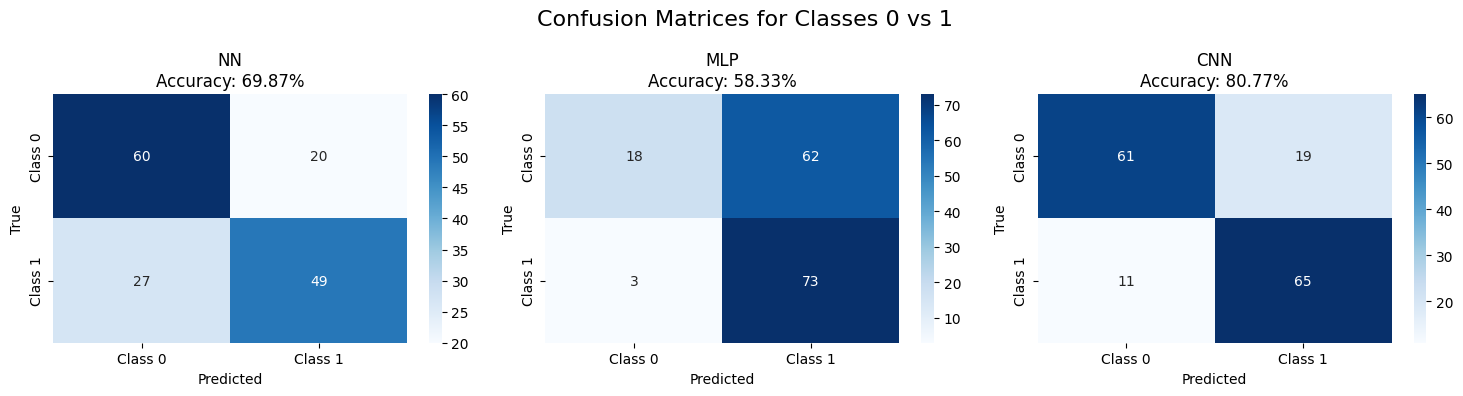


Evaluating models on classes: ['0', '2']
📃Train Dataset:
	Number of images in class 0: 308
	Number of images in class 1: 313
	Number of training samples: 621

📃Test Dataset:
	Number of images in class 0: 80
	Number of images in class 1: 76
	Number of testing samples: 156
📃Train Dataset:
	Number of images in class 0: 308
	Number of images in class 1: 313
	Number of training samples: 621

📃Test Dataset:
	Number of images in class 0: 80
	Number of images in class 1: 76
	Number of testing samples: 156

NN Results:
Accuracy: 76.92%
Classification Report:
              precision    recall  f1-score   support

     Class 0       0.77      0.79      0.78        80
     Class 2       0.77      0.75      0.76        76

    accuracy                           0.77       156
   macro avg       0.77      0.77      0.77       156
weighted avg       0.77      0.77      0.77       156


MLP Results:
Accuracy: 59.62%
Classification Report:
              precision    recall  f1-score   support

     Cl

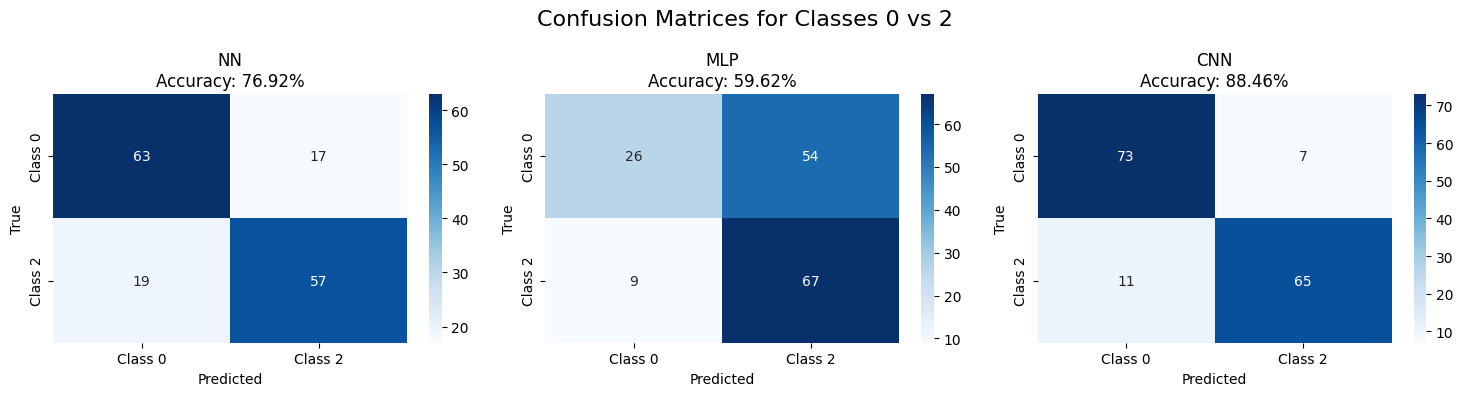


Evaluating models on classes: ['0', '3']
📃Train Dataset:
	Number of images in class 0: 314
	Number of images in class 1: 306
	Number of training samples: 620

📃Test Dataset:
	Number of images in class 0: 74
	Number of images in class 1: 82
	Number of testing samples: 156
📃Train Dataset:
	Number of images in class 0: 314
	Number of images in class 1: 306
	Number of training samples: 620

📃Test Dataset:
	Number of images in class 0: 74
	Number of images in class 1: 82
	Number of testing samples: 156

NN Results:
Accuracy: 76.28%
Classification Report:
              precision    recall  f1-score   support

     Class 0       0.68      0.95      0.79        74
     Class 3       0.92      0.60      0.73        82

    accuracy                           0.76       156
   macro avg       0.80      0.77      0.76       156
weighted avg       0.81      0.76      0.76       156


NN Results:
Accuracy: 76.28%
Classification Report:
              precision    recall  f1-score   support

     Cla

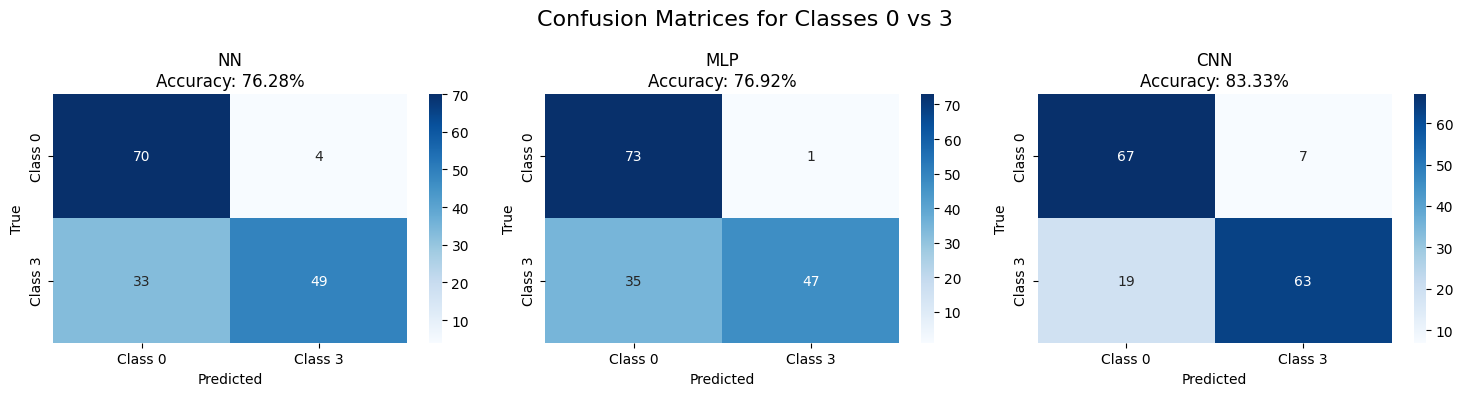


Evaluating models on classes: ['0', '4']
📃Train Dataset:
	Number of images in class 0: 314
	Number of images in class 1: 306
	Number of training samples: 620

📃Test Dataset:
	Number of images in class 0: 74
	Number of images in class 1: 82
	Number of testing samples: 156

NN Results:
Accuracy: 73.72%
Classification Report:
              precision    recall  f1-score   support

     Class 0       0.65      0.99      0.78        74
     Class 4       0.98      0.51      0.67        82

    accuracy                           0.74       156
   macro avg       0.81      0.75      0.73       156
weighted avg       0.82      0.74      0.72       156

📃Train Dataset:
	Number of images in class 0: 314
	Number of images in class 1: 306
	Number of training samples: 620

📃Test Dataset:
	Number of images in class 0: 74
	Number of images in class 1: 82
	Number of testing samples: 156

NN Results:
Accuracy: 73.72%
Classification Report:
              precision    recall  f1-score   support

     Cla

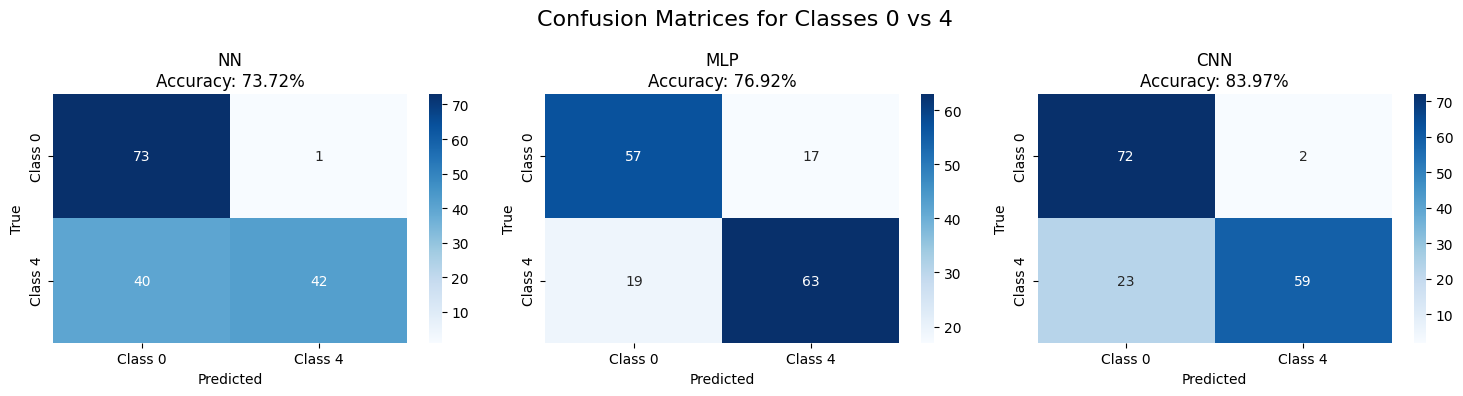


Evaluating models on classes: ['0', '5']
📃Train Dataset:
	Number of images in class 0: 314
	Number of images in class 1: 306
	Number of training samples: 620

📃Test Dataset:
	Number of images in class 0: 74
	Number of images in class 1: 82
	Number of testing samples: 156

NN Results:
Accuracy: 73.72%
Classification Report:
              precision    recall  f1-score   support

     Class 0       0.65      0.99      0.78        74
     Class 5       0.98      0.51      0.67        82

    accuracy                           0.74       156
   macro avg       0.81      0.75      0.73       156
weighted avg       0.82      0.74      0.72       156

📃Train Dataset:
	Number of images in class 0: 314
	Number of images in class 1: 306
	Number of training samples: 620

📃Test Dataset:
	Number of images in class 0: 74
	Number of images in class 1: 82
	Number of testing samples: 156

NN Results:
Accuracy: 73.72%
Classification Report:
              precision    recall  f1-score   support

     Cla

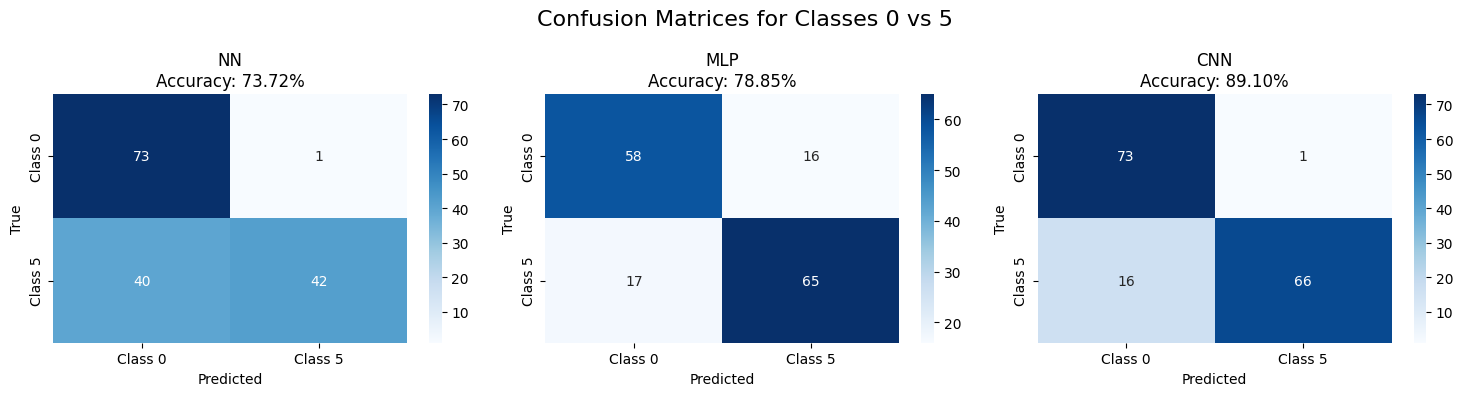


Evaluating models on classes: ['0', '6']
📃Train Dataset:
	Number of images in class 0: 314
	Number of images in class 1: 306
	Number of training samples: 620

📃Test Dataset:
	Number of images in class 0: 74
	Number of images in class 1: 82
	Number of testing samples: 156

NN Results:
Accuracy: 57.69%
Classification Report:
              precision    recall  f1-score   support

     Class 0       0.53      0.99      0.69        74
     Class 6       0.94      0.21      0.34        82

    accuracy                           0.58       156
   macro avg       0.74      0.60      0.51       156
weighted avg       0.75      0.58      0.51       156

📃Train Dataset:
	Number of images in class 0: 314
	Number of images in class 1: 306
	Number of training samples: 620

📃Test Dataset:
	Number of images in class 0: 74
	Number of images in class 1: 82
	Number of testing samples: 156

NN Results:
Accuracy: 57.69%
Classification Report:
              precision    recall  f1-score   support

     Cla

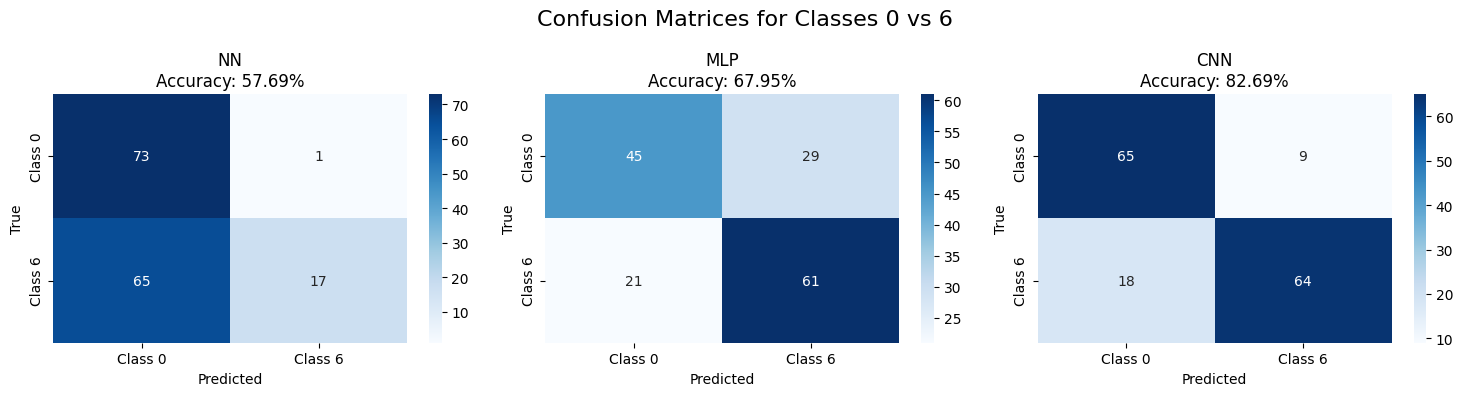


Evaluating models on classes: ['0', '7']
📃Train Dataset:
	Number of images in class 0: 314
	Number of images in class 1: 306
	Number of training samples: 620

📃Test Dataset:
	Number of images in class 0: 74
	Number of images in class 1: 82
	Number of testing samples: 156

NN Results:
Accuracy: 66.03%
Classification Report:
              precision    recall  f1-score   support

     Class 0       0.59      0.97      0.73        74
     Class 7       0.94      0.38      0.54        82

    accuracy                           0.66       156
   macro avg       0.76      0.68      0.64       156
weighted avg       0.77      0.66      0.63       156

📃Train Dataset:
	Number of images in class 0: 314
	Number of images in class 1: 306
	Number of training samples: 620

📃Test Dataset:
	Number of images in class 0: 74
	Number of images in class 1: 82
	Number of testing samples: 156

NN Results:
Accuracy: 66.03%
Classification Report:
              precision    recall  f1-score   support

     Cla

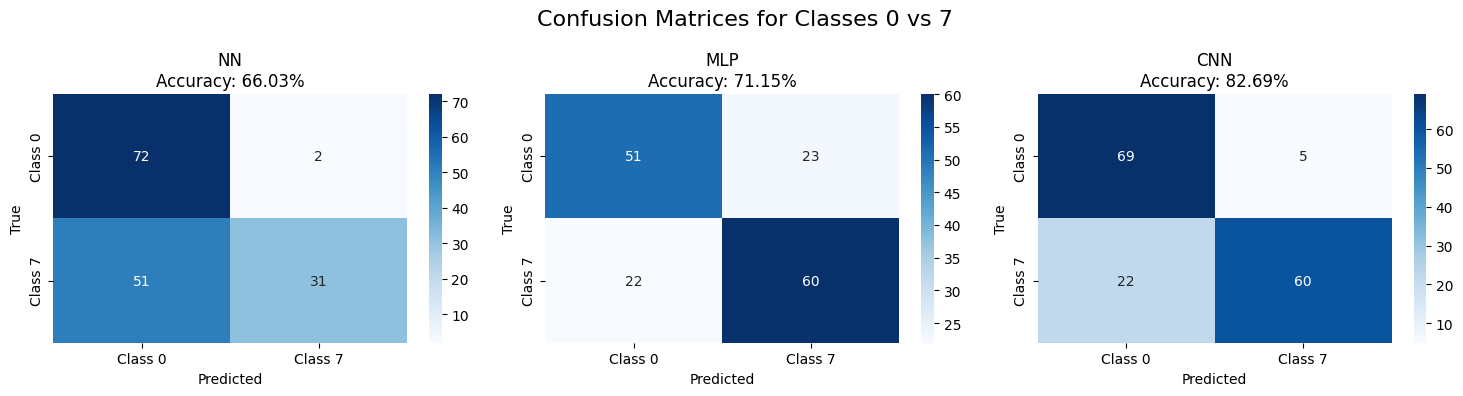


Evaluating models on classes: ['0', '8']
📃Train Dataset:
	Number of images in class 0: 314
	Number of images in class 1: 306
	Number of training samples: 620

📃Test Dataset:
	Number of images in class 0: 74
	Number of images in class 1: 82
	Number of testing samples: 156

NN Results:
Accuracy: 51.28%
Classification Report:
              precision    recall  f1-score   support

     Class 0       0.49      1.00      0.66        74
     Class 8       1.00      0.07      0.14        82

    accuracy                           0.51       156
   macro avg       0.75      0.54      0.40       156
weighted avg       0.76      0.51      0.39       156

📃Train Dataset:
	Number of images in class 0: 314
	Number of images in class 1: 306
	Number of training samples: 620

📃Test Dataset:
	Number of images in class 0: 74
	Number of images in class 1: 82
	Number of testing samples: 156

NN Results:
Accuracy: 51.28%
Classification Report:
              precision    recall  f1-score   support

     Cla

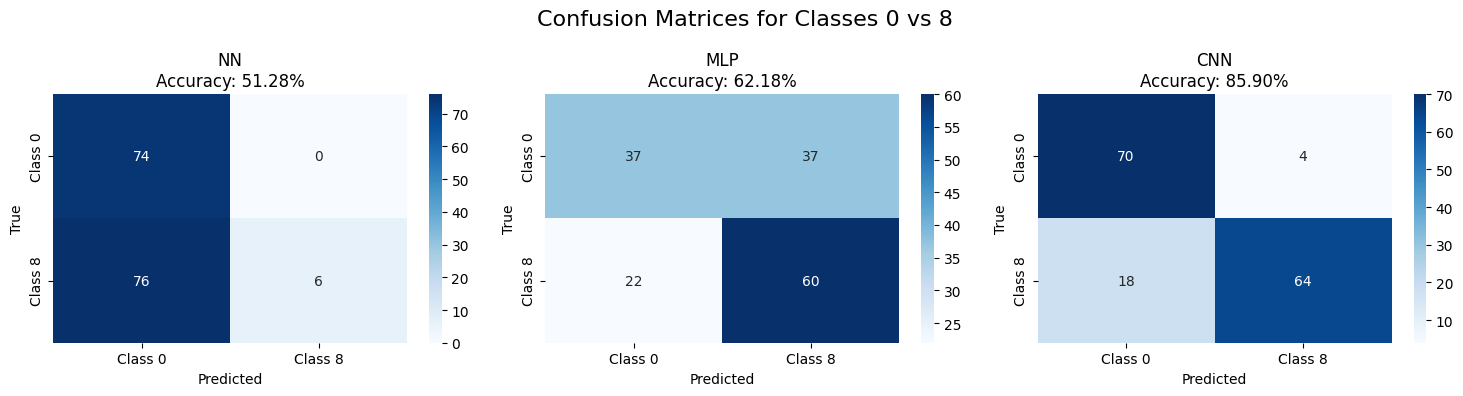


Evaluating models on classes: ['0', '9']
📃Train Dataset:
	Number of images in class 0: 314
	Number of images in class 1: 306
	Number of training samples: 620

📃Test Dataset:
	Number of images in class 0: 74
	Number of images in class 1: 82
	Number of testing samples: 156

NN Results:
Accuracy: 67.31%
Classification Report:
              precision    recall  f1-score   support

     Class 0       0.59      0.99      0.74        74
     Class 9       0.97      0.39      0.56        82

    accuracy                           0.67       156
   macro avg       0.78      0.69      0.65       156
weighted avg       0.79      0.67      0.64       156

📃Train Dataset:
	Number of images in class 0: 314
	Number of images in class 1: 306
	Number of training samples: 620

📃Test Dataset:
	Number of images in class 0: 74
	Number of images in class 1: 82
	Number of testing samples: 156

NN Results:
Accuracy: 67.31%
Classification Report:
              precision    recall  f1-score   support

     Cla

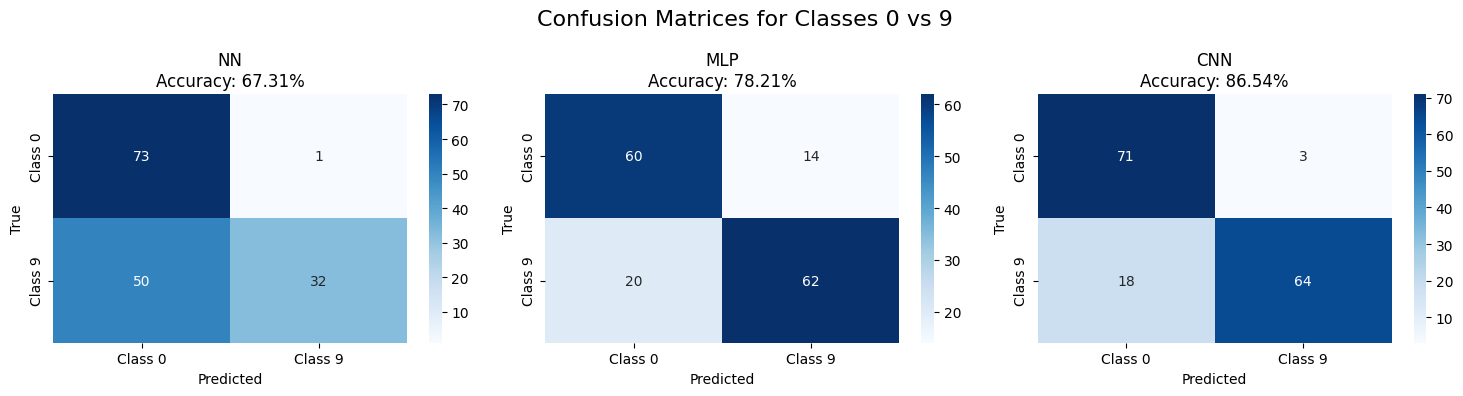


Evaluating models on classes: ['1', '2']
📃Train Dataset:
	Number of images in class 0: 319
	Number of images in class 1: 303
	Number of training samples: 622

📃Test Dataset:
	Number of images in class 0: 70
	Number of images in class 1: 86
	Number of testing samples: 156

NN Results:
Accuracy: 64.74%
Classification Report:
              precision    recall  f1-score   support

     Class 1       0.62      0.54      0.58        70
     Class 2       0.66      0.73      0.70        86

    accuracy                           0.65       156
   macro avg       0.64      0.64      0.64       156
weighted avg       0.65      0.65      0.64       156

📃Train Dataset:
	Number of images in class 0: 319
	Number of images in class 1: 303
	Number of training samples: 622

📃Test Dataset:
	Number of images in class 0: 70
	Number of images in class 1: 86
	Number of testing samples: 156

NN Results:
Accuracy: 64.74%
Classification Report:
              precision    recall  f1-score   support

     Cla

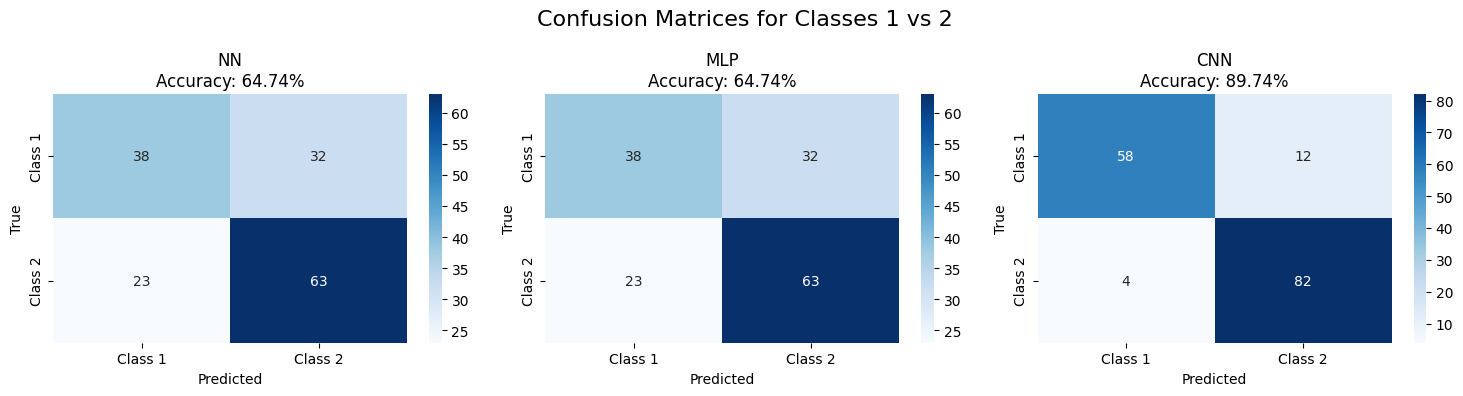


Evaluating models on classes: ['1', '3']
📃Train Dataset:
	Number of images in class 0: 309
	Number of images in class 1: 312
	Number of training samples: 621

📃Test Dataset:
	Number of images in class 0: 80
	Number of images in class 1: 76
	Number of testing samples: 156

NN Results:
Accuracy: 78.85%
Classification Report:
              precision    recall  f1-score   support

     Class 1       0.84      0.72      0.78        80
     Class 3       0.75      0.86      0.80        76

    accuracy                           0.79       156
   macro avg       0.79      0.79      0.79       156
weighted avg       0.80      0.79      0.79       156

📃Train Dataset:
	Number of images in class 0: 309
	Number of images in class 1: 312
	Number of training samples: 621

📃Test Dataset:
	Number of images in class 0: 80
	Number of images in class 1: 76
	Number of testing samples: 156

NN Results:
Accuracy: 78.85%
Classification Report:
              precision    recall  f1-score   support

     Cla

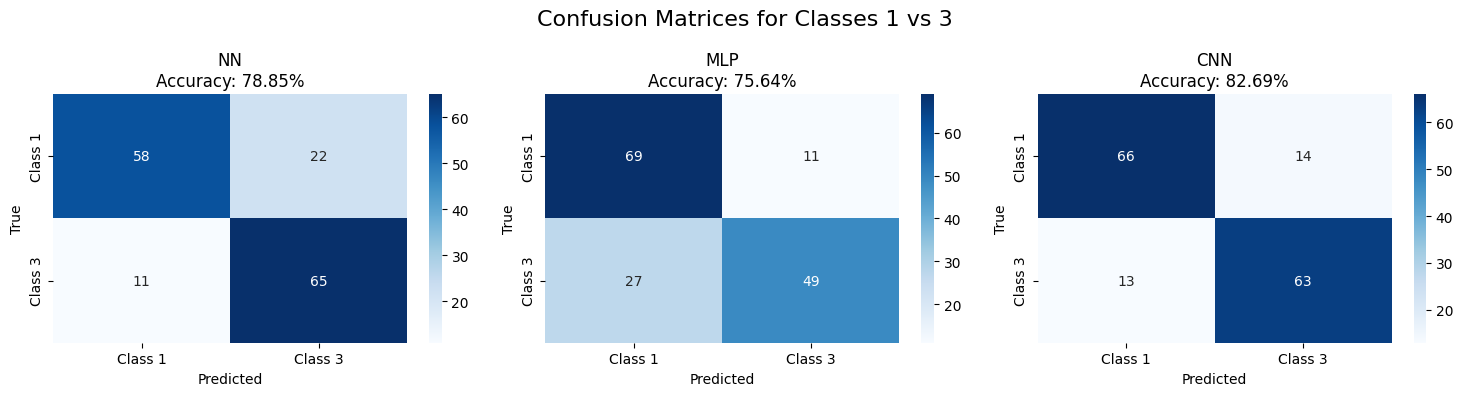


Evaluating models on classes: ['1', '4']
📃Train Dataset:
	Number of images in class 0: 309
	Number of images in class 1: 312
	Number of training samples: 621

📃Test Dataset:
	Number of images in class 0: 80
	Number of images in class 1: 76
	Number of testing samples: 156

NN Results:
Accuracy: 68.59%
Classification Report:
              precision    recall  f1-score   support

     Class 1       0.82      0.50      0.62        80
     Class 4       0.63      0.88      0.73        76

    accuracy                           0.69       156
   macro avg       0.72      0.69      0.68       156
weighted avg       0.72      0.69      0.67       156


MLP Results:
Accuracy: 69.87%
Classification Report:
              precision    recall  f1-score   support

     Class 1       0.65      0.88      0.75        80
     Class 4       0.80      0.51      0.62        76

    accuracy                           0.70       156
   macro avg       0.73      0.69      0.69       156
weighted avg       0.

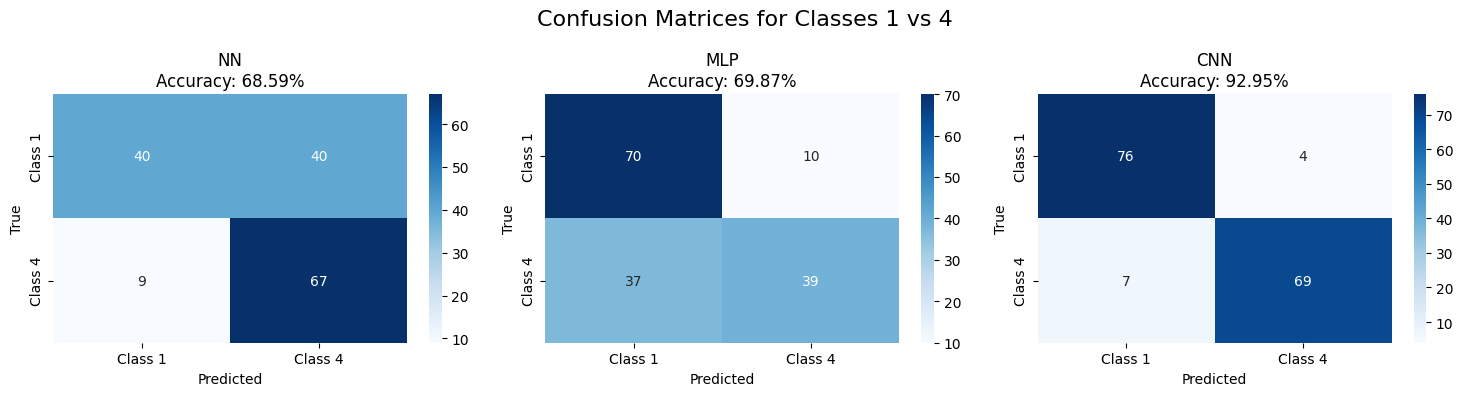


Evaluating models on classes: ['1', '5']
📃Train Dataset:
	Number of images in class 0: 309
	Number of images in class 1: 312
	Number of training samples: 621

📃Test Dataset:
	Number of images in class 0: 80
	Number of images in class 1: 76
	Number of testing samples: 156

NN Results:
Accuracy: 75.00%
Classification Report:
              precision    recall  f1-score   support

     Class 1       0.81      0.68      0.73        80
     Class 5       0.71      0.83      0.76        76

    accuracy                           0.75       156
   macro avg       0.76      0.75      0.75       156
weighted avg       0.76      0.75      0.75       156

📃Train Dataset:
	Number of images in class 0: 309
	Number of images in class 1: 312
	Number of training samples: 621

📃Test Dataset:
	Number of images in class 0: 80
	Number of images in class 1: 76
	Number of testing samples: 156

NN Results:
Accuracy: 75.00%
Classification Report:
              precision    recall  f1-score   support

     Cla

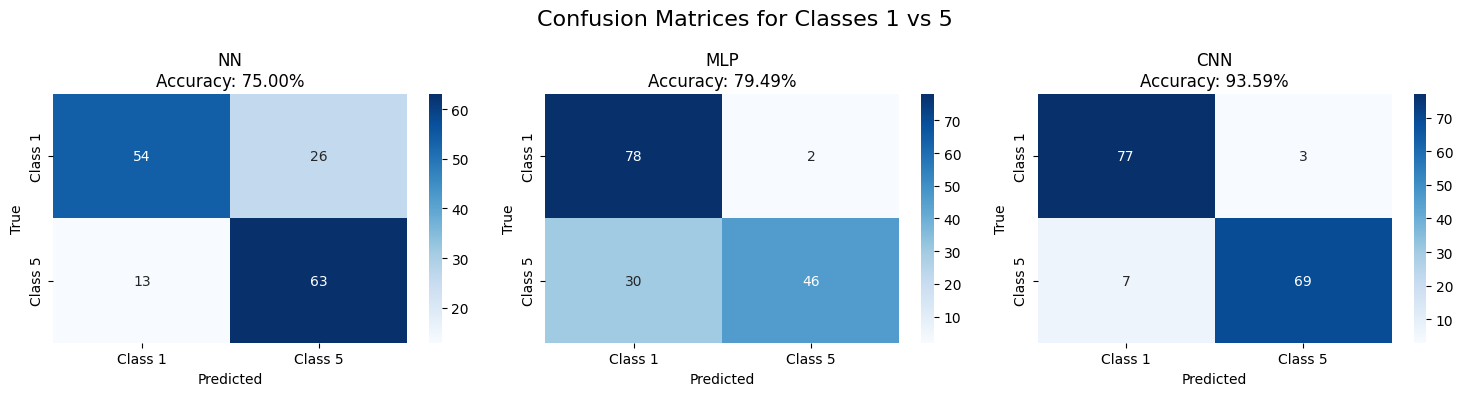


Evaluating models on classes: ['1', '6']
📃Train Dataset:
	Number of images in class 0: 309
	Number of images in class 1: 312
	Number of training samples: 621

📃Test Dataset:
	Number of images in class 0: 80
	Number of images in class 1: 76
	Number of testing samples: 156

NN Results:
Accuracy: 69.23%
Classification Report:
              precision    recall  f1-score   support

     Class 1       0.80      0.54      0.64        80
     Class 6       0.64      0.86      0.73        76

    accuracy                           0.69       156
   macro avg       0.72      0.70      0.69       156
weighted avg       0.72      0.69      0.68       156

📃Train Dataset:
	Number of images in class 0: 309
	Number of images in class 1: 312
	Number of training samples: 621

📃Test Dataset:
	Number of images in class 0: 80
	Number of images in class 1: 76
	Number of testing samples: 156

NN Results:
Accuracy: 69.23%
Classification Report:
              precision    recall  f1-score   support

     Cla

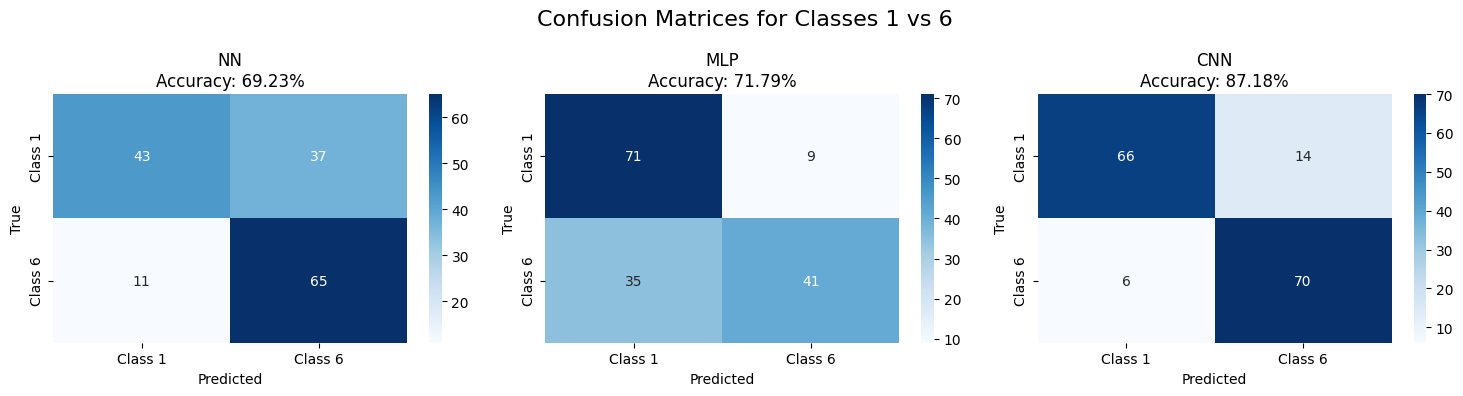


Evaluating models on classes: ['1', '7']
📃Train Dataset:
	Number of images in class 0: 309
	Number of images in class 1: 312
	Number of training samples: 621

📃Test Dataset:
	Number of images in class 0: 80
	Number of images in class 1: 76
	Number of testing samples: 156

NN Results:
Accuracy: 73.72%
Classification Report:
              precision    recall  f1-score   support

     Class 1       0.77      0.69      0.73        80
     Class 7       0.71      0.79      0.75        76

    accuracy                           0.74       156
   macro avg       0.74      0.74      0.74       156
weighted avg       0.74      0.74      0.74       156

📃Train Dataset:
	Number of images in class 0: 309
	Number of images in class 1: 312
	Number of training samples: 621

📃Test Dataset:
	Number of images in class 0: 80
	Number of images in class 1: 76
	Number of testing samples: 156

NN Results:
Accuracy: 73.72%
Classification Report:
              precision    recall  f1-score   support

     Cla

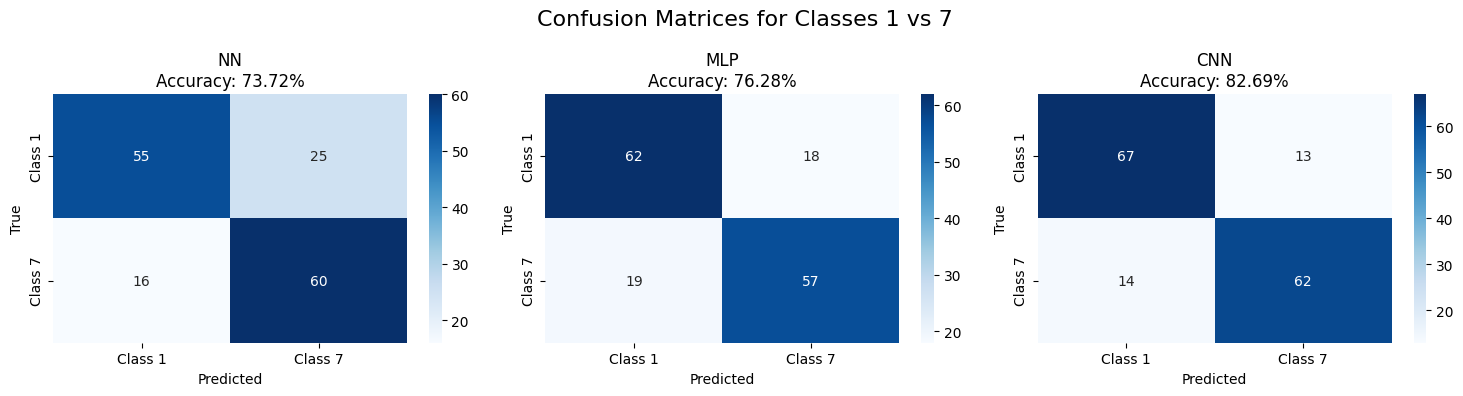


Evaluating models on classes: ['1', '8']
📃Train Dataset:
	Number of images in class 0: 309
	Number of images in class 1: 312
	Number of training samples: 621

📃Test Dataset:
	Number of images in class 0: 80
	Number of images in class 1: 76
	Number of testing samples: 156

NN Results:
Accuracy: 75.64%
Classification Report:
              precision    recall  f1-score   support

     Class 1       0.84      0.65      0.73        80
     Class 8       0.70      0.87      0.78        76

    accuracy                           0.76       156
   macro avg       0.77      0.76      0.75       156
weighted avg       0.77      0.76      0.75       156

📃Train Dataset:
	Number of images in class 0: 309
	Number of images in class 1: 312
	Number of training samples: 621

📃Test Dataset:
	Number of images in class 0: 80
	Number of images in class 1: 76
	Number of testing samples: 156

NN Results:
Accuracy: 75.64%
Classification Report:
              precision    recall  f1-score   support

     Cla

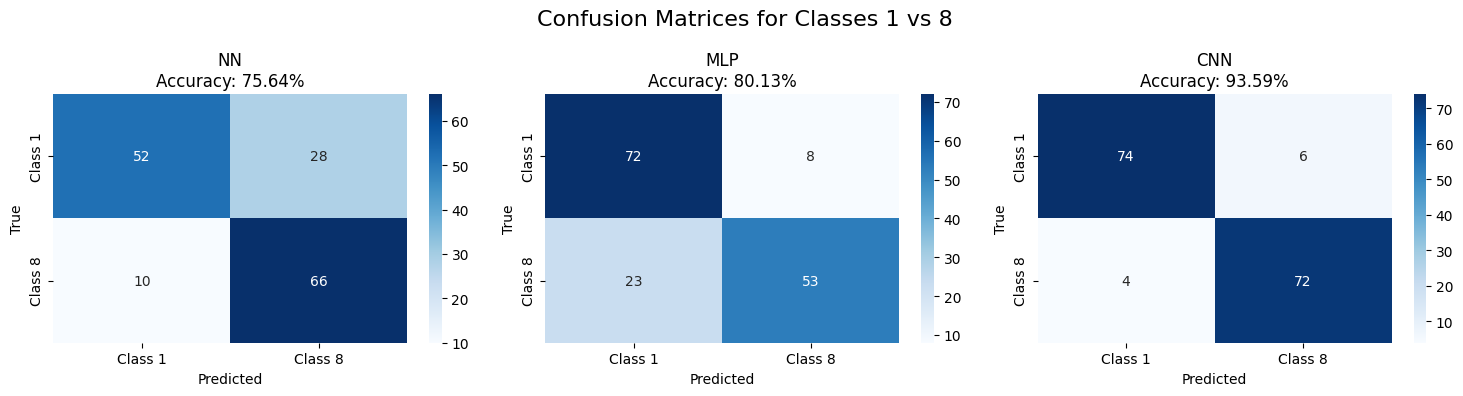


Evaluating models on classes: ['1', '9']
📃Train Dataset:
	Number of images in class 0: 309
	Number of images in class 1: 312
	Number of training samples: 621

📃Test Dataset:
	Number of images in class 0: 80
	Number of images in class 1: 76
	Number of testing samples: 156

NN Results:
Accuracy: 73.72%
Classification Report:
              precision    recall  f1-score   support

     Class 1       0.98      0.50      0.66        80
     Class 9       0.65      0.99      0.79        76

    accuracy                           0.74       156
   macro avg       0.81      0.74      0.72       156
weighted avg       0.82      0.74      0.72       156

📃Train Dataset:
	Number of images in class 0: 309
	Number of images in class 1: 312
	Number of training samples: 621

📃Test Dataset:
	Number of images in class 0: 80
	Number of images in class 1: 76
	Number of testing samples: 156

NN Results:
Accuracy: 73.72%
Classification Report:
              precision    recall  f1-score   support

     Cla

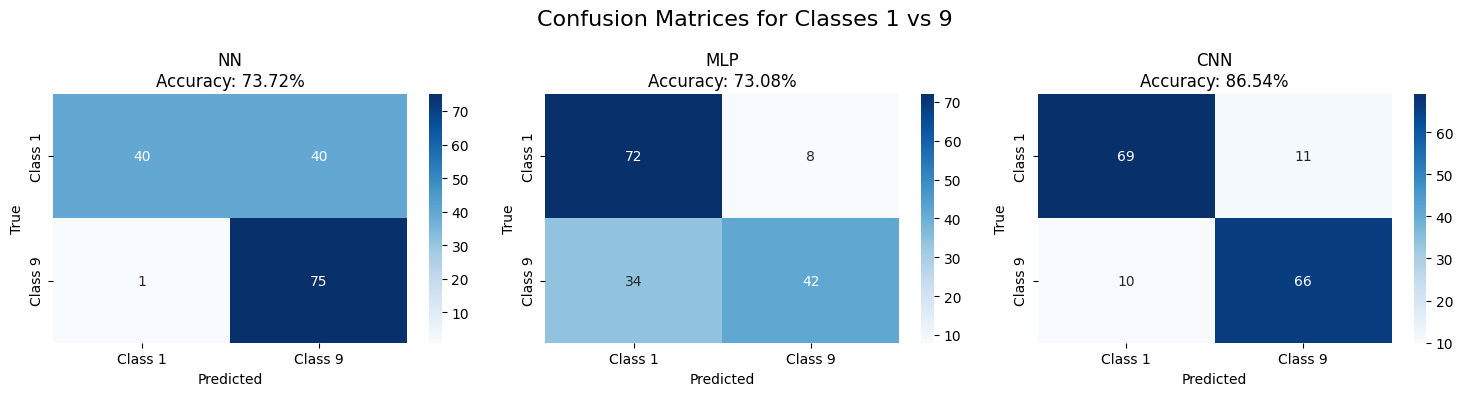


Evaluating models on classes: ['2', '3']
📃Train Dataset:
	Number of images in class 0: 309
	Number of images in class 1: 312
	Number of training samples: 621

📃Test Dataset:
	Number of images in class 0: 80
	Number of images in class 1: 76
	Number of testing samples: 156

NN Results:
Accuracy: 69.87%
Classification Report:
              precision    recall  f1-score   support

     Class 2       0.73      0.65      0.69        80
     Class 3       0.67      0.75      0.71        76

    accuracy                           0.70       156
   macro avg       0.70      0.70      0.70       156
weighted avg       0.70      0.70      0.70       156

📃Train Dataset:
	Number of images in class 0: 309
	Number of images in class 1: 312
	Number of training samples: 621

📃Test Dataset:
	Number of images in class 0: 80
	Number of images in class 1: 76
	Number of testing samples: 156

NN Results:
Accuracy: 69.87%
Classification Report:
              precision    recall  f1-score   support

     Cla

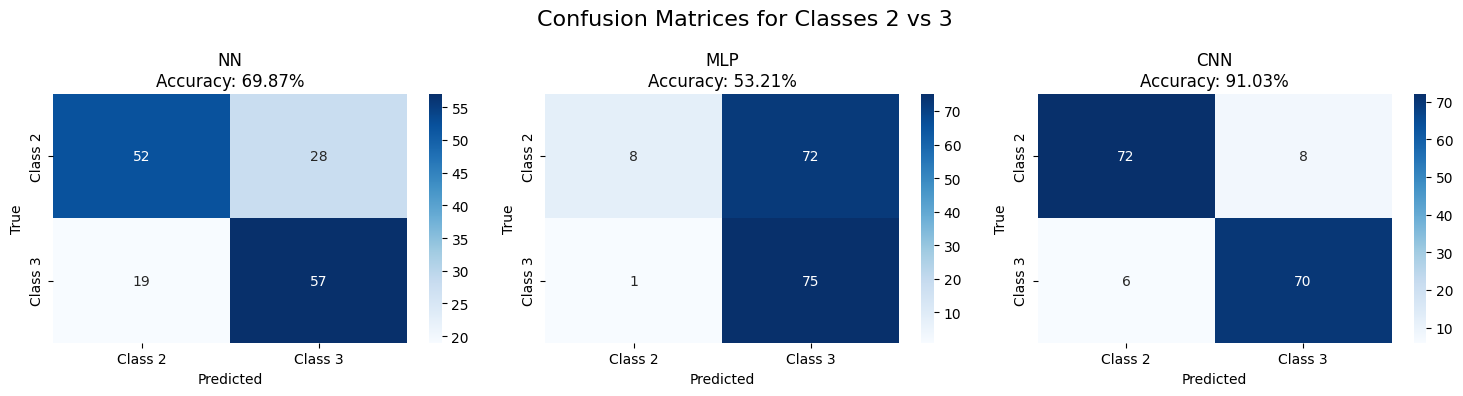


Evaluating models on classes: ['2', '4']
📃Train Dataset:
	Number of images in class 0: 309
	Number of images in class 1: 312
	Number of training samples: 621

📃Test Dataset:
	Number of images in class 0: 80
	Number of images in class 1: 76
	Number of testing samples: 156

NN Results:
Accuracy: 82.05%
Classification Report:
              precision    recall  f1-score   support

     Class 2       0.88      0.75      0.81        80
     Class 4       0.77      0.89      0.83        76

    accuracy                           0.82       156
   macro avg       0.83      0.82      0.82       156
weighted avg       0.83      0.82      0.82       156


MLP Results:
Accuracy: 84.62%
Classification Report:
              precision    recall  f1-score   support

     Class 2       0.79      0.95      0.86        80
     Class 4       0.93      0.74      0.82        76

    accuracy                           0.85       156
   macro avg       0.86      0.84      0.84       156
weighted avg       0.

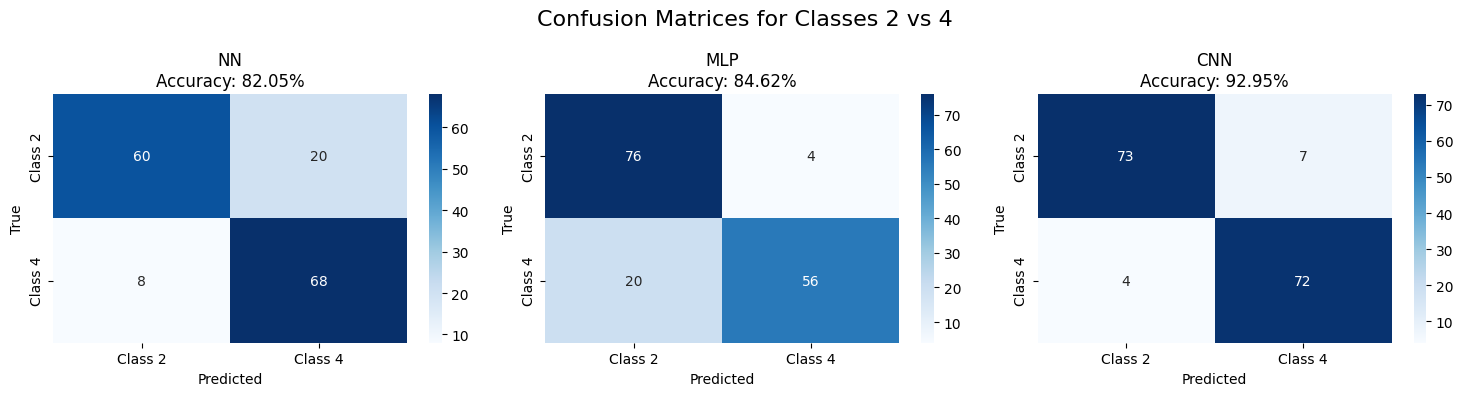


Evaluating models on classes: ['2', '5']
📃Train Dataset:
	Number of images in class 0: 309
	Number of images in class 1: 312
	Number of training samples: 621

📃Test Dataset:
	Number of images in class 0: 80
	Number of images in class 1: 76
	Number of testing samples: 156

NN Results:
Accuracy: 80.13%
Classification Report:
              precision    recall  f1-score   support

     Class 2       0.86      0.74      0.79        80
     Class 5       0.76      0.87      0.81        76

    accuracy                           0.80       156
   macro avg       0.81      0.80      0.80       156
weighted avg       0.81      0.80      0.80       156

📃Train Dataset:
	Number of images in class 0: 309
	Number of images in class 1: 312
	Number of training samples: 621

📃Test Dataset:
	Number of images in class 0: 80
	Number of images in class 1: 76
	Number of testing samples: 156

NN Results:
Accuracy: 80.13%
Classification Report:
              precision    recall  f1-score   support

     Cla

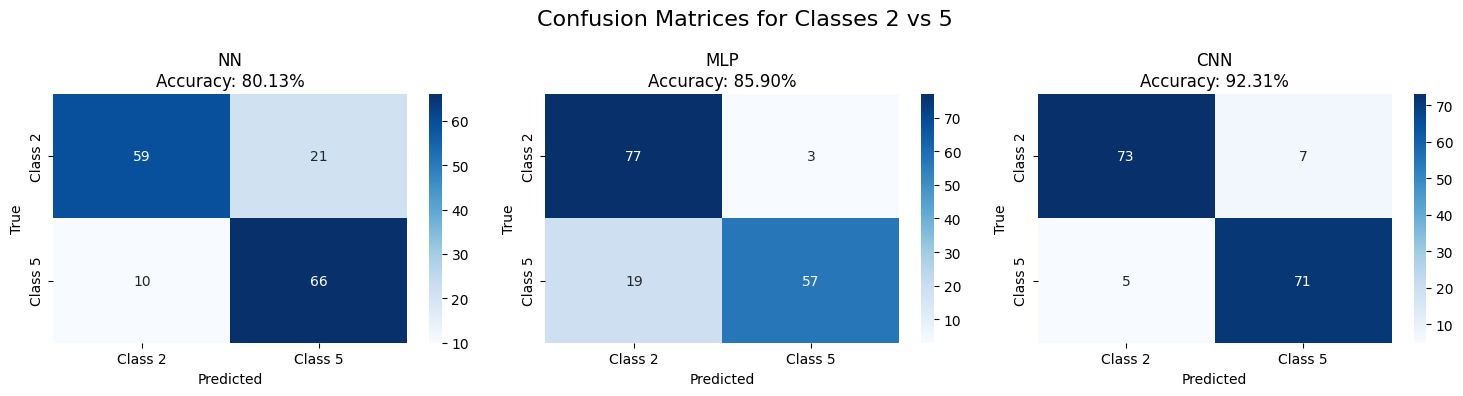


Evaluating models on classes: ['2', '6']
📃Train Dataset:
	Number of images in class 0: 309
	Number of images in class 1: 312
	Number of training samples: 621

📃Test Dataset:
	Number of images in class 0: 80
	Number of images in class 1: 76
	Number of testing samples: 156

NN Results:
Accuracy: 82.69%
Classification Report:
              precision    recall  f1-score   support

     Class 2       0.92      0.72      0.81        80
     Class 6       0.76      0.93      0.84        76

    accuracy                           0.83       156
   macro avg       0.84      0.83      0.83       156
weighted avg       0.84      0.83      0.83       156


MLP Results:
Accuracy: 76.92%
Classification Report:
              precision    recall  f1-score   support

     Class 2       0.73      0.86      0.79        80
     Class 6       0.82      0.67      0.74        76

    accuracy                           0.77       156
   macro avg       0.78      0.77      0.77       156
weighted avg       0.

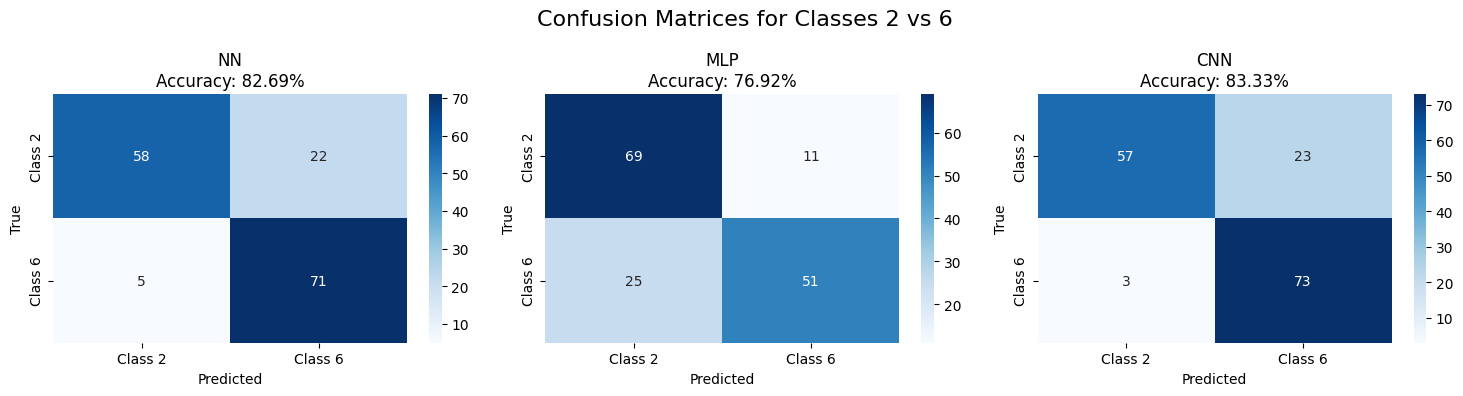


Evaluating models on classes: ['2', '7']
📃Train Dataset:
	Number of images in class 0: 309
	Number of images in class 1: 312
	Number of training samples: 621

📃Test Dataset:
	Number of images in class 0: 80
	Number of images in class 1: 76
	Number of testing samples: 156

NN Results:
Accuracy: 82.69%
Classification Report:
              precision    recall  f1-score   support

     Class 2       0.87      0.78      0.82        80
     Class 7       0.79      0.88      0.83        76

    accuracy                           0.83       156
   macro avg       0.83      0.83      0.83       156
weighted avg       0.83      0.83      0.83       156

📃Train Dataset:
	Number of images in class 0: 309
	Number of images in class 1: 312
	Number of training samples: 621

📃Test Dataset:
	Number of images in class 0: 80
	Number of images in class 1: 76
	Number of testing samples: 156

NN Results:
Accuracy: 82.69%
Classification Report:
              precision    recall  f1-score   support

     Cla

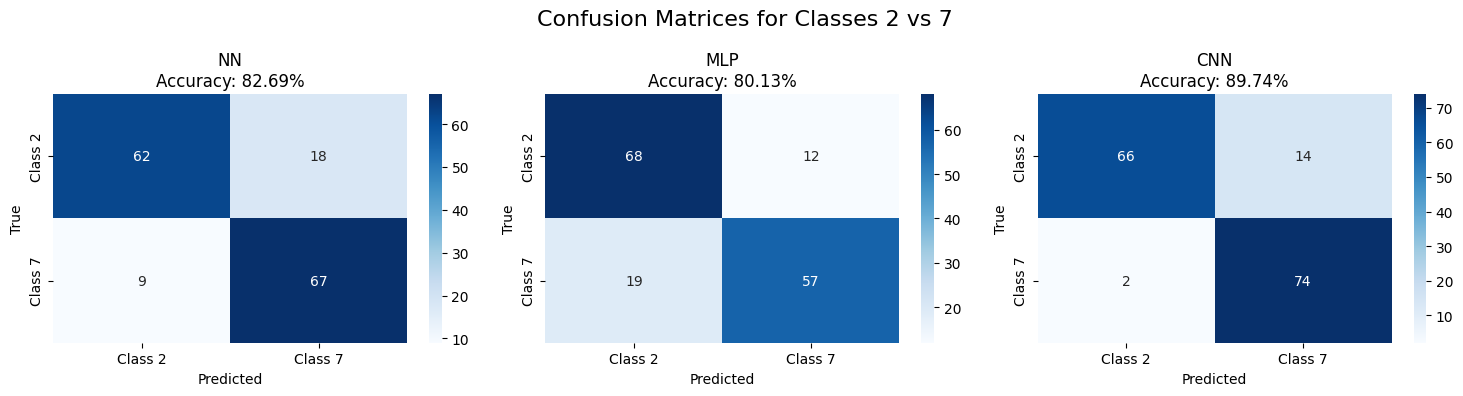


Evaluating models on classes: ['2', '8']
📃Train Dataset:
	Number of images in class 0: 309
	Number of images in class 1: 312
	Number of training samples: 621

📃Test Dataset:
	Number of images in class 0: 80
	Number of images in class 1: 76
	Number of testing samples: 156

NN Results:
Accuracy: 83.33%
Classification Report:
              precision    recall  f1-score   support

     Class 2       0.89      0.78      0.83        80
     Class 8       0.79      0.89      0.84        76

    accuracy                           0.83       156
   macro avg       0.84      0.83      0.83       156
weighted avg       0.84      0.83      0.83       156

📃Train Dataset:
	Number of images in class 0: 309
	Number of images in class 1: 312
	Number of training samples: 621

📃Test Dataset:
	Number of images in class 0: 80
	Number of images in class 1: 76
	Number of testing samples: 156

NN Results:
Accuracy: 83.33%
Classification Report:
              precision    recall  f1-score   support

     Cla

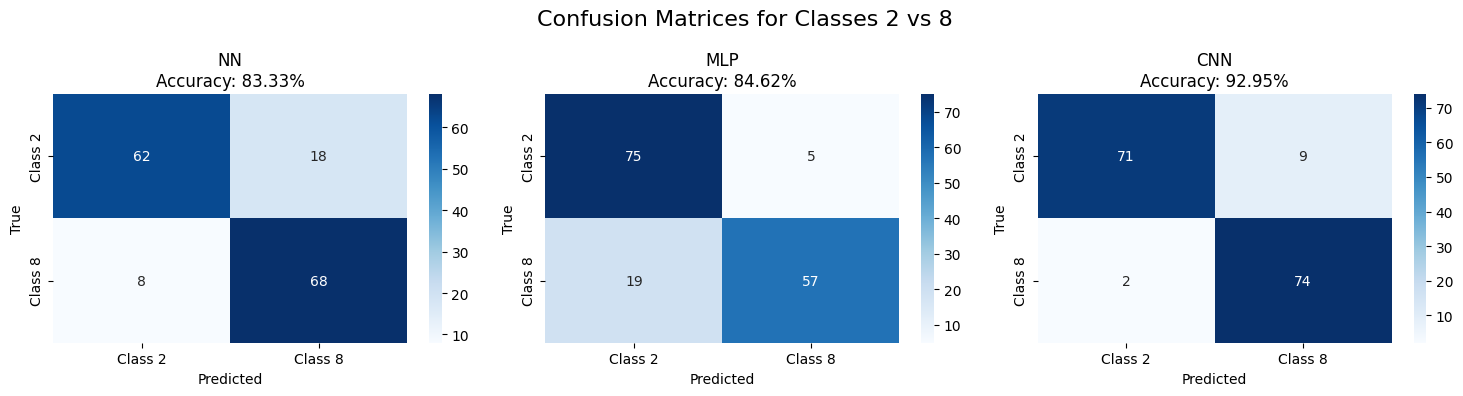


Evaluating models on classes: ['2', '9']
📃Train Dataset:
	Number of images in class 0: 309
	Number of images in class 1: 312
	Number of training samples: 621

📃Test Dataset:
	Number of images in class 0: 80
	Number of images in class 1: 76
	Number of testing samples: 156

NN Results:
Accuracy: 78.21%
Classification Report:
              precision    recall  f1-score   support

     Class 2       0.91      0.64      0.75        80
     Class 9       0.71      0.93      0.81        76

    accuracy                           0.78       156
   macro avg       0.81      0.79      0.78       156
weighted avg       0.81      0.78      0.78       156

📃Train Dataset:
	Number of images in class 0: 309
	Number of images in class 1: 312
	Number of training samples: 621

📃Test Dataset:
	Number of images in class 0: 80
	Number of images in class 1: 76
	Number of testing samples: 156

NN Results:
Accuracy: 78.21%
Classification Report:
              precision    recall  f1-score   support

     Cla

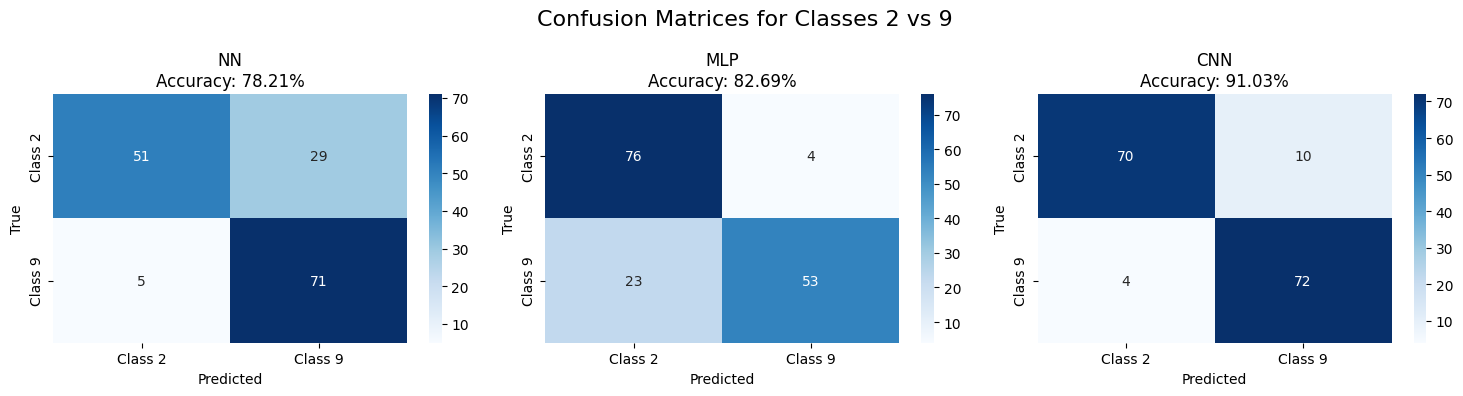


Evaluating models on classes: ['3', '4']
📃Train Dataset:
	Number of images in class 0: 314
	Number of images in class 1: 306
	Number of training samples: 620

📃Test Dataset:
	Number of images in class 0: 74
	Number of images in class 1: 82
	Number of testing samples: 156

NN Results:
Accuracy: 75.00%
Classification Report:
              precision    recall  f1-score   support

     Class 3       0.72      0.77      0.75        74
     Class 4       0.78      0.73      0.75        82

    accuracy                           0.75       156
   macro avg       0.75      0.75      0.75       156
weighted avg       0.75      0.75      0.75       156

📃Train Dataset:
	Number of images in class 0: 314
	Number of images in class 1: 306
	Number of training samples: 620

📃Test Dataset:
	Number of images in class 0: 74
	Number of images in class 1: 82
	Number of testing samples: 156

NN Results:
Accuracy: 75.00%
Classification Report:
              precision    recall  f1-score   support

     Cla

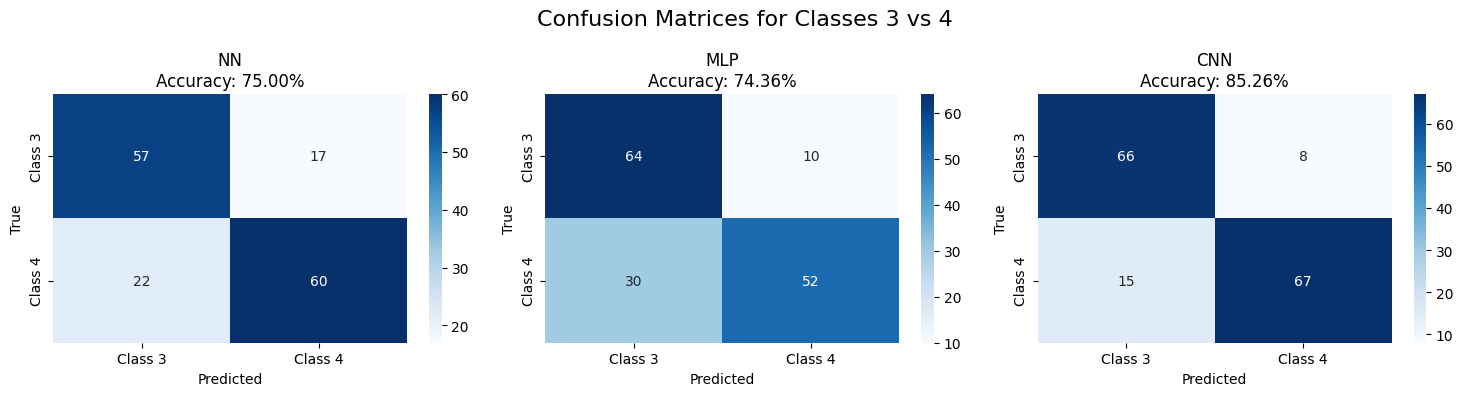


Evaluating models on classes: ['3', '5']
📃Train Dataset:
	Number of images in class 0: 314
	Number of images in class 1: 306
	Number of training samples: 620

📃Test Dataset:
	Number of images in class 0: 74
	Number of images in class 1: 82
	Number of testing samples: 156

NN Results:
Accuracy: 71.79%
Classification Report:
              precision    recall  f1-score   support

     Class 3       0.63      0.96      0.76        74
     Class 5       0.93      0.50      0.65        82

    accuracy                           0.72       156
   macro avg       0.78      0.73      0.71       156
weighted avg       0.79      0.72      0.70       156


MLP Results:
Accuracy: 80.77%
Classification Report:
              precision    recall  f1-score   support

     Class 3       0.78      0.84      0.81        74
     Class 5       0.84      0.78      0.81        82

    accuracy                           0.81       156
   macro avg       0.81      0.81      0.81       156
weighted avg       0.

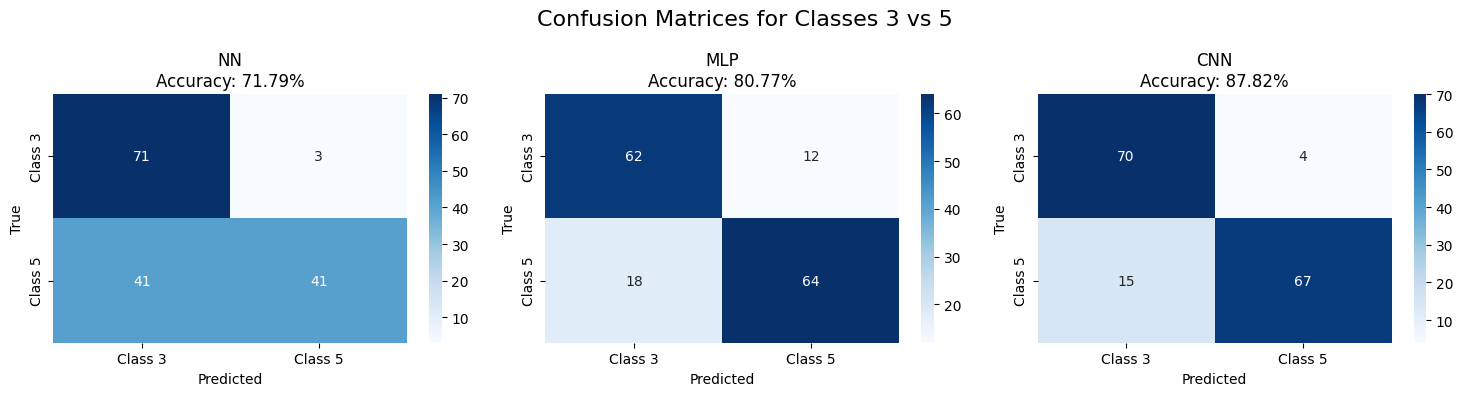


Evaluating models on classes: ['3', '6']
📃Train Dataset:
	Number of images in class 0: 314
	Number of images in class 1: 306
	Number of training samples: 620

📃Test Dataset:
	Number of images in class 0: 74
	Number of images in class 1: 82
	Number of testing samples: 156

NN Results:
Accuracy: 71.15%
Classification Report:
              precision    recall  f1-score   support

     Class 3       0.63      0.95      0.76        74
     Class 6       0.91      0.50      0.65        82

    accuracy                           0.71       156
   macro avg       0.77      0.72      0.70       156
weighted avg       0.78      0.71      0.70       156

📃Train Dataset:
	Number of images in class 0: 314
	Number of images in class 1: 306
	Number of training samples: 620

📃Test Dataset:
	Number of images in class 0: 74
	Number of images in class 1: 82
	Number of testing samples: 156

NN Results:
Accuracy: 71.15%
Classification Report:
              precision    recall  f1-score   support

     Cla

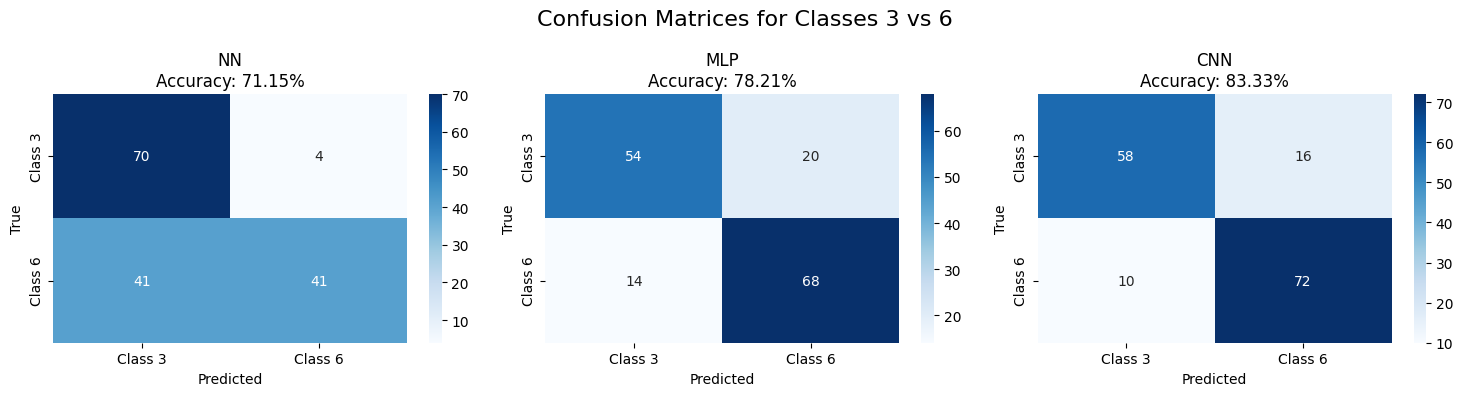


Evaluating models on classes: ['3', '7']
📃Train Dataset:
	Number of images in class 0: 314
	Number of images in class 1: 306
	Number of training samples: 620

📃Test Dataset:
	Number of images in class 0: 74
	Number of images in class 1: 82
	Number of testing samples: 156

NN Results:
Accuracy: 63.46%
Classification Report:
              precision    recall  f1-score   support

     Class 3       0.57      0.93      0.71        74
     Class 7       0.86      0.37      0.51        82

    accuracy                           0.63       156
   macro avg       0.71      0.65      0.61       156
weighted avg       0.72      0.63      0.61       156


MLP Results:
Accuracy: 73.08%
Classification Report:
              precision    recall  f1-score   support

     Class 3       0.72      0.70      0.71        74
     Class 7       0.74      0.76      0.75        82

    accuracy                           0.73       156
   macro avg       0.73      0.73      0.73       156
weighted avg       0.

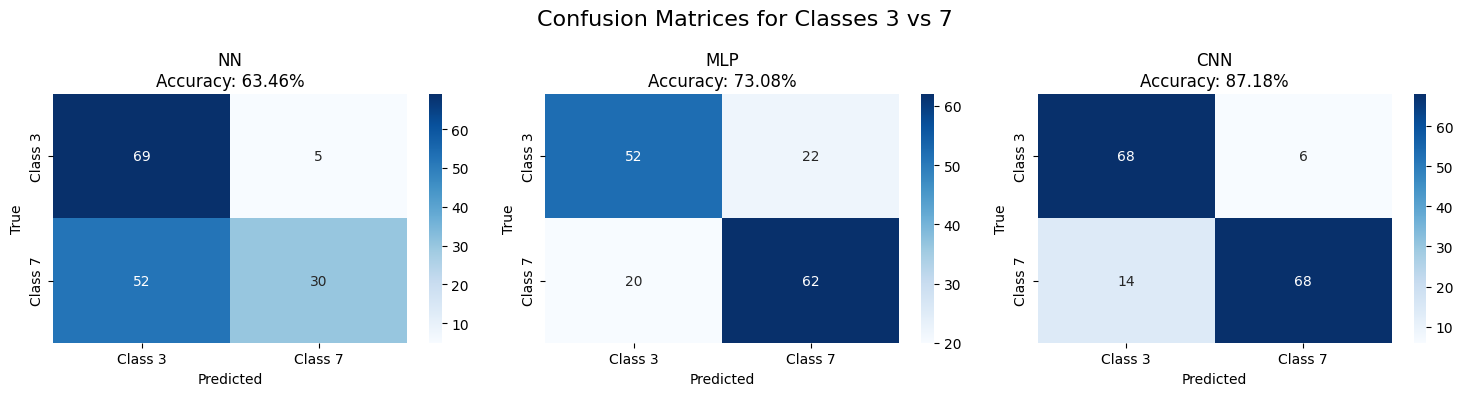


Evaluating models on classes: ['3', '8']
📃Train Dataset:
	Number of images in class 0: 314
	Number of images in class 1: 306
	Number of training samples: 620

📃Test Dataset:
	Number of images in class 0: 74
	Number of images in class 1: 82
	Number of testing samples: 156

NN Results:
Accuracy: 67.95%
Classification Report:
              precision    recall  f1-score   support

     Class 3       0.61      0.93      0.73        74
     Class 8       0.88      0.45      0.60        82

    accuracy                           0.68       156
   macro avg       0.74      0.69      0.67       156
weighted avg       0.75      0.68      0.66       156

📃Train Dataset:
	Number of images in class 0: 314
	Number of images in class 1: 306
	Number of training samples: 620

📃Test Dataset:
	Number of images in class 0: 74
	Number of images in class 1: 82
	Number of testing samples: 156

NN Results:
Accuracy: 67.95%
Classification Report:
              precision    recall  f1-score   support

     Cla

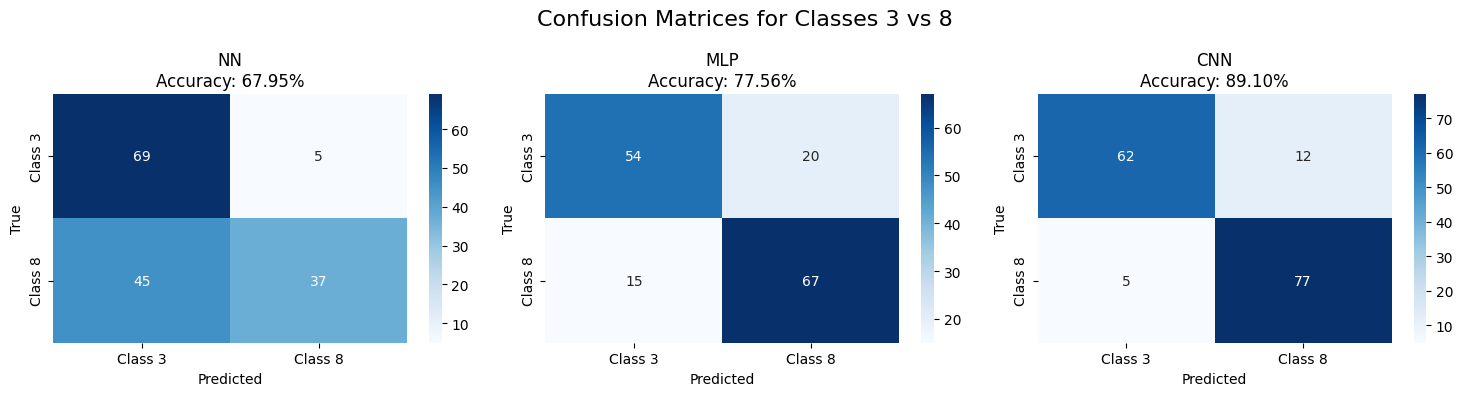


Evaluating models on classes: ['3', '9']
📃Train Dataset:
	Number of images in class 0: 314
	Number of images in class 1: 306
	Number of training samples: 620

📃Test Dataset:
	Number of images in class 0: 74
	Number of images in class 1: 82
	Number of testing samples: 156

NN Results:
Accuracy: 52.56%
Classification Report:
              precision    recall  f1-score   support

     Class 3       0.50      0.95      0.65        74
     Class 9       0.75      0.15      0.24        82

    accuracy                           0.53       156
   macro avg       0.62      0.55      0.45       156
weighted avg       0.63      0.53      0.44       156

📃Train Dataset:
	Number of images in class 0: 314
	Number of images in class 1: 306
	Number of training samples: 620

📃Test Dataset:
	Number of images in class 0: 74
	Number of images in class 1: 82
	Number of testing samples: 156

NN Results:
Accuracy: 52.56%
Classification Report:
              precision    recall  f1-score   support

     Cla

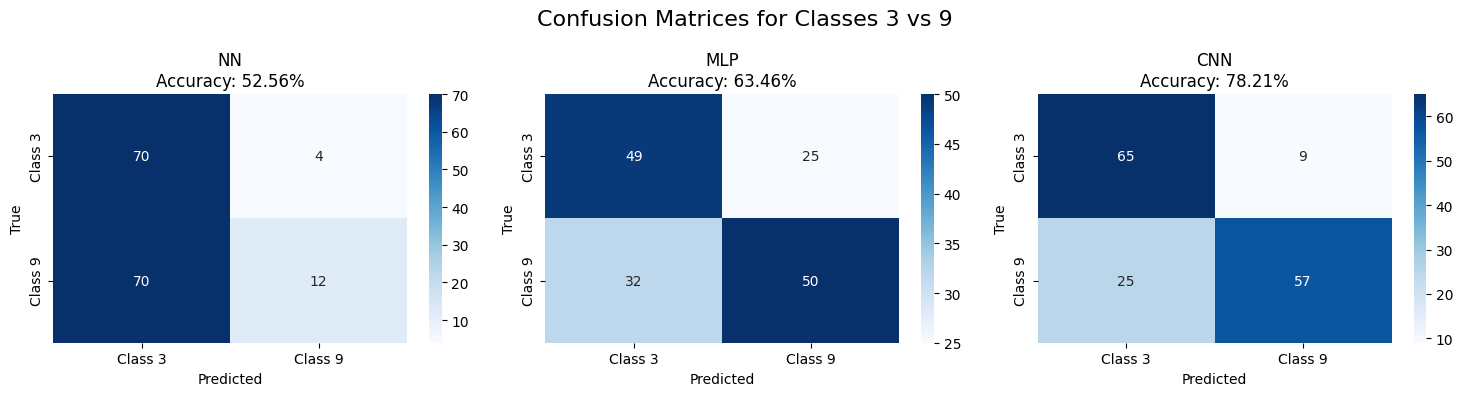


Evaluating models on classes: ['4', '5']
📃Train Dataset:
	Number of images in class 0: 314
	Number of images in class 1: 306
	Number of training samples: 620

📃Test Dataset:
	Number of images in class 0: 74
	Number of images in class 1: 82
	Number of testing samples: 156

NN Results:
Accuracy: 55.77%
Classification Report:
              precision    recall  f1-score   support

     Class 4       0.52      0.99      0.68        74
     Class 5       0.93      0.17      0.29        82

    accuracy                           0.56       156
   macro avg       0.73      0.58      0.48       156
weighted avg       0.74      0.56      0.47       156


MLP Results:
Accuracy: 60.90%
Classification Report:
              precision    recall  f1-score   support

     Class 4       0.58      0.66      0.62        74
     Class 5       0.65      0.56      0.60        82

    accuracy                           0.61       156
   macro avg       0.61      0.61      0.61       156
weighted avg       0.

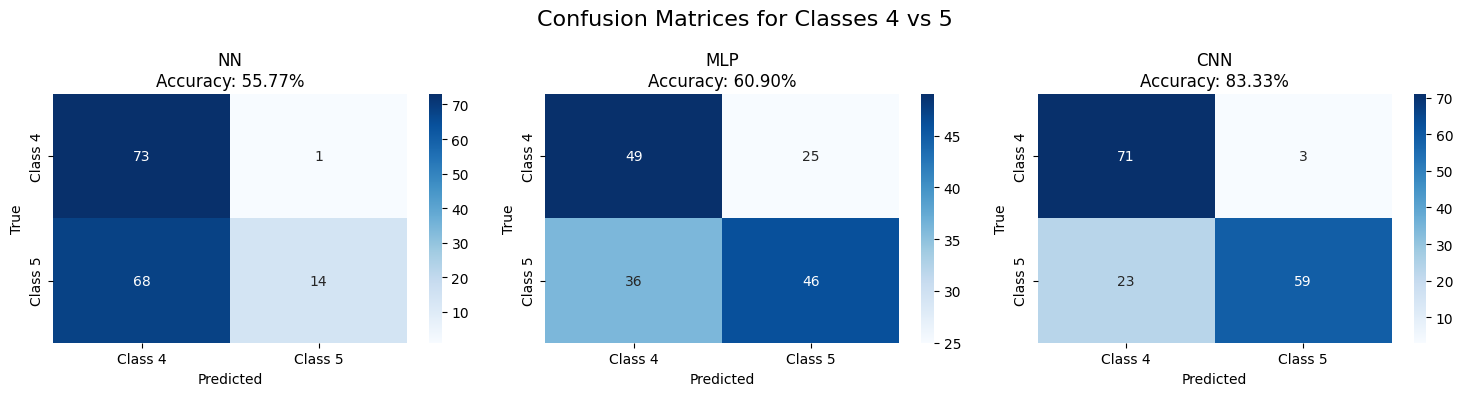


Evaluating models on classes: ['4', '6']
📃Train Dataset:
	Number of images in class 0: 314
	Number of images in class 1: 306
	Number of training samples: 620

📃Test Dataset:
	Number of images in class 0: 74
	Number of images in class 1: 82
	Number of testing samples: 156

NN Results:
Accuracy: 64.10%
Classification Report:
              precision    recall  f1-score   support

     Class 4       0.58      0.84      0.69        74
     Class 6       0.76      0.46      0.58        82

    accuracy                           0.64       156
   macro avg       0.67      0.65      0.63       156
weighted avg       0.68      0.64      0.63       156

📃Train Dataset:
	Number of images in class 0: 314
	Number of images in class 1: 306
	Number of training samples: 620

📃Test Dataset:
	Number of images in class 0: 74
	Number of images in class 1: 82
	Number of testing samples: 156

NN Results:
Accuracy: 64.10%
Classification Report:
              precision    recall  f1-score   support

     Cla

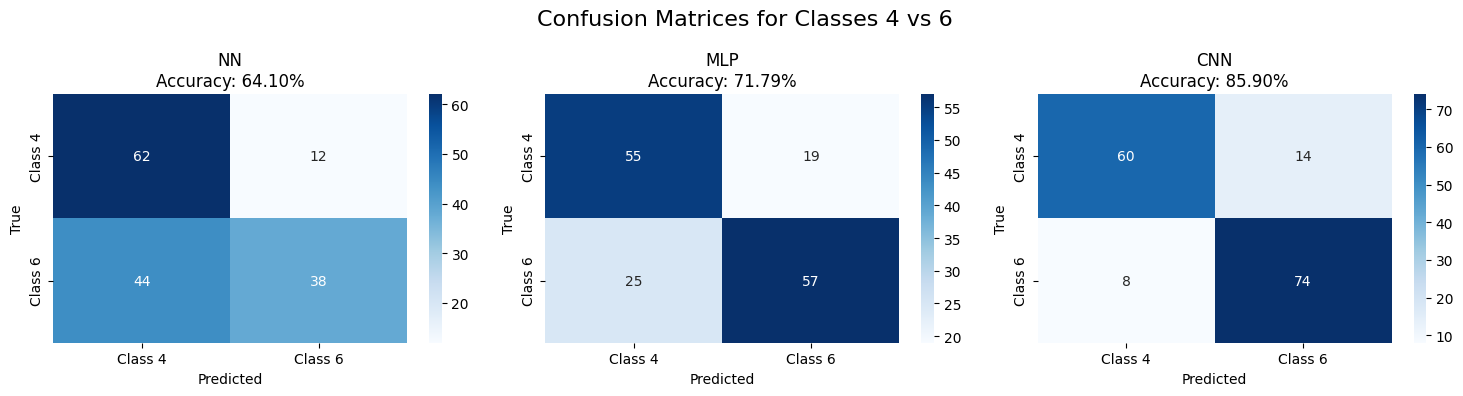


Evaluating models on classes: ['4', '7']
📃Train Dataset:
	Number of images in class 0: 314
	Number of images in class 1: 306
	Number of training samples: 620

📃Test Dataset:
	Number of images in class 0: 74
	Number of images in class 1: 82
	Number of testing samples: 156

NN Results:
Accuracy: 63.46%
Classification Report:
              precision    recall  f1-score   support

     Class 4       0.57      0.92      0.70        74
     Class 7       0.84      0.38      0.52        82

    accuracy                           0.63       156
   macro avg       0.70      0.65      0.61       156
weighted avg       0.71      0.63      0.61       156

📃Train Dataset:
	Number of images in class 0: 314
	Number of images in class 1: 306
	Number of training samples: 620

📃Test Dataset:
	Number of images in class 0: 74
	Number of images in class 1: 82
	Number of testing samples: 156

NN Results:
Accuracy: 63.46%
Classification Report:
              precision    recall  f1-score   support

     Cla

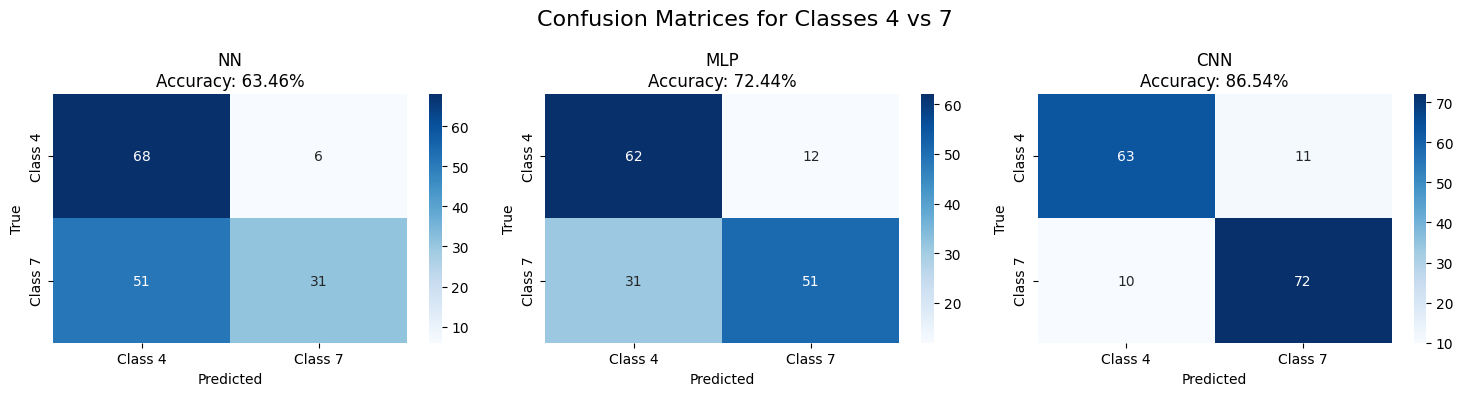


Evaluating models on classes: ['4', '8']
📃Train Dataset:
	Number of images in class 0: 314
	Number of images in class 1: 306
	Number of training samples: 620

📃Test Dataset:
	Number of images in class 0: 74
	Number of images in class 1: 82
	Number of testing samples: 156

NN Results:
Accuracy: 64.74%
Classification Report:
              precision    recall  f1-score   support

     Class 4       0.58      0.93      0.72        74
     Class 8       0.86      0.39      0.54        82

    accuracy                           0.65       156
   macro avg       0.72      0.66      0.63       156
weighted avg       0.73      0.65      0.62       156

📃Train Dataset:
	Number of images in class 0: 314
	Number of images in class 1: 306
	Number of training samples: 620

📃Test Dataset:
	Number of images in class 0: 74
	Number of images in class 1: 82
	Number of testing samples: 156

NN Results:
Accuracy: 64.74%
Classification Report:
              precision    recall  f1-score   support

     Cla

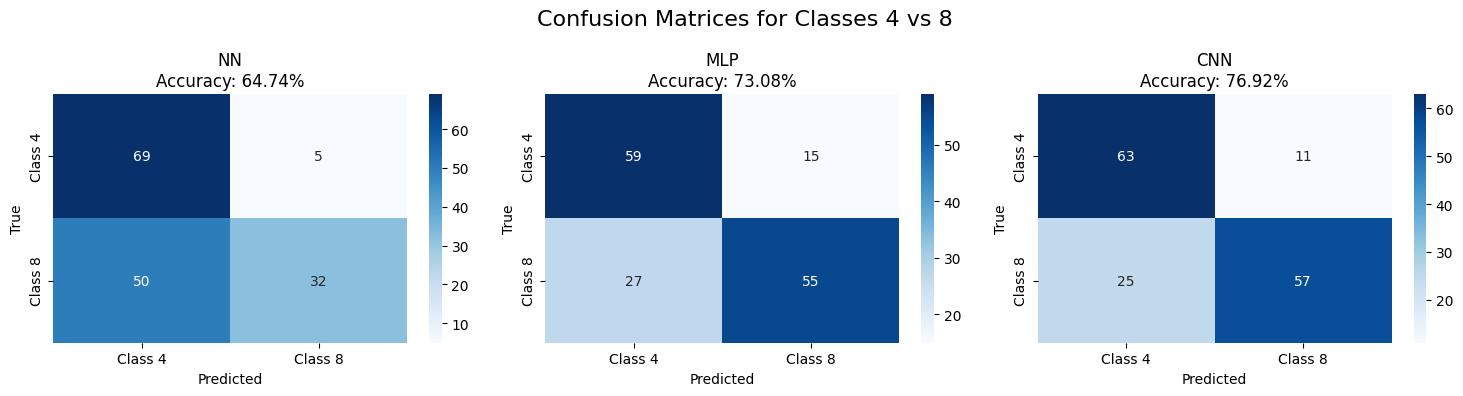


Evaluating models on classes: ['4', '9']
📃Train Dataset:
	Number of images in class 0: 314
	Number of images in class 1: 306
	Number of training samples: 620

📃Test Dataset:
	Number of images in class 0: 74
	Number of images in class 1: 82
	Number of testing samples: 156

NN Results:
Accuracy: 53.85%
Classification Report:
              precision    recall  f1-score   support

     Class 4       0.51      0.95      0.66        74
     Class 9       0.78      0.17      0.28        82

    accuracy                           0.54       156
   macro avg       0.64      0.56      0.47       156
weighted avg       0.65      0.54      0.46       156

📃Train Dataset:
	Number of images in class 0: 314
	Number of images in class 1: 306
	Number of training samples: 620

📃Test Dataset:
	Number of images in class 0: 74
	Number of images in class 1: 82
	Number of testing samples: 156

NN Results:
Accuracy: 53.85%
Classification Report:
              precision    recall  f1-score   support

     Cla

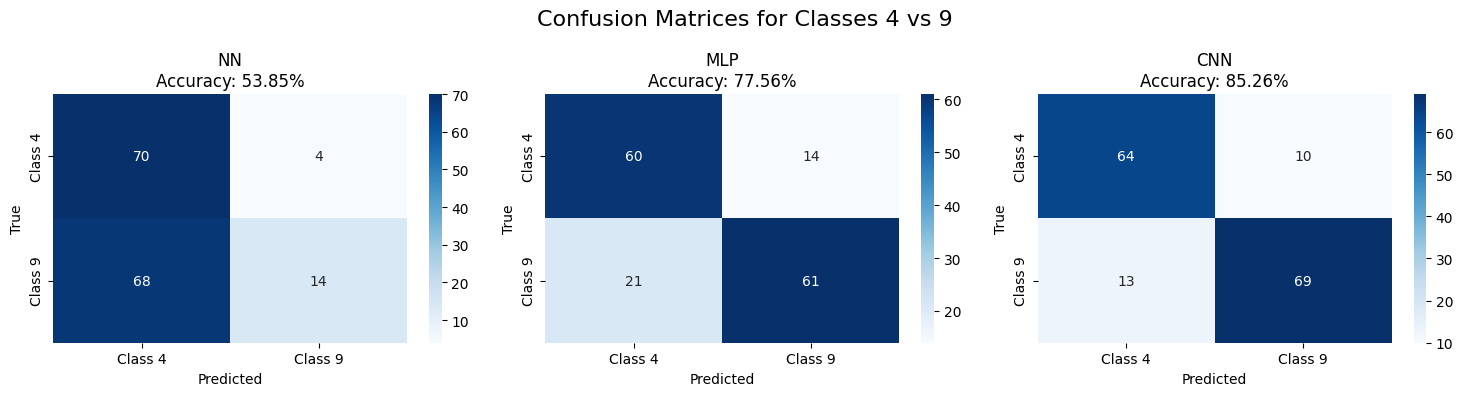


Evaluating models on classes: ['5', '6']
📃Train Dataset:
	Number of images in class 0: 314
	Number of images in class 1: 306
	Number of training samples: 620

📃Test Dataset:
	Number of images in class 0: 74
	Number of images in class 1: 82
	Number of testing samples: 156

NN Results:
Accuracy: 69.87%
Classification Report:
              precision    recall  f1-score   support

     Class 5       0.63      0.91      0.74        74
     Class 6       0.86      0.51      0.64        82

    accuracy                           0.70       156
   macro avg       0.74      0.71      0.69       156
weighted avg       0.75      0.70      0.69       156

📃Train Dataset:
	Number of images in class 0: 314
	Number of images in class 1: 306
	Number of training samples: 620

📃Test Dataset:
	Number of images in class 0: 74
	Number of images in class 1: 82
	Number of testing samples: 156

NN Results:
Accuracy: 69.87%
Classification Report:
              precision    recall  f1-score   support

     Cla

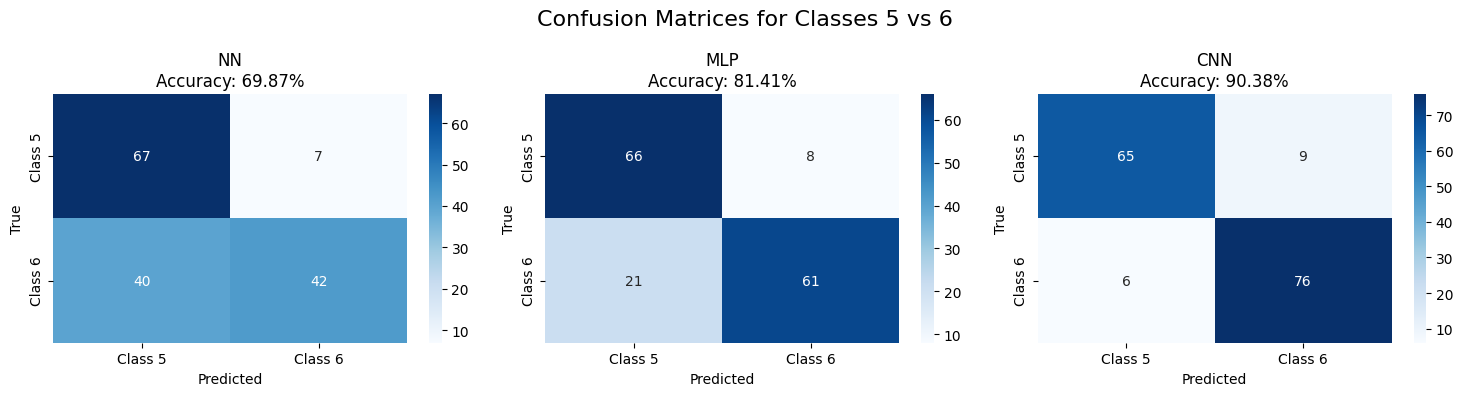


Evaluating models on classes: ['5', '7']
📃Train Dataset:
	Number of images in class 0: 314
	Number of images in class 1: 306
	Number of training samples: 620

📃Test Dataset:
	Number of images in class 0: 74
	Number of images in class 1: 82
	Number of testing samples: 156
📃Train Dataset:
	Number of images in class 0: 314
	Number of images in class 1: 306
	Number of training samples: 620

📃Test Dataset:
	Number of images in class 0: 74
	Number of images in class 1: 82
	Number of testing samples: 156

NN Results:
Accuracy: 67.31%
Classification Report:
              precision    recall  f1-score   support

     Class 5       0.61      0.88      0.72        74
     Class 7       0.82      0.49      0.61        82

    accuracy                           0.67       156
   macro avg       0.71      0.68      0.66       156
weighted avg       0.72      0.67      0.66       156


MLP Results:
Accuracy: 76.92%
Classification Report:
              precision    recall  f1-score   support

     Cl

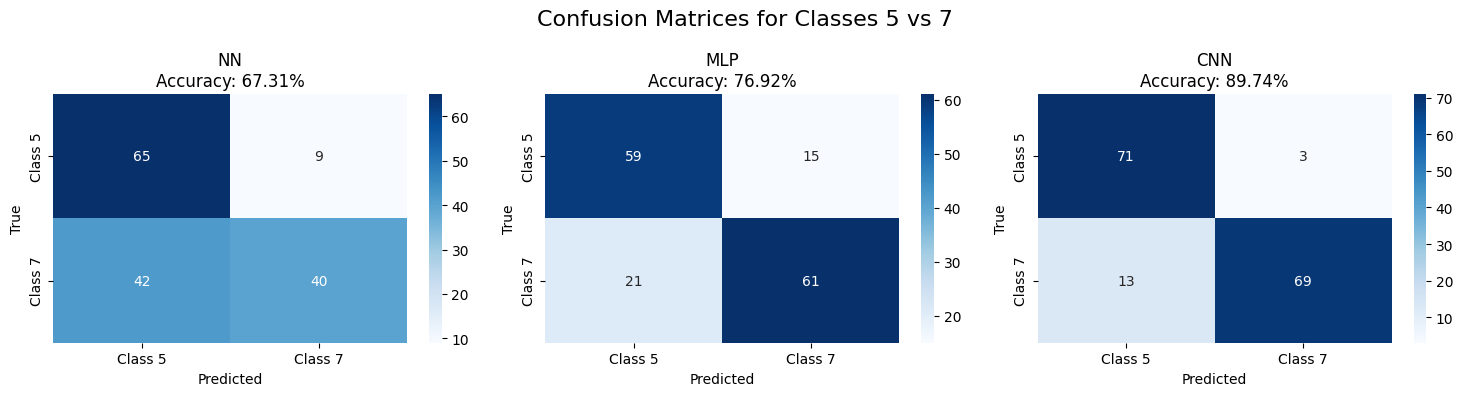


Evaluating models on classes: ['5', '8']
📃Train Dataset:
	Number of images in class 0: 314
	Number of images in class 1: 306
	Number of training samples: 620

📃Test Dataset:
	Number of images in class 0: 74
	Number of images in class 1: 82
	Number of testing samples: 156

NN Results:
Accuracy: 64.74%
Classification Report:
              precision    recall  f1-score   support

     Class 5       0.58      0.91      0.71        74
     Class 8       0.83      0.41      0.55        82

    accuracy                           0.65       156
   macro avg       0.71      0.66      0.63       156
weighted avg       0.71      0.65      0.63       156

📃Train Dataset:
	Number of images in class 0: 314
	Number of images in class 1: 306
	Number of training samples: 620

📃Test Dataset:
	Number of images in class 0: 74
	Number of images in class 1: 82
	Number of testing samples: 156

NN Results:
Accuracy: 64.74%
Classification Report:
              precision    recall  f1-score   support

     Cla

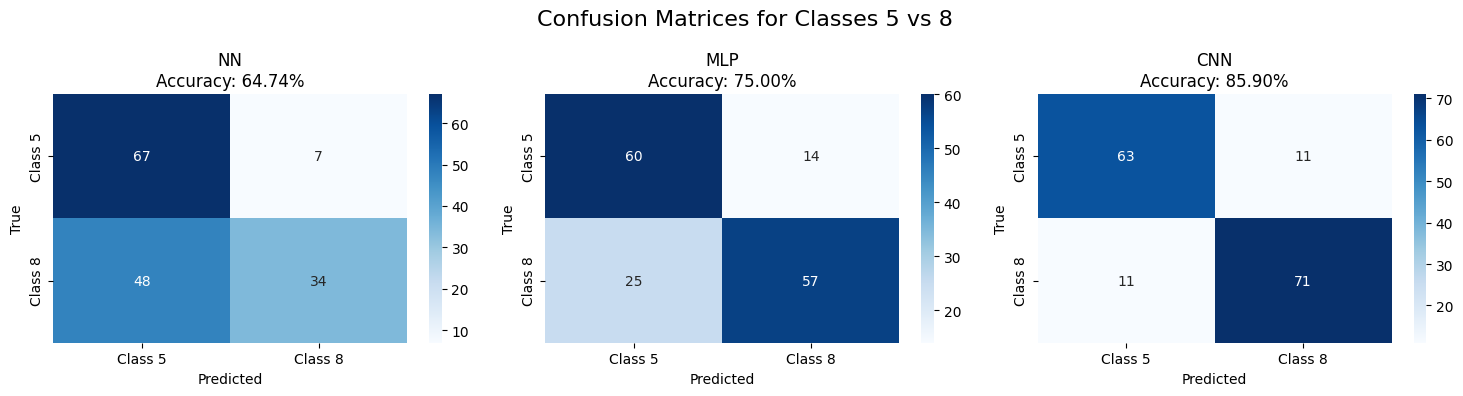


Evaluating models on classes: ['5', '9']
📃Train Dataset:
	Number of images in class 0: 314
	Number of images in class 1: 306
	Number of training samples: 620

📃Test Dataset:
	Number of images in class 0: 74
	Number of images in class 1: 82
	Number of testing samples: 156

NN Results:
Accuracy: 57.05%
Classification Report:
              precision    recall  f1-score   support

     Class 5       0.53      0.91      0.67        74
     Class 9       0.76      0.27      0.40        82

    accuracy                           0.57       156
   macro avg       0.64      0.59      0.53       156
weighted avg       0.65      0.57      0.52       156

📃Train Dataset:
	Number of images in class 0: 314
	Number of images in class 1: 306
	Number of training samples: 620

📃Test Dataset:
	Number of images in class 0: 74
	Number of images in class 1: 82
	Number of testing samples: 156

NN Results:
Accuracy: 57.05%
Classification Report:
              precision    recall  f1-score   support

     Cla

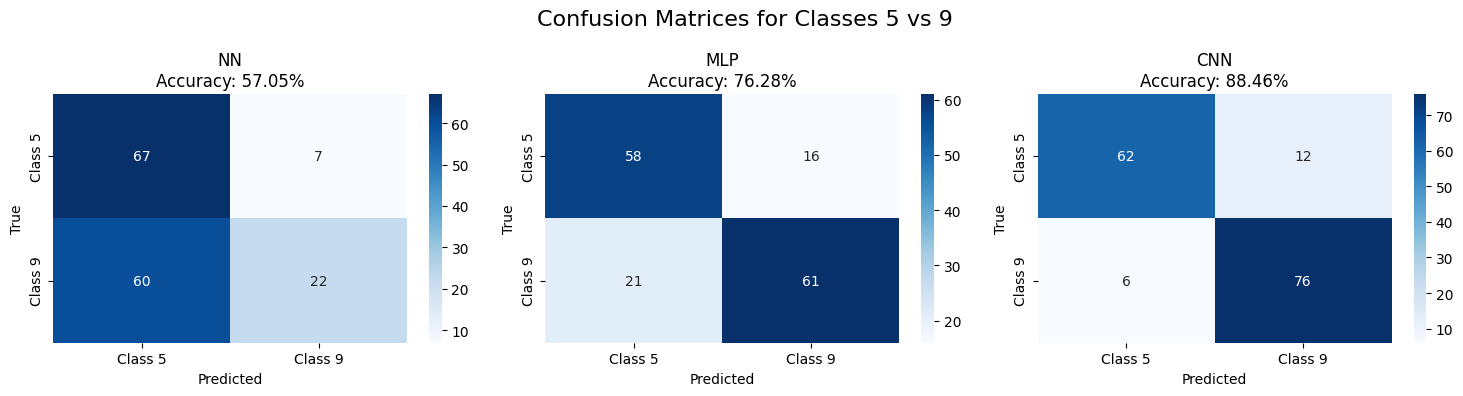


Evaluating models on classes: ['6', '7']
📃Train Dataset:
	Number of images in class 0: 314
	Number of images in class 1: 306
	Number of training samples: 620

📃Test Dataset:
	Number of images in class 0: 74
	Number of images in class 1: 82
	Number of testing samples: 156

NN Results:
Accuracy: 69.23%
Classification Report:
              precision    recall  f1-score   support

     Class 6       0.61      0.99      0.75        74
     Class 7       0.97      0.43      0.59        82

    accuracy                           0.69       156
   macro avg       0.79      0.71      0.67       156
weighted avg       0.80      0.69      0.67       156

📃Train Dataset:
	Number of images in class 0: 314
	Number of images in class 1: 306
	Number of training samples: 620

📃Test Dataset:
	Number of images in class 0: 74
	Number of images in class 1: 82
	Number of testing samples: 156

NN Results:
Accuracy: 69.23%
Classification Report:
              precision    recall  f1-score   support

     Cla

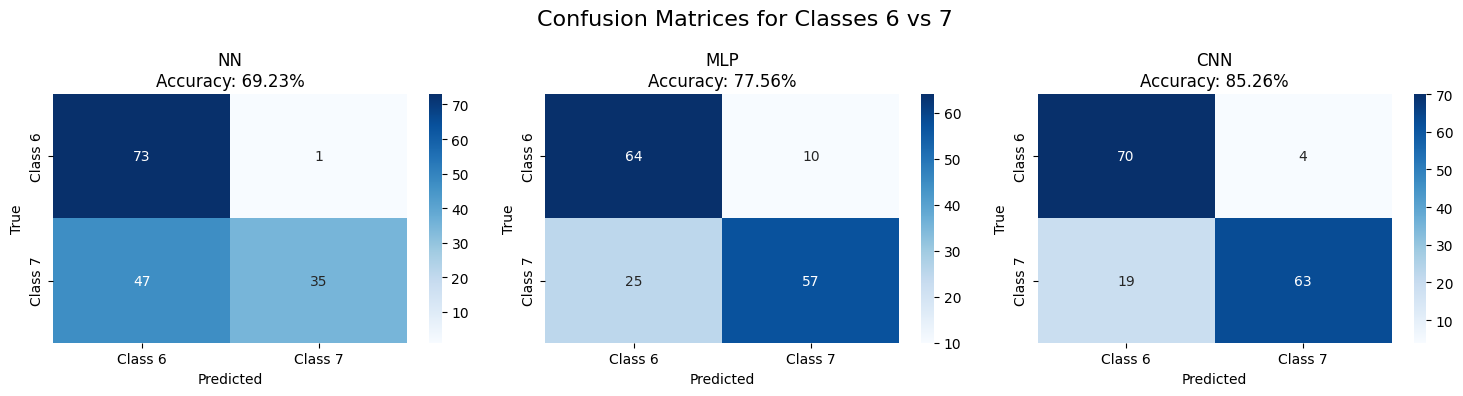


Evaluating models on classes: ['6', '8']
📃Train Dataset:
	Number of images in class 0: 314
	Number of images in class 1: 306
	Number of training samples: 620

📃Test Dataset:
	Number of images in class 0: 74
	Number of images in class 1: 82
	Number of testing samples: 156

NN Results:
Accuracy: 51.92%
Classification Report:
              precision    recall  f1-score   support

     Class 6       0.50      1.00      0.66        74
     Class 8       1.00      0.09      0.16        82

    accuracy                           0.52       156
   macro avg       0.75      0.54      0.41       156
weighted avg       0.76      0.52      0.40       156

📃Train Dataset:
	Number of images in class 0: 314
	Number of images in class 1: 306
	Number of training samples: 620

📃Test Dataset:
	Number of images in class 0: 74
	Number of images in class 1: 82
	Number of testing samples: 156

NN Results:
Accuracy: 51.92%
Classification Report:
              precision    recall  f1-score   support

     Cla

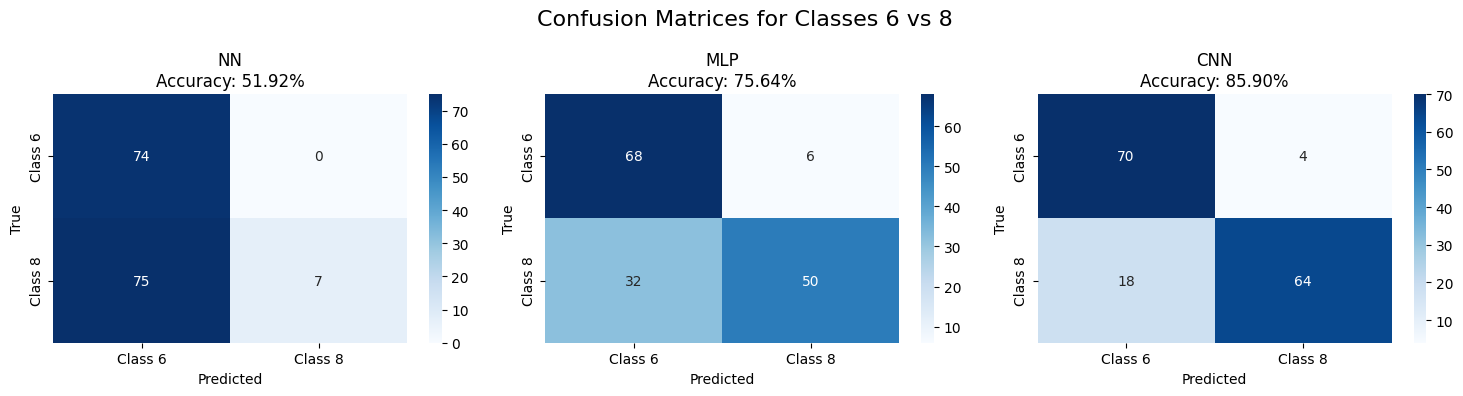


Evaluating models on classes: ['6', '9']
📃Train Dataset:
	Number of images in class 0: 314
	Number of images in class 1: 306
	Number of training samples: 620

📃Test Dataset:
	Number of images in class 0: 74
	Number of images in class 1: 82
	Number of testing samples: 156

NN Results:
Accuracy: 64.74%
Classification Report:
              precision    recall  f1-score   support

     Class 6       0.58      0.95      0.72        74
     Class 9       0.89      0.38      0.53        82

    accuracy                           0.65       156
   macro avg       0.73      0.66      0.62       156
weighted avg       0.74      0.65      0.62       156

📃Train Dataset:
	Number of images in class 0: 314
	Number of images in class 1: 306
	Number of training samples: 620

📃Test Dataset:
	Number of images in class 0: 74
	Number of images in class 1: 82
	Number of testing samples: 156

NN Results:
Accuracy: 64.74%
Classification Report:
              precision    recall  f1-score   support

     Cla

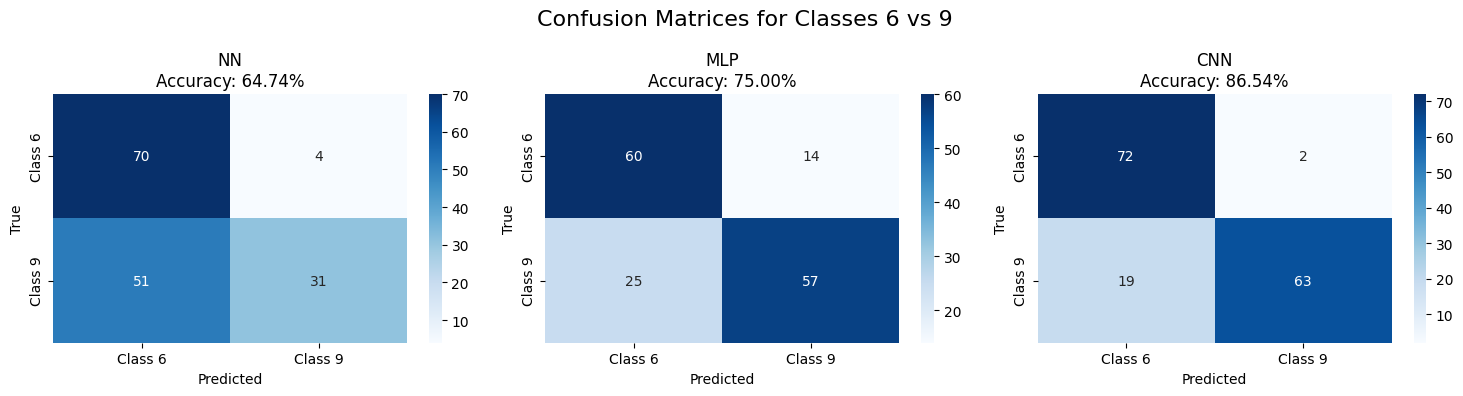


Evaluating models on classes: ['7', '8']
📃Train Dataset:
	Number of images in class 0: 314
	Number of images in class 1: 306
	Number of training samples: 620

📃Test Dataset:
	Number of images in class 0: 74
	Number of images in class 1: 82
	Number of testing samples: 156

NN Results:
Accuracy: 55.13%
Classification Report:
              precision    recall  f1-score   support

     Class 7       0.51      0.96      0.67        74
     Class 8       0.83      0.18      0.30        82

    accuracy                           0.55       156
   macro avg       0.67      0.57      0.48       156
weighted avg       0.68      0.55      0.48       156

📃Train Dataset:
	Number of images in class 0: 314
	Number of images in class 1: 306
	Number of training samples: 620

📃Test Dataset:
	Number of images in class 0: 74
	Number of images in class 1: 82
	Number of testing samples: 156

NN Results:
Accuracy: 55.13%
Classification Report:
              precision    recall  f1-score   support

     Cla

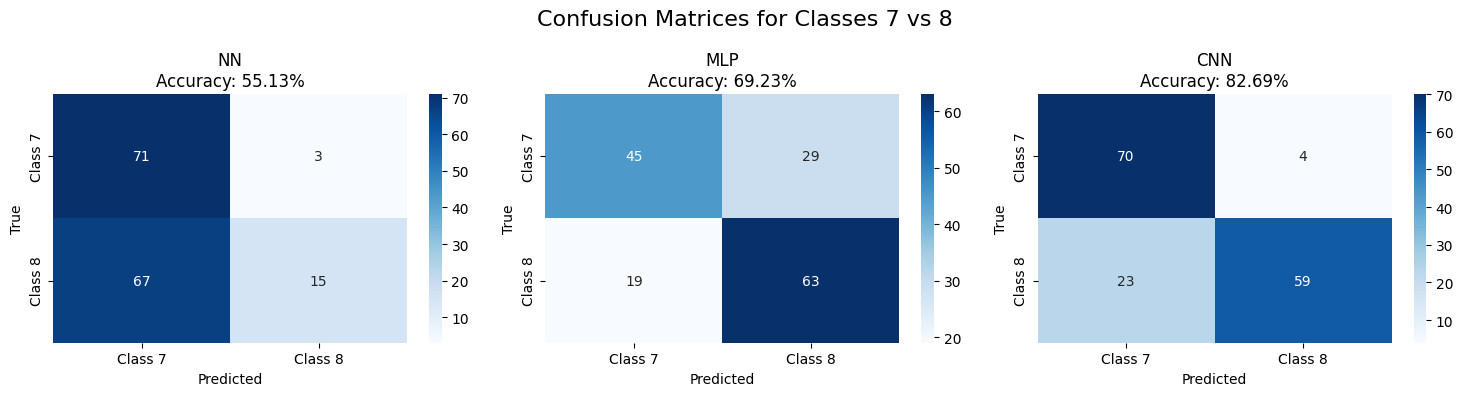


Evaluating models on classes: ['7', '9']
📃Train Dataset:
	Number of images in class 0: 314
	Number of images in class 1: 306
	Number of training samples: 620

📃Test Dataset:
	Number of images in class 0: 74
	Number of images in class 1: 82
	Number of testing samples: 156

NN Results:
Accuracy: 53.85%
Classification Report:
              precision    recall  f1-score   support

     Class 7       0.51      0.95      0.66        74
     Class 9       0.78      0.17      0.28        82

    accuracy                           0.54       156
   macro avg       0.64      0.56      0.47       156
weighted avg       0.65      0.54      0.46       156

📃Train Dataset:
	Number of images in class 0: 314
	Number of images in class 1: 306
	Number of training samples: 620

📃Test Dataset:
	Number of images in class 0: 74
	Number of images in class 1: 82
	Number of testing samples: 156

NN Results:
Accuracy: 53.85%
Classification Report:
              precision    recall  f1-score   support

     Cla

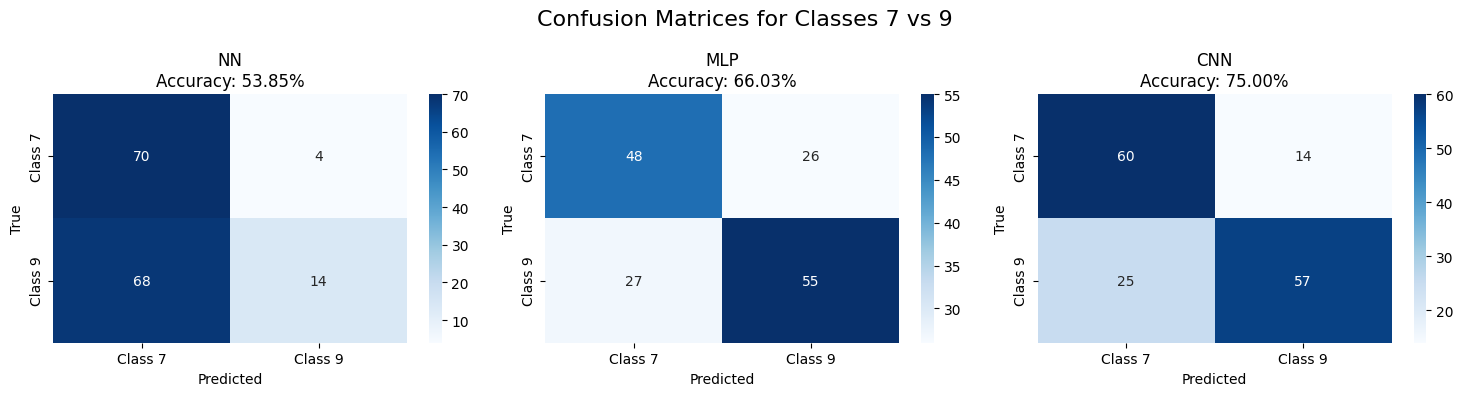


Evaluating models on classes: ['8', '9']
📃Train Dataset:
	Number of images in class 0: 314
	Number of images in class 1: 306
	Number of training samples: 620

📃Test Dataset:
	Number of images in class 0: 74
	Number of images in class 1: 82
	Number of testing samples: 156

NN Results:
Accuracy: 63.46%
Classification Report:
              precision    recall  f1-score   support

     Class 8       0.57      0.91      0.70        74
     Class 9       0.82      0.39      0.53        82

    accuracy                           0.63       156
   macro avg       0.70      0.65      0.62       156
weighted avg       0.70      0.63      0.61       156

📃Train Dataset:
	Number of images in class 0: 314
	Number of images in class 1: 306
	Number of training samples: 620

📃Test Dataset:
	Number of images in class 0: 74
	Number of images in class 1: 82
	Number of testing samples: 156

NN Results:
Accuracy: 63.46%
Classification Report:
              precision    recall  f1-score   support

     Cla

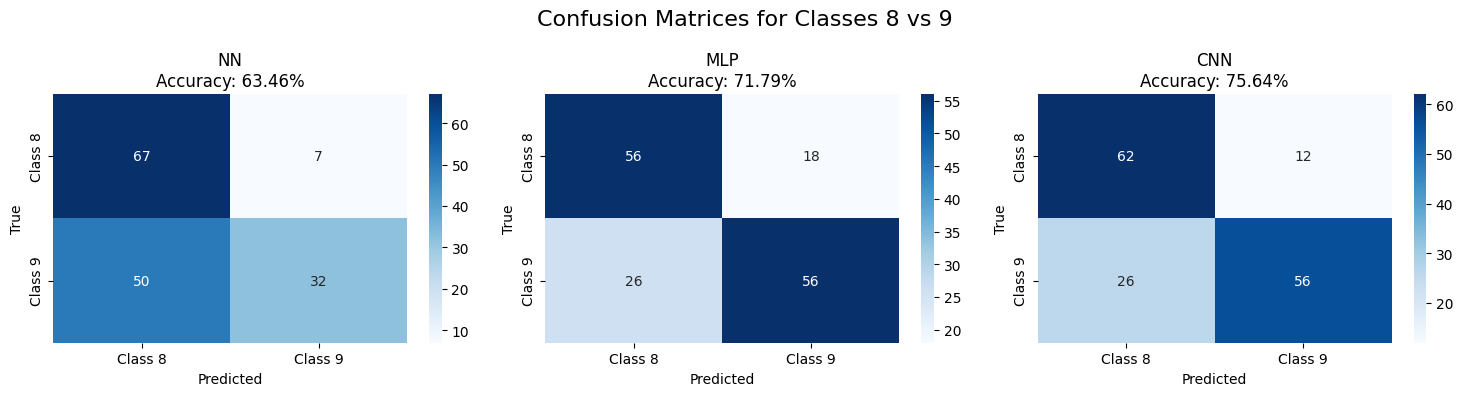


SUMMARY OF ALL RESULTS
NN_0_1: 69.87%
MLP_0_1: 58.33%
CNN_0_1: 80.77%
NN_0_2: 76.92%
MLP_0_2: 59.62%
CNN_0_2: 88.46%
NN_0_3: 76.28%
MLP_0_3: 76.92%
CNN_0_3: 83.33%
NN_0_4: 73.72%
MLP_0_4: 76.92%
CNN_0_4: 83.97%
NN_0_5: 73.72%
MLP_0_5: 78.85%
CNN_0_5: 89.10%
NN_0_6: 57.69%
MLP_0_6: 67.95%
CNN_0_6: 82.69%
NN_0_7: 66.03%
MLP_0_7: 71.15%
CNN_0_7: 82.69%
NN_0_8: 51.28%
MLP_0_8: 62.18%
CNN_0_8: 85.90%
NN_0_9: 67.31%
MLP_0_9: 78.21%
CNN_0_9: 86.54%
NN_1_2: 64.74%
MLP_1_2: 64.74%
CNN_1_2: 89.74%
NN_1_3: 78.85%
MLP_1_3: 75.64%
CNN_1_3: 82.69%
NN_1_4: 68.59%
MLP_1_4: 69.87%
CNN_1_4: 92.95%
NN_1_5: 75.00%
MLP_1_5: 79.49%
CNN_1_5: 93.59%
NN_1_6: 69.23%
MLP_1_6: 71.79%
CNN_1_6: 87.18%
NN_1_7: 73.72%
MLP_1_7: 76.28%
CNN_1_7: 82.69%
NN_1_8: 75.64%
MLP_1_8: 80.13%
CNN_1_8: 93.59%
NN_1_9: 73.72%
MLP_1_9: 73.08%
CNN_1_9: 86.54%
NN_2_3: 69.87%
MLP_2_3: 53.21%
CNN_2_3: 91.03%
NN_2_4: 82.05%
MLP_2_4: 84.62%
CNN_2_4: 92.95%
NN_2_5: 80.13%
MLP_2_5: 85.90%
CNN_2_5: 92.31%
NN_2_6: 82.69%
MLP_2_6: 76.92%
CNN_2

In [18]:
### START CODE HERE ###
def evaluate_model(model, test_loader, device):
    """Evaluate model and return predictions and true labels"""
    model.eval()
    all_preds = []
    all_labels = []
    
    with torch.no_grad():
        for data, target in test_loader:
            data, target = data.to(device), target.to(device)
            output = model(data).squeeze()
            predicted = (output > 0.5).float()
            
            all_preds.extend(predicted.cpu().numpy())
            all_labels.extend(target.cpu().numpy())
    
    return np.array(all_preds), np.array(all_labels)

# Evaluate all trained models
class_combinations = [
    ['0', '1'], ['0', '2'], ['0', '3'], ['0', '4'], ['0', '5'],
    ['0', '6'], ['0', '7'], ['0', '8'], ['0', '9'],
    ['1', '2'], ['1', '3'], ['1', '4'], ['1', '5'],
    ['1', '6'], ['1', '7'], ['1', '8'], ['1', '9'],
    ['2', '3'], ['2', '4'], ['2', '5'],
    ['2', '6'], ['2', '7'], ['2', '8'], ['2', '9'],
    ['3', '4'], ['3', '5'], ['3', '6'], ['3', '7'], ['3', '8'], ['3', '9'],
    ['4', '5'], ['4', '6'], ['4', '7'], ['4', '8'], ['4', '9'],
    ['5', '6'], ['5', '7'], ['5', '8'], ['5', '9'],
    ['6', '7'], ['6', '8'], ['6', '9'],
    ['7', '8'], ['7', '9'],
    ['8', '9']
]
model_types = ['NN', 'MLP', 'CNN']

results = {}

for class_pair in class_combinations:
    print(f"\n{'='*60}")
    print(f"Evaluating models on classes: {class_pair}")
    print(f"{'='*60}")
    
    # Load test data
    _, test_loader = load_data("thai-handwriting-number.appspot.com", class_pair)
    
    # Create subplot for all models
    fig, axes = plt.subplots(1, 3, figsize=(15, 4))
    fig.suptitle(f'Confusion Matrices for Classes {class_pair[0]} vs {class_pair[1]}', fontsize=16)
    
    for i, model_name in enumerate(model_types):
        # Load trained model
        checkpoint_path = f'models/{model_name}_classes_{"_".join(class_pair)}.pth'
        
        if os.path.exists(checkpoint_path):
            # Initialize model
            if model_name == 'NN':
                model = NN()
            elif model_name == 'MLP':
                model = MLP()
            elif model_name == 'CNN':
                model = CNN()
            
            # Load weights
            checkpoint = torch.load(checkpoint_path, map_location=device)
            model.load_state_dict(checkpoint['model_state_dict'])
            model.to(device)
            
            # Evaluate model
            y_pred, y_true = evaluate_model(model, test_loader, device)
            
            # Calculate accuracy
            accuracy = (y_pred == y_true).mean() * 100
            
            # Create confusion matrix
            cm = confusion_matrix(y_true, y_pred)
            
            # Plot confusion matrix
            sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', 
                       xticklabels=[f'Class {class_pair[0]}', f'Class {class_pair[1]}'],
                       yticklabels=[f'Class {class_pair[0]}', f'Class {class_pair[1]}'],
                       ax=axes[i])
            axes[i].set_title(f'{model_name}\nAccuracy: {accuracy:.2f}%')
            axes[i].set_xlabel('Predicted')
            axes[i].set_ylabel('True')
            
            # Store results
            key = f"{model_name}_{'_'.join(class_pair)}"
            results[key] = {
                'accuracy': accuracy,
                'confusion_matrix': cm,
                'classification_report': classification_report(y_true, y_pred, 
                                                              target_names=[f'Class {class_pair[0]}', f'Class {class_pair[1]}'])
            }
            
            print(f"\n{model_name} Results:")
            print(f"Accuracy: {accuracy:.2f}%")
            print("Classification Report:")
            print(results[key]['classification_report'])
            
        else:
            print(f"Model {checkpoint_path} not found!")
            axes[i].text(0.5, 0.5, 'Model not found', ha='center', va='center', transform=axes[i].transAxes)
            axes[i].set_title(f'{model_name}\nNot Available')
    
    plt.tight_layout()
    plt.show()

# Summary of results
print(f"\n{'='*80}")
print("SUMMARY OF ALL RESULTS")
print(f"{'='*80}")

for key, result in results.items():
    print(f"{key}: {result['accuracy']:.2f}%")

### END CODE HERE ###

Questions
1. How does the performance of different models vary across different pairs of numbers in our dataset?
2. Can you identify the number pairs where the Neural Network model performs best and worst? Explain why the NN model is able/unable to classify these specific pairs based on the visualization of feature maps of each node in each layer.
3. Analyze and compare how MLP and CNN models perform on the dataset compared to the Neural Network model.  Identify scenarios where MLP and CNN outperform or underperform the NN. Explain the reasons behind these performance differences. Consider factors like the underlying structure of the data and the specific strengths of each model architecture.
4. According to your observations from questions 1-3, propose specific strategies to improve the performance of each model (NN, MLP, CNN) on this dataset. Consider factors such as data preprocessing, data augmentation, or potential changes to the model architecture itself. Justify your suggestions based on the strengths and limitations identified in the previous questions.

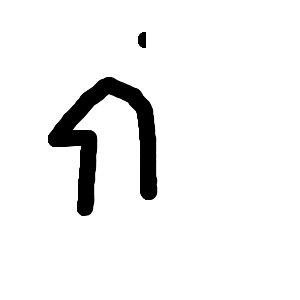